In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from collections import Counter
import math
import re
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn import model_selection

In [2]:
real_train=pd.read_csv('train.csv')
real_test=pd.read_csv('test.csv')
sample=pd.read_csv('sample_submission.csv')

# Feature extraction

In [3]:
def get_vol(a, b, c, alpha, beta, gamma):
    """
    Args:
        a (float) - lattice vector 1
        b (float) - lattice vector 2
        c (float) - lattice vector 3
        alpha (float) - lattice angle 1 [radians]
        beta (float) - lattice angle 2 [radians]
        gamma (float) - lattice angle 3 [radians]
    Returns:
        volume (float) of the parallelepiped unit cell
    """
    return a*b*c*np.sqrt(1 + 2*np.cos(alpha)*np.cos(beta)*np.cos(gamma)
                           - np.cos(alpha)**2
                           - np.cos(beta)**2
                           - np.cos(gamma)**2)

# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
for lang in lattice_angles:
    real_train['_'.join([lang, 'r'])] = np.pi * real_train[lang] / 180
    
# compute the cell volumes 
real_train['vol'] = get_vol(real_train['lattice_vector_1_ang'], 
                            real_train['lattice_vector_2_ang'], 
                            real_train['lattice_vector_3_ang'],
                            real_train['lattice_angle_alpha_degree_r'],
                            real_train['lattice_angle_beta_degree_r'], 
                            real_train['lattice_angle_gamma_degree_r'])

In [4]:
# convert lattice angles from degrees to radians for volume calculation
lattice_angles = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']
for lang in lattice_angles:
    real_test['_'.join([lang, 'r'])] = np.pi * real_test[lang] / 180
    
# compute the cell volumes 
real_test['vol'] = get_vol(real_test['lattice_vector_1_ang'], 
                            real_test['lattice_vector_2_ang'], 
                            real_test['lattice_vector_3_ang'],
                            real_test['lattice_angle_alpha_degree_r'],
                            real_test['lattice_angle_beta_degree_r'], 
                            real_test['lattice_angle_gamma_degree_r'])

In [5]:
# добавим количество каждого атома
for i in ['ga','in','al']:
    real_train[i+'_tcnt']=real_train.apply(lambda x: x['percent_atom_'+i]*x.number_of_total_atoms*2/5, axis=1)
    real_test[i+'_tcnt']=real_test.apply(lambda x: x['percent_atom_'+i]*x.number_of_total_atoms*2/5, axis=1)

real_train['o_tcnt']=real_train.apply(lambda x: x.number_of_total_atoms*3/5, axis=1)
real_test['o_tcnt']=real_test.apply(lambda x: x.number_of_total_atoms*3/5, axis=1)

In [6]:
# calculate the atomic density
# this is known to correlate with stability or bonding strength
real_train['atomic_density'] = real_train['number_of_total_atoms'] / real_train['vol']   
real_test['atomic_density'] = real_test['number_of_total_atoms'] / real_test['vol']

In [7]:
def get_xyz_data(filename):
    pos_data = []
    lat_data = []
    with open(filename) as f:
        for line in f.readlines():
            x = line.split()
            if x[0] == 'atom':
                pos_data.append([np.array(x[1:4], dtype=np.float),x[4]])
            elif x[0] == 'lattice_vector':
                lat_data.append(np.array(x[1:4], dtype=np.float))
    return pos_data, np.array(lat_data)

In [8]:
ga_cols = []
al_cols = []
o_cols = []
in_cols = []

import warnings
warnings.filterwarnings("ignore")

for i in range(7):
    ga_cols.append("Ga_"+str(i))

for i in range(7):
    al_cols.append("Al_"+str(i))

for i in range(7):
    o_cols.append("O_"+str(i))

for i in range(7):
    in_cols.append("In_"+str(i))

ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)

In [9]:
for i in real_train.id.values:
    fn = "/home/timur/Tim/Python projects/Kaggle/Predicting Transparent Conductors/train/{}/geometry.xyz".format(i)
    real_train_xyz, real_train_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    
    ga_cnt = 0
    al_cnt = 0
    o_cnt = 0
    in_cnt = 0
    
    for li in real_train_xyz:
        if li[1] == "Ga":
            ga_cnt+=1
            ga_list.append(li[0])
        elif li[1] == "Al":
            al_list.append(li[0])
            al_cnt+=1
        elif li[1] == "In":
            in_list.append(li[0])
            in_cnt+=1
        elif li[1] == "O":
            o_cnt+=1
            o_list.append(li[0])
        
#     ga_list = [item for sublist in ga_list for item in sublist]
#     al_list = [item for sublist in al_list for item in sublist]
#     o_list = [item for sublist in o_list for item in sublist]
   
    
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga['Ga_6']=ga_cnt
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])
   

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al['Al_6']=al_cnt
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o['O_6']=o_cnt
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in['In_6']=in_cnt
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])

In [10]:
ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

real_train = pd.merge(real_train,ga_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,al_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,o_df,on = ["id"],how = "left")
real_train = pd.merge(real_train,in_df,on = ["id"],how = "left")
    
ga_df= pd.DataFrame(columns=ga_cols)
al_df = pd.DataFrame(columns=al_cols)
o_df = pd.DataFrame(columns= o_cols)
in_df = pd.DataFrame(columns=in_cols)    

In [11]:
for i in real_test.id.values:
    fn = "/home/timur/Tim/Python projects/Kaggle/Predicting Transparent Conductors/test/{}/geometry.xyz".format(i)
    real_train_xyz, real_train_lat = get_xyz_data(fn)
    
    ga_list = []
    al_list = []
    o_list = []
    in_list = []
    ga_cnt = 0
    al_cnt = 0
    o_cnt = 0
    in_cnt = 0
    
    for li in real_train_xyz:
        if li[1] == "Ga":
            ga_cnt+=1
            ga_list.append(li[0])
        elif li[1] == "Al":
            al_list.append(li[0])
            al_cnt+=1
        elif li[1] == "In":
            in_list.append(li[0])
            in_cnt+=1
        elif li[1] == "O":
            o_cnt+=1
            o_list.append(li[0])
    
#     ga_list = [item for sublist in ga_list for item in sublist]
#     al_list = [item for sublist in al_list for item in sublist]
#     o_list = [item for sublist in o_list for item in sublist]
   
    
    try:
        model = PCA(n_components=2)
        ga_list = np.array(ga_list)
        temp_ga = model.fit_transform(ga_list.transpose())
        temp_ga = [item for sublist in temp_ga for item in sublist]
       
    except:
        temp_ga = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        al_list = np.array(al_list)
        temp_al = model.fit_transform(al_list.transpose())
        temp_al = [item for sublist in temp_al for item in sublist]
#         print i
    except:
        temp_al = [0,0,0,0,0,0]
#         print i
    try:
        model = PCA(n_components=2)
        o_list = np.array(o_list)
        temp_o = model.fit_transform(o_list.transpose())
        temp_o = [item for sublist in temp_o for item in sublist]
#         print i
    except:
        temp_o = [0,0,0,0,0,0]
#         print i
    
    try:
        model = PCA(n_components=2)
        in_list = np.array(in_list)
        temp_in = model.fit_transform(in_list.transpose())
        temp_in = [item for sublist in temp_in for item in sublist]
#         print i
    except:
        temp_in = [0,0,0,0,0,0]
#         print i

    temp_ga = pd.DataFrame(temp_ga).transpose()
    temp_ga['Ga_6']=ga_cnt
    temp_ga.columns = ga_cols
    temp_ga.index = np.array([i])
   

    temp_al = pd.DataFrame(temp_al).transpose()
    temp_al['Al_6']=al_cnt
    temp_al.columns = al_cols
    temp_al.index = np.array([i])

    temp_o = pd.DataFrame(temp_o).transpose()
    temp_o['O_6']=o_cnt
    temp_o.columns = o_cols
    temp_o.index = np.array([i])
    
    temp_in = pd.DataFrame(temp_in).transpose()
    temp_in['In_6']=in_cnt
    temp_in.columns = in_cols
    temp_in.index = np.array([i])
    
    

    ga_df = pd.concat([ga_df,temp_ga])
    al_df = pd.concat([al_df,temp_al])
    o_df = pd.concat([o_df,temp_o])    
    in_df = pd.concat([in_df,temp_in])
    

ga_df["id"] = ga_df.index
al_df["id"] = al_df.index
o_df["id"] = o_df.index
in_df["id"] = in_df.index

real_test = pd.merge(real_test,ga_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,al_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,o_df,on = ["id"],how = "left")
real_test = pd.merge(real_test,in_df,on = ["id"],how = "left")

# Divide datasets by spacegroup and create model for every

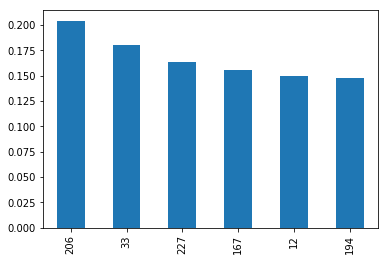

In [12]:
real_train['spacegroup'].value_counts(normalize=True).plot.bar()

In [13]:
real_train_206=real_train[real_train['spacegroup']==206].copy()
real_train_33=real_train[real_train['spacegroup']==33].copy()
real_train_227=real_train[real_train['spacegroup']==227].copy()
real_train_167=real_train[real_train['spacegroup']==167].copy()
real_train_12=real_train[real_train['spacegroup']==12].copy()
real_train_194=real_train[real_train['spacegroup']==194].copy()


real_test_206=real_test[real_test['spacegroup']==206].copy()
real_test_33=real_test[real_test['spacegroup']==33].copy()
real_test_227=real_test[real_test['spacegroup']==227].copy()
real_test_167=real_test[real_test['spacegroup']==167].copy()
real_test_12=real_test[real_test['spacegroup']==12].copy()
real_test_194=real_test[real_test['spacegroup']==194].copy()

In [14]:
def rmsle(h, y): 
    return np.sqrt(np.square(np.log(h + 1) - np.log(y + 1)).mean())

In [15]:
params = {'depth':[3,4,5,6,7,8],
          'iterations':[50,100, 200,250,500],
          'learning_rate':[0.01, 0.03, 0.1, 0.2, 0.3, 1, 10], 
          'l2_leaf_reg':[0.1,1,3,5],
#           'boosting_type': 0,
          'ctr_description': 'Buckets',
#           'CtrBorderCount': 6,
#           'use_best_model': True,
#           'eval_metric': 'RMSE',
#           'ctr_description': ('Borders', , 'BinarizedTargetMeanValue', 'Counter'),
          'rsm': 0.8,
          'random_seed':42,
          'border_count':6,
#           'ctr_border_count':[50,100,200],
          'thread_count':4,
          'loss_function':'RMSE'}

In [16]:
from sklearn.model_selection import KFold
def crossvaltest(param, train_set, features, target, n_splits=3):
    kf = KFold(n_splits=n_splits,shuffle=True) 
    res = []
    for train_index, test_index in kf.split(train_set):
        train = train_set.iloc[train_index,:]
        test = train_set.iloc[test_index,:]
        
        train_target=train[target]
        test_target=test[target]
        
        train=train[features]
        test=test[features]        
       
        clf = CatBoostRegressor(**param)
        clf.fit(train, train_target)
        preds=clf.predict(test)
        res.append(np.sqrt(mean_squared_error(preds, test_target)))
    return np.mean(res)

In [17]:
# this function runs grid search on several parameters
from paramsearch import paramsearch
from itertools import product,chain
def catboost_param_tune(params, train_set, features, target, n_splits=3):
    ps = paramsearch(params)
    # search 'border_count', 'l2_leaf_reg' etc. individually 
    #   but 'iterations','learning_rate' together
    for prms in chain(ps.grid_search(['border_count']),
#                       ps.grid_search(['ctr_border_count']),
                      ps.grid_search(['l2_leaf_reg']),
                      ps.grid_search(['learning_rate']),
                      ps.grid_search(['iterations']),
                      ps.grid_search(['depth'])):
        res = crossvaltest(prms, train_set, features, target, n_splits=3)
        # save the crossvalidation result so that future iterations can reuse the best parameters
        ps.register_result(-res,prms)
        print(res, prms, 'best:',-ps.bestscore(),ps.bestparam(),'\n')
    return ps.bestparam()

# 206

In [18]:
X = real_train_206.drop(['id','bandgap_energy_ev','formation_energy_ev_natom'], axis=1)
Y_feen = np.log(real_train_206['formation_energy_ev_natom']+1)
Y_bee = np.log(real_train_206['bandgap_energy_ev']+1)

test_id=real_test_206.id
real_test_206 = real_test_206.drop(['id'], axis = 1)

real_train_206['log_form']=Y_feen
feats=real_train_206.columns.tolist()
feats.remove('log_form')
feats.remove('id')
feats.remove('bandgap_energy_ev')
feats.remove('formation_energy_ev_natom')

In [19]:
bestparams = catboost_param_tune(params=params, train_set=real_train_206, features=feats, target='log_form')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1449381	total: 48.9ms	remaining: 2.4s
1:	learn: 0.1435751	total: 51ms	remaining: 1.22s
2:	learn: 0.1422728	total: 53.2ms	remaining: 833ms
3:	learn: 0.1410107	total: 55.1ms	remaining: 634ms
4:	learn: 0.1397338	total: 57.4ms	remaining: 517ms
5:	learn: 0.1384657	total: 59.7ms	remaining: 438ms
6:	learn: 0.1372006	total: 61.6ms	remaining: 378ms
7:	learn: 0.1359747	total: 63.7ms	remaining: 335ms
8:	learn: 0.1347185	total: 65.8ms	remaining: 300ms
9:	learn: 0.1335109	total: 67.5ms	remaining: 270ms
10:	learn: 0.1323575	total: 69.2ms	remaining: 245ms
11:	learn: 0.1311851	total: 70.8ms	remaining: 224ms
12:	learn: 0.1299758	total: 72.4ms	remaining: 206ms
13:	learn: 0.1287468	total: 74ms	remaining: 190ms
14:	learn: 0.1276111	total: 75.5ms	remaining: 176ms
15:	learn: 0.1264795	total: 77.1ms	remaining: 164ms
16:	learn: 0.1253905	total: 78.5ms	remaining: 152ms
17:	learn: 0.1242550	total

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1460509	total: 1.75ms	remaining: 85.8ms
1:	learn: 0.1447407	total: 4.78ms	remaining: 115ms
2:	learn: 0.1434871	total: 6.96ms	remaining: 109ms
3:	learn: 0.1422740	total: 8.91ms	remaining: 102ms
4:	learn: 0.1410384	total: 11ms	remaining: 99ms
5:	learn: 0.1397961	total: 13.3ms	remaining: 97.6ms
6:	learn: 0.1385904	total: 15.5ms	remaining: 95.3ms
7:	learn: 0.1373668	total: 17.6ms	remaining: 92.6ms
8:	learn: 0.1361438	total: 19.8ms	remaining: 90.3ms
9:	learn: 0.1349777	total: 24.2ms	remaining: 96.8ms
10:	learn: 0.1338773	total: 26.2ms	remaining: 92.9ms
11:	learn: 0.1327254	total: 28ms	remaining: 88.7ms
12:	learn: 0.1315533	total: 29.8ms	remaining: 84.9ms
13:	learn: 0.1303870	total: 31.6ms	remaining: 81.4ms
14:	learn: 0.1292888	total: 33.3ms	remaining: 77.6ms
15:	learn: 0.1282071	total: 34.7ms	remaining: 73.7ms
16:	learn: 0.1271223	total: 36ms	remaining: 69.8ms
17:	learn: 0.12

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1416547	total: 1.9ms	remaining: 92.9ms
1:	learn: 0.1404068	total: 4.05ms	remaining: 97.3ms
2:	learn: 0.1391706	total: 6.13ms	remaining: 96ms
3:	learn: 0.1380199	total: 8.06ms	remaining: 92.7ms
4:	learn: 0.1368429	total: 9.91ms	remaining: 89.2ms
5:	learn: 0.1356461	total: 11.9ms	remaining: 87.6ms
6:	learn: 0.1344943	total: 13.9ms	remaining: 85.6ms
7:	learn: 0.1333227	total: 15.8ms	remaining: 83.2ms
8:	learn: 0.1321339	total: 17.7ms	remaining: 80.8ms
9:	learn: 0.1310152	total: 19.5ms	remaining: 78ms
10:	learn: 0.1299989	total: 21.7ms	remaining: 77.1ms
11:	learn: 0.1288002	total: 23.9ms	remaining: 75.6ms
12:	learn: 0.1276535	total: 26.7ms	remaining: 76ms
13:	learn: 0.1265027	total: 28.7ms	remaining: 73.8ms
14:	learn: 0.1254452	total: 30.7ms	remaining: 71.6ms
15:	learn: 0.1244020	total: 33.5ms	remaining: 71.2ms
16:	learn: 0.1233536	total: 35.6ms	remaining: 69ms
17:	learn: 0.

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1467186	total: 2.14ms	remaining: 105ms
1:	learn: 0.1428719	total: 4.23ms	remaining: 102ms
2:	learn: 0.1391071	total: 6.59ms	remaining: 103ms
3:	learn: 0.1355062	total: 8.86ms	remaining: 102ms
4:	learn: 0.1320585	total: 10.7ms	remaining: 95.9ms
5:	learn: 0.1285724	total: 13.1ms	remaining: 95.9ms
6:	learn: 0.1251565	total: 15.1ms	remaining: 93ms
7:	learn: 0.1219069	total: 17ms	remaining: 89.1ms
8:	learn: 0.1186373	total: 19ms	remaining: 86.7ms
9:	learn: 0.1156299	total: 20.9ms	remaining: 83.7ms
10:	learn: 0.1127567	total: 23.1ms	remaining: 81.8ms
11:	learn: 0.1098929	total: 25.6ms	remaining: 81.2ms
12:	learn: 0.1070277	total: 28.6ms	remaining: 81.3ms
13:	learn: 0.1042555	total: 30.6ms	remaining: 78.7ms
14:	learn: 0.1017155	total: 32.7ms	remaining: 76.2ms
15:	learn: 0.0991626	total: 34.6ms	remaining: 73.5ms
16:	learn: 0.0968125	total: 36.2ms	remaining: 70.2ms
17:	learn: 0.0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1357086	total: 1.95ms	remaining: 95.6ms
1:	learn: 0.1236931	total: 4.46ms	remaining: 107ms
2:	learn: 0.1128574	total: 7.68ms	remaining: 120ms
3:	learn: 0.1034800	total: 10.2ms	remaining: 117ms
4:	learn: 0.0947655	total: 12ms	remaining: 108ms
5:	learn: 0.0867781	total: 13.8ms	remaining: 101ms
6:	learn: 0.0793039	total: 15.6ms	remaining: 95.7ms
7:	learn: 0.0730059	total: 17.3ms	remaining: 90.7ms
8:	learn: 0.0670948	total: 19ms	remaining: 86.7ms
9:	learn: 0.0620162	total: 20.7ms	remaining: 82.9ms
10:	learn: 0.0580676	total: 22.5ms	remaining: 79.8ms
11:	learn: 0.0536021	total: 24.2ms	remaining: 76.7ms
12:	learn: 0.0498491	total: 25.9ms	remaining: 73.8ms
13:	learn: 0.0462046	total: 27.6ms	remaining: 70.9ms
14:	learn: 0.0433342	total: 29.2ms	remaining: 68.1ms
15:	learn: 0.0408488	total: 30.8ms	remaining: 65.5ms
16:	learn: 0.0387097	total: 32.5ms	remaining: 63.2ms
17:	learn: 0.

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1216293	total: 1.9ms	remaining: 93.3ms
1:	learn: 0.1014656	total: 4.1ms	remaining: 98.5ms
2:	learn: 0.0845205	total: 6.06ms	remaining: 95ms
3:	learn: 0.0712928	total: 8.48ms	remaining: 97.5ms
4:	learn: 0.0611924	total: 11.1ms	remaining: 100ms
5:	learn: 0.0529321	total: 13.3ms	remaining: 97.3ms
6:	learn: 0.0466544	total: 15.2ms	remaining: 93.4ms
7:	learn: 0.0421043	total: 17.1ms	remaining: 89.9ms
8:	learn: 0.0377116	total: 19ms	remaining: 86.6ms
9:	learn: 0.0351698	total: 21ms	remaining: 84.1ms
10:	learn: 0.0329859	total: 23.1ms	remaining: 81.8ms
11:	learn: 0.0311781	total: 25.7ms	remaining: 81.3ms
12:	learn: 0.0300573	total: 27.5ms	remaining: 78.2ms
13:	learn: 0.0287281	total: 29.1ms	remaining: 74.9ms
14:	learn: 0.0281363	total: 30.7ms	remaining: 71.6ms
15:	learn: 0.0276689	total: 32.4ms	remaining: 68.8ms
16:	learn: 0.0270962	total: 34ms	remaining: 66.1ms
17:	learn: 0.02

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1105043	total: 1.89ms	remaining: 92.6ms
1:	learn: 0.0813848	total: 3.99ms	remaining: 95.8ms
2:	learn: 0.0626158	total: 6.28ms	remaining: 98.4ms
3:	learn: 0.0507733	total: 8.55ms	remaining: 98.3ms
4:	learn: 0.0405803	total: 10.4ms	remaining: 93.7ms
5:	learn: 0.0349784	total: 12.2ms	remaining: 89.7ms
6:	learn: 0.0304623	total: 14.2ms	remaining: 87ms
7:	learn: 0.0282173	total: 16.3ms	remaining: 85.7ms
8:	learn: 0.0261847	total: 18.7ms	remaining: 85.1ms
9:	learn: 0.0254594	total: 20.5ms	remaining: 82.1ms
10:	learn: 0.0250660	total: 22.4ms	remaining: 79.3ms
11:	learn: 0.0245178	total: 24.2ms	remaining: 76.5ms
12:	learn: 0.0243660	total: 26ms	remaining: 74ms
13:	learn: 0.0239084	total: 28ms	remaining: 72ms
14:	learn: 0.0238560	total: 29.6ms	remaining: 69.2ms
15:	learn: 0.0235295	total: 31.4ms	remaining: 66.8ms
16:	learn: 0.0234923	total: 32.7ms	remaining: 63.5ms
17:	learn: 0.0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.0459280	total: 2.03ms	remaining: 99.4ms
1:	learn: 0.0349758	total: 3.9ms	remaining: 93.5ms
2:	learn: 0.0295204	total: 5.9ms	remaining: 92.4ms
3:	learn: 0.0278298	total: 7.87ms	remaining: 90.5ms
4:	learn: 0.0278296	total: 9.55ms	remaining: 85.9ms
5:	learn: 0.0275344	total: 11.3ms	remaining: 82.7ms
6:	learn: 0.0272126	total: 12.9ms	remaining: 79.1ms
7:	learn: 0.0266936	total: 14.8ms	remaining: 77.6ms
8:	learn: 0.0260479	total: 16.4ms	remaining: 74.5ms
9:	learn: 0.0252665	total: 18.1ms	remaining: 72.2ms
10:	learn: 0.0243705	total: 19.7ms	remaining: 70ms
11:	learn: 0.0241939	total: 21.4ms	remaining: 67.9ms
12:	learn: 0.0241448	total: 23.1ms	remaining: 65.6ms
13:	learn: 0.0239704	total: 24.6ms	remaining: 63.4ms
14:	learn: 0.0238870	total: 26.3ms	remaining: 61.3ms
15:	learn: 0.0238055	total: 27.8ms	remaining: 59ms
16:	learn: 0.0234747	total: 29.4ms	remaining: 57.1ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.2444341	total: 1.59ms	remaining: 78.1ms
1:	learn: 11.0664092	total: 3.57ms	remaining: 85.6ms
2:	learn: 98.4916021	total: 5.43ms	remaining: 85ms
3:	learn: 876.1371730	total: 7.12ms	remaining: 81.8ms
4:	learn: 7801.6103046	total: 8.86ms	remaining: 79.7ms
5:	learn: 69518.9666641	total: 10.5ms	remaining: 77.3ms
6:	learn: 619836.7113225	total: 12.2ms	remaining: 74.9ms
7:	learn: 5529221.5642974	total: 13.7ms	remaining: 72.2ms
8:	learn: 49343346.4645783	total: 15.6ms	remaining: 70.9ms
9:	learn: 440496495.4332837	total: 17.2ms	remaining: 68.7ms
10:	learn: 3933525630.7074213	total: 18.8ms	remaining: 66.7ms
11:	learn: 35134014714.7936478	total: 20.8ms	remaining: 65.9ms
12:	learn: 313880165127.5855103	total: 22.6ms	remaining: 64.3ms
13:	learn: 2804639918817.7841797	total: 24.4ms	remaining: 62.6ms
14:	learn: 25064361513089.3945313	total: 26.1ms	remaining: 60.8ms
15:	learn: 224023466

60:	learn: 0.0184792	total: 114ms	remaining: 73.2ms
61:	learn: 0.0183542	total: 118ms	remaining: 72.2ms
62:	learn: 0.0182946	total: 122ms	remaining: 71.5ms
63:	learn: 0.0182890	total: 124ms	remaining: 69.5ms
64:	learn: 0.0182862	total: 125ms	remaining: 67.3ms
65:	learn: 0.0182800	total: 127ms	remaining: 65.4ms
66:	learn: 0.0182383	total: 129ms	remaining: 63.4ms
67:	learn: 0.0182077	total: 130ms	remaining: 61.4ms
68:	learn: 0.0182057	total: 132ms	remaining: 59.4ms
69:	learn: 0.0175533	total: 134ms	remaining: 57.4ms
70:	learn: 0.0174992	total: 136ms	remaining: 55.4ms
71:	learn: 0.0174183	total: 137ms	remaining: 53.4ms
72:	learn: 0.0174041	total: 139ms	remaining: 51.5ms
73:	learn: 0.0173777	total: 141ms	remaining: 49.5ms
74:	learn: 0.0173763	total: 142ms	remaining: 47.4ms
75:	learn: 0.0172963	total: 144ms	remaining: 45.5ms
76:	learn: 0.0172961	total: 146ms	remaining: 43.6ms
77:	learn: 0.0172846	total: 148ms	remaining: 41.8ms
78:	learn: 0.0172417	total: 150ms	remaining: 39.9ms
79:	learn: 0

61:	learn: 0.0188724	total: 128ms	remaining: 78.7ms
62:	learn: 0.0188122	total: 130ms	remaining: 76.6ms
63:	learn: 0.0187812	total: 133ms	remaining: 74.7ms
64:	learn: 0.0187538	total: 135ms	remaining: 72.6ms
65:	learn: 0.0187462	total: 137ms	remaining: 70.6ms
66:	learn: 0.0187338	total: 140ms	remaining: 69.1ms
67:	learn: 0.0186294	total: 142ms	remaining: 66.9ms
68:	learn: 0.0186244	total: 144ms	remaining: 64.8ms
69:	learn: 0.0186119	total: 146ms	remaining: 62.7ms
70:	learn: 0.0185501	total: 151ms	remaining: 61.5ms
71:	learn: 0.0185332	total: 153ms	remaining: 59.6ms
72:	learn: 0.0183985	total: 155ms	remaining: 57.4ms
73:	learn: 0.0183808	total: 157ms	remaining: 55.2ms
74:	learn: 0.0183730	total: 159ms	remaining: 53ms
75:	learn: 0.0183298	total: 161ms	remaining: 50.9ms
76:	learn: 0.0183284	total: 163ms	remaining: 48.7ms
77:	learn: 0.0183193	total: 165ms	remaining: 46.5ms
78:	learn: 0.0183093	total: 167ms	remaining: 44.3ms
79:	learn: 0.0182413	total: 169ms	remaining: 42.2ms
80:	learn: 0.0

150:	learn: 0.0122080	total: 294ms	remaining: 95.5ms
151:	learn: 0.0121997	total: 296ms	remaining: 93.5ms
152:	learn: 0.0121994	total: 298ms	remaining: 91.4ms
153:	learn: 0.0121989	total: 299ms	remaining: 89.4ms
154:	learn: 0.0121876	total: 301ms	remaining: 87.4ms
155:	learn: 0.0121754	total: 303ms	remaining: 85.4ms
156:	learn: 0.0121750	total: 304ms	remaining: 83.4ms
157:	learn: 0.0121508	total: 306ms	remaining: 81.4ms
158:	learn: 0.0121506	total: 308ms	remaining: 79.3ms
159:	learn: 0.0121494	total: 309ms	remaining: 77.3ms
160:	learn: 0.0121354	total: 311ms	remaining: 75.3ms
161:	learn: 0.0121354	total: 312ms	remaining: 73.3ms
162:	learn: 0.0121351	total: 314ms	remaining: 71.3ms
163:	learn: 0.0121323	total: 316ms	remaining: 69.3ms
164:	learn: 0.0121307	total: 318ms	remaining: 67.4ms
165:	learn: 0.0121035	total: 319ms	remaining: 65.4ms
166:	learn: 0.0120750	total: 321ms	remaining: 63.4ms
167:	learn: 0.0120722	total: 323ms	remaining: 61.5ms
168:	learn: 0.0119988	total: 325ms	remaining: 

167:	learn: 0.0160229	total: 321ms	remaining: 61.1ms
168:	learn: 0.0159577	total: 323ms	remaining: 59.2ms
169:	learn: 0.0159348	total: 325ms	remaining: 57.3ms
170:	learn: 0.0159135	total: 327ms	remaining: 55.4ms
171:	learn: 0.0159124	total: 328ms	remaining: 53.5ms
172:	learn: 0.0158949	total: 330ms	remaining: 51.5ms
173:	learn: 0.0158901	total: 332ms	remaining: 49.6ms
174:	learn: 0.0158876	total: 334ms	remaining: 47.7ms
175:	learn: 0.0158876	total: 335ms	remaining: 45.7ms
176:	learn: 0.0158876	total: 337ms	remaining: 43.8ms
177:	learn: 0.0158438	total: 339ms	remaining: 41.9ms
178:	learn: 0.0158437	total: 340ms	remaining: 39.9ms
179:	learn: 0.0158436	total: 342ms	remaining: 38ms
180:	learn: 0.0158325	total: 344ms	remaining: 36.1ms
181:	learn: 0.0158251	total: 345ms	remaining: 34.1ms
182:	learn: 0.0158241	total: 347ms	remaining: 32.2ms
183:	learn: 0.0158072	total: 349ms	remaining: 30.3ms
184:	learn: 0.0158002	total: 351ms	remaining: 28.4ms
185:	learn: 0.0157779	total: 352ms	remaining: 26

161:	learn: 0.0142114	total: 315ms	remaining: 73.8ms
162:	learn: 0.0141871	total: 317ms	remaining: 71.9ms
163:	learn: 0.0141722	total: 319ms	remaining: 70ms
164:	learn: 0.0140079	total: 321ms	remaining: 68ms
165:	learn: 0.0140076	total: 323ms	remaining: 66.1ms
166:	learn: 0.0139660	total: 325ms	remaining: 64.2ms
167:	learn: 0.0139377	total: 327ms	remaining: 62.2ms
168:	learn: 0.0139253	total: 329ms	remaining: 60.3ms
169:	learn: 0.0139200	total: 330ms	remaining: 58.3ms
170:	learn: 0.0139160	total: 332ms	remaining: 56.4ms
171:	learn: 0.0139119	total: 334ms	remaining: 54.4ms
172:	learn: 0.0139097	total: 336ms	remaining: 52.5ms
173:	learn: 0.0139017	total: 338ms	remaining: 50.5ms
174:	learn: 0.0139007	total: 340ms	remaining: 48.6ms
175:	learn: 0.0138956	total: 342ms	remaining: 46.6ms
176:	learn: 0.0138349	total: 344ms	remaining: 44.7ms
177:	learn: 0.0138180	total: 346ms	remaining: 42.7ms
178:	learn: 0.0138041	total: 347ms	remaining: 40.8ms
179:	learn: 0.0137895	total: 349ms	remaining: 38.8

164:	learn: 0.0143853	total: 291ms	remaining: 150ms
165:	learn: 0.0143411	total: 293ms	remaining: 148ms
166:	learn: 0.0143251	total: 295ms	remaining: 147ms
167:	learn: 0.0142574	total: 298ms	remaining: 145ms
168:	learn: 0.0142316	total: 300ms	remaining: 144ms
169:	learn: 0.0142119	total: 302ms	remaining: 142ms
170:	learn: 0.0142106	total: 303ms	remaining: 140ms
171:	learn: 0.0141943	total: 305ms	remaining: 138ms
172:	learn: 0.0141941	total: 307ms	remaining: 137ms
173:	learn: 0.0141772	total: 309ms	remaining: 135ms
174:	learn: 0.0141727	total: 310ms	remaining: 133ms
175:	learn: 0.0141552	total: 312ms	remaining: 131ms
176:	learn: 0.0141461	total: 314ms	remaining: 129ms
177:	learn: 0.0141020	total: 316ms	remaining: 128ms
178:	learn: 0.0140794	total: 317ms	remaining: 126ms
179:	learn: 0.0140716	total: 319ms	remaining: 124ms
180:	learn: 0.0140704	total: 321ms	remaining: 122ms
181:	learn: 0.0140586	total: 323ms	remaining: 121ms
182:	learn: 0.0140293	total: 325ms	remaining: 119ms
183:	learn: 

161:	learn: 0.0155137	total: 315ms	remaining: 171ms
162:	learn: 0.0155124	total: 317ms	remaining: 169ms
163:	learn: 0.0154994	total: 319ms	remaining: 168ms
164:	learn: 0.0154989	total: 322ms	remaining: 166ms
165:	learn: 0.0154916	total: 324ms	remaining: 164ms
166:	learn: 0.0154875	total: 326ms	remaining: 162ms
167:	learn: 0.0154825	total: 328ms	remaining: 160ms
168:	learn: 0.0154730	total: 330ms	remaining: 158ms
169:	learn: 0.0154668	total: 332ms	remaining: 156ms
170:	learn: 0.0154654	total: 334ms	remaining: 154ms
171:	learn: 0.0154643	total: 336ms	remaining: 152ms
172:	learn: 0.0154643	total: 337ms	remaining: 150ms
173:	learn: 0.0154581	total: 339ms	remaining: 148ms
174:	learn: 0.0154495	total: 341ms	remaining: 146ms
175:	learn: 0.0154495	total: 343ms	remaining: 144ms
176:	learn: 0.0154482	total: 345ms	remaining: 142ms
177:	learn: 0.0154478	total: 347ms	remaining: 140ms
178:	learn: 0.0154475	total: 349ms	remaining: 138ms
179:	learn: 0.0154425	total: 351ms	remaining: 136ms
180:	learn: 

69:	learn: 0.0135132	total: 133ms	remaining: 341ms
70:	learn: 0.0133987	total: 135ms	remaining: 339ms
71:	learn: 0.0133651	total: 137ms	remaining: 338ms
72:	learn: 0.0132854	total: 139ms	remaining: 337ms
73:	learn: 0.0130823	total: 141ms	remaining: 336ms
74:	learn: 0.0130514	total: 143ms	remaining: 335ms
75:	learn: 0.0129753	total: 145ms	remaining: 333ms
76:	learn: 0.0129442	total: 147ms	remaining: 331ms
77:	learn: 0.0129082	total: 149ms	remaining: 329ms
78:	learn: 0.0127801	total: 151ms	remaining: 327ms
79:	learn: 0.0127540	total: 153ms	remaining: 326ms
80:	learn: 0.0127229	total: 155ms	remaining: 324ms
81:	learn: 0.0126844	total: 157ms	remaining: 323ms
82:	learn: 0.0126843	total: 159ms	remaining: 320ms
83:	learn: 0.0126269	total: 161ms	remaining: 318ms
84:	learn: 0.0125952	total: 163ms	remaining: 316ms
85:	learn: 0.0125914	total: 165ms	remaining: 315ms
86:	learn: 0.0125747	total: 167ms	remaining: 313ms
87:	learn: 0.0125624	total: 169ms	remaining: 312ms
88:	learn: 0.0125415	total: 172

0.0266965671402 {'depth': 3, 'iterations': 250, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0188391700384 {'depth': 3, 'iterations': 50, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1070635	total: 2.05ms	remaining: 1.02s
1:	learn: 0.0790472	total: 4.24ms	remaining: 1.05s
2:	learn: 0.0597310	total: 6.29ms	remaining: 1.04s
3:	learn: 0.0474560	total: 8.17ms	remaining: 1.01s
4:	learn: 0.0381839	total: 10.1ms	remaining: 1s
5:	learn: 0.0310707	total: 12ms	remaining: 984ms
6:	learn: 0.0269394	total: 13.9ms	remaining: 977ms
7:	learn: 0.0235350	total: 15.9ms	remaining: 975ms
8:	learn: 0.0211210	total: 17.8ms	remaining: 972ms
9:	learn: 

250:	learn: 0.0104855	total: 472ms	remaining: 468ms
251:	learn: 0.0104841	total: 476ms	remaining: 469ms
252:	learn: 0.0104808	total: 478ms	remaining: 467ms
253:	learn: 0.0104765	total: 480ms	remaining: 465ms
254:	learn: 0.0104119	total: 482ms	remaining: 463ms
255:	learn: 0.0104108	total: 484ms	remaining: 461ms
256:	learn: 0.0104090	total: 485ms	remaining: 459ms
257:	learn: 0.0104071	total: 487ms	remaining: 457ms
258:	learn: 0.0104016	total: 489ms	remaining: 455ms
259:	learn: 0.0104014	total: 491ms	remaining: 453ms
260:	learn: 0.0103986	total: 492ms	remaining: 451ms
261:	learn: 0.0103975	total: 494ms	remaining: 449ms
262:	learn: 0.0103969	total: 496ms	remaining: 447ms
263:	learn: 0.0102962	total: 498ms	remaining: 445ms
264:	learn: 0.0102914	total: 500ms	remaining: 443ms
265:	learn: 0.0102884	total: 502ms	remaining: 441ms
266:	learn: 0.0102870	total: 503ms	remaining: 439ms
267:	learn: 0.0102652	total: 505ms	remaining: 437ms
268:	learn: 0.0102652	total: 507ms	remaining: 435ms
269:	learn: 

448:	learn: 0.0085453	total: 836ms	remaining: 95ms
449:	learn: 0.0085452	total: 838ms	remaining: 93.2ms
450:	learn: 0.0085424	total: 841ms	remaining: 91.4ms
451:	learn: 0.0085417	total: 843ms	remaining: 89.6ms
452:	learn: 0.0085412	total: 845ms	remaining: 87.7ms
453:	learn: 0.0085411	total: 847ms	remaining: 85.8ms
454:	learn: 0.0085352	total: 848ms	remaining: 83.9ms
455:	learn: 0.0085350	total: 850ms	remaining: 82ms
456:	learn: 0.0085349	total: 852ms	remaining: 80.1ms
457:	learn: 0.0085346	total: 854ms	remaining: 78.3ms
458:	learn: 0.0085345	total: 855ms	remaining: 76.4ms
459:	learn: 0.0085341	total: 857ms	remaining: 74.5ms
460:	learn: 0.0085340	total: 859ms	remaining: 72.7ms
461:	learn: 0.0085332	total: 861ms	remaining: 70.8ms
462:	learn: 0.0085293	total: 862ms	remaining: 68.9ms
463:	learn: 0.0085265	total: 864ms	remaining: 67.1ms
464:	learn: 0.0085263	total: 866ms	remaining: 65.2ms
465:	learn: 0.0085262	total: 868ms	remaining: 63.4ms
466:	learn: 0.0085261	total: 870ms	remaining: 61.5

168:	learn: 0.0139814	total: 316ms	remaining: 619ms
169:	learn: 0.0137705	total: 318ms	remaining: 618ms
170:	learn: 0.0137576	total: 320ms	remaining: 616ms
171:	learn: 0.0137575	total: 322ms	remaining: 615ms
172:	learn: 0.0137209	total: 324ms	remaining: 613ms
173:	learn: 0.0137209	total: 326ms	remaining: 610ms
174:	learn: 0.0137154	total: 328ms	remaining: 609ms
175:	learn: 0.0137118	total: 330ms	remaining: 607ms
176:	learn: 0.0136721	total: 332ms	remaining: 605ms
177:	learn: 0.0136513	total: 333ms	remaining: 603ms
178:	learn: 0.0136409	total: 335ms	remaining: 601ms
179:	learn: 0.0136216	total: 337ms	remaining: 600ms
180:	learn: 0.0136117	total: 339ms	remaining: 598ms
181:	learn: 0.0135695	total: 341ms	remaining: 596ms
182:	learn: 0.0135376	total: 343ms	remaining: 594ms
183:	learn: 0.0135266	total: 345ms	remaining: 593ms
184:	learn: 0.0135245	total: 347ms	remaining: 591ms
185:	learn: 0.0135163	total: 349ms	remaining: 589ms
186:	learn: 0.0134728	total: 351ms	remaining: 587ms
187:	learn: 

363:	learn: 0.0116649	total: 680ms	remaining: 254ms
364:	learn: 0.0116626	total: 681ms	remaining: 252ms
365:	learn: 0.0116598	total: 683ms	remaining: 250ms
366:	learn: 0.0116454	total: 685ms	remaining: 248ms
367:	learn: 0.0116443	total: 687ms	remaining: 246ms
368:	learn: 0.0116370	total: 689ms	remaining: 244ms
369:	learn: 0.0116270	total: 691ms	remaining: 243ms
370:	learn: 0.0116160	total: 692ms	remaining: 241ms
371:	learn: 0.0116097	total: 694ms	remaining: 239ms
372:	learn: 0.0116070	total: 696ms	remaining: 237ms
373:	learn: 0.0116031	total: 698ms	remaining: 235ms
374:	learn: 0.0115970	total: 700ms	remaining: 233ms
375:	learn: 0.0115937	total: 702ms	remaining: 232ms
376:	learn: 0.0115926	total: 704ms	remaining: 230ms
377:	learn: 0.0115925	total: 706ms	remaining: 228ms
378:	learn: 0.0115920	total: 707ms	remaining: 226ms
379:	learn: 0.0115853	total: 709ms	remaining: 224ms
380:	learn: 0.0115848	total: 711ms	remaining: 222ms
381:	learn: 0.0115777	total: 713ms	remaining: 220ms
382:	learn: 

54:	learn: 0.0177196	total: 135ms	remaining: 1.09s
55:	learn: 0.0176791	total: 138ms	remaining: 1.1s
56:	learn: 0.0176026	total: 141ms	remaining: 1.1s
57:	learn: 0.0175895	total: 144ms	remaining: 1.09s
58:	learn: 0.0175818	total: 146ms	remaining: 1.09s
59:	learn: 0.0175641	total: 148ms	remaining: 1.08s
60:	learn: 0.0175474	total: 150ms	remaining: 1.08s
61:	learn: 0.0174962	total: 153ms	remaining: 1.08s
62:	learn: 0.0174815	total: 155ms	remaining: 1.07s
63:	learn: 0.0174623	total: 157ms	remaining: 1.07s
64:	learn: 0.0174616	total: 159ms	remaining: 1.06s
65:	learn: 0.0174616	total: 161ms	remaining: 1.06s
66:	learn: 0.0174371	total: 163ms	remaining: 1.06s
67:	learn: 0.0174269	total: 166ms	remaining: 1.05s
68:	learn: 0.0173864	total: 168ms	remaining: 1.05s
69:	learn: 0.0173458	total: 170ms	remaining: 1.04s
70:	learn: 0.0173135	total: 172ms	remaining: 1.04s
71:	learn: 0.0173122	total: 174ms	remaining: 1.03s
72:	learn: 0.0171807	total: 176ms	remaining: 1.03s
73:	learn: 0.0171707	total: 178ms

246:	learn: 0.0139377	total: 499ms	remaining: 511ms
247:	learn: 0.0139315	total: 501ms	remaining: 509ms
248:	learn: 0.0139286	total: 504ms	remaining: 508ms
249:	learn: 0.0139274	total: 506ms	remaining: 506ms
250:	learn: 0.0139211	total: 507ms	remaining: 503ms
251:	learn: 0.0139198	total: 509ms	remaining: 501ms
252:	learn: 0.0138999	total: 511ms	remaining: 499ms
253:	learn: 0.0138954	total: 513ms	remaining: 496ms
254:	learn: 0.0138949	total: 514ms	remaining: 494ms
255:	learn: 0.0138839	total: 516ms	remaining: 492ms
256:	learn: 0.0138815	total: 518ms	remaining: 490ms
257:	learn: 0.0138779	total: 520ms	remaining: 488ms
258:	learn: 0.0138770	total: 522ms	remaining: 486ms
259:	learn: 0.0138702	total: 524ms	remaining: 484ms
260:	learn: 0.0138693	total: 526ms	remaining: 481ms
261:	learn: 0.0138609	total: 527ms	remaining: 479ms
262:	learn: 0.0138560	total: 529ms	remaining: 477ms
263:	learn: 0.0138496	total: 531ms	remaining: 475ms
264:	learn: 0.0138398	total: 533ms	remaining: 472ms
265:	learn: 

442:	learn: 0.0132901	total: 866ms	remaining: 111ms
443:	learn: 0.0132879	total: 868ms	remaining: 109ms
444:	learn: 0.0132863	total: 870ms	remaining: 107ms
445:	learn: 0.0132859	total: 872ms	remaining: 106ms
446:	learn: 0.0132851	total: 874ms	remaining: 104ms
447:	learn: 0.0132830	total: 877ms	remaining: 102ms
448:	learn: 0.0132823	total: 879ms	remaining: 99.8ms
449:	learn: 0.0132791	total: 881ms	remaining: 97.9ms
450:	learn: 0.0132783	total: 883ms	remaining: 95.9ms
451:	learn: 0.0132778	total: 885ms	remaining: 94ms
452:	learn: 0.0132768	total: 887ms	remaining: 92ms
453:	learn: 0.0132766	total: 889ms	remaining: 90ms
454:	learn: 0.0132743	total: 891ms	remaining: 88.1ms
455:	learn: 0.0132689	total: 893ms	remaining: 86.1ms
456:	learn: 0.0132670	total: 894ms	remaining: 84.2ms
457:	learn: 0.0132669	total: 896ms	remaining: 82.2ms
458:	learn: 0.0132666	total: 898ms	remaining: 80.2ms
459:	learn: 0.0132654	total: 900ms	remaining: 78.3ms
460:	learn: 0.0132626	total: 902ms	remaining: 76.3ms
461:	

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1085805	total: 2.54ms	remaining: 125ms
1:	learn: 0.0792830	total: 6.07ms	remaining: 146ms
2:	learn: 0.0607519	total: 9.05ms	remaining: 142ms
3:	learn: 0.0469717	total: 11.7ms	remaining: 134ms
4:	learn: 0.0390999	total: 14.3ms	remaining: 129ms
5:	learn: 0.0334894	total: 16.7ms	remaining: 123ms
6:	learn: 0.0293791	total: 19.1ms	remaining: 117ms
7:	learn: 0.0270340	total: 21.5ms	remaining: 113ms
8:	learn: 0.0255813	total: 24ms	remaining: 109ms
9:	learn: 0.0249850	total: 26.5ms	remaining: 106ms
10:	learn: 0.0247038	total: 28.9ms	remaining: 102ms
11:	learn: 0.0244235	total: 31.2ms	remaining: 98.9ms
12:	learn: 0.0242986	total: 33.6ms	remaining: 95.6ms
13:	learn: 0.0239455	total: 36.1ms	remaining: 92.8ms
14:	learn: 0.0236689	total: 38.5ms	remaining: 89.8ms
15:	learn: 0.0234956	total: 40.9ms	remaining: 86.9ms
16:	learn: 0.0234880	total: 42.8ms	remaining: 83.1ms
17:	learn: 0.0234

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1069500	total: 2.86ms	remaining: 140ms
1:	learn: 0.0792762	total: 6.12ms	remaining: 147ms
2:	learn: 0.0593858	total: 8.67ms	remaining: 136ms
3:	learn: 0.0448908	total: 11.2ms	remaining: 129ms
4:	learn: 0.0361956	total: 13.9ms	remaining: 125ms
5:	learn: 0.0293335	total: 16.9ms	remaining: 124ms
6:	learn: 0.0257928	total: 20.6ms	remaining: 126ms
7:	learn: 0.0228559	total: 24.6ms	remaining: 129ms
8:	learn: 0.0210617	total: 28ms	remaining: 127ms
9:	learn: 0.0196760	total: 31.2ms	remaining: 125ms
10:	learn: 0.0190559	total: 33.7ms	remaining: 120ms
11:	learn: 0.0181117	total: 37ms	remaining: 117ms
12:	learn: 0.0180027	total: 39.1ms	remaining: 111ms
13:	learn: 0.0175544	total: 42.2ms	remaining: 109ms
14:	learn: 0.0170995	total: 45.4ms	remaining: 106ms
15:	learn: 0.0168232	total: 48.4ms	remaining: 103ms
16:	learn: 0.0168191	total: 50ms	remaining: 97ms
17:	learn: 0.0168007	total: 

0:	learn: 0.1077382	total: 4.09ms	remaining: 201ms
1:	learn: 0.0792631	total: 8.7ms	remaining: 209ms
2:	learn: 0.0600121	total: 12.9ms	remaining: 203ms
3:	learn: 0.0461953	total: 17.1ms	remaining: 196ms
4:	learn: 0.0365864	total: 21.1ms	remaining: 190ms
5:	learn: 0.0297403	total: 26ms	remaining: 191ms
6:	learn: 0.0251052	total: 32.2ms	remaining: 198ms
7:	learn: 0.0222212	total: 40.1ms	remaining: 210ms
8:	learn: 0.0200415	total: 44.7ms	remaining: 203ms
9:	learn: 0.0186048	total: 48.6ms	remaining: 194ms
10:	learn: 0.0180460	total: 51.8ms	remaining: 184ms
11:	learn: 0.0177529	total: 54.4ms	remaining: 172ms
12:	learn: 0.0173220	total: 57.6ms	remaining: 164ms
13:	learn: 0.0172442	total: 59.2ms	remaining: 152ms
14:	learn: 0.0169573	total: 62.4ms	remaining: 146ms
15:	learn: 0.0168960	total: 64.4ms	remaining: 137ms
16:	learn: 0.0168849	total: 66.5ms	remaining: 129ms
17:	learn: 0.0168799	total: 67.7ms	remaining: 120ms
18:	learn: 0.0168774	total: 69ms	remaining: 113ms
19:	learn: 0.0168762	total:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1069937	total: 5.87ms	remaining: 288ms
1:	learn: 0.0789611	total: 18.3ms	remaining: 438ms
2:	learn: 0.0587206	total: 27.8ms	remaining: 435ms
3:	learn: 0.0439077	total: 39.2ms	remaining: 451ms
4:	learn: 0.0341006	total: 45.1ms	remaining: 406ms
5:	learn: 0.0266144	total: 50.5ms	remaining: 370ms
6:	learn: 0.0219348	total: 53.5ms	remaining: 329ms
7:	learn: 0.0189433	total: 58.3ms	remaining: 306ms
8:	learn: 0.0159852	total: 63.2ms	remaining: 288ms
9:	learn: 0.0138139	total: 68ms	remaining: 272ms
10:	learn: 0.0132418	total: 70.9ms	remaining: 251ms
11:	learn: 0.0123496	total: 72.8ms	remaining: 230ms
12:	learn: 0.0121679	total: 76ms	remaining: 216ms
13:	learn: 0.0119543	total: 80.3ms	remaining: 207ms
14:	learn: 0.0119161	total: 82.3ms	remaining: 192ms
15:	learn: 0.0118596	total: 85ms	remaining: 181ms
16:	learn: 0.0118305	total: 87.4ms	remaining: 170ms
17:	learn: 0.0118225	total:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1049222	total: 9.68ms	remaining: 474ms
1:	learn: 0.0773167	total: 17.6ms	remaining: 422ms
2:	learn: 0.0566591	total: 24.6ms	remaining: 385ms
3:	learn: 0.0432613	total: 31.8ms	remaining: 366ms
4:	learn: 0.0331943	total: 39.4ms	remaining: 354ms
5:	learn: 0.0266929	total: 43.8ms	remaining: 322ms
6:	learn: 0.0218479	total: 51.5ms	remaining: 316ms
7:	learn: 0.0190418	total: 55.9ms	remaining: 294ms
8:	learn: 0.0169674	total: 62.4ms	remaining: 284ms
9:	learn: 0.0158483	total: 66.7ms	remaining: 267ms
10:	learn: 0.0150838	total: 71ms	remaining: 252ms
11:	learn: 0.0147200	total: 73.2ms	remaining: 232ms
12:	learn: 0.0144448	total: 77.6ms	remaining: 221ms
13:	learn: 0.0143414	total: 80.8ms	remaining: 208ms
14:	learn: 0.0142924	total: 82.6ms	remaining: 193ms
15:	learn: 0.0141465	total: 86.7ms	remaining: 184ms
16:	learn: 0.0141298	total: 88.7ms	remaining: 172ms
17:	learn: 0.0141183	to

In [20]:
par_1={'depth': 3, 'iterations': 50, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_feen, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_1)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_206["pred_form"]=np.exp(model.predict(real_test_206))-1
real_train_206["pred_form"]=np.exp(model.predict(X))-1
feats+=['pred_form']

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1096614	total: 1.86ms	remaining: 91.1ms
1:	learn: 0.0807850	total: 3.95ms	remaining: 94.9ms
2:	learn: 0.0625363	total: 5.72ms	remaining: 89.6ms
3:	learn: 0.0504967	total: 7.56ms	remaining: 87ms
4:	learn: 0.0421403	total: 9.5ms	remaining: 85.5ms
5:	learn: 0.0365527	total: 11.4ms	remaining: 83.9ms
6:	learn: 0.0323272	total: 13.5ms	remaining: 82.8ms
7:	learn: 0.0300709	total: 15.4ms	remaining: 80.6ms
8:	learn: 0.0283371	total: 17.2ms	remaining: 78.5ms
9:	learn: 0.0274460	total: 19.1ms	remaining: 76.6ms
10:	learn: 0.0270002	total: 21.1ms	remaining: 74.7ms
11:	learn: 0.0265306	total: 23ms	remaining: 72.8ms
12:	learn: 0.0261238	total: 24.9ms	remaining: 70.8ms
13:	learn: 0.0256068	total: 26.9ms	remaining: 69.3ms
14:	learn: 0.0249637	total: 28.8ms	remaining: 67.3ms
15:	learn: 0.0247121	total: 30.8ms	remaining: 65.4ms
16:	learn: 0.0246642	total: 32.7ms	remaining: 63.4ms
17:	learn

In [22]:
real_train_206['log_band']=Y_bee

In [23]:
bestparams = catboost_param_tune(params=params, train_set=real_train_206, features=feats, 
                                 target='log_band')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1471277	total: 2.58ms	remaining: 126ms
1:	learn: 1.1361020	total: 4.66ms	remaining: 112ms
2:	learn: 1.1251611	total: 6.78ms	remaining: 106ms
3:	learn: 1.1141395	total: 8.84ms	remaining: 102ms
4:	learn: 1.1034282	total: 10.8ms	remaining: 97.2ms
5:	learn: 1.0928625	total: 12.8ms	remaining: 93.8ms
6:	learn: 1.0824023	total: 14.7ms	remaining: 90.4ms
7:	learn: 1.0720176	total: 16.7ms	remaining: 87.8ms
8:	learn: 1.0618906	total: 18.6ms	remaining: 84.8ms
9:	learn: 1.0519491	total: 20.6ms	remaining: 82.4ms
10:	learn: 1.0422260	total: 22.5ms	remaining: 79.8ms
11:	learn: 1.0322989	total: 24.5ms	remaining: 77.6ms
12:	learn: 1.0224717	total: 26.4ms	remaining: 75.3ms
13:	learn: 1.0126441	total: 28.4ms	remaining: 73ms
14:	learn: 1.0030479	total: 30.1ms	remaining: 70.3ms
15:	learn: 0.9934561	total: 32ms	remaining: 68ms
16:	learn: 0.9841273	total: 34ms	remaining: 66.1ms
17:	learn: 0.974

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1305530	total: 1.85ms	remaining: 90.7ms
1:	learn: 1.1199986	total: 3.89ms	remaining: 93.4ms
2:	learn: 1.1094840	total: 5.92ms	remaining: 92.8ms
3:	learn: 1.0989031	total: 7.7ms	remaining: 88.6ms
4:	learn: 1.0887637	total: 9.6ms	remaining: 86.4ms
5:	learn: 1.0787403	total: 11.4ms	remaining: 83.6ms
6:	learn: 1.0686098	total: 13.4ms	remaining: 82.5ms
7:	learn: 1.0585233	total: 15.4ms	remaining: 81ms
8:	learn: 1.0488772	total: 17.5ms	remaining: 79.7ms
9:	learn: 1.0394621	total: 19.2ms	remaining: 76.8ms
10:	learn: 1.0302890	total: 21.3ms	remaining: 75.7ms
11:	learn: 1.0208106	total: 23.4ms	remaining: 74ms
12:	learn: 1.0113654	total: 25.3ms	remaining: 72ms
13:	learn: 1.0020573	total: 27ms	remaining: 69.5ms
14:	learn: 0.9928498	total: 29ms	remaining: 67.7ms
15:	learn: 0.9836441	total: 30.7ms	remaining: 65.3ms
16:	learn: 0.9746546	total: 32.5ms	remaining: 63.1ms
17:	learn: 0.965

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1348985	total: 1.81ms	remaining: 88.8ms
1:	learn: 1.1244481	total: 3.86ms	remaining: 92.6ms
2:	learn: 1.1141679	total: 5.7ms	remaining: 89.3ms
3:	learn: 1.1038103	total: 7.54ms	remaining: 86.8ms
4:	learn: 1.0939893	total: 9.88ms	remaining: 88.9ms
5:	learn: 1.0841669	total: 12.1ms	remaining: 88.6ms
6:	learn: 1.0742970	total: 14.1ms	remaining: 86.4ms
7:	learn: 1.0644797	total: 15.9ms	remaining: 83.7ms
8:	learn: 1.0550989	total: 17.9ms	remaining: 81.4ms
9:	learn: 1.0460414	total: 21.2ms	remaining: 84.8ms
10:	learn: 1.0370529	total: 23.4ms	remaining: 82.9ms
11:	learn: 1.0274642	total: 25.3ms	remaining: 80.1ms
12:	learn: 1.0182379	total: 27.2ms	remaining: 77.5ms
13:	learn: 1.0092212	total: 29.1ms	remaining: 74.9ms
14:	learn: 1.0001943	total: 30.8ms	remaining: 71.8ms
15:	learn: 0.9910879	total: 32.3ms	remaining: 68.5ms
16:	learn: 0.9822494	total: 33.9ms	remaining: 65.8ms
17:	l

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1078666	total: 2.04ms	remaining: 99.7ms
1:	learn: 1.0757877	total: 4.08ms	remaining: 98ms
2:	learn: 1.0446712	total: 5.98ms	remaining: 93.8ms
3:	learn: 1.0140066	total: 7.93ms	remaining: 91.3ms
4:	learn: 0.9848545	total: 9.84ms	remaining: 88.5ms
5:	learn: 0.9566635	total: 11.8ms	remaining: 86.4ms
6:	learn: 0.9292647	total: 13.5ms	remaining: 82.8ms
7:	learn: 0.9027389	total: 15.3ms	remaining: 80.2ms
8:	learn: 0.8771379	total: 17.1ms	remaining: 78.1ms
9:	learn: 0.8526663	total: 18.9ms	remaining: 75.7ms
10:	learn: 0.8292775	total: 20.8ms	remaining: 73.6ms
11:	learn: 0.8058957	total: 22.6ms	remaining: 71.6ms
12:	learn: 0.7830166	total: 24.5ms	remaining: 69.7ms
13:	learn: 0.7605918	total: 26.4ms	remaining: 67.8ms
14:	learn: 0.7392406	total: 28.1ms	remaining: 65.6ms
15:	learn: 0.7181134	total: 29.9ms	remaining: 63.6ms
16:	learn: 0.6983191	total: 31.8ms	remaining: 61.7ms
17:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0211098	total: 1.52ms	remaining: 74.5ms
1:	learn: 0.9230100	total: 3.58ms	remaining: 86ms
2:	learn: 0.8345217	total: 6.03ms	remaining: 94.4ms
3:	learn: 0.7530788	total: 7.86ms	remaining: 90.4ms
4:	learn: 0.6819700	total: 9.69ms	remaining: 87.2ms
5:	learn: 0.6183673	total: 12.1ms	remaining: 88.8ms
6:	learn: 0.5612909	total: 14ms	remaining: 86ms
7:	learn: 0.5072073	total: 16.1ms	remaining: 84.5ms
8:	learn: 0.4598075	total: 19ms	remaining: 86.6ms
9:	learn: 0.4185660	total: 22.3ms	remaining: 89ms
10:	learn: 0.3793990	total: 24.1ms	remaining: 85.6ms
11:	learn: 0.3438578	total: 26ms	remaining: 82.3ms
12:	learn: 0.3123250	total: 28.1ms	remaining: 79.9ms
13:	learn: 0.2843124	total: 30ms	remaining: 77.2ms
14:	learn: 0.2584652	total: 32ms	remaining: 74.6ms
15:	learn: 0.2352584	total: 33.6ms	remaining: 71.5ms
16:	learn: 0.2161617	total: 35.6ms	remaining: 69ms
17:	learn: 0.1968309	t

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9207306	total: 1.78ms	remaining: 87.3ms
1:	learn: 0.7437636	total: 3.81ms	remaining: 91.4ms
2:	learn: 0.6019328	total: 5.61ms	remaining: 87.8ms
3:	learn: 0.4851426	total: 7.35ms	remaining: 84.6ms
4:	learn: 0.3953963	total: 9.27ms	remaining: 83.4ms
5:	learn: 0.3239746	total: 11.1ms	remaining: 81.1ms
6:	learn: 0.2660621	total: 14.7ms	remaining: 90.2ms
7:	learn: 0.2205436	total: 16.6ms	remaining: 86.9ms
8:	learn: 0.1817503	total: 18.3ms	remaining: 83.5ms
9:	learn: 0.1567201	total: 22.5ms	remaining: 89.9ms
10:	learn: 0.1317652	total: 24.5ms	remaining: 87ms
11:	learn: 0.1121582	total: 26.6ms	remaining: 84.2ms
12:	learn: 0.0986761	total: 29.7ms	remaining: 84.6ms
13:	learn: 0.0869634	total: 33.6ms	remaining: 86.4ms
14:	learn: 0.0784933	total: 35.7ms	remaining: 83.4ms
15:	learn: 0.0717892	total: 37.6ms	remaining: 79.8ms
16:	learn: 0.0668396	total: 39.8ms	remaining: 77.2ms
17:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8115762	total: 1.68ms	remaining: 82.2ms
1:	learn: 0.5804220	total: 3.48ms	remaining: 83.6ms
2:	learn: 0.4197499	total: 5.26ms	remaining: 82.4ms
3:	learn: 0.3006328	total: 6.91ms	remaining: 79.5ms
4:	learn: 0.2241360	total: 8.59ms	remaining: 77.3ms
5:	learn: 0.1750110	total: 10.3ms	remaining: 75.7ms
6:	learn: 0.1378746	total: 12ms	remaining: 73.6ms
7:	learn: 0.1106669	total: 13.6ms	remaining: 71.4ms
8:	learn: 0.0969114	total: 15.3ms	remaining: 69.5ms
9:	learn: 0.0898479	total: 16.9ms	remaining: 67.4ms
10:	learn: 0.0865442	total: 18.6ms	remaining: 65.8ms
11:	learn: 0.0833239	total: 20.2ms	remaining: 64ms
12:	learn: 0.0816974	total: 21.9ms	remaining: 62.3ms
13:	learn: 0.0728119	total: 23.5ms	remaining: 60.5ms
14:	learn: 0.0725425	total: 24.9ms	remaining: 58.2ms
15:	learn: 0.0723102	total: 28ms	remaining: 59.5ms
16:	learn: 0.0720121	total: 29.9ms	remaining: 58ms
17:	learn: 0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1912329	total: 1.6ms	remaining: 78.5ms
1:	learn: 0.1359637	total: 3.45ms	remaining: 82.9ms
2:	learn: 0.1302835	total: 4.9ms	remaining: 76.8ms
3:	learn: 0.1235962	total: 6.62ms	remaining: 76.1ms
4:	learn: 0.1127526	total: 8.38ms	remaining: 75.4ms
5:	learn: 0.1085373	total: 9.96ms	remaining: 73ms
6:	learn: 0.0996638	total: 11.5ms	remaining: 70.6ms
7:	learn: 0.0888039	total: 13.1ms	remaining: 68.6ms
8:	learn: 0.0835317	total: 14.7ms	remaining: 67.1ms
9:	learn: 0.0782492	total: 16.3ms	remaining: 65.3ms
10:	learn: 0.0732539	total: 17.9ms	remaining: 63.6ms
11:	learn: 0.0693416	total: 19.8ms	remaining: 62.8ms
12:	learn: 0.0687340	total: 21.9ms	remaining: 62.4ms
13:	learn: 0.0687336	total: 23.4ms	remaining: 60.2ms
14:	learn: 0.0687336	total: 24.8ms	remaining: 57.8ms
15:	learn: 0.0687336	total: 26.1ms	remaining: 55.4ms
16:	learn: 0.0681724	total: 28.2ms	remaining: 54.8ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 9.9085239	total: 1.84ms	remaining: 90.3ms
1:	learn: 87.9532225	total: 3.92ms	remaining: 94.2ms
2:	learn: 781.2508136	total: 6.05ms	remaining: 94.7ms
3:	learn: 6942.7787047	total: 8.14ms	remaining: 93.6ms
4:	learn: 61725.2812848	total: 10.3ms	remaining: 93ms
5:	learn: 548990.2173976	total: 12.4ms	remaining: 91.3ms
6:	learn: 4884241.4164433	total: 14.5ms	remaining: 89ms
7:	learn: 43476753.9634752	total: 16.6ms	remaining: 87.1ms
8:	learn: 387140480.4459276	total: 18.5ms	remaining: 84.2ms
9:	learn: 3409206508.4718709	total: 20.5ms	remaining: 82ms
10:	learn: 30155357512.3612976	total: 22.6ms	remaining: 80.1ms
11:	learn: 267211550629.4436035	total: 24.7ms	remaining: 78.2ms
12:	learn: 2353027002379.3481445	total: 26.9ms	remaining: 76.7ms
13:	learn: 20768895639012.0781250	total: 28.9ms	remaining: 74.3ms
14:	learn: 183419533228051.9687500	total: 31.9ms	remaining: 74.3ms
15:	learn: 

61:	learn: 0.0515782	total: 111ms	remaining: 68.3ms
62:	learn: 0.0514497	total: 113ms	remaining: 66.6ms
63:	learn: 0.0513419	total: 115ms	remaining: 64.9ms
64:	learn: 0.0513355	total: 117ms	remaining: 63.2ms
65:	learn: 0.0513314	total: 119ms	remaining: 61.3ms
66:	learn: 0.0513275	total: 120ms	remaining: 59.3ms
67:	learn: 0.0513242	total: 122ms	remaining: 57.6ms
68:	learn: 0.0513207	total: 124ms	remaining: 55.7ms
69:	learn: 0.0513168	total: 126ms	remaining: 53.9ms
70:	learn: 0.0513153	total: 127ms	remaining: 52ms
71:	learn: 0.0513138	total: 129ms	remaining: 50.3ms
72:	learn: 0.0513129	total: 131ms	remaining: 48.3ms
73:	learn: 0.0513123	total: 132ms	remaining: 46.4ms
74:	learn: 0.0513117	total: 134ms	remaining: 44.5ms
75:	learn: 0.0513113	total: 135ms	remaining: 42.7ms
76:	learn: 0.0513109	total: 137ms	remaining: 40.8ms
77:	learn: 0.0513096	total: 138ms	remaining: 39ms
78:	learn: 0.0513094	total: 139ms	remaining: 37.1ms
79:	learn: 0.0513091	total: 141ms	remaining: 35.3ms
80:	learn: 0.051

87:	learn: 0.0529089	total: 181ms	remaining: 24.7ms
88:	learn: 0.0527773	total: 183ms	remaining: 22.7ms
89:	learn: 0.0527772	total: 185ms	remaining: 20.6ms
90:	learn: 0.0527772	total: 187ms	remaining: 18.5ms
91:	learn: 0.0527772	total: 188ms	remaining: 16.4ms
92:	learn: 0.0525203	total: 190ms	remaining: 14.3ms
93:	learn: 0.0525203	total: 192ms	remaining: 12.2ms
94:	learn: 0.0523236	total: 194ms	remaining: 10.2ms
95:	learn: 0.0513275	total: 196ms	remaining: 8.15ms
96:	learn: 0.0513274	total: 197ms	remaining: 6.11ms
97:	learn: 0.0513235	total: 199ms	remaining: 4.07ms
98:	learn: 0.0513235	total: 201ms	remaining: 2.03ms
99:	learn: 0.0513234	total: 203ms	remaining: 0us
0.0574900658781 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0554185658739 {'depth': 3, 'iterations': 50, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Bu

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0292749	total: 1.75ms	remaining: 348ms
1:	learn: 0.9302777	total: 3.77ms	remaining: 374ms
2:	learn: 0.8411314	total: 5.75ms	remaining: 378ms
3:	learn: 0.7590172	total: 7.78ms	remaining: 381ms
4:	learn: 0.6867742	total: 9.7ms	remaining: 378ms
5:	learn: 0.6229739	total: 11.6ms	remaining: 374ms
6:	learn: 0.5650162	total: 13.4ms	remaining: 370ms
7:	learn: 0.5118390	total: 15ms	remaining: 360ms
8:	learn: 0.4640124	total: 16.9ms	remaining: 360ms
9:	learn: 0.4224459	total: 18.7ms	remaining: 355ms
10:	learn: 0.3830011	total: 20.5ms	remaining: 351ms
11:	learn: 0.3480955	total: 22.3ms	remaining: 350ms
12:	learn: 0.3171333	total: 24.2ms	remaining: 347ms
13:	learn: 0.2878266	total: 25.8ms	remaining: 343ms
14:	learn: 0.2614542	total: 27.6ms	remaining: 341ms
15:	learn: 0.2378957	total: 29.4ms	remaining: 338ms
16:	learn: 0.2169293	total: 31.3ms	remaining: 337ms
17:	learn: 0.1975541	tot

189:	learn: 0.0449867	total: 318ms	remaining: 16.8ms
190:	learn: 0.0449852	total: 320ms	remaining: 15.1ms
191:	learn: 0.0449451	total: 322ms	remaining: 13.4ms
192:	learn: 0.0449009	total: 324ms	remaining: 11.8ms
193:	learn: 0.0446492	total: 326ms	remaining: 10.1ms
194:	learn: 0.0446483	total: 328ms	remaining: 8.4ms
195:	learn: 0.0444930	total: 329ms	remaining: 6.72ms
196:	learn: 0.0444317	total: 332ms	remaining: 5.05ms
197:	learn: 0.0444317	total: 333ms	remaining: 3.37ms
198:	learn: 0.0444317	total: 335ms	remaining: 1.68ms
199:	learn: 0.0444315	total: 337ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0417862	total: 2.08ms	remaining: 413ms
1:	learn: 0.9415299	total: 4.17ms	remaining: 413ms
2:	learn: 0.8505416	total: 11ms	remaining: 722ms
3:	learn: 0.7673990	total: 17.1ms	remaining: 840ms
4:	learn: 0.6945579	total: 20.5ms	remaining: 798ms
5:	learn: 0.6290271	total: 22.9ms	remaining: 739ms
6:	learn: 0.

159:	learn: 0.0417362	total: 317ms	remaining: 79.3ms
160:	learn: 0.0417012	total: 319ms	remaining: 77.3ms
161:	learn: 0.0417006	total: 321ms	remaining: 75.2ms
162:	learn: 0.0416980	total: 323ms	remaining: 73.3ms
163:	learn: 0.0416517	total: 325ms	remaining: 71.3ms
164:	learn: 0.0416230	total: 327ms	remaining: 69.3ms
165:	learn: 0.0415988	total: 329ms	remaining: 67.3ms
166:	learn: 0.0412716	total: 330ms	remaining: 65.3ms
167:	learn: 0.0412684	total: 332ms	remaining: 63.2ms
168:	learn: 0.0412681	total: 336ms	remaining: 61.6ms
169:	learn: 0.0412676	total: 338ms	remaining: 59.6ms
170:	learn: 0.0412271	total: 340ms	remaining: 57.6ms
171:	learn: 0.0412269	total: 342ms	remaining: 55.6ms
172:	learn: 0.0411226	total: 343ms	remaining: 53.6ms
173:	learn: 0.0411226	total: 345ms	remaining: 51.6ms
174:	learn: 0.0410741	total: 347ms	remaining: 49.5ms
175:	learn: 0.0410367	total: 349ms	remaining: 47.5ms
176:	learn: 0.0409649	total: 350ms	remaining: 45.5ms
177:	learn: 0.0409649	total: 352ms	remaining: 

137:	learn: 0.0421177	total: 290ms	remaining: 235ms
138:	learn: 0.0418506	total: 292ms	remaining: 233ms
139:	learn: 0.0418448	total: 294ms	remaining: 231ms
140:	learn: 0.0412460	total: 297ms	remaining: 229ms
141:	learn: 0.0412037	total: 299ms	remaining: 228ms
142:	learn: 0.0411048	total: 302ms	remaining: 226ms
143:	learn: 0.0410842	total: 304ms	remaining: 224ms
144:	learn: 0.0406252	total: 306ms	remaining: 221ms
145:	learn: 0.0402939	total: 308ms	remaining: 219ms
146:	learn: 0.0402938	total: 309ms	remaining: 217ms
147:	learn: 0.0400441	total: 311ms	remaining: 215ms
148:	learn: 0.0399508	total: 316ms	remaining: 214ms
149:	learn: 0.0393903	total: 318ms	remaining: 212ms
150:	learn: 0.0393876	total: 321ms	remaining: 210ms
151:	learn: 0.0393543	total: 323ms	remaining: 208ms
152:	learn: 0.0392337	total: 325ms	remaining: 206ms
153:	learn: 0.0392332	total: 327ms	remaining: 204ms
154:	learn: 0.0392298	total: 329ms	remaining: 202ms
155:	learn: 0.0392295	total: 331ms	remaining: 199ms
156:	learn: 

82:	learn: 0.0555482	total: 136ms	remaining: 274ms
83:	learn: 0.0555481	total: 137ms	remaining: 272ms
84:	learn: 0.0555481	total: 139ms	remaining: 269ms
85:	learn: 0.0555448	total: 141ms	remaining: 268ms
86:	learn: 0.0555448	total: 142ms	remaining: 266ms
87:	learn: 0.0555440	total: 143ms	remaining: 264ms
88:	learn: 0.0555440	total: 145ms	remaining: 262ms
89:	learn: 0.0555439	total: 146ms	remaining: 260ms
90:	learn: 0.0555439	total: 147ms	remaining: 257ms
91:	learn: 0.0555439	total: 148ms	remaining: 255ms
92:	learn: 0.0555439	total: 150ms	remaining: 253ms
93:	learn: 0.0555431	total: 151ms	remaining: 251ms
94:	learn: 0.0555112	total: 153ms	remaining: 250ms
95:	learn: 0.0555112	total: 154ms	remaining: 248ms
96:	learn: 0.0555105	total: 156ms	remaining: 246ms
97:	learn: 0.0555105	total: 157ms	remaining: 244ms
98:	learn: 0.0555105	total: 158ms	remaining: 242ms
99:	learn: 0.0555014	total: 160ms	remaining: 240ms
100:	learn: 0.0555014	total: 161ms	remaining: 238ms
101:	learn: 0.0555014	total: 1

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0398509	total: 1.71ms	remaining: 426ms
1:	learn: 0.9397892	total: 3.57ms	remaining: 443ms
2:	learn: 0.8493573	total: 5.35ms	remaining: 440ms
3:	learn: 0.7663654	total: 7.26ms	remaining: 446ms
4:	learn: 0.6936040	total: 9.26ms	remaining: 454ms
5:	learn: 0.6281217	total: 10.9ms	remaining: 444ms
6:	learn: 0.5690192	total: 12.6ms	remaining: 437ms
7:	learn: 0.5155499	total: 14ms	remaining: 424ms
8:	learn: 0.4672018	total: 15.7ms	remaining: 420ms
9:	learn: 0.4247387	total: 17.3ms	remaining: 416ms
10:	learn: 0.3877048	total: 19.2ms	remaining: 418ms
11:	learn: 0.3530306	total: 21.2ms	remaining: 420ms
12:	learn: 0.3213317	total: 22.7ms	remaining: 415ms
13:	learn: 0.2922799	total: 24.3ms	remaining: 409ms
14:	learn: 0.2683810	total: 25.9ms	remaining: 405ms
15:	learn: 0.2444777	total: 27.6ms	remaining: 403ms
16:	learn: 0.2233290	total: 29.1ms	remaining: 400ms
17:	learn: 0.2032050	to

171:	learn: 0.0412007	total: 298ms	remaining: 135ms
172:	learn: 0.0409935	total: 304ms	remaining: 135ms
173:	learn: 0.0409395	total: 306ms	remaining: 134ms
174:	learn: 0.0409391	total: 308ms	remaining: 132ms
175:	learn: 0.0409389	total: 309ms	remaining: 130ms
176:	learn: 0.0405634	total: 312ms	remaining: 129ms
177:	learn: 0.0405326	total: 313ms	remaining: 127ms
178:	learn: 0.0404951	total: 315ms	remaining: 125ms
179:	learn: 0.0404947	total: 317ms	remaining: 123ms
180:	learn: 0.0404943	total: 319ms	remaining: 121ms
181:	learn: 0.0404940	total: 320ms	remaining: 120ms
182:	learn: 0.0400711	total: 322ms	remaining: 118ms
183:	learn: 0.0400706	total: 324ms	remaining: 116ms
184:	learn: 0.0400054	total: 326ms	remaining: 114ms
185:	learn: 0.0399482	total: 328ms	remaining: 113ms
186:	learn: 0.0396588	total: 330ms	remaining: 111ms
187:	learn: 0.0396588	total: 332ms	remaining: 109ms
188:	learn: 0.0396582	total: 333ms	remaining: 108ms
189:	learn: 0.0395312	total: 335ms	remaining: 106ms
190:	learn: 

167:	learn: 0.0360117	total: 299ms	remaining: 591ms
168:	learn: 0.0359951	total: 301ms	remaining: 590ms
169:	learn: 0.0359446	total: 303ms	remaining: 588ms
170:	learn: 0.0359209	total: 305ms	remaining: 587ms
171:	learn: 0.0358793	total: 307ms	remaining: 585ms
172:	learn: 0.0356205	total: 308ms	remaining: 583ms
173:	learn: 0.0356204	total: 310ms	remaining: 581ms
174:	learn: 0.0356142	total: 312ms	remaining: 579ms
175:	learn: 0.0355976	total: 313ms	remaining: 576ms
176:	learn: 0.0355973	total: 315ms	remaining: 574ms
177:	learn: 0.0355630	total: 316ms	remaining: 572ms
178:	learn: 0.0355484	total: 318ms	remaining: 570ms
179:	learn: 0.0355040	total: 319ms	remaining: 568ms
180:	learn: 0.0353828	total: 321ms	remaining: 566ms
181:	learn: 0.0353174	total: 322ms	remaining: 563ms
182:	learn: 0.0352754	total: 324ms	remaining: 562ms
183:	learn: 0.0352696	total: 326ms	remaining: 560ms
184:	learn: 0.0352598	total: 327ms	remaining: 558ms
185:	learn: 0.0352589	total: 329ms	remaining: 555ms
186:	learn: 

377:	learn: 0.0293304	total: 659ms	remaining: 213ms
378:	learn: 0.0293041	total: 661ms	remaining: 211ms
379:	learn: 0.0293041	total: 663ms	remaining: 209ms
380:	learn: 0.0292905	total: 664ms	remaining: 208ms
381:	learn: 0.0292780	total: 666ms	remaining: 206ms
382:	learn: 0.0292779	total: 668ms	remaining: 204ms
383:	learn: 0.0292113	total: 669ms	remaining: 202ms
384:	learn: 0.0292035	total: 671ms	remaining: 200ms
385:	learn: 0.0291876	total: 673ms	remaining: 199ms
386:	learn: 0.0291876	total: 674ms	remaining: 197ms
387:	learn: 0.0291490	total: 676ms	remaining: 195ms
388:	learn: 0.0290501	total: 677ms	remaining: 193ms
389:	learn: 0.0290497	total: 679ms	remaining: 192ms
390:	learn: 0.0290497	total: 680ms	remaining: 190ms
391:	learn: 0.0290350	total: 682ms	remaining: 188ms
392:	learn: 0.0290347	total: 684ms	remaining: 186ms
393:	learn: 0.0289752	total: 685ms	remaining: 184ms
394:	learn: 0.0289701	total: 687ms	remaining: 183ms
395:	learn: 0.0289667	total: 689ms	remaining: 181ms
396:	learn: 

78:	learn: 0.0515167	total: 135ms	remaining: 721ms
79:	learn: 0.0515164	total: 137ms	remaining: 717ms
80:	learn: 0.0515161	total: 138ms	remaining: 714ms
81:	learn: 0.0514876	total: 140ms	remaining: 712ms
82:	learn: 0.0514875	total: 141ms	remaining: 709ms
83:	learn: 0.0513915	total: 143ms	remaining: 708ms
84:	learn: 0.0513914	total: 145ms	remaining: 706ms
85:	learn: 0.0513913	total: 146ms	remaining: 703ms
86:	learn: 0.0513686	total: 148ms	remaining: 703ms
87:	learn: 0.0513686	total: 150ms	remaining: 700ms
88:	learn: 0.0513659	total: 151ms	remaining: 700ms
89:	learn: 0.0513411	total: 153ms	remaining: 698ms
90:	learn: 0.0513411	total: 155ms	remaining: 696ms
91:	learn: 0.0513411	total: 156ms	remaining: 693ms
92:	learn: 0.0513410	total: 158ms	remaining: 690ms
93:	learn: 0.0513410	total: 159ms	remaining: 688ms
94:	learn: 0.0512092	total: 161ms	remaining: 686ms
95:	learn: 0.0512092	total: 162ms	remaining: 684ms
96:	learn: 0.0512091	total: 164ms	remaining: 681ms
97:	learn: 0.0512091	total: 165

286:	learn: 0.0401254	total: 497ms	remaining: 369ms
287:	learn: 0.0401224	total: 499ms	remaining: 367ms
288:	learn: 0.0401108	total: 501ms	remaining: 366ms
289:	learn: 0.0400957	total: 503ms	remaining: 364ms
290:	learn: 0.0400955	total: 505ms	remaining: 363ms
291:	learn: 0.0400140	total: 507ms	remaining: 361ms
292:	learn: 0.0400005	total: 509ms	remaining: 359ms
293:	learn: 0.0399945	total: 511ms	remaining: 358ms
294:	learn: 0.0399471	total: 513ms	remaining: 356ms
295:	learn: 0.0399421	total: 515ms	remaining: 355ms
296:	learn: 0.0398981	total: 516ms	remaining: 353ms
297:	learn: 0.0398927	total: 518ms	remaining: 351ms
298:	learn: 0.0398700	total: 520ms	remaining: 350ms
299:	learn: 0.0397271	total: 522ms	remaining: 348ms
300:	learn: 0.0396581	total: 524ms	remaining: 347ms
301:	learn: 0.0396533	total: 526ms	remaining: 345ms
302:	learn: 0.0396494	total: 528ms	remaining: 343ms
303:	learn: 0.0396066	total: 530ms	remaining: 342ms
304:	learn: 0.0396008	total: 532ms	remaining: 340ms
305:	learn: 

486:	learn: 0.0353816	total: 860ms	remaining: 23ms
487:	learn: 0.0353417	total: 862ms	remaining: 21.2ms
488:	learn: 0.0353105	total: 864ms	remaining: 19.4ms
489:	learn: 0.0351629	total: 867ms	remaining: 17.7ms
490:	learn: 0.0351534	total: 868ms	remaining: 15.9ms
491:	learn: 0.0351450	total: 870ms	remaining: 14.2ms
492:	learn: 0.0351155	total: 872ms	remaining: 12.4ms
493:	learn: 0.0350862	total: 874ms	remaining: 10.6ms
494:	learn: 0.0350782	total: 877ms	remaining: 8.85ms
495:	learn: 0.0350119	total: 879ms	remaining: 7.08ms
496:	learn: 0.0349808	total: 880ms	remaining: 5.31ms
497:	learn: 0.0349620	total: 882ms	remaining: 3.54ms
498:	learn: 0.0349383	total: 884ms	remaining: 1.77ms
499:	learn: 0.0349224	total: 886ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0289480	total: 4.21ms	remaining: 2.1s
1:	learn: 0.9299912	total: 6.16ms	remaining: 1.53s
2:	learn: 0.8408228	total: 7.71ms	remaining: 1.28s
3:	lea

183:	learn: 0.0426560	total: 317ms	remaining: 545ms
184:	learn: 0.0426557	total: 319ms	remaining: 543ms
185:	learn: 0.0423829	total: 321ms	remaining: 542ms
186:	learn: 0.0423792	total: 323ms	remaining: 540ms
187:	learn: 0.0421288	total: 325ms	remaining: 539ms
188:	learn: 0.0420499	total: 327ms	remaining: 538ms
189:	learn: 0.0420497	total: 329ms	remaining: 536ms
190:	learn: 0.0419347	total: 331ms	remaining: 535ms
191:	learn: 0.0417424	total: 333ms	remaining: 534ms
192:	learn: 0.0417379	total: 335ms	remaining: 532ms
193:	learn: 0.0417343	total: 336ms	remaining: 530ms
194:	learn: 0.0416783	total: 338ms	remaining: 528ms
195:	learn: 0.0416174	total: 340ms	remaining: 527ms
196:	learn: 0.0415533	total: 342ms	remaining: 525ms
197:	learn: 0.0415449	total: 343ms	remaining: 524ms
198:	learn: 0.0415318	total: 345ms	remaining: 522ms
199:	learn: 0.0415273	total: 347ms	remaining: 520ms
200:	learn: 0.0415273	total: 348ms	remaining: 518ms
201:	learn: 0.0415273	total: 350ms	remaining: 516ms
202:	learn: 

380:	learn: 0.0334060	total: 678ms	remaining: 212ms
381:	learn: 0.0333993	total: 680ms	remaining: 210ms
382:	learn: 0.0333820	total: 682ms	remaining: 208ms
383:	learn: 0.0332820	total: 684ms	remaining: 207ms
384:	learn: 0.0332625	total: 685ms	remaining: 205ms
385:	learn: 0.0331423	total: 687ms	remaining: 203ms
386:	learn: 0.0331404	total: 689ms	remaining: 201ms
387:	learn: 0.0331404	total: 690ms	remaining: 199ms
388:	learn: 0.0331384	total: 692ms	remaining: 197ms
389:	learn: 0.0331238	total: 693ms	remaining: 196ms
390:	learn: 0.0331223	total: 695ms	remaining: 194ms
391:	learn: 0.0331077	total: 697ms	remaining: 192ms
392:	learn: 0.0330840	total: 699ms	remaining: 190ms
393:	learn: 0.0330482	total: 700ms	remaining: 188ms
394:	learn: 0.0330199	total: 702ms	remaining: 187ms
395:	learn: 0.0330118	total: 704ms	remaining: 185ms
396:	learn: 0.0330074	total: 705ms	remaining: 183ms
397:	learn: 0.0329735	total: 707ms	remaining: 181ms
398:	learn: 0.0329702	total: 709ms	remaining: 179ms
399:	learn: 

53:	learn: 0.0479495	total: 122ms	remaining: 1.01s
54:	learn: 0.0478703	total: 126ms	remaining: 1.02s
55:	learn: 0.0477883	total: 128ms	remaining: 1.02s
56:	learn: 0.0477650	total: 130ms	remaining: 1.01s
57:	learn: 0.0477458	total: 132ms	remaining: 1.01s
58:	learn: 0.0477303	total: 134ms	remaining: 1s
59:	learn: 0.0477178	total: 135ms	remaining: 992ms
60:	learn: 0.0477078	total: 137ms	remaining: 984ms
61:	learn: 0.0476948	total: 138ms	remaining: 978ms
62:	learn: 0.0476882	total: 140ms	remaining: 971ms
63:	learn: 0.0476828	total: 141ms	remaining: 962ms
64:	learn: 0.0476785	total: 143ms	remaining: 954ms
65:	learn: 0.0476749	total: 144ms	remaining: 946ms
66:	learn: 0.0476721	total: 145ms	remaining: 940ms
67:	learn: 0.0476698	total: 147ms	remaining: 932ms
68:	learn: 0.0476679	total: 148ms	remaining: 925ms
69:	learn: 0.0476663	total: 149ms	remaining: 918ms
70:	learn: 0.0476481	total: 151ms	remaining: 911ms
71:	learn: 0.0476471	total: 152ms	remaining: 906ms
72:	learn: 0.0476462	total: 154ms	

249:	learn: 0.0346207	total: 487ms	remaining: 487ms
250:	learn: 0.0346196	total: 489ms	remaining: 485ms
251:	learn: 0.0346153	total: 491ms	remaining: 484ms
252:	learn: 0.0346152	total: 493ms	remaining: 481ms
253:	learn: 0.0346152	total: 494ms	remaining: 479ms
254:	learn: 0.0345020	total: 497ms	remaining: 477ms
255:	learn: 0.0345020	total: 498ms	remaining: 475ms
256:	learn: 0.0345012	total: 499ms	remaining: 472ms
257:	learn: 0.0345012	total: 501ms	remaining: 470ms
258:	learn: 0.0344471	total: 503ms	remaining: 468ms
259:	learn: 0.0344471	total: 504ms	remaining: 465ms
260:	learn: 0.0344464	total: 505ms	remaining: 463ms
261:	learn: 0.0344459	total: 507ms	remaining: 460ms
262:	learn: 0.0344454	total: 508ms	remaining: 458ms
263:	learn: 0.0344192	total: 510ms	remaining: 456ms
264:	learn: 0.0344188	total: 511ms	remaining: 453ms
265:	learn: 0.0342743	total: 514ms	remaining: 452ms
266:	learn: 0.0342740	total: 515ms	remaining: 450ms
267:	learn: 0.0342738	total: 517ms	remaining: 447ms
268:	learn: 

437:	learn: 0.0287538	total: 852ms	remaining: 121ms
438:	learn: 0.0287538	total: 854ms	remaining: 119ms
439:	learn: 0.0287533	total: 855ms	remaining: 117ms
440:	learn: 0.0287151	total: 858ms	remaining: 115ms
441:	learn: 0.0287151	total: 860ms	remaining: 113ms
442:	learn: 0.0287150	total: 862ms	remaining: 111ms
443:	learn: 0.0285852	total: 864ms	remaining: 109ms
444:	learn: 0.0285565	total: 866ms	remaining: 107ms
445:	learn: 0.0285301	total: 868ms	remaining: 105ms
446:	learn: 0.0285286	total: 870ms	remaining: 103ms
447:	learn: 0.0284303	total: 872ms	remaining: 101ms
448:	learn: 0.0283007	total: 875ms	remaining: 99.4ms
449:	learn: 0.0282616	total: 878ms	remaining: 97.5ms
450:	learn: 0.0282471	total: 880ms	remaining: 95.7ms
451:	learn: 0.0281157	total: 883ms	remaining: 93.8ms
452:	learn: 0.0281157	total: 885ms	remaining: 91.8ms
453:	learn: 0.0280422	total: 887ms	remaining: 89.9ms
454:	learn: 0.0279364	total: 890ms	remaining: 88ms
455:	learn: 0.0279364	total: 892ms	remaining: 86ms
456:	lea

165:	learn: 0.0393835	total: 317ms	remaining: 637ms
166:	learn: 0.0393834	total: 318ms	remaining: 635ms
167:	learn: 0.0391018	total: 320ms	remaining: 633ms
168:	learn: 0.0390528	total: 322ms	remaining: 632ms
169:	learn: 0.0390525	total: 327ms	remaining: 634ms
170:	learn: 0.0389289	total: 329ms	remaining: 632ms
171:	learn: 0.0389287	total: 330ms	remaining: 629ms
172:	learn: 0.0386095	total: 332ms	remaining: 627ms
173:	learn: 0.0385431	total: 334ms	remaining: 626ms
174:	learn: 0.0384569	total: 336ms	remaining: 624ms
175:	learn: 0.0384559	total: 338ms	remaining: 622ms
176:	learn: 0.0384530	total: 340ms	remaining: 620ms
177:	learn: 0.0379962	total: 342ms	remaining: 619ms
178:	learn: 0.0379118	total: 344ms	remaining: 617ms
179:	learn: 0.0379114	total: 346ms	remaining: 614ms
180:	learn: 0.0378139	total: 348ms	remaining: 613ms
181:	learn: 0.0378138	total: 349ms	remaining: 610ms
182:	learn: 0.0377433	total: 352ms	remaining: 609ms
183:	learn: 0.0376574	total: 354ms	remaining: 607ms
184:	learn: 

357:	learn: 0.0315201	total: 684ms	remaining: 271ms
358:	learn: 0.0314497	total: 687ms	remaining: 270ms
359:	learn: 0.0313625	total: 689ms	remaining: 268ms
360:	learn: 0.0313611	total: 691ms	remaining: 266ms
361:	learn: 0.0313502	total: 693ms	remaining: 264ms
362:	learn: 0.0313330	total: 696ms	remaining: 263ms
363:	learn: 0.0313279	total: 698ms	remaining: 261ms
364:	learn: 0.0312915	total: 700ms	remaining: 259ms
365:	learn: 0.0312661	total: 702ms	remaining: 257ms
366:	learn: 0.0312560	total: 704ms	remaining: 255ms
367:	learn: 0.0312560	total: 705ms	remaining: 253ms
368:	learn: 0.0312556	total: 706ms	remaining: 251ms
369:	learn: 0.0312533	total: 708ms	remaining: 249ms
370:	learn: 0.0312529	total: 709ms	remaining: 247ms
371:	learn: 0.0312258	total: 711ms	remaining: 245ms
372:	learn: 0.0312257	total: 713ms	remaining: 243ms
373:	learn: 0.0312104	total: 715ms	remaining: 241ms
374:	learn: 0.0311997	total: 717ms	remaining: 239ms
375:	learn: 0.0311786	total: 719ms	remaining: 237ms
376:	learn: 

71:	learn: 0.0487418	total: 143ms	remaining: 853ms
72:	learn: 0.0487393	total: 146ms	remaining: 855ms
73:	learn: 0.0487270	total: 149ms	remaining: 857ms
74:	learn: 0.0487264	total: 151ms	remaining: 853ms
75:	learn: 0.0487258	total: 152ms	remaining: 849ms
76:	learn: 0.0487254	total: 154ms	remaining: 846ms
77:	learn: 0.0487249	total: 156ms	remaining: 845ms
78:	learn: 0.0487245	total: 158ms	remaining: 841ms
79:	learn: 0.0487230	total: 159ms	remaining: 836ms
80:	learn: 0.0487227	total: 161ms	remaining: 831ms
81:	learn: 0.0487225	total: 162ms	remaining: 827ms
82:	learn: 0.0487165	total: 165ms	remaining: 830ms
83:	learn: 0.0487163	total: 168ms	remaining: 830ms
84:	learn: 0.0486833	total: 171ms	remaining: 834ms
85:	learn: 0.0486814	total: 172ms	remaining: 830ms
86:	learn: 0.0486737	total: 174ms	remaining: 827ms
87:	learn: 0.0486526	total: 176ms	remaining: 826ms
88:	learn: 0.0486525	total: 178ms	remaining: 821ms
89:	learn: 0.0486524	total: 179ms	remaining: 818ms
90:	learn: 0.0474346	total: 182

239:	learn: 0.0361852	total: 503ms	remaining: 545ms
240:	learn: 0.0361815	total: 506ms	remaining: 544ms
241:	learn: 0.0361272	total: 509ms	remaining: 542ms
242:	learn: 0.0360732	total: 512ms	remaining: 542ms
243:	learn: 0.0359896	total: 515ms	remaining: 540ms
244:	learn: 0.0359816	total: 518ms	remaining: 539ms
245:	learn: 0.0359815	total: 520ms	remaining: 536ms
246:	learn: 0.0359162	total: 522ms	remaining: 534ms
247:	learn: 0.0359161	total: 523ms	remaining: 531ms
248:	learn: 0.0358560	total: 527ms	remaining: 532ms
249:	learn: 0.0358310	total: 530ms	remaining: 530ms
250:	learn: 0.0358235	total: 532ms	remaining: 528ms
251:	learn: 0.0358235	total: 533ms	remaining: 525ms
252:	learn: 0.0357817	total: 536ms	remaining: 523ms
253:	learn: 0.0357632	total: 537ms	remaining: 520ms
254:	learn: 0.0356430	total: 540ms	remaining: 518ms
255:	learn: 0.0356323	total: 542ms	remaining: 517ms
256:	learn: 0.0356226	total: 544ms	remaining: 515ms
257:	learn: 0.0356083	total: 547ms	remaining: 513ms
258:	learn: 

399:	learn: 0.0301491	total: 868ms	remaining: 217ms
400:	learn: 0.0301485	total: 870ms	remaining: 215ms
401:	learn: 0.0301292	total: 872ms	remaining: 213ms
402:	learn: 0.0300690	total: 875ms	remaining: 211ms
403:	learn: 0.0300681	total: 877ms	remaining: 209ms
404:	learn: 0.0300681	total: 879ms	remaining: 206ms
405:	learn: 0.0300592	total: 882ms	remaining: 204ms
406:	learn: 0.0299651	total: 884ms	remaining: 202ms
407:	learn: 0.0299476	total: 886ms	remaining: 200ms
408:	learn: 0.0299330	total: 889ms	remaining: 198ms
409:	learn: 0.0298654	total: 892ms	remaining: 196ms
410:	learn: 0.0298041	total: 894ms	remaining: 194ms
411:	learn: 0.0298038	total: 896ms	remaining: 191ms
412:	learn: 0.0297473	total: 898ms	remaining: 189ms
413:	learn: 0.0297450	total: 901ms	remaining: 187ms
414:	learn: 0.0297001	total: 904ms	remaining: 185ms
415:	learn: 0.0296956	total: 906ms	remaining: 183ms
416:	learn: 0.0295186	total: 909ms	remaining: 181ms
417:	learn: 0.0294852	total: 912ms	remaining: 179ms
418:	learn: 

136:	learn: 0.0459450	total: 301ms	remaining: 798ms
137:	learn: 0.0459448	total: 303ms	remaining: 795ms
138:	learn: 0.0456188	total: 306ms	remaining: 794ms
139:	learn: 0.0455203	total: 309ms	remaining: 794ms
140:	learn: 0.0455201	total: 310ms	remaining: 790ms
141:	learn: 0.0455195	total: 312ms	remaining: 787ms
142:	learn: 0.0447350	total: 315ms	remaining: 787ms
143:	learn: 0.0447336	total: 318ms	remaining: 787ms
144:	learn: 0.0446960	total: 321ms	remaining: 786ms
145:	learn: 0.0439816	total: 324ms	remaining: 786ms
146:	learn: 0.0439806	total: 326ms	remaining: 783ms
147:	learn: 0.0425879	total: 329ms	remaining: 782ms
148:	learn: 0.0425876	total: 330ms	remaining: 778ms
149:	learn: 0.0416437	total: 333ms	remaining: 778ms
150:	learn: 0.0416437	total: 335ms	remaining: 774ms
151:	learn: 0.0416319	total: 338ms	remaining: 773ms
152:	learn: 0.0416315	total: 339ms	remaining: 770ms
153:	learn: 0.0408701	total: 342ms	remaining: 769ms
154:	learn: 0.0408691	total: 344ms	remaining: 765ms
155:	learn: 

366:	learn: 0.0250598	total: 862ms	remaining: 312ms
367:	learn: 0.0250592	total: 863ms	remaining: 310ms
368:	learn: 0.0250577	total: 865ms	remaining: 307ms
369:	learn: 0.0250018	total: 868ms	remaining: 305ms
370:	learn: 0.0250018	total: 870ms	remaining: 302ms
371:	learn: 0.0249831	total: 872ms	remaining: 300ms
372:	learn: 0.0249430	total: 875ms	remaining: 298ms
373:	learn: 0.0247029	total: 878ms	remaining: 296ms
374:	learn: 0.0246955	total: 882ms	remaining: 294ms
375:	learn: 0.0246571	total: 885ms	remaining: 292ms
376:	learn: 0.0246344	total: 888ms	remaining: 290ms
377:	learn: 0.0246326	total: 891ms	remaining: 288ms
378:	learn: 0.0246002	total: 894ms	remaining: 285ms
379:	learn: 0.0246002	total: 896ms	remaining: 283ms
380:	learn: 0.0245683	total: 899ms	remaining: 281ms
381:	learn: 0.0245683	total: 901ms	remaining: 278ms
382:	learn: 0.0245669	total: 903ms	remaining: 276ms
383:	learn: 0.0245544	total: 906ms	remaining: 274ms
384:	learn: 0.0245276	total: 909ms	remaining: 272ms
385:	learn: 

59:	learn: 0.0428315	total: 141ms	remaining: 1.03s
60:	learn: 0.0428184	total: 143ms	remaining: 1.03s
61:	learn: 0.0427667	total: 151ms	remaining: 1.06s
62:	learn: 0.0427580	total: 153ms	remaining: 1.06s
63:	learn: 0.0427510	total: 157ms	remaining: 1.07s
64:	learn: 0.0427379	total: 160ms	remaining: 1.07s
65:	learn: 0.0427297	total: 163ms	remaining: 1.07s
66:	learn: 0.0427248	total: 165ms	remaining: 1.06s
67:	learn: 0.0427143	total: 167ms	remaining: 1.06s
68:	learn: 0.0427117	total: 169ms	remaining: 1.05s
69:	learn: 0.0427096	total: 171ms	remaining: 1.05s
70:	learn: 0.0427036	total: 173ms	remaining: 1.05s
71:	learn: 0.0426912	total: 176ms	remaining: 1.04s
72:	learn: 0.0426901	total: 177ms	remaining: 1.04s
73:	learn: 0.0426885	total: 179ms	remaining: 1.03s
74:	learn: 0.0426878	total: 181ms	remaining: 1.02s
75:	learn: 0.0426793	total: 183ms	remaining: 1.02s
76:	learn: 0.0426788	total: 184ms	remaining: 1.01s
77:	learn: 0.0426783	total: 186ms	remaining: 1.01s
78:	learn: 0.0426769	total: 187

224:	learn: 0.0313171	total: 510ms	remaining: 624ms
225:	learn: 0.0313171	total: 512ms	remaining: 621ms
226:	learn: 0.0313168	total: 514ms	remaining: 618ms
227:	learn: 0.0313166	total: 515ms	remaining: 615ms
228:	learn: 0.0313142	total: 517ms	remaining: 612ms
229:	learn: 0.0312136	total: 520ms	remaining: 610ms
230:	learn: 0.0312134	total: 521ms	remaining: 607ms
231:	learn: 0.0312131	total: 523ms	remaining: 604ms
232:	learn: 0.0312131	total: 524ms	remaining: 601ms
233:	learn: 0.0312130	total: 526ms	remaining: 598ms
234:	learn: 0.0312109	total: 527ms	remaining: 595ms
235:	learn: 0.0312107	total: 529ms	remaining: 592ms
236:	learn: 0.0311968	total: 531ms	remaining: 589ms
237:	learn: 0.0311895	total: 533ms	remaining: 587ms
238:	learn: 0.0311872	total: 535ms	remaining: 584ms
239:	learn: 0.0311871	total: 536ms	remaining: 581ms
240:	learn: 0.0311633	total: 539ms	remaining: 579ms
241:	learn: 0.0311630	total: 541ms	remaining: 576ms
242:	learn: 0.0311136	total: 543ms	remaining: 575ms
243:	learn: 

387:	learn: 0.0265110	total: 878ms	remaining: 253ms
388:	learn: 0.0264831	total: 881ms	remaining: 251ms
389:	learn: 0.0264830	total: 882ms	remaining: 249ms
390:	learn: 0.0264401	total: 886ms	remaining: 247ms
391:	learn: 0.0264398	total: 887ms	remaining: 244ms
392:	learn: 0.0264396	total: 889ms	remaining: 242ms
393:	learn: 0.0263699	total: 891ms	remaining: 240ms
394:	learn: 0.0263697	total: 892ms	remaining: 237ms
395:	learn: 0.0263367	total: 895ms	remaining: 235ms
396:	learn: 0.0263359	total: 897ms	remaining: 233ms
397:	learn: 0.0263357	total: 899ms	remaining: 230ms
398:	learn: 0.0263342	total: 900ms	remaining: 228ms
399:	learn: 0.0263341	total: 902ms	remaining: 225ms
400:	learn: 0.0263341	total: 903ms	remaining: 223ms
401:	learn: 0.0263268	total: 905ms	remaining: 221ms
402:	learn: 0.0262738	total: 908ms	remaining: 219ms
403:	learn: 0.0262729	total: 910ms	remaining: 216ms
404:	learn: 0.0262700	total: 912ms	remaining: 214ms
405:	learn: 0.0262700	total: 913ms	remaining: 211ms
406:	learn: 

54:	learn: 0.0543986	total: 144ms	remaining: 1.17s
55:	learn: 0.0543696	total: 146ms	remaining: 1.16s
56:	learn: 0.0543107	total: 149ms	remaining: 1.16s
57:	learn: 0.0542760	total: 153ms	remaining: 1.16s
58:	learn: 0.0542516	total: 156ms	remaining: 1.17s
59:	learn: 0.0542345	total: 161ms	remaining: 1.18s
60:	learn: 0.0542164	total: 164ms	remaining: 1.18s
61:	learn: 0.0541864	total: 170ms	remaining: 1.2s
62:	learn: 0.0541790	total: 171ms	remaining: 1.19s
63:	learn: 0.0541273	total: 174ms	remaining: 1.18s
64:	learn: 0.0541136	total: 177ms	remaining: 1.18s
65:	learn: 0.0540995	total: 178ms	remaining: 1.17s
66:	learn: 0.0540963	total: 180ms	remaining: 1.16s
67:	learn: 0.0540936	total: 182ms	remaining: 1.15s
68:	learn: 0.0540775	total: 184ms	remaining: 1.15s
69:	learn: 0.0540735	total: 185ms	remaining: 1.14s
70:	learn: 0.0540722	total: 187ms	remaining: 1.13s
71:	learn: 0.0540592	total: 189ms	remaining: 1.12s
72:	learn: 0.0540584	total: 191ms	remaining: 1.12s
73:	learn: 0.0540577	total: 192m

234:	learn: 0.0367253	total: 514ms	remaining: 580ms
235:	learn: 0.0365456	total: 518ms	remaining: 579ms
236:	learn: 0.0364796	total: 521ms	remaining: 578ms
237:	learn: 0.0364517	total: 523ms	remaining: 576ms
238:	learn: 0.0364500	total: 525ms	remaining: 574ms
239:	learn: 0.0363968	total: 528ms	remaining: 572ms
240:	learn: 0.0363963	total: 530ms	remaining: 569ms
241:	learn: 0.0363960	total: 531ms	remaining: 567ms
242:	learn: 0.0363957	total: 533ms	remaining: 564ms
243:	learn: 0.0362340	total: 536ms	remaining: 562ms
244:	learn: 0.0361007	total: 538ms	remaining: 560ms
245:	learn: 0.0360989	total: 540ms	remaining: 558ms
246:	learn: 0.0360400	total: 543ms	remaining: 556ms
247:	learn: 0.0360004	total: 545ms	remaining: 554ms
248:	learn: 0.0358642	total: 548ms	remaining: 552ms
249:	learn: 0.0358641	total: 550ms	remaining: 550ms
250:	learn: 0.0358640	total: 552ms	remaining: 548ms
251:	learn: 0.0357871	total: 554ms	remaining: 545ms
252:	learn: 0.0357866	total: 556ms	remaining: 543ms
253:	learn: 

394:	learn: 0.0303519	total: 886ms	remaining: 236ms
395:	learn: 0.0303519	total: 888ms	remaining: 233ms
396:	learn: 0.0303503	total: 890ms	remaining: 231ms
397:	learn: 0.0303502	total: 892ms	remaining: 229ms
398:	learn: 0.0303124	total: 895ms	remaining: 226ms
399:	learn: 0.0302423	total: 898ms	remaining: 224ms
400:	learn: 0.0302418	total: 899ms	remaining: 222ms
401:	learn: 0.0302415	total: 901ms	remaining: 220ms
402:	learn: 0.0302019	total: 904ms	remaining: 218ms
403:	learn: 0.0300850	total: 907ms	remaining: 215ms
404:	learn: 0.0300850	total: 908ms	remaining: 213ms
405:	learn: 0.0300824	total: 911ms	remaining: 211ms
406:	learn: 0.0300514	total: 914ms	remaining: 209ms
407:	learn: 0.0300514	total: 915ms	remaining: 206ms
408:	learn: 0.0300513	total: 917ms	remaining: 204ms
409:	learn: 0.0300513	total: 918ms	remaining: 202ms
410:	learn: 0.0300490	total: 921ms	remaining: 200ms
411:	learn: 0.0300490	total: 923ms	remaining: 197ms
412:	learn: 0.0300489	total: 924ms	remaining: 195ms
413:	learn: 

113:	learn: 0.0423135	total: 311ms	remaining: 1.05s
114:	learn: 0.0421770	total: 316ms	remaining: 1.06s
115:	learn: 0.0421759	total: 318ms	remaining: 1.05s
116:	learn: 0.0421759	total: 320ms	remaining: 1.05s
117:	learn: 0.0418998	total: 324ms	remaining: 1.05s
118:	learn: 0.0418998	total: 326ms	remaining: 1.04s
119:	learn: 0.0412576	total: 331ms	remaining: 1.05s
120:	learn: 0.0410795	total: 336ms	remaining: 1.05s
121:	learn: 0.0410745	total: 337ms	remaining: 1.04s
122:	learn: 0.0407211	total: 342ms	remaining: 1.05s
123:	learn: 0.0404354	total: 347ms	remaining: 1.05s
124:	learn: 0.0397431	total: 352ms	remaining: 1.05s
125:	learn: 0.0397415	total: 354ms	remaining: 1.05s
126:	learn: 0.0395309	total: 359ms	remaining: 1.05s
127:	learn: 0.0394516	total: 364ms	remaining: 1.06s
128:	learn: 0.0389055	total: 368ms	remaining: 1.06s
129:	learn: 0.0387107	total: 372ms	remaining: 1.06s
130:	learn: 0.0385943	total: 377ms	remaining: 1.06s
131:	learn: 0.0381512	total: 381ms	remaining: 1.06s
132:	learn: 

326:	learn: 0.0191618	total: 1.03s	remaining: 544ms
327:	learn: 0.0191341	total: 1.03s	remaining: 541ms
328:	learn: 0.0190520	total: 1.04s	remaining: 538ms
329:	learn: 0.0190473	total: 1.04s	remaining: 536ms
330:	learn: 0.0190472	total: 1.04s	remaining: 532ms
331:	learn: 0.0190412	total: 1.04s	remaining: 528ms
332:	learn: 0.0189042	total: 1.05s	remaining: 525ms
333:	learn: 0.0188442	total: 1.05s	remaining: 523ms
334:	learn: 0.0188093	total: 1.05s	remaining: 520ms
335:	learn: 0.0187037	total: 1.06s	remaining: 517ms
336:	learn: 0.0187037	total: 1.06s	remaining: 513ms
337:	learn: 0.0184042	total: 1.06s	remaining: 510ms
338:	learn: 0.0184042	total: 1.07s	remaining: 506ms
339:	learn: 0.0184041	total: 1.07s	remaining: 503ms
340:	learn: 0.0183363	total: 1.07s	remaining: 500ms
341:	learn: 0.0182965	total: 1.07s	remaining: 497ms
342:	learn: 0.0182913	total: 1.08s	remaining: 494ms
343:	learn: 0.0182073	total: 1.08s	remaining: 490ms
344:	learn: 0.0181466	total: 1.08s	remaining: 487ms
345:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0573212	total: 4.55ms	remaining: 2.27s
1:	learn: 0.9559670	total: 9.84ms	remaining: 2.45s
2:	learn: 0.8695465	total: 14ms	remaining: 2.33s
3:	learn: 0.7911879	total: 18ms	remaining: 2.23s
4:	learn: 0.7172687	total: 21.7ms	remaining: 2.14s
5:	learn: 0.6496413	total: 27.9ms	remaining: 2.3s
6:	learn: 0.5904323	total: 31.9ms	remaining: 2.24s
7:	learn: 0.5341053	total: 36.1ms	remaining: 2.22s
8:	learn: 0.4845262	total: 41.3ms	remaining: 2.25s
9:	learn: 0.4424631	total: 46.2ms	remaining: 2.26s
10:	learn: 0.4013924	total: 50.5ms	remaining: 2.25s
11:	learn: 0.3637373	total: 53.2ms	remaining: 2.16s
12:	learn: 0.3313829	total: 58.3ms	remaining: 2.18s
13:	learn: 0.3021821	total: 62.5ms	remaining: 2.17s
14:	learn: 0.2760245	total: 66.7ms	remaining: 2.16s
15:	learn: 0.2529059	total: 73ms	remaining: 2.21s
16:	learn: 0.2310928	total: 77.8ms	remaining: 2.21s
17:	learn: 0.2117829	total: 

166:	learn: 0.0433698	total: 519ms	remaining: 1.03s
167:	learn: 0.0432567	total: 524ms	remaining: 1.03s
168:	learn: 0.0429605	total: 529ms	remaining: 1.04s
169:	learn: 0.0426797	total: 534ms	remaining: 1.04s
170:	learn: 0.0426794	total: 537ms	remaining: 1.03s
171:	learn: 0.0426782	total: 538ms	remaining: 1.03s
172:	learn: 0.0419401	total: 543ms	remaining: 1.03s
173:	learn: 0.0419263	total: 546ms	remaining: 1.02s
174:	learn: 0.0419187	total: 548ms	remaining: 1.02s
175:	learn: 0.0417462	total: 552ms	remaining: 1.01s
176:	learn: 0.0414032	total: 556ms	remaining: 1.01s
177:	learn: 0.0413767	total: 559ms	remaining: 1.01s
178:	learn: 0.0413552	total: 561ms	remaining: 1s
179:	learn: 0.0413550	total: 563ms	remaining: 1s
180:	learn: 0.0413375	total: 565ms	remaining: 995ms
181:	learn: 0.0410903	total: 569ms	remaining: 994ms
182:	learn: 0.0410776	total: 571ms	remaining: 989ms
183:	learn: 0.0408458	total: 575ms	remaining: 988ms
184:	learn: 0.0407679	total: 578ms	remaining: 985ms
185:	learn: 0.0405

355:	learn: 0.0295156	total: 1.08s	remaining: 437ms
356:	learn: 0.0295149	total: 1.08s	remaining: 434ms
357:	learn: 0.0294283	total: 1.09s	remaining: 431ms
358:	learn: 0.0293380	total: 1.09s	remaining: 428ms
359:	learn: 0.0293201	total: 1.09s	remaining: 425ms
360:	learn: 0.0292870	total: 1.1s	remaining: 422ms
361:	learn: 0.0292212	total: 1.1s	remaining: 420ms
362:	learn: 0.0291909	total: 1.1s	remaining: 417ms
363:	learn: 0.0291898	total: 1.1s	remaining: 413ms
364:	learn: 0.0291890	total: 1.11s	remaining: 410ms
365:	learn: 0.0291270	total: 1.11s	remaining: 407ms
366:	learn: 0.0290686	total: 1.11s	remaining: 404ms
367:	learn: 0.0290083	total: 1.12s	remaining: 401ms
368:	learn: 0.0290064	total: 1.12s	remaining: 398ms
369:	learn: 0.0290063	total: 1.12s	remaining: 394ms
370:	learn: 0.0290060	total: 1.13s	remaining: 391ms
371:	learn: 0.0289307	total: 1.13s	remaining: 389ms
372:	learn: 0.0289280	total: 1.13s	remaining: 386ms
373:	learn: 0.0289075	total: 1.14s	remaining: 383ms
374:	learn: 0.02

40:	learn: 0.0577947	total: 148ms	remaining: 1.65s
41:	learn: 0.0570217	total: 153ms	remaining: 1.67s
42:	learn: 0.0565687	total: 155ms	remaining: 1.65s
43:	learn: 0.0559862	total: 159ms	remaining: 1.65s
44:	learn: 0.0556831	total: 161ms	remaining: 1.63s
45:	learn: 0.0550816	total: 167ms	remaining: 1.65s
46:	learn: 0.0547008	total: 173ms	remaining: 1.67s
47:	learn: 0.0545225	total: 175ms	remaining: 1.65s
48:	learn: 0.0543923	total: 177ms	remaining: 1.63s
49:	learn: 0.0542605	total: 181ms	remaining: 1.63s
50:	learn: 0.0541733	total: 183ms	remaining: 1.61s
51:	learn: 0.0540344	total: 187ms	remaining: 1.61s
52:	learn: 0.0539641	total: 191ms	remaining: 1.61s
53:	learn: 0.0538971	total: 193ms	remaining: 1.59s
54:	learn: 0.0538374	total: 196ms	remaining: 1.58s
55:	learn: 0.0538087	total: 197ms	remaining: 1.56s
56:	learn: 0.0537592	total: 200ms	remaining: 1.56s
57:	learn: 0.0537337	total: 203ms	remaining: 1.54s
58:	learn: 0.0537093	total: 205ms	remaining: 1.53s
59:	learn: 0.0536955	total: 207

265:	learn: 0.0325386	total: 702ms	remaining: 618ms
266:	learn: 0.0324211	total: 706ms	remaining: 616ms
267:	learn: 0.0323929	total: 710ms	remaining: 615ms
268:	learn: 0.0323322	total: 714ms	remaining: 613ms
269:	learn: 0.0319370	total: 717ms	remaining: 611ms
270:	learn: 0.0319363	total: 718ms	remaining: 607ms
271:	learn: 0.0319238	total: 721ms	remaining: 605ms
272:	learn: 0.0319145	total: 725ms	remaining: 603ms
273:	learn: 0.0319081	total: 728ms	remaining: 601ms
274:	learn: 0.0318034	total: 732ms	remaining: 599ms
275:	learn: 0.0313471	total: 735ms	remaining: 597ms
276:	learn: 0.0313462	total: 737ms	remaining: 593ms
277:	learn: 0.0313461	total: 739ms	remaining: 590ms
278:	learn: 0.0313128	total: 743ms	remaining: 588ms
279:	learn: 0.0313106	total: 745ms	remaining: 585ms
280:	learn: 0.0313101	total: 747ms	remaining: 582ms
281:	learn: 0.0312850	total: 751ms	remaining: 580ms
282:	learn: 0.0312776	total: 756ms	remaining: 579ms
283:	learn: 0.0312549	total: 760ms	remaining: 578ms
284:	learn: 

459:	learn: 0.0239131	total: 1.26s	remaining: 109ms
460:	learn: 0.0238722	total: 1.27s	remaining: 107ms
461:	learn: 0.0237297	total: 1.27s	remaining: 105ms
462:	learn: 0.0237008	total: 1.28s	remaining: 102ms
463:	learn: 0.0236837	total: 1.28s	remaining: 99.5ms
464:	learn: 0.0236513	total: 1.29s	remaining: 96.8ms
465:	learn: 0.0235843	total: 1.29s	remaining: 94.2ms
466:	learn: 0.0235813	total: 1.29s	remaining: 91.4ms
467:	learn: 0.0235768	total: 1.3s	remaining: 88.7ms
468:	learn: 0.0235278	total: 1.3s	remaining: 86ms
469:	learn: 0.0235278	total: 1.3s	remaining: 83.2ms
470:	learn: 0.0234720	total: 1.31s	remaining: 80.5ms
471:	learn: 0.0233891	total: 1.31s	remaining: 77.8ms
472:	learn: 0.0232696	total: 1.31s	remaining: 75.1ms
473:	learn: 0.0230210	total: 1.32s	remaining: 72.4ms
474:	learn: 0.0229352	total: 1.32s	remaining: 69.7ms
475:	learn: 0.0229224	total: 1.33s	remaining: 67ms
476:	learn: 0.0229088	total: 1.33s	remaining: 64.3ms
477:	learn: 0.0228083	total: 1.34s	remaining: 61.6ms
478:

154:	learn: 0.0362761	total: 510ms	remaining: 1.14s
155:	learn: 0.0357683	total: 516ms	remaining: 1.14s
156:	learn: 0.0356718	total: 521ms	remaining: 1.14s
157:	learn: 0.0356708	total: 523ms	remaining: 1.13s
158:	learn: 0.0353998	total: 529ms	remaining: 1.13s
159:	learn: 0.0353992	total: 531ms	remaining: 1.13s
160:	learn: 0.0349642	total: 537ms	remaining: 1.13s
161:	learn: 0.0349614	total: 538ms	remaining: 1.12s
162:	learn: 0.0349598	total: 540ms	remaining: 1.12s
163:	learn: 0.0349598	total: 542ms	remaining: 1.11s
164:	learn: 0.0349598	total: 543ms	remaining: 1.1s
165:	learn: 0.0344216	total: 549ms	remaining: 1.1s
166:	learn: 0.0344211	total: 551ms	remaining: 1.1s
167:	learn: 0.0344194	total: 554ms	remaining: 1.09s
168:	learn: 0.0342219	total: 559ms	remaining: 1.09s
169:	learn: 0.0340848	total: 566ms	remaining: 1.1s
170:	learn: 0.0339821	total: 572ms	remaining: 1.1s
171:	learn: 0.0339819	total: 574ms	remaining: 1.09s
172:	learn: 0.0335682	total: 579ms	remaining: 1.09s
173:	learn: 0.033

354:	learn: 0.0237338	total: 1.27s	remaining: 521ms
355:	learn: 0.0237336	total: 1.28s	remaining: 517ms
356:	learn: 0.0237150	total: 1.28s	remaining: 514ms
357:	learn: 0.0236845	total: 1.29s	remaining: 511ms
358:	learn: 0.0236503	total: 1.29s	remaining: 508ms
359:	learn: 0.0236263	total: 1.3s	remaining: 505ms
360:	learn: 0.0235573	total: 1.3s	remaining: 502ms
361:	learn: 0.0235349	total: 1.31s	remaining: 499ms
362:	learn: 0.0235070	total: 1.31s	remaining: 496ms
363:	learn: 0.0234888	total: 1.32s	remaining: 493ms
364:	learn: 0.0234814	total: 1.32s	remaining: 489ms
365:	learn: 0.0234682	total: 1.33s	remaining: 486ms
366:	learn: 0.0234269	total: 1.33s	remaining: 484ms
367:	learn: 0.0234072	total: 1.34s	remaining: 481ms
368:	learn: 0.0233749	total: 1.35s	remaining: 478ms
369:	learn: 0.0232834	total: 1.35s	remaining: 475ms
370:	learn: 0.0232496	total: 1.36s	remaining: 472ms
371:	learn: 0.0232232	total: 1.36s	remaining: 469ms
372:	learn: 0.0231959	total: 1.37s	remaining: 466ms
373:	learn: 0.

31:	learn: 0.0659361	total: 151ms	remaining: 2.2s
32:	learn: 0.0617574	total: 156ms	remaining: 2.21s
33:	learn: 0.0588832	total: 159ms	remaining: 2.18s
34:	learn: 0.0557658	total: 164ms	remaining: 2.18s
35:	learn: 0.0526484	total: 169ms	remaining: 2.17s
36:	learn: 0.0505218	total: 170ms	remaining: 2.13s
37:	learn: 0.0484417	total: 173ms	remaining: 2.11s
38:	learn: 0.0470887	total: 177ms	remaining: 2.09s
39:	learn: 0.0456864	total: 182ms	remaining: 2.09s
40:	learn: 0.0447864	total: 185ms	remaining: 2.07s
41:	learn: 0.0438649	total: 190ms	remaining: 2.07s
42:	learn: 0.0427735	total: 195ms	remaining: 2.07s
43:	learn: 0.0421568	total: 199ms	remaining: 2.06s
44:	learn: 0.0409757	total: 205ms	remaining: 2.07s
45:	learn: 0.0401143	total: 210ms	remaining: 2.07s
46:	learn: 0.0397728	total: 211ms	remaining: 2.04s
47:	learn: 0.0394314	total: 214ms	remaining: 2.01s
48:	learn: 0.0390572	total: 216ms	remaining: 1.99s
49:	learn: 0.0386747	total: 218ms	remaining: 1.96s
50:	learn: 0.0384956	total: 222m

233:	learn: 0.0277264	total: 715ms	remaining: 812ms
234:	learn: 0.0274342	total: 720ms	remaining: 812ms
235:	learn: 0.0273726	total: 725ms	remaining: 811ms
236:	learn: 0.0272645	total: 731ms	remaining: 811ms
237:	learn: 0.0271548	total: 736ms	remaining: 810ms
238:	learn: 0.0271548	total: 737ms	remaining: 805ms
239:	learn: 0.0270263	total: 743ms	remaining: 805ms
240:	learn: 0.0270203	total: 746ms	remaining: 801ms
241:	learn: 0.0270203	total: 747ms	remaining: 796ms
242:	learn: 0.0268834	total: 753ms	remaining: 796ms
243:	learn: 0.0266924	total: 759ms	remaining: 797ms
244:	learn: 0.0266215	total: 765ms	remaining: 796ms
245:	learn: 0.0265863	total: 769ms	remaining: 794ms
246:	learn: 0.0263257	total: 775ms	remaining: 793ms
247:	learn: 0.0263246	total: 776ms	remaining: 789ms
248:	learn: 0.0263226	total: 778ms	remaining: 785ms
249:	learn: 0.0263189	total: 780ms	remaining: 780ms
250:	learn: 0.0261763	total: 786ms	remaining: 780ms
251:	learn: 0.0261761	total: 787ms	remaining: 775ms
252:	learn: 

417:	learn: 0.0213812	total: 1.27s	remaining: 250ms
418:	learn: 0.0213811	total: 1.28s	remaining: 247ms
419:	learn: 0.0212389	total: 1.28s	remaining: 244ms
420:	learn: 0.0212388	total: 1.28s	remaining: 241ms
421:	learn: 0.0212387	total: 1.28s	remaining: 237ms
422:	learn: 0.0211573	total: 1.29s	remaining: 235ms
423:	learn: 0.0211573	total: 1.29s	remaining: 232ms
424:	learn: 0.0211572	total: 1.29s	remaining: 228ms
425:	learn: 0.0211572	total: 1.3s	remaining: 225ms
426:	learn: 0.0210583	total: 1.3s	remaining: 223ms
427:	learn: 0.0209983	total: 1.31s	remaining: 220ms
428:	learn: 0.0209982	total: 1.31s	remaining: 217ms
429:	learn: 0.0209981	total: 1.31s	remaining: 213ms
430:	learn: 0.0209772	total: 1.32s	remaining: 211ms
431:	learn: 0.0209146	total: 1.32s	remaining: 208ms
432:	learn: 0.0209146	total: 1.32s	remaining: 205ms
433:	learn: 0.0209146	total: 1.32s	remaining: 202ms
434:	learn: 0.0208564	total: 1.33s	remaining: 199ms
435:	learn: 0.0208559	total: 1.33s	remaining: 196ms
436:	learn: 0.

107:	learn: 0.0445565	total: 335ms	remaining: 1.22s
108:	learn: 0.0445556	total: 337ms	remaining: 1.21s
109:	learn: 0.0445556	total: 338ms	remaining: 1.2s
110:	learn: 0.0445549	total: 340ms	remaining: 1.19s
111:	learn: 0.0445504	total: 342ms	remaining: 1.19s
112:	learn: 0.0444443	total: 347ms	remaining: 1.19s
113:	learn: 0.0444436	total: 348ms	remaining: 1.18s
114:	learn: 0.0444402	total: 350ms	remaining: 1.17s
115:	learn: 0.0444394	total: 352ms	remaining: 1.17s
116:	learn: 0.0444387	total: 354ms	remaining: 1.16s
117:	learn: 0.0444385	total: 355ms	remaining: 1.15s
118:	learn: 0.0439260	total: 360ms	remaining: 1.15s
119:	learn: 0.0434888	total: 365ms	remaining: 1.16s
120:	learn: 0.0434885	total: 366ms	remaining: 1.15s
121:	learn: 0.0433450	total: 371ms	remaining: 1.15s
122:	learn: 0.0426435	total: 377ms	remaining: 1.16s
123:	learn: 0.0426433	total: 379ms	remaining: 1.15s
124:	learn: 0.0424913	total: 384ms	remaining: 1.15s
125:	learn: 0.0422369	total: 390ms	remaining: 1.16s
126:	learn: 0

306:	learn: 0.0272126	total: 1.1s	remaining: 690ms
307:	learn: 0.0271371	total: 1.1s	remaining: 688ms
308:	learn: 0.0271369	total: 1.11s	remaining: 684ms
309:	learn: 0.0271127	total: 1.11s	remaining: 681ms
310:	learn: 0.0270638	total: 1.11s	remaining: 678ms
311:	learn: 0.0270638	total: 1.12s	remaining: 673ms
312:	learn: 0.0270638	total: 1.12s	remaining: 668ms
313:	learn: 0.0270638	total: 1.12s	remaining: 663ms
314:	learn: 0.0270638	total: 1.12s	remaining: 658ms
315:	learn: 0.0270628	total: 1.12s	remaining: 654ms
316:	learn: 0.0270343	total: 1.13s	remaining: 651ms
317:	learn: 0.0270343	total: 1.13s	remaining: 646ms
318:	learn: 0.0270272	total: 1.13s	remaining: 642ms
319:	learn: 0.0270272	total: 1.13s	remaining: 637ms
320:	learn: 0.0270151	total: 1.14s	remaining: 634ms
321:	learn: 0.0270151	total: 1.14s	remaining: 630ms
322:	learn: 0.0268865	total: 1.14s	remaining: 627ms
323:	learn: 0.0268865	total: 1.15s	remaining: 622ms
324:	learn: 0.0268865	total: 1.15s	remaining: 617ms
325:	learn: 0.

469:	learn: 0.0227663	total: 1.68s	remaining: 107ms
470:	learn: 0.0227641	total: 1.68s	remaining: 103ms
471:	learn: 0.0227293	total: 1.68s	remaining: 99.9ms
472:	learn: 0.0227289	total: 1.69s	remaining: 96.2ms
473:	learn: 0.0227160	total: 1.69s	remaining: 92.7ms
474:	learn: 0.0226781	total: 1.7s	remaining: 89.2ms
475:	learn: 0.0226628	total: 1.7s	remaining: 85.7ms
476:	learn: 0.0226626	total: 1.7s	remaining: 82.1ms
477:	learn: 0.0226624	total: 1.71s	remaining: 78.5ms
478:	learn: 0.0226394	total: 1.71s	remaining: 75ms
479:	learn: 0.0226204	total: 1.72s	remaining: 71.5ms
480:	learn: 0.0226080	total: 1.72s	remaining: 68ms
481:	learn: 0.0225923	total: 1.73s	remaining: 64.5ms
482:	learn: 0.0225908	total: 1.73s	remaining: 60.9ms
483:	learn: 0.0225720	total: 1.74s	remaining: 57.4ms
484:	learn: 0.0225720	total: 1.74s	remaining: 53.8ms
485:	learn: 0.0225264	total: 1.74s	remaining: 50.2ms
486:	learn: 0.0225261	total: 1.75s	remaining: 46.6ms
487:	learn: 0.0225261	total: 1.75s	remaining: 43ms
488:

131:	learn: 0.0435951	total: 507ms	remaining: 1.41s
132:	learn: 0.0433963	total: 516ms	remaining: 1.42s
133:	learn: 0.0429327	total: 523ms	remaining: 1.43s
134:	learn: 0.0426104	total: 531ms	remaining: 1.43s
135:	learn: 0.0425302	total: 538ms	remaining: 1.44s
136:	learn: 0.0425291	total: 540ms	remaining: 1.43s
137:	learn: 0.0422723	total: 547ms	remaining: 1.44s
138:	learn: 0.0422711	total: 549ms	remaining: 1.43s
139:	learn: 0.0420757	total: 558ms	remaining: 1.43s
140:	learn: 0.0417425	total: 567ms	remaining: 1.44s
141:	learn: 0.0416164	total: 576ms	remaining: 1.45s
142:	learn: 0.0416059	total: 578ms	remaining: 1.44s
143:	learn: 0.0414623	total: 588ms	remaining: 1.45s
144:	learn: 0.0413394	total: 596ms	remaining: 1.46s
145:	learn: 0.0411713	total: 604ms	remaining: 1.46s
146:	learn: 0.0409799	total: 611ms	remaining: 1.47s
147:	learn: 0.0406391	total: 619ms	remaining: 1.47s
148:	learn: 0.0405229	total: 626ms	remaining: 1.47s
149:	learn: 0.0405195	total: 628ms	remaining: 1.47s
150:	learn: 

320:	learn: 0.0229251	total: 1.67s	remaining: 931ms
321:	learn: 0.0229251	total: 1.67s	remaining: 923ms
322:	learn: 0.0229251	total: 1.67s	remaining: 916ms
323:	learn: 0.0228807	total: 1.68s	remaining: 913ms
324:	learn: 0.0228254	total: 1.69s	remaining: 909ms
325:	learn: 0.0227895	total: 1.7s	remaining: 905ms
326:	learn: 0.0227895	total: 1.7s	remaining: 898ms
327:	learn: 0.0227885	total: 1.7s	remaining: 891ms
328:	learn: 0.0226885	total: 1.71s	remaining: 887ms
329:	learn: 0.0226450	total: 1.72s	remaining: 884ms
330:	learn: 0.0225835	total: 1.72s	remaining: 880ms
331:	learn: 0.0225498	total: 1.73s	remaining: 877ms
332:	learn: 0.0224579	total: 1.74s	remaining: 873ms
333:	learn: 0.0224109	total: 1.75s	remaining: 869ms
334:	learn: 0.0223616	total: 1.76s	remaining: 867ms
335:	learn: 0.0223156	total: 1.77s	remaining: 863ms
336:	learn: 0.0222835	total: 1.78s	remaining: 859ms
337:	learn: 0.0222583	total: 1.78s	remaining: 856ms
338:	learn: 0.0222186	total: 1.79s	remaining: 852ms
339:	learn: 0.0

495:	learn: 0.0201380	total: 2.63s	remaining: 21.2ms
496:	learn: 0.0201334	total: 2.64s	remaining: 16ms
497:	learn: 0.0201333	total: 2.64s	remaining: 10.6ms
498:	learn: 0.0201333	total: 2.65s	remaining: 5.3ms
499:	learn: 0.0201291	total: 2.65s	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0434945	total: 9.48ms	remaining: 4.73s
1:	learn: 0.9450179	total: 17.6ms	remaining: 4.37s
2:	learn: 0.8607695	total: 26.2ms	remaining: 4.34s
3:	learn: 0.7810448	total: 31.4ms	remaining: 3.89s
4:	learn: 0.7061800	total: 34.5ms	remaining: 3.42s
5:	learn: 0.6413901	total: 38.4ms	remaining: 3.16s
6:	learn: 0.5798872	total: 41.3ms	remaining: 2.9s
7:	learn: 0.5288760	total: 50ms	remaining: 3.08s
8:	learn: 0.4800921	total: 58.3ms	remaining: 3.18s
9:	learn: 0.4356601	total: 63.6ms	remaining: 3.11s
10:	learn: 0.3954918	total: 71.4ms	remaining: 3.17s
11:	learn: 0.3589265	total: 80ms	remaining: 3.25s
12:	learn: 0.3282386	total:

171:	learn: 0.0323771	total: 741ms	remaining: 1.41s
172:	learn: 0.0318600	total: 750ms	remaining: 1.42s
173:	learn: 0.0318520	total: 754ms	remaining: 1.41s
174:	learn: 0.0318397	total: 756ms	remaining: 1.4s
175:	learn: 0.0316638	total: 766ms	remaining: 1.41s
176:	learn: 0.0315714	total: 776ms	remaining: 1.42s
177:	learn: 0.0315712	total: 777ms	remaining: 1.41s
178:	learn: 0.0315710	total: 779ms	remaining: 1.4s
179:	learn: 0.0315664	total: 781ms	remaining: 1.39s
180:	learn: 0.0313060	total: 790ms	remaining: 1.39s
181:	learn: 0.0312935	total: 793ms	remaining: 1.39s
182:	learn: 0.0312925	total: 795ms	remaining: 1.38s
183:	learn: 0.0312900	total: 798ms	remaining: 1.37s
184:	learn: 0.0305817	total: 807ms	remaining: 1.37s
185:	learn: 0.0304292	total: 815ms	remaining: 1.38s
186:	learn: 0.0304264	total: 817ms	remaining: 1.37s
187:	learn: 0.0297946	total: 825ms	remaining: 1.37s
188:	learn: 0.0297923	total: 827ms	remaining: 1.36s
189:	learn: 0.0297907	total: 829ms	remaining: 1.35s
190:	learn: 0.

338:	learn: 0.0169894	total: 1.73s	remaining: 823ms
339:	learn: 0.0169826	total: 1.74s	remaining: 817ms
340:	learn: 0.0169560	total: 1.74s	remaining: 813ms
341:	learn: 0.0169002	total: 1.75s	remaining: 810ms
342:	learn: 0.0168561	total: 1.76s	remaining: 807ms
343:	learn: 0.0168446	total: 1.77s	remaining: 801ms
344:	learn: 0.0168446	total: 1.77s	remaining: 795ms
345:	learn: 0.0167636	total: 1.78s	remaining: 791ms
346:	learn: 0.0167630	total: 1.78s	remaining: 785ms
347:	learn: 0.0167281	total: 1.79s	remaining: 781ms
348:	learn: 0.0167020	total: 1.8s	remaining: 778ms
349:	learn: 0.0165786	total: 1.8s	remaining: 774ms
350:	learn: 0.0165781	total: 1.81s	remaining: 767ms
351:	learn: 0.0165512	total: 1.81s	remaining: 763ms
352:	learn: 0.0165508	total: 1.82s	remaining: 757ms
353:	learn: 0.0165108	total: 1.83s	remaining: 753ms
354:	learn: 0.0165106	total: 1.83s	remaining: 747ms
355:	learn: 0.0164655	total: 1.84s	remaining: 743ms
356:	learn: 0.0164338	total: 1.84s	remaining: 739ms
357:	learn: 0.

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0448050	total: 7.49ms	remaining: 3.74s
1:	learn: 0.9460639	total: 16.4ms	remaining: 4.09s
2:	learn: 0.8559803	total: 20.6ms	remaining: 3.41s
3:	learn: 0.7776148	total: 32.9ms	remaining: 4.07s
4:	learn: 0.7042503	total: 42ms	remaining: 4.15s
5:	learn: 0.6397922	total: 44.2ms	remaining: 3.64s
6:	learn: 0.5784094	total: 46.9ms	remaining: 3.31s
7:	learn: 0.5247479	total: 55.3ms	remaining: 3.4s
8:	learn: 0.4761913	total: 63.4ms	remaining: 3.46s
9:	learn: 0.4340889	total: 71.8ms	remaining: 3.52s
10:	learn: 0.3935579	total: 76.6ms	remaining: 3.4s
11:	learn: 0.3575690	total: 85ms	remaining: 3.46s
12:	learn: 0.3255352	total: 93.1ms	remaining: 3.49s
13:	learn: 0.2974803	total: 101ms	remaining: 3.5s
14:	learn: 0.2713021	total: 103ms	remaining: 3.33s
15:	learn: 0.2465400	total: 106ms	remaining: 3.2s
16:	learn: 0.2247022	total: 114ms	remaining: 3.24s
17:	learn: 0.2050262	total: 118ms

196:	learn: 0.0356531	total: 720ms	remaining: 1.11s
197:	learn: 0.0356530	total: 722ms	remaining: 1.1s
198:	learn: 0.0356435	total: 725ms	remaining: 1.1s
199:	learn: 0.0356435	total: 727ms	remaining: 1.09s
200:	learn: 0.0356074	total: 729ms	remaining: 1.08s
201:	learn: 0.0355687	total: 737ms	remaining: 1.09s
202:	learn: 0.0355607	total: 740ms	remaining: 1.08s
203:	learn: 0.0352362	total: 748ms	remaining: 1.08s
204:	learn: 0.0352362	total: 750ms	remaining: 1.08s
205:	learn: 0.0351890	total: 755ms	remaining: 1.08s
206:	learn: 0.0350747	total: 764ms	remaining: 1.08s
207:	learn: 0.0349961	total: 772ms	remaining: 1.08s
208:	learn: 0.0349901	total: 775ms	remaining: 1.08s
209:	learn: 0.0349854	total: 777ms	remaining: 1.07s
210:	learn: 0.0349616	total: 783ms	remaining: 1.07s
211:	learn: 0.0347912	total: 791ms	remaining: 1.07s
212:	learn: 0.0347828	total: 793ms	remaining: 1.07s
213:	learn: 0.0347043	total: 802ms	remaining: 1.07s
214:	learn: 0.0347043	total: 804ms	remaining: 1.06s
215:	learn: 0.

356:	learn: 0.0305861	total: 1.3s	remaining: 522ms
357:	learn: 0.0305106	total: 1.31s	remaining: 519ms
358:	learn: 0.0304569	total: 1.32s	remaining: 517ms
359:	learn: 0.0304141	total: 1.32s	remaining: 515ms
360:	learn: 0.0304141	total: 1.32s	remaining: 510ms
361:	learn: 0.0304135	total: 1.33s	remaining: 506ms
362:	learn: 0.0304105	total: 1.33s	remaining: 502ms
363:	learn: 0.0303209	total: 1.34s	remaining: 500ms
364:	learn: 0.0302930	total: 1.35s	remaining: 499ms
365:	learn: 0.0301956	total: 1.35s	remaining: 496ms
366:	learn: 0.0301956	total: 1.36s	remaining: 492ms
367:	learn: 0.0301956	total: 1.36s	remaining: 487ms
368:	learn: 0.0301507	total: 1.36s	remaining: 485ms
369:	learn: 0.0301102	total: 1.37s	remaining: 482ms
370:	learn: 0.0300563	total: 1.38s	remaining: 480ms
371:	learn: 0.0299940	total: 1.39s	remaining: 477ms
372:	learn: 0.0298038	total: 1.39s	remaining: 474ms
373:	learn: 0.0297831	total: 1.4s	remaining: 472ms
374:	learn: 0.0297828	total: 1.4s	remaining: 467ms
375:	learn: 0.0

In [24]:
X["pred_form"]=real_train_206["pred_form"]

In [25]:
par_2={'depth': 3, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_bee, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_2)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_206["pred_bandgap"]=np.exp(model.predict(real_test_206))-1
real_train_206["pred_bandgap"]=np.exp(model.predict(X))-1
real_test_206['id']=test_id

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0305551	total: 1.72ms	remaining: 859ms
1:	learn: 0.9313392	total: 3.93ms	remaining: 980ms
2:	learn: 0.8413886	total: 6.15ms	remaining: 1.02s
3:	learn: 0.7592119	total: 7.95ms	remaining: 986ms
4:	learn: 0.6870796	total: 9.76ms	remaining: 967ms
5:	learn: 0.6223563	total: 11.5ms	remaining: 943ms
6:	learn: 0.5635813	total: 13.1ms	remaining: 924ms
7:	learn: 0.5106417	total: 14.7ms	remaining: 903ms
8:	learn: 0.4628643	total: 16.3ms	remaining: 890ms
9:	learn: 0.4208578	total: 17.9ms	remaining: 877ms
10:	learn: 0.3817926	total: 19.5ms	remaining: 867ms
11:	learn: 0.3472783	total: 21.1ms	remaining: 856ms
12:	learn: 0.3159387	total: 22.6ms	remaining: 846ms
13:	learn: 0.2876920	total: 24.1ms	remaining: 836ms
14:	learn: 0.2615498	total: 25.7ms	remaining: 831ms
15:	learn: 0.2381050	total: 27.3ms	remaining: 826ms
16:	learn: 0.2185293	total: 28.8ms	remaining: 819ms
17:	learn: 0.1995977	

234:	learn: 0.0408616	total: 428ms	remaining: 483ms
235:	learn: 0.0408135	total: 430ms	remaining: 481ms
236:	learn: 0.0407921	total: 432ms	remaining: 480ms
237:	learn: 0.0406600	total: 434ms	remaining: 478ms
238:	learn: 0.0405762	total: 436ms	remaining: 476ms
239:	learn: 0.0404993	total: 438ms	remaining: 475ms
240:	learn: 0.0403856	total: 440ms	remaining: 473ms
241:	learn: 0.0403761	total: 442ms	remaining: 471ms
242:	learn: 0.0402867	total: 443ms	remaining: 469ms
243:	learn: 0.0402660	total: 445ms	remaining: 467ms
244:	learn: 0.0401997	total: 447ms	remaining: 466ms
245:	learn: 0.0401349	total: 449ms	remaining: 464ms
246:	learn: 0.0401256	total: 451ms	remaining: 462ms
247:	learn: 0.0401169	total: 453ms	remaining: 460ms
248:	learn: 0.0399417	total: 455ms	remaining: 458ms
249:	learn: 0.0395870	total: 456ms	remaining: 456ms
250:	learn: 0.0393627	total: 458ms	remaining: 455ms
251:	learn: 0.0393300	total: 460ms	remaining: 453ms
252:	learn: 0.0392321	total: 462ms	remaining: 451ms
253:	learn: 

442:	learn: 0.0334237	total: 790ms	remaining: 102ms
443:	learn: 0.0334225	total: 792ms	remaining: 99.8ms
444:	learn: 0.0334225	total: 793ms	remaining: 98ms
445:	learn: 0.0334196	total: 795ms	remaining: 96.2ms
446:	learn: 0.0334166	total: 797ms	remaining: 94.5ms
447:	learn: 0.0333695	total: 799ms	remaining: 92.7ms
448:	learn: 0.0333669	total: 801ms	remaining: 91ms
449:	learn: 0.0333644	total: 803ms	remaining: 89.2ms
450:	learn: 0.0333612	total: 805ms	remaining: 87.4ms
451:	learn: 0.0333453	total: 807ms	remaining: 85.7ms
452:	learn: 0.0333319	total: 809ms	remaining: 83.9ms
453:	learn: 0.0333183	total: 810ms	remaining: 82.1ms
454:	learn: 0.0332744	total: 812ms	remaining: 80.3ms
455:	learn: 0.0332597	total: 814ms	remaining: 78.6ms
456:	learn: 0.0332551	total: 816ms	remaining: 76.8ms
457:	learn: 0.0332405	total: 818ms	remaining: 75ms
458:	learn: 0.0332105	total: 820ms	remaining: 73.2ms
459:	learn: 0.0332058	total: 822ms	remaining: 71.5ms
460:	learn: 0.0331691	total: 824ms	remaining: 69.7ms


In [27]:
len(real_test_206)+len(real_test_33)+len(real_test_227)+len(real_test_167)+len(real_test_12)+len(real_test_194)

600

# 33

In [28]:
X = real_train_33.drop(['id','bandgap_energy_ev','formation_energy_ev_natom'], axis=1)
Y_feen = np.log(real_train_33['formation_energy_ev_natom']+1)
Y_bee = np.log(real_train_33['bandgap_energy_ev']+1)

test_id=real_test_33.id
real_test_33 = real_test_33.drop(['id'], axis = 1)

real_train_33['log_form']=Y_feen
feats=real_train_33.columns.tolist()
feats.remove('log_form')
feats.remove('id')
feats.remove('bandgap_energy_ev')
feats.remove('formation_energy_ev_natom')

In [29]:
bestparams = catboost_param_tune(params=params, train_set=real_train_33, features=feats, target='log_form')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1663288	total: 1.93ms	remaining: 94.3ms
1:	learn: 0.1647885	total: 4.01ms	remaining: 96.2ms
2:	learn: 0.1633182	total: 5.92ms	remaining: 92.7ms
3:	learn: 0.1618317	total: 7.89ms	remaining: 90.8ms
4:	learn: 0.1603550	total: 10ms	remaining: 90.3ms
5:	learn: 0.1589237	total: 12.1ms	remaining: 88.5ms
6:	learn: 0.1574439	total: 14ms	remaining: 85.7ms
7:	learn: 0.1560419	total: 15.7ms	remaining: 82.7ms
8:	learn: 0.1547010	total: 17.2ms	remaining: 78.4ms
9:	learn: 0.1533030	total: 19.2ms	remaining: 76.9ms
10:	learn: 0.1519180	total: 21.1ms	remaining: 74.8ms
11:	learn: 0.1505787	total: 23.1ms	remaining: 73.1ms
12:	learn: 0.1492753	total: 24.9ms	remaining: 71ms
13:	learn: 0.1479263	total: 26.8ms	remaining: 69ms
14:	learn: 0.1465988	total: 28.6ms	remaining: 66.8ms
15:	learn: 0.1453077	total: 30.5ms	remaining: 64.8ms
16:	learn: 0.1440383	total: 32.3ms	remaining: 62.7ms
17:	learn: 0

42:	learn: 0.1165274	total: 120ms	remaining: 19.5ms
43:	learn: 0.1155238	total: 122ms	remaining: 16.7ms
44:	learn: 0.1146063	total: 125ms	remaining: 13.9ms
45:	learn: 0.1135968	total: 127ms	remaining: 11ms
46:	learn: 0.1126452	total: 129ms	remaining: 8.23ms
47:	learn: 0.1117105	total: 131ms	remaining: 5.46ms
48:	learn: 0.1107881	total: 133ms	remaining: 2.71ms
49:	learn: 0.1098570	total: 135ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1646519	total: 1.98ms	remaining: 96.9ms
1:	learn: 0.1631612	total: 4.6ms	remaining: 111ms
2:	learn: 0.1617776	total: 8.04ms	remaining: 126ms
3:	learn: 0.1603604	total: 10.9ms	remaining: 126ms
4:	learn: 0.1589203	total: 13.4ms	remaining: 121ms
5:	learn: 0.1575586	total: 15.3ms	remaining: 112ms
6:	learn: 0.1561491	total: 17.3ms	remaining: 106ms
7:	learn: 0.1548431	total: 19.5ms	remaining: 102ms
8:	learn: 0.1535096	total: 21.5ms	remaining: 97.8ms
9:	learn: 0.1521952	tota

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1633089	total: 2.81ms	remaining: 138ms
1:	learn: 0.1618794	total: 5.02ms	remaining: 120ms
2:	learn: 0.1605057	total: 7.18ms	remaining: 113ms
3:	learn: 0.1591397	total: 9.2ms	remaining: 106ms
4:	learn: 0.1577585	total: 11.1ms	remaining: 99.9ms
5:	learn: 0.1564700	total: 13ms	remaining: 95ms
6:	learn: 0.1550992	total: 14.8ms	remaining: 91ms
7:	learn: 0.1538139	total: 16.6ms	remaining: 87.4ms
8:	learn: 0.1525300	total: 18.6ms	remaining: 84.8ms
9:	learn: 0.1512393	total: 20.6ms	remaining: 82.3ms
10:	learn: 0.1499465	total: 22.6ms	remaining: 80.1ms
11:	learn: 0.1486386	total: 24.6ms	remaining: 78ms
12:	learn: 0.1474136	total: 26.6ms	remaining: 75.7ms
13:	learn: 0.1461841	total: 28.7ms	remaining: 73.7ms
14:	learn: 0.1449260	total: 30.8ms	remaining: 71.8ms
15:	learn: 0.1437664	total: 32.7ms	remaining: 69.5ms
16:	learn: 0.1425165	total: 34.5ms	remaining: 67.1ms
17:	learn: 0.1413

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1610063	total: 2.46ms	remaining: 120ms
1:	learn: 0.1565528	total: 4.86ms	remaining: 117ms
2:	learn: 0.1523911	total: 7.16ms	remaining: 112ms
3:	learn: 0.1482664	total: 10.2ms	remaining: 118ms
4:	learn: 0.1442447	total: 13.4ms	remaining: 120ms
5:	learn: 0.1404410	total: 16ms	remaining: 117ms
6:	learn: 0.1365210	total: 18ms	remaining: 111ms
7:	learn: 0.1328913	total: 20ms	remaining: 105ms
8:	learn: 0.1294067	total: 21.9ms	remaining: 99.9ms
9:	learn: 0.1260704	total: 24ms	remaining: 96.1ms
10:	learn: 0.1226645	total: 26.2ms	remaining: 92.8ms
11:	learn: 0.1193844	total: 28.1ms	remaining: 88.9ms
12:	learn: 0.1161501	total: 30ms	remaining: 85.3ms
13:	learn: 0.1131701	total: 31.8ms	remaining: 81.8ms
14:	learn: 0.1101957	total: 33.7ms	remaining: 78.7ms
15:	learn: 0.1074362	total: 35.7ms	remaining: 75.8ms
16:	learn: 0.1046924	total: 37.5ms	remaining: 72.8ms
17:	learn: 0.1020702	t

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1513845	total: 3.06ms	remaining: 150ms
1:	learn: 0.1373786	total: 5.39ms	remaining: 129ms
2:	learn: 0.1254352	total: 7.93ms	remaining: 124ms
3:	learn: 0.1143837	total: 11.2ms	remaining: 129ms
4:	learn: 0.1042758	total: 15.6ms	remaining: 140ms
5:	learn: 0.0952730	total: 19.1ms	remaining: 140ms
6:	learn: 0.0868073	total: 21.3ms	remaining: 131ms
7:	learn: 0.0797007	total: 23.2ms	remaining: 122ms
8:	learn: 0.0734012	total: 24.9ms	remaining: 113ms
9:	learn: 0.0679128	total: 26.8ms	remaining: 107ms
10:	learn: 0.0624773	total: 28.6ms	remaining: 101ms
11:	learn: 0.0580572	total: 30.2ms	remaining: 95.7ms
12:	learn: 0.0539825	total: 32.2ms	remaining: 91.5ms
13:	learn: 0.0499953	total: 34ms	remaining: 87.4ms
14:	learn: 0.0466980	total: 35.7ms	remaining: 83.2ms
15:	learn: 0.0437742	total: 37.4ms	remaining: 79.4ms
16:	learn: 0.0413486	total: 39ms	remaining: 75.8ms
17:	learn: 0.038839

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1364633	total: 2.88ms	remaining: 141ms
1:	learn: 0.1115674	total: 5.02ms	remaining: 121ms
2:	learn: 0.0925624	total: 8.4ms	remaining: 132ms
3:	learn: 0.0774443	total: 10.8ms	remaining: 124ms
4:	learn: 0.0653114	total: 14.4ms	remaining: 129ms
5:	learn: 0.0566960	total: 16.2ms	remaining: 119ms
6:	learn: 0.0483741	total: 18.1ms	remaining: 111ms
7:	learn: 0.0421921	total: 20.1ms	remaining: 105ms
8:	learn: 0.0378839	total: 21.9ms	remaining: 99.9ms
9:	learn: 0.0353210	total: 23.8ms	remaining: 95.1ms
10:	learn: 0.0321480	total: 25.6ms	remaining: 90.7ms
11:	learn: 0.0295231	total: 27.5ms	remaining: 87.2ms
12:	learn: 0.0279394	total: 29.3ms	remaining: 83.4ms
13:	learn: 0.0261868	total: 31.2ms	remaining: 80.2ms
14:	learn: 0.0249060	total: 33ms	remaining: 77.1ms
15:	learn: 0.0235292	total: 34.9ms	remaining: 74.2ms
16:	learn: 0.0227686	total: 36.9ms	remaining: 71.6ms
17:	learn: 0.02

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1227703	total: 1.43ms	remaining: 70.2ms
1:	learn: 0.0901308	total: 3.62ms	remaining: 86.8ms
2:	learn: 0.0675325	total: 5.59ms	remaining: 87.6ms
3:	learn: 0.0523417	total: 7.51ms	remaining: 86.4ms
4:	learn: 0.0425830	total: 9.48ms	remaining: 85.3ms
5:	learn: 0.0369496	total: 11.3ms	remaining: 82.8ms
6:	learn: 0.0314720	total: 13ms	remaining: 79.7ms
7:	learn: 0.0283851	total: 14.7ms	remaining: 77.2ms
8:	learn: 0.0263974	total: 16.4ms	remaining: 74.8ms
9:	learn: 0.0254566	total: 18.3ms	remaining: 73ms
10:	learn: 0.0245254	total: 20.2ms	remaining: 71.8ms
11:	learn: 0.0236923	total: 22.1ms	remaining: 69.8ms
12:	learn: 0.0234325	total: 24.2ms	remaining: 68.8ms
13:	learn: 0.0220830	total: 26ms	remaining: 66.9ms
14:	learn: 0.0217606	total: 28.1ms	remaining: 65.7ms
15:	learn: 0.0216751	total: 32.2ms	remaining: 68.4ms
16:	learn: 0.0215806	total: 34.3ms	remaining: 66.6ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.0444044	total: 1.51ms	remaining: 73.9ms
1:	learn: 0.0324955	total: 3.73ms	remaining: 89.5ms
2:	learn: 0.0282521	total: 5.63ms	remaining: 88.3ms
3:	learn: 0.0263173	total: 7.53ms	remaining: 86.6ms
4:	learn: 0.0258978	total: 9.43ms	remaining: 84.9ms
5:	learn: 0.0229934	total: 11.4ms	remaining: 83.3ms
6:	learn: 0.0224332	total: 13.3ms	remaining: 81.4ms
7:	learn: 0.0220619	total: 15.2ms	remaining: 79.9ms
8:	learn: 0.0212785	total: 17ms	remaining: 77.5ms
9:	learn: 0.0208458	total: 18.9ms	remaining: 75.5ms
10:	learn: 0.0204036	total: 20.7ms	remaining: 73.6ms
11:	learn: 0.0202201	total: 22.7ms	remaining: 71.8ms
12:	learn: 0.0199913	total: 24.5ms	remaining: 69.8ms
13:	learn: 0.0193324	total: 26.5ms	remaining: 68.1ms
14:	learn: 0.0192006	total: 28.4ms	remaining: 66.2ms
15:	learn: 0.0191876	total: 30.3ms	remaining: 64.3ms
16:	learn: 0.0187658	total: 32.1ms	remaining: 62.4ms
17:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.4061414	total: 2.35ms	remaining: 115ms
1:	learn: 12.4881555	total: 5.02ms	remaining: 121ms
2:	learn: 110.9477966	total: 7.24ms	remaining: 113ms
3:	learn: 986.4329572	total: 9.32ms	remaining: 107ms
4:	learn: 8771.5282607	total: 12.1ms	remaining: 109ms
5:	learn: 78007.1028636	total: 15.3ms	remaining: 112ms
6:	learn: 693100.2504330	total: 17.3ms	remaining: 106ms
7:	learn: 6163700.9979417	total: 19.2ms	remaining: 101ms
8:	learn: 54818795.2539987	total: 21.2ms	remaining: 96.4ms
9:	learn: 487587851.1776719	total: 22.9ms	remaining: 91.7ms
10:	learn: 4334981983.7971525	total: 24.8ms	remaining: 87.9ms
11:	learn: 38561434350.8258209	total: 26.6ms	remaining: 84.2ms
12:	learn: 343031223576.4212646	total: 28.3ms	remaining: 80.7ms
13:	learn: 3066867946775.2915039	total: 30.2ms	remaining: 77.6ms
14:	learn: 27421343598636.2539063	total: 32ms	remaining: 74.7ms
15:	learn: 245193273702111.

55:	learn: 0.0184471	total: 121ms	remaining: 94.9ms
56:	learn: 0.0184318	total: 123ms	remaining: 93ms
57:	learn: 0.0182852	total: 125ms	remaining: 90.8ms
58:	learn: 0.0180780	total: 128ms	remaining: 88.8ms
59:	learn: 0.0180290	total: 130ms	remaining: 86.4ms
60:	learn: 0.0179936	total: 132ms	remaining: 84.1ms
61:	learn: 0.0179503	total: 134ms	remaining: 81.9ms
62:	learn: 0.0177841	total: 135ms	remaining: 79.6ms
63:	learn: 0.0176961	total: 137ms	remaining: 77.2ms
64:	learn: 0.0175742	total: 139ms	remaining: 75ms
65:	learn: 0.0175059	total: 141ms	remaining: 72.7ms
66:	learn: 0.0173574	total: 143ms	remaining: 70.4ms
67:	learn: 0.0172684	total: 145ms	remaining: 68.1ms
68:	learn: 0.0172683	total: 146ms	remaining: 65.8ms
69:	learn: 0.0171373	total: 148ms	remaining: 63.5ms
70:	learn: 0.0170921	total: 150ms	remaining: 61.3ms
71:	learn: 0.0170208	total: 152ms	remaining: 59.2ms
72:	learn: 0.0169105	total: 154ms	remaining: 57ms
73:	learn: 0.0168382	total: 156ms	remaining: 54.8ms
74:	learn: 0.01679

72:	learn: 0.0166665	total: 126ms	remaining: 46.5ms
73:	learn: 0.0165567	total: 128ms	remaining: 44.9ms
74:	learn: 0.0164854	total: 129ms	remaining: 43.2ms
75:	learn: 0.0164071	total: 131ms	remaining: 41.5ms
76:	learn: 0.0163978	total: 135ms	remaining: 40.2ms
77:	learn: 0.0163434	total: 137ms	remaining: 38.6ms
78:	learn: 0.0163217	total: 139ms	remaining: 36.9ms
79:	learn: 0.0162615	total: 141ms	remaining: 35.3ms
80:	learn: 0.0161563	total: 143ms	remaining: 33.6ms
81:	learn: 0.0160972	total: 146ms	remaining: 32ms
82:	learn: 0.0159815	total: 148ms	remaining: 30.3ms
83:	learn: 0.0157837	total: 151ms	remaining: 28.7ms
84:	learn: 0.0157053	total: 154ms	remaining: 27.2ms
85:	learn: 0.0156338	total: 157ms	remaining: 25.6ms
86:	learn: 0.0155841	total: 159ms	remaining: 23.8ms
87:	learn: 0.0155575	total: 161ms	remaining: 22ms
88:	learn: 0.0155292	total: 163ms	remaining: 20.2ms
89:	learn: 0.0154837	total: 165ms	remaining: 18.4ms
90:	learn: 0.0154369	total: 167ms	remaining: 16.5ms
91:	learn: 0.015

176:	learn: 0.0121660	total: 315ms	remaining: 40.9ms
177:	learn: 0.0121506	total: 317ms	remaining: 39.2ms
178:	learn: 0.0121427	total: 319ms	remaining: 37.5ms
179:	learn: 0.0120963	total: 321ms	remaining: 35.7ms
180:	learn: 0.0120690	total: 323ms	remaining: 33.9ms
181:	learn: 0.0120404	total: 325ms	remaining: 32.2ms
182:	learn: 0.0120332	total: 327ms	remaining: 30.4ms
183:	learn: 0.0120253	total: 329ms	remaining: 28.6ms
184:	learn: 0.0120228	total: 331ms	remaining: 26.8ms
185:	learn: 0.0119990	total: 332ms	remaining: 25ms
186:	learn: 0.0119859	total: 334ms	remaining: 23.2ms
187:	learn: 0.0119617	total: 336ms	remaining: 21.5ms
188:	learn: 0.0119184	total: 338ms	remaining: 19.7ms
189:	learn: 0.0119180	total: 340ms	remaining: 17.9ms
190:	learn: 0.0118996	total: 341ms	remaining: 16.1ms
191:	learn: 0.0118962	total: 343ms	remaining: 14.3ms
192:	learn: 0.0118606	total: 345ms	remaining: 12.5ms
193:	learn: 0.0118514	total: 347ms	remaining: 10.7ms
194:	learn: 0.0118242	total: 349ms	remaining: 8.

173:	learn: 0.0125446	total: 317ms	remaining: 47.3ms
174:	learn: 0.0125391	total: 319ms	remaining: 45.5ms
175:	learn: 0.0124934	total: 320ms	remaining: 43.7ms
176:	learn: 0.0124737	total: 322ms	remaining: 41.9ms
177:	learn: 0.0124428	total: 324ms	remaining: 40.1ms
178:	learn: 0.0124222	total: 326ms	remaining: 38.3ms
179:	learn: 0.0124058	total: 328ms	remaining: 36.5ms
180:	learn: 0.0123999	total: 330ms	remaining: 34.6ms
181:	learn: 0.0123957	total: 332ms	remaining: 32.8ms
182:	learn: 0.0123658	total: 333ms	remaining: 31ms
183:	learn: 0.0123629	total: 336ms	remaining: 29.2ms
184:	learn: 0.0123531	total: 338ms	remaining: 27.4ms
185:	learn: 0.0123369	total: 340ms	remaining: 25.6ms
186:	learn: 0.0123263	total: 342ms	remaining: 23.8ms
187:	learn: 0.0123175	total: 344ms	remaining: 21.9ms
188:	learn: 0.0123139	total: 346ms	remaining: 20.1ms
189:	learn: 0.0122382	total: 348ms	remaining: 18.3ms
190:	learn: 0.0121637	total: 350ms	remaining: 16.5ms
191:	learn: 0.0121038	total: 352ms	remaining: 14

182:	learn: 0.0135269	total: 314ms	remaining: 29.2ms
183:	learn: 0.0135092	total: 317ms	remaining: 27.5ms
184:	learn: 0.0135092	total: 318ms	remaining: 25.8ms
185:	learn: 0.0134895	total: 320ms	remaining: 24.1ms
186:	learn: 0.0134894	total: 321ms	remaining: 22.3ms
187:	learn: 0.0134832	total: 323ms	remaining: 20.6ms
188:	learn: 0.0134831	total: 324ms	remaining: 18.9ms
189:	learn: 0.0134284	total: 326ms	remaining: 17.1ms
190:	learn: 0.0133923	total: 327ms	remaining: 15.4ms
191:	learn: 0.0133872	total: 329ms	remaining: 13.7ms
192:	learn: 0.0133822	total: 331ms	remaining: 12ms
193:	learn: 0.0133327	total: 333ms	remaining: 10.3ms
194:	learn: 0.0132629	total: 334ms	remaining: 8.57ms
195:	learn: 0.0132499	total: 336ms	remaining: 6.86ms
196:	learn: 0.0132190	total: 338ms	remaining: 5.14ms
197:	learn: 0.0132021	total: 340ms	remaining: 3.43ms
198:	learn: 0.0131814	total: 341ms	remaining: 1.71ms
199:	learn: 0.0131567	total: 343ms	remaining: 0us
0.0210941582451 {'depth': 3, 'iterations': 200, 'le

155:	learn: 0.0124263	total: 298ms	remaining: 179ms
156:	learn: 0.0124190	total: 300ms	remaining: 178ms
157:	learn: 0.0123910	total: 302ms	remaining: 176ms
158:	learn: 0.0123703	total: 304ms	remaining: 174ms
159:	learn: 0.0123668	total: 306ms	remaining: 172ms
160:	learn: 0.0123310	total: 308ms	remaining: 170ms
161:	learn: 0.0123088	total: 310ms	remaining: 168ms
162:	learn: 0.0122942	total: 311ms	remaining: 166ms
163:	learn: 0.0122705	total: 313ms	remaining: 164ms
164:	learn: 0.0122477	total: 315ms	remaining: 162ms
165:	learn: 0.0122333	total: 317ms	remaining: 160ms
166:	learn: 0.0121735	total: 319ms	remaining: 159ms
167:	learn: 0.0121466	total: 321ms	remaining: 157ms
168:	learn: 0.0121237	total: 323ms	remaining: 155ms
169:	learn: 0.0121026	total: 325ms	remaining: 153ms
170:	learn: 0.0120903	total: 326ms	remaining: 151ms
171:	learn: 0.0120649	total: 328ms	remaining: 149ms
172:	learn: 0.0120412	total: 330ms	remaining: 147ms
173:	learn: 0.0120306	total: 332ms	remaining: 145ms
174:	learn: 

64:	learn: 0.0166829	total: 133ms	remaining: 378ms
65:	learn: 0.0166161	total: 140ms	remaining: 390ms
66:	learn: 0.0166053	total: 142ms	remaining: 388ms
67:	learn: 0.0164717	total: 145ms	remaining: 387ms
68:	learn: 0.0163008	total: 149ms	remaining: 390ms
69:	learn: 0.0162986	total: 155ms	remaining: 398ms
70:	learn: 0.0162702	total: 158ms	remaining: 397ms
71:	learn: 0.0161012	total: 160ms	remaining: 394ms
72:	learn: 0.0160710	total: 162ms	remaining: 394ms
73:	learn: 0.0160556	total: 165ms	remaining: 391ms
74:	learn: 0.0159578	total: 167ms	remaining: 389ms
75:	learn: 0.0159411	total: 169ms	remaining: 387ms
76:	learn: 0.0158963	total: 171ms	remaining: 384ms
77:	learn: 0.0158407	total: 173ms	remaining: 381ms
78:	learn: 0.0157575	total: 175ms	remaining: 378ms
79:	learn: 0.0156978	total: 176ms	remaining: 375ms
80:	learn: 0.0155852	total: 179ms	remaining: 374ms
81:	learn: 0.0155351	total: 181ms	remaining: 372ms
82:	learn: 0.0154728	total: 184ms	remaining: 369ms
83:	learn: 0.0153568	total: 186

232:	learn: 0.0107321	total: 497ms	remaining: 36.2ms
233:	learn: 0.0107315	total: 499ms	remaining: 34.1ms
234:	learn: 0.0107181	total: 501ms	remaining: 32ms
235:	learn: 0.0107009	total: 503ms	remaining: 29.8ms
236:	learn: 0.0106823	total: 506ms	remaining: 27.7ms
237:	learn: 0.0106714	total: 508ms	remaining: 25.6ms
238:	learn: 0.0106584	total: 510ms	remaining: 23.5ms
239:	learn: 0.0106439	total: 512ms	remaining: 21.3ms
240:	learn: 0.0106117	total: 514ms	remaining: 19.2ms
241:	learn: 0.0105914	total: 516ms	remaining: 17.1ms
242:	learn: 0.0105849	total: 518ms	remaining: 14.9ms
243:	learn: 0.0105430	total: 521ms	remaining: 12.8ms
244:	learn: 0.0105237	total: 523ms	remaining: 10.7ms
245:	learn: 0.0105093	total: 525ms	remaining: 8.53ms
246:	learn: 0.0104585	total: 527ms	remaining: 6.39ms
247:	learn: 0.0104505	total: 529ms	remaining: 4.26ms
248:	learn: 0.0104350	total: 531ms	remaining: 2.13ms
249:	learn: 0.0104286	total: 533ms	remaining: 0us
ctr_description option is deprecated and will be re

164:	learn: 0.0127609	total: 310ms	remaining: 160ms
165:	learn: 0.0126999	total: 312ms	remaining: 158ms
166:	learn: 0.0126983	total: 314ms	remaining: 156ms
167:	learn: 0.0126394	total: 316ms	remaining: 154ms
168:	learn: 0.0126286	total: 318ms	remaining: 152ms
169:	learn: 0.0126182	total: 320ms	remaining: 150ms
170:	learn: 0.0125819	total: 321ms	remaining: 149ms
171:	learn: 0.0125814	total: 323ms	remaining: 146ms
172:	learn: 0.0125291	total: 324ms	remaining: 144ms
173:	learn: 0.0125021	total: 326ms	remaining: 142ms
174:	learn: 0.0124975	total: 328ms	remaining: 140ms
175:	learn: 0.0124613	total: 329ms	remaining: 138ms
176:	learn: 0.0123927	total: 331ms	remaining: 136ms
177:	learn: 0.0123245	total: 333ms	remaining: 135ms
178:	learn: 0.0123134	total: 334ms	remaining: 133ms
179:	learn: 0.0122530	total: 336ms	remaining: 131ms
180:	learn: 0.0122289	total: 338ms	remaining: 129ms
181:	learn: 0.0122154	total: 340ms	remaining: 127ms
182:	learn: 0.0122023	total: 342ms	remaining: 125ms
183:	learn: 

77:	learn: 0.0163901	total: 129ms	remaining: 700ms
78:	learn: 0.0163158	total: 131ms	remaining: 701ms
79:	learn: 0.0162838	total: 134ms	remaining: 703ms
80:	learn: 0.0162549	total: 136ms	remaining: 704ms
81:	learn: 0.0161800	total: 138ms	remaining: 704ms
82:	learn: 0.0161388	total: 140ms	remaining: 705ms
83:	learn: 0.0161137	total: 142ms	remaining: 704ms
84:	learn: 0.0160390	total: 144ms	remaining: 704ms
85:	learn: 0.0159440	total: 146ms	remaining: 703ms
86:	learn: 0.0159335	total: 149ms	remaining: 708ms
87:	learn: 0.0158987	total: 151ms	remaining: 706ms
88:	learn: 0.0158963	total: 152ms	remaining: 704ms
89:	learn: 0.0158501	total: 155ms	remaining: 704ms
90:	learn: 0.0157214	total: 159ms	remaining: 714ms
91:	learn: 0.0156826	total: 162ms	remaining: 719ms
92:	learn: 0.0156247	total: 164ms	remaining: 719ms
93:	learn: 0.0156106	total: 166ms	remaining: 719ms
94:	learn: 0.0155804	total: 169ms	remaining: 719ms
95:	learn: 0.0155680	total: 171ms	remaining: 719ms
96:	learn: 0.0155210	total: 173

272:	learn: 0.0113040	total: 491ms	remaining: 408ms
273:	learn: 0.0112925	total: 493ms	remaining: 407ms
274:	learn: 0.0112632	total: 495ms	remaining: 405ms
275:	learn: 0.0112534	total: 497ms	remaining: 403ms
276:	learn: 0.0112327	total: 499ms	remaining: 402ms
277:	learn: 0.0112002	total: 501ms	remaining: 400ms
278:	learn: 0.0111974	total: 503ms	remaining: 398ms
279:	learn: 0.0111824	total: 505ms	remaining: 396ms
280:	learn: 0.0111667	total: 506ms	remaining: 395ms
281:	learn: 0.0111582	total: 508ms	remaining: 393ms
282:	learn: 0.0111287	total: 510ms	remaining: 391ms
283:	learn: 0.0111164	total: 512ms	remaining: 389ms
284:	learn: 0.0111116	total: 514ms	remaining: 388ms
285:	learn: 0.0110973	total: 516ms	remaining: 386ms
286:	learn: 0.0110957	total: 517ms	remaining: 384ms
287:	learn: 0.0110918	total: 519ms	remaining: 382ms
288:	learn: 0.0110914	total: 521ms	remaining: 380ms
289:	learn: 0.0110716	total: 523ms	remaining: 378ms
290:	learn: 0.0110706	total: 525ms	remaining: 377ms
291:	learn: 

473:	learn: 0.0085347	total: 858ms	remaining: 47.1ms
474:	learn: 0.0085330	total: 860ms	remaining: 45.3ms
475:	learn: 0.0085235	total: 862ms	remaining: 43.4ms
476:	learn: 0.0085235	total: 863ms	remaining: 41.6ms
477:	learn: 0.0085138	total: 866ms	remaining: 39.8ms
478:	learn: 0.0085137	total: 868ms	remaining: 38ms
479:	learn: 0.0085072	total: 870ms	remaining: 36.2ms
480:	learn: 0.0084751	total: 872ms	remaining: 34.4ms
481:	learn: 0.0084704	total: 874ms	remaining: 32.6ms
482:	learn: 0.0084626	total: 876ms	remaining: 30.8ms
483:	learn: 0.0084568	total: 878ms	remaining: 29ms
484:	learn: 0.0084449	total: 880ms	remaining: 27.2ms
485:	learn: 0.0084324	total: 881ms	remaining: 25.4ms
486:	learn: 0.0084175	total: 883ms	remaining: 23.6ms
487:	learn: 0.0083992	total: 885ms	remaining: 21.8ms
488:	learn: 0.0083881	total: 887ms	remaining: 19.9ms
489:	learn: 0.0083735	total: 888ms	remaining: 18.1ms
490:	learn: 0.0083480	total: 890ms	remaining: 16.3ms
491:	learn: 0.0083452	total: 892ms	remaining: 14.5

154:	learn: 0.0123165	total: 306ms	remaining: 681ms
155:	learn: 0.0122440	total: 309ms	remaining: 680ms
156:	learn: 0.0122241	total: 310ms	remaining: 678ms
157:	learn: 0.0121838	total: 312ms	remaining: 675ms
158:	learn: 0.0121467	total: 314ms	remaining: 674ms
159:	learn: 0.0121192	total: 316ms	remaining: 671ms
160:	learn: 0.0120625	total: 318ms	remaining: 670ms
161:	learn: 0.0120395	total: 320ms	remaining: 667ms
162:	learn: 0.0120109	total: 322ms	remaining: 665ms
163:	learn: 0.0119871	total: 324ms	remaining: 663ms
164:	learn: 0.0119524	total: 326ms	remaining: 661ms
165:	learn: 0.0119169	total: 328ms	remaining: 659ms
166:	learn: 0.0118979	total: 330ms	remaining: 657ms
167:	learn: 0.0118594	total: 331ms	remaining: 655ms
168:	learn: 0.0118276	total: 333ms	remaining: 653ms
169:	learn: 0.0117827	total: 335ms	remaining: 651ms
170:	learn: 0.0117511	total: 337ms	remaining: 648ms
171:	learn: 0.0117442	total: 339ms	remaining: 646ms
172:	learn: 0.0117439	total: 340ms	remaining: 643ms
173:	learn: 

352:	learn: 0.0081188	total: 674ms	remaining: 281ms
353:	learn: 0.0080992	total: 676ms	remaining: 279ms
354:	learn: 0.0080893	total: 678ms	remaining: 277ms
355:	learn: 0.0080872	total: 681ms	remaining: 275ms
356:	learn: 0.0080839	total: 683ms	remaining: 273ms
357:	learn: 0.0080794	total: 685ms	remaining: 272ms
358:	learn: 0.0080706	total: 687ms	remaining: 270ms
359:	learn: 0.0080331	total: 689ms	remaining: 268ms
360:	learn: 0.0080197	total: 691ms	remaining: 266ms
361:	learn: 0.0080111	total: 693ms	remaining: 264ms
362:	learn: 0.0080071	total: 695ms	remaining: 262ms
363:	learn: 0.0079499	total: 697ms	remaining: 260ms
364:	learn: 0.0079490	total: 699ms	remaining: 258ms
365:	learn: 0.0079415	total: 700ms	remaining: 256ms
366:	learn: 0.0079340	total: 702ms	remaining: 255ms
367:	learn: 0.0079243	total: 704ms	remaining: 253ms
368:	learn: 0.0079060	total: 706ms	remaining: 251ms
369:	learn: 0.0079036	total: 708ms	remaining: 249ms
370:	learn: 0.0078929	total: 710ms	remaining: 247ms
371:	learn: 

79:	learn: 0.0163388	total: 140ms	remaining: 735ms
80:	learn: 0.0162955	total: 146ms	remaining: 756ms
81:	learn: 0.0162023	total: 148ms	remaining: 753ms
82:	learn: 0.0161888	total: 150ms	remaining: 751ms
83:	learn: 0.0161667	total: 152ms	remaining: 752ms
84:	learn: 0.0161514	total: 154ms	remaining: 751ms
85:	learn: 0.0160702	total: 156ms	remaining: 749ms
86:	learn: 0.0160418	total: 157ms	remaining: 747ms
87:	learn: 0.0160209	total: 159ms	remaining: 746ms
88:	learn: 0.0159097	total: 161ms	remaining: 745ms
89:	learn: 0.0159049	total: 163ms	remaining: 743ms
90:	learn: 0.0158809	total: 165ms	remaining: 742ms
91:	learn: 0.0158215	total: 167ms	remaining: 740ms
92:	learn: 0.0157172	total: 169ms	remaining: 738ms
93:	learn: 0.0156889	total: 171ms	remaining: 737ms
94:	learn: 0.0155882	total: 172ms	remaining: 734ms
95:	learn: 0.0155597	total: 174ms	remaining: 732ms
96:	learn: 0.0155265	total: 176ms	remaining: 731ms
97:	learn: 0.0155241	total: 178ms	remaining: 729ms
98:	learn: 0.0154385	total: 180

271:	learn: 0.0106729	total: 508ms	remaining: 426ms
272:	learn: 0.0106658	total: 510ms	remaining: 424ms
273:	learn: 0.0106629	total: 512ms	remaining: 422ms
274:	learn: 0.0106594	total: 514ms	remaining: 421ms
275:	learn: 0.0106582	total: 516ms	remaining: 419ms
276:	learn: 0.0106572	total: 517ms	remaining: 417ms
277:	learn: 0.0106553	total: 519ms	remaining: 414ms
278:	learn: 0.0106531	total: 521ms	remaining: 412ms
279:	learn: 0.0106410	total: 522ms	remaining: 410ms
280:	learn: 0.0106209	total: 525ms	remaining: 409ms
281:	learn: 0.0106085	total: 526ms	remaining: 407ms
282:	learn: 0.0106079	total: 528ms	remaining: 405ms
283:	learn: 0.0106070	total: 530ms	remaining: 403ms
284:	learn: 0.0106020	total: 532ms	remaining: 401ms
285:	learn: 0.0105975	total: 534ms	remaining: 400ms
286:	learn: 0.0105901	total: 536ms	remaining: 398ms
287:	learn: 0.0105892	total: 538ms	remaining: 396ms
288:	learn: 0.0105742	total: 540ms	remaining: 394ms
289:	learn: 0.0105496	total: 542ms	remaining: 392ms
290:	learn: 

465:	learn: 0.0084339	total: 874ms	remaining: 63.8ms
466:	learn: 0.0084305	total: 876ms	remaining: 61.9ms
467:	learn: 0.0084265	total: 878ms	remaining: 60ms
468:	learn: 0.0084114	total: 881ms	remaining: 58.2ms
469:	learn: 0.0084108	total: 883ms	remaining: 56.4ms
470:	learn: 0.0083943	total: 885ms	remaining: 54.5ms
471:	learn: 0.0083925	total: 887ms	remaining: 52.6ms
472:	learn: 0.0083806	total: 889ms	remaining: 50.7ms
473:	learn: 0.0083797	total: 891ms	remaining: 48.8ms
474:	learn: 0.0083793	total: 892ms	remaining: 47ms
475:	learn: 0.0083791	total: 894ms	remaining: 45.1ms
476:	learn: 0.0083790	total: 896ms	remaining: 43.2ms
477:	learn: 0.0083759	total: 898ms	remaining: 41.3ms
478:	learn: 0.0083693	total: 899ms	remaining: 39.4ms
479:	learn: 0.0083601	total: 901ms	remaining: 37.5ms
480:	learn: 0.0083535	total: 903ms	remaining: 35.7ms
481:	learn: 0.0083412	total: 904ms	remaining: 33.8ms
482:	learn: 0.0083330	total: 906ms	remaining: 31.9ms
483:	learn: 0.0083172	total: 908ms	remaining: 30ms

0.0213002036761 {'depth': 4, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0204802615209 {'depth': 3, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1369890	total: 2.44ms	remaining: 120ms
1:	learn: 0.1134457	total: 5.71ms	remaining: 137ms
2:	learn: 0.0942104	total: 8.71ms	remaining: 136ms
3:	learn: 0.0787207	total: 11.7ms	remaining: 134ms
4:	learn: 0.0659532	total: 14.7ms	remaining: 133ms
5:	learn: 0.0562416	total: 18ms	remaining: 132ms
6:	learn: 0.0490633	total: 21ms	remaining: 129ms
7:	learn: 0.0427677	total: 24ms	remaining: 126ms
8:	learn: 0.0384247	total: 25.5ms	remaining: 116ms
9:	learn: 0.

0.0219214632938 {'depth': 5, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0204802615209 {'depth': 3, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1357659	total: 4.21ms	remaining: 207ms
1:	learn: 0.1125772	total: 8.45ms	remaining: 203ms
2:	learn: 0.0923958	total: 12.6ms	remaining: 197ms
3:	learn: 0.0767526	total: 16.4ms	remaining: 188ms
4:	learn: 0.0642394	total: 20.2ms	remaining: 181ms
5:	learn: 0.0538226	total: 24.2ms	remaining: 177ms
6:	learn: 0.0456324	total: 28.1ms	remaining: 173ms
7:	learn: 0.0389878	total: 32ms	remaining: 168ms
8:	learn: 0.0342686	total: 35.9ms	remaining: 163ms
9:	learn

45:	learn: 0.0170791	total: 131ms	remaining: 11.4ms
46:	learn: 0.0169460	total: 136ms	remaining: 8.69ms
47:	learn: 0.0169370	total: 138ms	remaining: 5.76ms
48:	learn: 0.0166995	total: 142ms	remaining: 2.89ms
49:	learn: 0.0165801	total: 145ms	remaining: 0us
0.0230757615544 {'depth': 6, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0204802615209 {'depth': 3, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1409377	total: 5.35ms	remaining: 262ms
1:	learn: 0.1174768	total: 10.2ms	remaining: 245ms
2:	learn: 0.0973548	total: 12.9ms	remaining: 203ms
3:	learn: 0.0806504	total: 20.2ms	remaining: 233ms
4:	l

0:	learn: 0.1365379	total: 8.1ms	remaining: 397ms
1:	learn: 0.1137846	total: 17.9ms	remaining: 430ms
2:	learn: 0.0933753	total: 20.7ms	remaining: 324ms
3:	learn: 0.0784261	total: 31.2ms	remaining: 359ms
4:	learn: 0.0655995	total: 34.7ms	remaining: 312ms
5:	learn: 0.0555766	total: 44.7ms	remaining: 328ms
6:	learn: 0.0474561	total: 55.3ms	remaining: 340ms
7:	learn: 0.0406794	total: 66.2ms	remaining: 348ms
8:	learn: 0.0356178	total: 76.7ms	remaining: 350ms
9:	learn: 0.0314075	total: 87.5ms	remaining: 350ms
10:	learn: 0.0284147	total: 90.1ms	remaining: 320ms
11:	learn: 0.0262068	total: 96.3ms	remaining: 305ms
12:	learn: 0.0241477	total: 101ms	remaining: 287ms
13:	learn: 0.0225740	total: 111ms	remaining: 286ms
14:	learn: 0.0213680	total: 120ms	remaining: 280ms
15:	learn: 0.0203268	total: 127ms	remaining: 271ms
16:	learn: 0.0198521	total: 130ms	remaining: 252ms
17:	learn: 0.0191348	total: 138ms	remaining: 245ms
18:	learn: 0.0184997	total: 147ms	remaining: 240ms
19:	learn: 0.0183393	total: 15

In [30]:
par_1={'depth': 3, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_feen, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_1)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_33["pred_form"]=np.exp(model.predict(real_test_33))-1
real_train_33["pred_form"]=np.exp(model.predict(X))-1
feats+=['pred_form']

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1380173	total: 2.09ms	remaining: 102ms
1:	learn: 0.1132359	total: 4.14ms	remaining: 99.5ms
2:	learn: 0.0939649	total: 6.26ms	remaining: 98ms
3:	learn: 0.0794310	total: 8.16ms	remaining: 93.9ms
4:	learn: 0.0664222	total: 10.1ms	remaining: 90.6ms
5:	learn: 0.0560505	total: 12ms	remaining: 87.9ms
6:	learn: 0.0486396	total: 13.9ms	remaining: 85.7ms
7:	learn: 0.0431538	total: 15.9ms	remaining: 83.5ms
8:	learn: 0.0387789	total: 17.7ms	remaining: 80.5ms
9:	learn: 0.0355347	total: 19.6ms	remaining: 78.6ms
10:	learn: 0.0320112	total: 21.3ms	remaining: 75.6ms
11:	learn: 0.0295450	total: 23.2ms	remaining: 73.5ms
12:	learn: 0.0278326	total: 24.9ms	remaining: 70.8ms
13:	learn: 0.0261284	total: 26.6ms	remaining: 68.4ms
14:	learn: 0.0251321	total: 28.4ms	remaining: 66.4ms
15:	learn: 0.0240601	total: 30.2ms	remaining: 64.2ms
16:	learn: 0.0233981	total: 31.9ms	remaining: 61.8ms
17:	learn

In [32]:
real_train_33['log_band']=Y_bee

In [33]:
bestparams = catboost_param_tune(params=params, train_set=real_train_33, features=feats, 
                                 target='log_band')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1362845	total: 2.01ms	remaining: 98.6ms
1:	learn: 1.1253273	total: 4.65ms	remaining: 112ms
2:	learn: 1.1149399	total: 7.18ms	remaining: 113ms
3:	learn: 1.1041735	total: 9.14ms	remaining: 105ms
4:	learn: 1.0938914	total: 11ms	remaining: 98.9ms
5:	learn: 1.0835890	total: 12.8ms	remaining: 94.2ms
6:	learn: 1.0732494	total: 14.9ms	remaining: 91.2ms
7:	learn: 1.0629255	total: 16.7ms	remaining: 87.6ms
8:	learn: 1.0527115	total: 18.5ms	remaining: 84.3ms
9:	learn: 1.0426565	total: 20.3ms	remaining: 81.2ms
10:	learn: 1.0325900	total: 22.2ms	remaining: 78.6ms
11:	learn: 1.0227591	total: 24.3ms	remaining: 76.8ms
12:	learn: 1.0130310	total: 26.7ms	remaining: 75.9ms
13:	learn: 1.0033234	total: 29.4ms	remaining: 75.6ms
14:	learn: 0.9940667	total: 31.5ms	remaining: 73.6ms
15:	learn: 0.9845625	total: 33.6ms	remaining: 71.4ms
16:	learn: 0.9755254	total: 35.5ms	remaining: 68.9ms
17:	learn

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1554066	total: 1.63ms	remaining: 79.9ms
1:	learn: 1.1446254	total: 3.63ms	remaining: 87.1ms
2:	learn: 1.1343660	total: 5.46ms	remaining: 85.5ms
3:	learn: 1.1237451	total: 7.58ms	remaining: 87.2ms
4:	learn: 1.1138138	total: 9.66ms	remaining: 86.9ms
5:	learn: 1.1037655	total: 11.5ms	remaining: 84.5ms
6:	learn: 1.0936274	total: 13.5ms	remaining: 82.8ms
7:	learn: 1.0834320	total: 15.7ms	remaining: 82.2ms
8:	learn: 1.0735059	total: 17.8ms	remaining: 80.9ms
9:	learn: 1.0636315	total: 19.7ms	remaining: 78.8ms
10:	learn: 1.0537208	total: 21.8ms	remaining: 77.4ms
11:	learn: 1.0441406	total: 24.6ms	remaining: 77.8ms
12:	learn: 1.0345430	total: 27.2ms	remaining: 77.5ms
13:	learn: 1.0249528	total: 29.1ms	remaining: 74.9ms
14:	learn: 1.0157193	total: 30.9ms	remaining: 72.2ms
15:	learn: 1.0065282	total: 32.7ms	remaining: 69.5ms
16:	learn: 0.9975660	total: 34.7ms	remaining: 67.4ms
17:	

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1361530	total: 1.64ms	remaining: 80.3ms
1:	learn: 1.1259902	total: 3.53ms	remaining: 84.7ms
2:	learn: 1.1162673	total: 5.22ms	remaining: 81.9ms
3:	learn: 1.1061386	total: 7.13ms	remaining: 81.9ms
4:	learn: 1.0966623	total: 8.88ms	remaining: 80ms
5:	learn: 1.0871062	total: 10.6ms	remaining: 77.6ms
6:	learn: 1.0775132	total: 12.2ms	remaining: 74.9ms
7:	learn: 1.0677873	total: 13.9ms	remaining: 72.9ms
8:	learn: 1.0582837	total: 15.5ms	remaining: 70.8ms
9:	learn: 1.0488742	total: 17.4ms	remaining: 69.7ms
10:	learn: 1.0394206	total: 19.5ms	remaining: 69.1ms
11:	learn: 1.0302960	total: 21.2ms	remaining: 67.2ms
12:	learn: 1.0211678	total: 22.9ms	remaining: 65.1ms
13:	learn: 1.0120580	total: 24.5ms	remaining: 62.9ms
14:	learn: 1.0032601	total: 26.1ms	remaining: 60.9ms
15:	learn: 0.9945285	total: 28.1ms	remaining: 59.7ms
16:	learn: 0.9859630	total: 30.1ms	remaining: 58.5ms
17:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1148556	total: 1.79ms	remaining: 87.7ms
1:	learn: 1.0826335	total: 3.71ms	remaining: 89.1ms
2:	learn: 1.0526227	total: 5.58ms	remaining: 87.4ms
3:	learn: 1.0221725	total: 7.42ms	remaining: 85.3ms
4:	learn: 0.9935887	total: 9.24ms	remaining: 83.2ms
5:	learn: 0.9656301	total: 11ms	remaining: 80.9ms
6:	learn: 0.9380896	total: 13.1ms	remaining: 80.4ms
7:	learn: 0.9110740	total: 14.7ms	remaining: 77ms
8:	learn: 0.8850268	total: 16.3ms	remaining: 74.1ms
9:	learn: 0.8598989	total: 18ms	remaining: 71.8ms
10:	learn: 0.8351096	total: 20.3ms	remaining: 72ms
11:	learn: 0.8113426	total: 22.3ms	remaining: 70.5ms
12:	learn: 0.7884965	total: 24.4ms	remaining: 69.4ms
13:	learn: 0.7660100	total: 26.5ms	remaining: 68.1ms
14:	learn: 0.7451448	total: 28.6ms	remaining: 66.8ms
15:	learn: 0.7239681	total: 30.8ms	remaining: 65.4ms
16:	learn: 0.7043685	total: 33.7ms	remaining: 65.5ms
17:	learn: 0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0522654	total: 1.56ms	remaining: 76.5ms
1:	learn: 0.9509428	total: 3.55ms	remaining: 85.3ms
2:	learn: 0.8632687	total: 5.89ms	remaining: 92.2ms
3:	learn: 0.7803561	total: 7.86ms	remaining: 90.4ms
4:	learn: 0.7089824	total: 9.88ms	remaining: 89ms
5:	learn: 0.6425189	total: 11.9ms	remaining: 87ms
6:	learn: 0.5822703	total: 14.1ms	remaining: 86.7ms
7:	learn: 0.5274579	total: 16.1ms	remaining: 84.7ms
8:	learn: 0.4780598	total: 18.3ms	remaining: 83.6ms
9:	learn: 0.4339276	total: 20.5ms	remaining: 81.8ms
10:	learn: 0.3934920	total: 22.8ms	remaining: 81ms
11:	learn: 0.3580433	total: 25.8ms	remaining: 81.6ms
12:	learn: 0.3261925	total: 27.9ms	remaining: 79.5ms
13:	learn: 0.2977467	total: 29.9ms	remaining: 77ms
14:	learn: 0.2731335	total: 32.1ms	remaining: 74.8ms
15:	learn: 0.2494290	total: 34.1ms	remaining: 72.5ms
16:	learn: 0.2295311	total: 36.1ms	remaining: 70ms
17:	learn: 0.2

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9303709	total: 1.75ms	remaining: 86ms
1:	learn: 0.7507331	total: 5ms	remaining: 120ms
2:	learn: 0.6132418	total: 7.12ms	remaining: 112ms
3:	learn: 0.4968535	total: 9.32ms	remaining: 107ms
4:	learn: 0.4085432	total: 11.4ms	remaining: 103ms
5:	learn: 0.3344691	total: 14.4ms	remaining: 106ms
6:	learn: 0.2747907	total: 16.7ms	remaining: 103ms
7:	learn: 0.2265125	total: 18.7ms	remaining: 98.4ms
8:	learn: 0.1875898	total: 21.5ms	remaining: 97.9ms
9:	learn: 0.1574794	total: 23.9ms	remaining: 95.4ms
10:	learn: 0.1327599	total: 25.9ms	remaining: 91.9ms
11:	learn: 0.1154923	total: 27.9ms	remaining: 88.3ms
12:	learn: 0.1004924	total: 29.8ms	remaining: 84.7ms
13:	learn: 0.0901747	total: 31.6ms	remaining: 81.3ms
14:	learn: 0.0843757	total: 33.5ms	remaining: 78.2ms
15:	learn: 0.0749463	total: 35.5ms	remaining: 75.4ms
16:	learn: 0.0675884	total: 37.3ms	remaining: 72.5ms
17:	learn: 0.06

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8176001	total: 1.79ms	remaining: 87.9ms
1:	learn: 0.5826904	total: 3.83ms	remaining: 92ms
2:	learn: 0.4272112	total: 5.88ms	remaining: 92.1ms
3:	learn: 0.3111343	total: 7.89ms	remaining: 90.7ms
4:	learn: 0.2327896	total: 9.93ms	remaining: 89.3ms
5:	learn: 0.1784000	total: 12ms	remaining: 88.2ms
6:	learn: 0.1415693	total: 14ms	remaining: 86.3ms
7:	learn: 0.1154464	total: 16ms	remaining: 83.9ms
8:	learn: 0.0967855	total: 17.9ms	remaining: 81.6ms
9:	learn: 0.0864947	total: 19.9ms	remaining: 79.7ms
10:	learn: 0.0765637	total: 21.8ms	remaining: 77.4ms
11:	learn: 0.0695257	total: 23.8ms	remaining: 75.3ms
12:	learn: 0.0656141	total: 25.6ms	remaining: 72.8ms
13:	learn: 0.0644960	total: 27.2ms	remaining: 70.1ms
14:	learn: 0.0637479	total: 29.2ms	remaining: 68ms
15:	learn: 0.0628612	total: 31.1ms	remaining: 66ms
16:	learn: 0.0626069	total: 32.9ms	remaining: 63.9ms
17:	learn: 0.062

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1953675	total: 1.71ms	remaining: 83.9ms
1:	learn: 0.1329926	total: 3.82ms	remaining: 91.6ms
2:	learn: 0.1288253	total: 5.81ms	remaining: 91ms
3:	learn: 0.1144228	total: 7.67ms	remaining: 88.2ms
4:	learn: 0.1144128	total: 9.37ms	remaining: 84.3ms
5:	learn: 0.1143293	total: 11.4ms	remaining: 83.8ms
6:	learn: 0.1117282	total: 13.4ms	remaining: 82.4ms
7:	learn: 0.1099079	total: 15.3ms	remaining: 80.4ms
8:	learn: 0.1099077	total: 16.8ms	remaining: 76.6ms
9:	learn: 0.1099077	total: 18.4ms	remaining: 73.7ms
10:	learn: 0.1099077	total: 19.9ms	remaining: 70.6ms
11:	learn: 0.1099077	total: 21.5ms	remaining: 68.1ms
12:	learn: 0.1066472	total: 23.3ms	remaining: 66.4ms
13:	learn: 0.1015084	total: 25ms	remaining: 64.3ms
14:	learn: 0.0987749	total: 26.7ms	remaining: 62.3ms
15:	learn: 0.0963659	total: 28.6ms	remaining: 60.7ms
16:	learn: 0.0956411	total: 30.4ms	remaining: 59ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 10.0318415	total: 1.7ms	remaining: 83.1ms
1:	learn: 88.9631772	total: 3.64ms	remaining: 87.3ms
2:	learn: 789.6388789	total: 5.47ms	remaining: 85.6ms
3:	learn: 6981.5397142	total: 7.39ms	remaining: 85ms
4:	learn: 61422.0869331	total: 9.26ms	remaining: 83.4ms
5:	learn: 542416.9816965	total: 11.2ms	remaining: 81.8ms
6:	learn: 4802042.9878426	total: 13ms	remaining: 79.6ms
7:	learn: 42634353.0285721	total: 14.7ms	remaining: 77.1ms
8:	learn: 378640767.4702269	total: 16.5ms	remaining: 75ms
9:	learn: 3363013718.9881182	total: 18.1ms	remaining: 72.6ms
10:	learn: 29871826782.6981964	total: 20ms	remaining: 70.9ms
11:	learn: 265354438992.1379395	total: 21.8ms	remaining: 69.1ms
12:	learn: 2357338418265.5952148	total: 23.5ms	remaining: 66.9ms
13:	learn: 20943443203794.4492188	total: 25.2ms	remaining: 64.9ms
14:	learn: 186082004152342.0000000	total: 27.1ms	remaining: 63.3ms
15:	learn: 16

50:	learn: 0.0514807	total: 118ms	remaining: 113ms
51:	learn: 0.0514169	total: 120ms	remaining: 111ms
52:	learn: 0.0513571	total: 128ms	remaining: 113ms
53:	learn: 0.0512825	total: 130ms	remaining: 111ms
54:	learn: 0.0512478	total: 132ms	remaining: 108ms
55:	learn: 0.0512051	total: 134ms	remaining: 105ms
56:	learn: 0.0511641	total: 136ms	remaining: 102ms
57:	learn: 0.0511454	total: 137ms	remaining: 99.4ms
58:	learn: 0.0508119	total: 139ms	remaining: 96.9ms
59:	learn: 0.0507958	total: 141ms	remaining: 94.3ms
60:	learn: 0.0507854	total: 143ms	remaining: 91.5ms
61:	learn: 0.0506889	total: 145ms	remaining: 89ms
62:	learn: 0.0506768	total: 147ms	remaining: 86.4ms
63:	learn: 0.0506715	total: 149ms	remaining: 83.6ms
64:	learn: 0.0506672	total: 150ms	remaining: 80.9ms
65:	learn: 0.0506612	total: 152ms	remaining: 78.2ms
66:	learn: 0.0506576	total: 153ms	remaining: 75.6ms
67:	learn: 0.0506544	total: 155ms	remaining: 72.9ms
68:	learn: 0.0506474	total: 157ms	remaining: 70.5ms
69:	learn: 0.0506452	

0.0543027961871 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0543027962082 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0304365	total: 1.74ms	remaining: 346ms
1:	learn: 0.9310735	total: 3.67ms	remaining: 364ms
2:	learn: 0.8455104	total: 6.06ms	remaining: 398ms
3:	learn: 0.7644264	total: 8.06ms	remaining: 395ms
4:	learn: 0.6940955	total: 10.2ms	remaining: 397ms
5:	learn: 0.6291175	total: 12.2ms	remaining: 394ms
6:	learn: 0.5694919	total: 14.2ms	remaining: 392ms
7:	learn: 0.5157386	total: 16.3ms	remaining: 391ms
8:	learn: 0.4678089	total: 30.6ms	remaining: 649ms
9:	l

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0447789	total: 4.99ms	remaining: 993ms
1:	learn: 0.9442788	total: 9.79ms	remaining: 969ms
2:	learn: 0.8571172	total: 19.6ms	remaining: 1.29s
3:	learn: 0.7749406	total: 21.7ms	remaining: 1.06s
4:	learn: 0.7031975	total: 24ms	remaining: 935ms
5:	learn: 0.6373152	total: 26ms	remaining: 841ms
6:	learn: 0.5776015	total: 28ms	remaining: 772ms
7:	learn: 0.5231089	total: 29.9ms	remaining: 717ms
8:	learn: 0.4738292	total: 31.7ms	remaining: 672ms
9:	learn: 0.4299999	total: 34.2ms	remaining: 650ms
10:	learn: 0.3899624	total: 36.7ms	remaining: 631ms
11:	learn: 0.3545845	total: 38.9ms	remaining: 609ms
12:	learn: 0.3226093	total: 40.8ms	remaining: 587ms
13:	learn: 0.2938846	total: 42.7ms	remaining: 567ms
14:	learn: 0.2697120	total: 44.6ms	remaining: 550ms
15:	learn: 0.2460472	total: 47.9ms	remaining: 551ms
16:	learn: 0.2249577	total: 50.5ms	remaining: 544ms
17:	learn: 0.2055150	total:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0641566	total: 3.36ms	remaining: 668ms
1:	learn: 0.9615848	total: 5.77ms	remaining: 572ms
2:	learn: 0.8729777	total: 7.88ms	remaining: 517ms
3:	learn: 0.7892667	total: 9.94ms	remaining: 487ms
4:	learn: 0.7154965	total: 12.1ms	remaining: 473ms
5:	learn: 0.6496790	total: 14.2ms	remaining: 458ms
6:	learn: 0.5886077	total: 16.1ms	remaining: 445ms
7:	learn: 0.5334418	total: 18.2ms	remaining: 437ms
8:	learn: 0.4835475	total: 20.3ms	remaining: 432ms
9:	learn: 0.4380711	total: 22.4ms	remaining: 426ms
10:	learn: 0.3969293	total: 24.7ms	remaining: 424ms
11:	learn: 0.3610021	total: 27.1ms	remaining: 424ms
12:	learn: 0.3284428	total: 29.8ms	remaining: 429ms
13:	learn: 0.2988678	total: 31.8ms	remaining: 423ms
14:	learn: 0.2735257	total: 33.9ms	remaining: 418ms
15:	learn: 0.2494928	total: 36.1ms	remaining: 415ms
16:	learn: 0.2279003	total: 38.3ms	remaining: 412ms
17:	learn: 0.2075311	

0.0463983710787 {'depth': 3, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0463983709518 {'depth': 3, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0594071	total: 2.68ms	remaining: 668ms
1:	learn: 0.9573937	total: 4.73ms	remaining: 586ms
2:	learn: 0.8689573	total: 7.12ms	remaining: 587ms
3:	learn: 0.7859686	total: 13.9ms	remaining: 854ms
4:	learn: 0.7141023	total: 17.6ms	remaining: 864ms
5:	learn: 0.6470982	total: 21ms	remaining: 854ms
6:	learn: 0.5857464	total: 23.2ms	remaining: 805ms
7:	learn: 0.5309574	total: 25.3ms	remaining: 767ms
8:	learn: 0.4811443	total: 27.5ms	remaining: 737ms
9:	lea

201:	learn: 0.0366921	total: 480ms	remaining: 114ms
202:	learn: 0.0365842	total: 483ms	remaining: 112ms
203:	learn: 0.0364232	total: 486ms	remaining: 110ms
204:	learn: 0.0364014	total: 488ms	remaining: 107ms
205:	learn: 0.0363569	total: 490ms	remaining: 105ms
206:	learn: 0.0360390	total: 494ms	remaining: 103ms
207:	learn: 0.0360389	total: 496ms	remaining: 100ms
208:	learn: 0.0359367	total: 498ms	remaining: 97.6ms
209:	learn: 0.0357268	total: 500ms	remaining: 95.2ms
210:	learn: 0.0356750	total: 501ms	remaining: 92.7ms
211:	learn: 0.0355673	total: 503ms	remaining: 90.2ms
212:	learn: 0.0354811	total: 506ms	remaining: 87.8ms
213:	learn: 0.0354745	total: 508ms	remaining: 85.4ms
214:	learn: 0.0353743	total: 510ms	remaining: 83ms
215:	learn: 0.0351583	total: 512ms	remaining: 80.5ms
216:	learn: 0.0351041	total: 514ms	remaining: 78.1ms
217:	learn: 0.0350398	total: 516ms	remaining: 75.7ms
218:	learn: 0.0348929	total: 518ms	remaining: 73.3ms
219:	learn: 0.0347931	total: 520ms	remaining: 70.9ms
22

143:	learn: 0.0451973	total: 311ms	remaining: 229ms
144:	learn: 0.0451965	total: 313ms	remaining: 226ms
145:	learn: 0.0449655	total: 315ms	remaining: 224ms
146:	learn: 0.0449648	total: 317ms	remaining: 222ms
147:	learn: 0.0449325	total: 319ms	remaining: 220ms
148:	learn: 0.0446545	total: 325ms	remaining: 220ms
149:	learn: 0.0444870	total: 328ms	remaining: 218ms
150:	learn: 0.0444676	total: 329ms	remaining: 216ms
151:	learn: 0.0444065	total: 332ms	remaining: 214ms
152:	learn: 0.0443908	total: 334ms	remaining: 211ms
153:	learn: 0.0443908	total: 335ms	remaining: 209ms
154:	learn: 0.0443377	total: 337ms	remaining: 207ms
155:	learn: 0.0442973	total: 340ms	remaining: 205ms
156:	learn: 0.0442972	total: 342ms	remaining: 202ms
157:	learn: 0.0441203	total: 344ms	remaining: 200ms
158:	learn: 0.0441098	total: 346ms	remaining: 198ms
159:	learn: 0.0440879	total: 349ms	remaining: 196ms
160:	learn: 0.0440010	total: 351ms	remaining: 194ms
161:	learn: 0.0439980	total: 353ms	remaining: 192ms
162:	learn: 

54:	learn: 0.0544708	total: 123ms	remaining: 438ms
55:	learn: 0.0543754	total: 126ms	remaining: 438ms
56:	learn: 0.0541297	total: 129ms	remaining: 437ms
57:	learn: 0.0541038	total: 131ms	remaining: 433ms
58:	learn: 0.0540654	total: 133ms	remaining: 430ms
59:	learn: 0.0540543	total: 135ms	remaining: 426ms
60:	learn: 0.0540380	total: 136ms	remaining: 423ms
61:	learn: 0.0540203	total: 138ms	remaining: 418ms
62:	learn: 0.0540144	total: 140ms	remaining: 414ms
63:	learn: 0.0539882	total: 142ms	remaining: 412ms
64:	learn: 0.0539843	total: 143ms	remaining: 408ms
65:	learn: 0.0539796	total: 145ms	remaining: 404ms
66:	learn: 0.0539770	total: 147ms	remaining: 401ms
67:	learn: 0.0539749	total: 148ms	remaining: 397ms
68:	learn: 0.0539732	total: 150ms	remaining: 394ms
69:	learn: 0.0539668	total: 152ms	remaining: 390ms
70:	learn: 0.0539314	total: 154ms	remaining: 387ms
71:	learn: 0.0539274	total: 155ms	remaining: 384ms
72:	learn: 0.0539265	total: 157ms	remaining: 380ms
73:	learn: 0.0538715	total: 159

230:	learn: 0.0343213	total: 483ms	remaining: 39.7ms
231:	learn: 0.0342659	total: 485ms	remaining: 37.6ms
232:	learn: 0.0341502	total: 487ms	remaining: 35.5ms
233:	learn: 0.0341502	total: 489ms	remaining: 33.4ms
234:	learn: 0.0340783	total: 494ms	remaining: 31.5ms
235:	learn: 0.0340782	total: 496ms	remaining: 29.4ms
236:	learn: 0.0340332	total: 497ms	remaining: 27.3ms
237:	learn: 0.0340328	total: 499ms	remaining: 25.2ms
238:	learn: 0.0339760	total: 501ms	remaining: 23.1ms
239:	learn: 0.0339376	total: 503ms	remaining: 21ms
240:	learn: 0.0339226	total: 505ms	remaining: 18.9ms
241:	learn: 0.0338456	total: 508ms	remaining: 16.8ms
242:	learn: 0.0337613	total: 510ms	remaining: 14.7ms
243:	learn: 0.0337252	total: 513ms	remaining: 12.6ms
244:	learn: 0.0336658	total: 515ms	remaining: 10.5ms
245:	learn: 0.0335692	total: 517ms	remaining: 8.41ms
246:	learn: 0.0334067	total: 520ms	remaining: 6.31ms
247:	learn: 0.0333441	total: 522ms	remaining: 4.21ms
248:	learn: 0.0332764	total: 524ms	remaining: 2.

137:	learn: 0.0448777	total: 292ms	remaining: 766ms
138:	learn: 0.0440599	total: 294ms	remaining: 764ms
139:	learn: 0.0439377	total: 296ms	remaining: 762ms
140:	learn: 0.0439303	total: 298ms	remaining: 758ms
141:	learn: 0.0438691	total: 300ms	remaining: 755ms
142:	learn: 0.0433930	total: 302ms	remaining: 753ms
143:	learn: 0.0431561	total: 304ms	remaining: 752ms
144:	learn: 0.0431468	total: 306ms	remaining: 750ms
145:	learn: 0.0431008	total: 308ms	remaining: 747ms
146:	learn: 0.0430896	total: 310ms	remaining: 745ms
147:	learn: 0.0430842	total: 312ms	remaining: 741ms
148:	learn: 0.0430730	total: 315ms	remaining: 741ms
149:	learn: 0.0429981	total: 317ms	remaining: 740ms
150:	learn: 0.0429161	total: 319ms	remaining: 737ms
151:	learn: 0.0426181	total: 321ms	remaining: 735ms
152:	learn: 0.0425423	total: 323ms	remaining: 733ms
153:	learn: 0.0424056	total: 325ms	remaining: 730ms
154:	learn: 0.0423985	total: 327ms	remaining: 728ms
155:	learn: 0.0422858	total: 329ms	remaining: 726ms
156:	learn: 

313:	learn: 0.0313781	total: 660ms	remaining: 391ms
314:	learn: 0.0313397	total: 662ms	remaining: 389ms
315:	learn: 0.0313396	total: 664ms	remaining: 387ms
316:	learn: 0.0313353	total: 666ms	remaining: 385ms
317:	learn: 0.0313352	total: 668ms	remaining: 382ms
318:	learn: 0.0313309	total: 670ms	remaining: 380ms
319:	learn: 0.0312894	total: 672ms	remaining: 378ms
320:	learn: 0.0311932	total: 674ms	remaining: 376ms
321:	learn: 0.0311202	total: 676ms	remaining: 374ms
322:	learn: 0.0310945	total: 678ms	remaining: 372ms
323:	learn: 0.0310043	total: 680ms	remaining: 370ms
324:	learn: 0.0309521	total: 682ms	remaining: 367ms
325:	learn: 0.0308462	total: 685ms	remaining: 366ms
326:	learn: 0.0308335	total: 688ms	remaining: 364ms
327:	learn: 0.0306940	total: 690ms	remaining: 362ms
328:	learn: 0.0306331	total: 694ms	remaining: 361ms
329:	learn: 0.0305519	total: 696ms	remaining: 359ms
330:	learn: 0.0304810	total: 699ms	remaining: 357ms
331:	learn: 0.0304412	total: 701ms	remaining: 355ms
332:	learn: 

480:	learn: 0.0255491	total: 1.03s	remaining: 40.5ms
481:	learn: 0.0255219	total: 1.03s	remaining: 38.4ms
482:	learn: 0.0255006	total: 1.03s	remaining: 36.3ms
483:	learn: 0.0254755	total: 1.03s	remaining: 34.2ms
484:	learn: 0.0254491	total: 1.03s	remaining: 32ms
485:	learn: 0.0254356	total: 1.04s	remaining: 29.9ms
486:	learn: 0.0254335	total: 1.04s	remaining: 27.8ms
487:	learn: 0.0254204	total: 1.04s	remaining: 25.7ms
488:	learn: 0.0254159	total: 1.04s	remaining: 23.5ms
489:	learn: 0.0254058	total: 1.05s	remaining: 21.4ms
490:	learn: 0.0253878	total: 1.05s	remaining: 19.2ms
491:	learn: 0.0253833	total: 1.05s	remaining: 17.1ms
492:	learn: 0.0253731	total: 1.05s	remaining: 15ms
493:	learn: 0.0253613	total: 1.05s	remaining: 12.8ms
494:	learn: 0.0253439	total: 1.06s	remaining: 10.7ms
495:	learn: 0.0253122	total: 1.06s	remaining: 8.55ms
496:	learn: 0.0253122	total: 1.06s	remaining: 6.41ms
497:	learn: 0.0252982	total: 1.06s	remaining: 4.28ms
498:	learn: 0.0252982	total: 1.07s	remaining: 2.14

142:	learn: 0.0449005	total: 320ms	remaining: 799ms
143:	learn: 0.0447905	total: 322ms	remaining: 796ms
144:	learn: 0.0447363	total: 324ms	remaining: 793ms
145:	learn: 0.0446317	total: 326ms	remaining: 791ms
146:	learn: 0.0443829	total: 329ms	remaining: 789ms
147:	learn: 0.0442835	total: 331ms	remaining: 788ms
148:	learn: 0.0441710	total: 333ms	remaining: 785ms
149:	learn: 0.0440711	total: 335ms	remaining: 783ms
150:	learn: 0.0439095	total: 337ms	remaining: 780ms
151:	learn: 0.0438826	total: 339ms	remaining: 777ms
152:	learn: 0.0437872	total: 342ms	remaining: 775ms
153:	learn: 0.0436757	total: 344ms	remaining: 772ms
154:	learn: 0.0436689	total: 346ms	remaining: 769ms
155:	learn: 0.0435853	total: 348ms	remaining: 767ms
156:	learn: 0.0435495	total: 350ms	remaining: 764ms
157:	learn: 0.0434995	total: 352ms	remaining: 761ms
158:	learn: 0.0434719	total: 354ms	remaining: 759ms
159:	learn: 0.0434378	total: 357ms	remaining: 759ms
160:	learn: 0.0433655	total: 359ms	remaining: 757ms
161:	learn: 

309:	learn: 0.0348532	total: 679ms	remaining: 416ms
310:	learn: 0.0347710	total: 681ms	remaining: 414ms
311:	learn: 0.0347612	total: 684ms	remaining: 412ms
312:	learn: 0.0347518	total: 687ms	remaining: 410ms
313:	learn: 0.0347511	total: 688ms	remaining: 408ms
314:	learn: 0.0344360	total: 690ms	remaining: 405ms
315:	learn: 0.0343561	total: 694ms	remaining: 404ms
316:	learn: 0.0343116	total: 697ms	remaining: 402ms
317:	learn: 0.0343113	total: 699ms	remaining: 400ms
318:	learn: 0.0341721	total: 701ms	remaining: 398ms
319:	learn: 0.0341558	total: 703ms	remaining: 395ms
320:	learn: 0.0340252	total: 705ms	remaining: 393ms
321:	learn: 0.0340252	total: 707ms	remaining: 391ms
322:	learn: 0.0340251	total: 709ms	remaining: 388ms
323:	learn: 0.0339973	total: 713ms	remaining: 387ms
324:	learn: 0.0339971	total: 714ms	remaining: 385ms
325:	learn: 0.0339398	total: 716ms	remaining: 382ms
326:	learn: 0.0339395	total: 718ms	remaining: 380ms
327:	learn: 0.0338490	total: 720ms	remaining: 377ms
328:	learn: 

470:	learn: 0.0285795	total: 1.03s	remaining: 63.8ms
471:	learn: 0.0285039	total: 1.04s	remaining: 61.7ms
472:	learn: 0.0284275	total: 1.04s	remaining: 59.5ms
473:	learn: 0.0283409	total: 1.04s	remaining: 57.3ms
474:	learn: 0.0283090	total: 1.05s	remaining: 55.1ms
475:	learn: 0.0282535	total: 1.05s	remaining: 52.9ms
476:	learn: 0.0282279	total: 1.05s	remaining: 50.7ms
477:	learn: 0.0281882	total: 1.05s	remaining: 48.5ms
478:	learn: 0.0281789	total: 1.05s	remaining: 46.3ms
479:	learn: 0.0281507	total: 1.06s	remaining: 44.1ms
480:	learn: 0.0281380	total: 1.06s	remaining: 41.9ms
481:	learn: 0.0281221	total: 1.06s	remaining: 39.7ms
482:	learn: 0.0281180	total: 1.06s	remaining: 37.5ms
483:	learn: 0.0280994	total: 1.07s	remaining: 35.3ms
484:	learn: 0.0280733	total: 1.07s	remaining: 33.1ms
485:	learn: 0.0280725	total: 1.07s	remaining: 30.8ms
486:	learn: 0.0280491	total: 1.07s	remaining: 28.6ms
487:	learn: 0.0280484	total: 1.07s	remaining: 26.4ms
488:	learn: 0.0280039	total: 1.08s	remaining: 

140:	learn: 0.0442379	total: 317ms	remaining: 807ms
141:	learn: 0.0442230	total: 319ms	remaining: 804ms
142:	learn: 0.0441607	total: 325ms	remaining: 811ms
143:	learn: 0.0440809	total: 328ms	remaining: 811ms
144:	learn: 0.0438075	total: 331ms	remaining: 809ms
145:	learn: 0.0437360	total: 333ms	remaining: 807ms
146:	learn: 0.0433710	total: 335ms	remaining: 804ms
147:	learn: 0.0433058	total: 337ms	remaining: 802ms
148:	learn: 0.0432825	total: 339ms	remaining: 800ms
149:	learn: 0.0432589	total: 342ms	remaining: 797ms
150:	learn: 0.0430562	total: 344ms	remaining: 795ms
151:	learn: 0.0430397	total: 346ms	remaining: 792ms
152:	learn: 0.0430385	total: 348ms	remaining: 788ms
153:	learn: 0.0427851	total: 350ms	remaining: 785ms
154:	learn: 0.0425826	total: 352ms	remaining: 783ms
155:	learn: 0.0421401	total: 354ms	remaining: 780ms
156:	learn: 0.0421401	total: 356ms	remaining: 777ms
157:	learn: 0.0421385	total: 358ms	remaining: 774ms
158:	learn: 0.0420376	total: 360ms	remaining: 772ms
159:	learn: 

378:	learn: 0.0323109	total: 856ms	remaining: 273ms
379:	learn: 0.0323109	total: 858ms	remaining: 271ms
380:	learn: 0.0323108	total: 860ms	remaining: 269ms
381:	learn: 0.0322509	total: 862ms	remaining: 266ms
382:	learn: 0.0322509	total: 864ms	remaining: 264ms
383:	learn: 0.0322506	total: 865ms	remaining: 261ms
384:	learn: 0.0322436	total: 867ms	remaining: 259ms
385:	learn: 0.0322198	total: 869ms	remaining: 257ms
386:	learn: 0.0322182	total: 871ms	remaining: 254ms
387:	learn: 0.0321960	total: 873ms	remaining: 252ms
388:	learn: 0.0321413	total: 875ms	remaining: 250ms
389:	learn: 0.0321200	total: 879ms	remaining: 248ms
390:	learn: 0.0321200	total: 881ms	remaining: 246ms
391:	learn: 0.0321198	total: 883ms	remaining: 243ms
392:	learn: 0.0321198	total: 884ms	remaining: 241ms
393:	learn: 0.0321113	total: 886ms	remaining: 238ms
394:	learn: 0.0320878	total: 888ms	remaining: 236ms
395:	learn: 0.0319976	total: 890ms	remaining: 234ms
396:	learn: 0.0319976	total: 891ms	remaining: 231ms
397:	learn: 

38:	learn: 0.0543938	total: 126ms	remaining: 1.49s
39:	learn: 0.0533521	total: 132ms	remaining: 1.52s
40:	learn: 0.0526139	total: 138ms	remaining: 1.54s
41:	learn: 0.0515524	total: 141ms	remaining: 1.53s
42:	learn: 0.0504782	total: 143ms	remaining: 1.52s
43:	learn: 0.0499899	total: 146ms	remaining: 1.51s
44:	learn: 0.0492934	total: 148ms	remaining: 1.5s
45:	learn: 0.0487332	total: 150ms	remaining: 1.48s
46:	learn: 0.0481986	total: 154ms	remaining: 1.48s
47:	learn: 0.0478496	total: 157ms	remaining: 1.48s
48:	learn: 0.0475115	total: 159ms	remaining: 1.47s
49:	learn: 0.0469225	total: 162ms	remaining: 1.45s
50:	learn: 0.0467087	total: 164ms	remaining: 1.45s
51:	learn: 0.0463473	total: 167ms	remaining: 1.44s
52:	learn: 0.0461627	total: 170ms	remaining: 1.43s
53:	learn: 0.0460745	total: 173ms	remaining: 1.43s
54:	learn: 0.0460330	total: 175ms	remaining: 1.41s
55:	learn: 0.0458901	total: 177ms	remaining: 1.4s
56:	learn: 0.0457549	total: 179ms	remaining: 1.39s
57:	learn: 0.0457007	total: 186ms

270:	learn: 0.0308102	total: 665ms	remaining: 562ms
271:	learn: 0.0308066	total: 668ms	remaining: 560ms
272:	learn: 0.0307659	total: 671ms	remaining: 558ms
273:	learn: 0.0306658	total: 675ms	remaining: 557ms
274:	learn: 0.0306048	total: 677ms	remaining: 554ms
275:	learn: 0.0306044	total: 679ms	remaining: 551ms
276:	learn: 0.0305328	total: 683ms	remaining: 550ms
277:	learn: 0.0305328	total: 684ms	remaining: 547ms
278:	learn: 0.0304311	total: 687ms	remaining: 544ms
279:	learn: 0.0304182	total: 690ms	remaining: 542ms
280:	learn: 0.0304091	total: 692ms	remaining: 539ms
281:	learn: 0.0304075	total: 694ms	remaining: 536ms
282:	learn: 0.0303650	total: 696ms	remaining: 534ms
283:	learn: 0.0303650	total: 698ms	remaining: 531ms
284:	learn: 0.0303650	total: 700ms	remaining: 528ms
285:	learn: 0.0302221	total: 702ms	remaining: 525ms
286:	learn: 0.0302161	total: 704ms	remaining: 523ms
287:	learn: 0.0302161	total: 706ms	remaining: 520ms
288:	learn: 0.0301431	total: 709ms	remaining: 517ms
289:	learn: 

476:	learn: 0.0231993	total: 1.2s	remaining: 58.1ms
477:	learn: 0.0231983	total: 1.21s	remaining: 55.6ms
478:	learn: 0.0231537	total: 1.21s	remaining: 53.1ms
479:	learn: 0.0231392	total: 1.21s	remaining: 50.6ms
480:	learn: 0.0231384	total: 1.22s	remaining: 48.1ms
481:	learn: 0.0231378	total: 1.22s	remaining: 45.6ms
482:	learn: 0.0230593	total: 1.22s	remaining: 43ms
483:	learn: 0.0229554	total: 1.22s	remaining: 40.5ms
484:	learn: 0.0228500	total: 1.23s	remaining: 37.9ms
485:	learn: 0.0228398	total: 1.23s	remaining: 35.4ms
486:	learn: 0.0228393	total: 1.23s	remaining: 32.9ms
487:	learn: 0.0227803	total: 1.24s	remaining: 30.4ms
488:	learn: 0.0227797	total: 1.24s	remaining: 27.9ms
489:	learn: 0.0227450	total: 1.24s	remaining: 25.4ms
490:	learn: 0.0227404	total: 1.24s	remaining: 22.8ms
491:	learn: 0.0227389	total: 1.25s	remaining: 20.3ms
492:	learn: 0.0227389	total: 1.25s	remaining: 17.7ms
493:	learn: 0.0227385	total: 1.25s	remaining: 15.2ms
494:	learn: 0.0227244	total: 1.25s	remaining: 12.

197:	learn: 0.0369461	total: 495ms	remaining: 754ms
198:	learn: 0.0368341	total: 498ms	remaining: 754ms
199:	learn: 0.0366963	total: 501ms	remaining: 752ms
200:	learn: 0.0365830	total: 506ms	remaining: 753ms
201:	learn: 0.0365829	total: 509ms	remaining: 751ms
202:	learn: 0.0365829	total: 511ms	remaining: 747ms
203:	learn: 0.0365828	total: 513ms	remaining: 744ms
204:	learn: 0.0364176	total: 515ms	remaining: 741ms
205:	learn: 0.0362686	total: 519ms	remaining: 741ms
206:	learn: 0.0360835	total: 522ms	remaining: 738ms
207:	learn: 0.0358882	total: 524ms	remaining: 736ms
208:	learn: 0.0358579	total: 527ms	remaining: 734ms
209:	learn: 0.0357239	total: 530ms	remaining: 732ms
210:	learn: 0.0357227	total: 532ms	remaining: 729ms
211:	learn: 0.0357013	total: 535ms	remaining: 727ms
212:	learn: 0.0357005	total: 538ms	remaining: 725ms
213:	learn: 0.0356157	total: 541ms	remaining: 722ms
214:	learn: 0.0354777	total: 543ms	remaining: 720ms
215:	learn: 0.0354776	total: 545ms	remaining: 716ms
216:	learn: 

403:	learn: 0.0257836	total: 1.03s	remaining: 246ms
404:	learn: 0.0257394	total: 1.04s	remaining: 244ms
405:	learn: 0.0257115	total: 1.04s	remaining: 241ms
406:	learn: 0.0256991	total: 1.04s	remaining: 239ms
407:	learn: 0.0256989	total: 1.05s	remaining: 236ms
408:	learn: 0.0256987	total: 1.05s	remaining: 234ms
409:	learn: 0.0256322	total: 1.05s	remaining: 231ms
410:	learn: 0.0256068	total: 1.05s	remaining: 229ms
411:	learn: 0.0256068	total: 1.06s	remaining: 226ms
412:	learn: 0.0255961	total: 1.06s	remaining: 224ms
413:	learn: 0.0255833	total: 1.06s	remaining: 221ms
414:	learn: 0.0255567	total: 1.07s	remaining: 219ms
415:	learn: 0.0255337	total: 1.07s	remaining: 216ms
416:	learn: 0.0254142	total: 1.07s	remaining: 214ms
417:	learn: 0.0253163	total: 1.07s	remaining: 211ms
418:	learn: 0.0252770	total: 1.08s	remaining: 208ms
419:	learn: 0.0250857	total: 1.08s	remaining: 206ms
420:	learn: 0.0250848	total: 1.08s	remaining: 203ms
421:	learn: 0.0250616	total: 1.09s	remaining: 201ms
422:	learn: 

118:	learn: 0.0416478	total: 304ms	remaining: 974ms
119:	learn: 0.0416212	total: 308ms	remaining: 974ms
120:	learn: 0.0414716	total: 311ms	remaining: 973ms
121:	learn: 0.0412270	total: 313ms	remaining: 970ms
122:	learn: 0.0412270	total: 315ms	remaining: 965ms
123:	learn: 0.0410449	total: 317ms	remaining: 962ms
124:	learn: 0.0409431	total: 320ms	remaining: 959ms
125:	learn: 0.0406131	total: 323ms	remaining: 959ms
126:	learn: 0.0405504	total: 326ms	remaining: 959ms
127:	learn: 0.0403911	total: 329ms	remaining: 957ms
128:	learn: 0.0401924	total: 332ms	remaining: 954ms
129:	learn: 0.0400546	total: 334ms	remaining: 952ms
130:	learn: 0.0400420	total: 337ms	remaining: 949ms
131:	learn: 0.0400390	total: 339ms	remaining: 945ms
132:	learn: 0.0400169	total: 342ms	remaining: 942ms
133:	learn: 0.0399977	total: 344ms	remaining: 939ms
134:	learn: 0.0397993	total: 347ms	remaining: 937ms
135:	learn: 0.0393852	total: 349ms	remaining: 934ms
136:	learn: 0.0390829	total: 352ms	remaining: 931ms
137:	learn: 

321:	learn: 0.0281619	total: 851ms	remaining: 471ms
322:	learn: 0.0281283	total: 855ms	remaining: 468ms
323:	learn: 0.0281244	total: 857ms	remaining: 465ms
324:	learn: 0.0279488	total: 860ms	remaining: 463ms
325:	learn: 0.0279379	total: 863ms	remaining: 460ms
326:	learn: 0.0277836	total: 865ms	remaining: 458ms
327:	learn: 0.0277007	total: 868ms	remaining: 455ms
328:	learn: 0.0275217	total: 871ms	remaining: 453ms
329:	learn: 0.0274825	total: 874ms	remaining: 450ms
330:	learn: 0.0273873	total: 879ms	remaining: 449ms
331:	learn: 0.0273309	total: 882ms	remaining: 446ms
332:	learn: 0.0272794	total: 884ms	remaining: 444ms
333:	learn: 0.0272209	total: 887ms	remaining: 441ms
334:	learn: 0.0271184	total: 890ms	remaining: 438ms
335:	learn: 0.0270934	total: 892ms	remaining: 435ms
336:	learn: 0.0270716	total: 895ms	remaining: 433ms
337:	learn: 0.0270527	total: 897ms	remaining: 430ms
338:	learn: 0.0270227	total: 901ms	remaining: 428ms
339:	learn: 0.0269853	total: 904ms	remaining: 425ms
340:	learn: 

0.042183409272 {'depth': 4, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.039641007518 {'depth': 3, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0510951	total: 5.1ms	remaining: 2.55s
1:	learn: 0.9495600	total: 8.91ms	remaining: 2.22s
2:	learn: 0.8614181	total: 11.5ms	remaining: 1.91s
3:	learn: 0.7816304	total: 16.8ms	remaining: 2.09s
4:	learn: 0.7071234	total: 27ms	remaining: 2.67s
5:	learn: 0.6402524	total: 34.8ms	remaining: 2.87s
6:	learn: 0.5807913	total: 38.6ms	remaining: 2.72s
7:	learn: 0.5263142	total: 41.4ms	remaining: 2.55s
8:	learn: 0.4783173	total: 45.2ms	remaining: 2.47s
9:	learn:

167:	learn: 0.0383066	total: 485ms	remaining: 959ms
168:	learn: 0.0383011	total: 490ms	remaining: 959ms
169:	learn: 0.0382591	total: 493ms	remaining: 957ms
170:	learn: 0.0380482	total: 497ms	remaining: 956ms
171:	learn: 0.0379140	total: 501ms	remaining: 955ms
172:	learn: 0.0379137	total: 503ms	remaining: 951ms
173:	learn: 0.0379007	total: 505ms	remaining: 946ms
174:	learn: 0.0378928	total: 507ms	remaining: 941ms
175:	learn: 0.0377377	total: 510ms	remaining: 939ms
176:	learn: 0.0377311	total: 512ms	remaining: 934ms
177:	learn: 0.0377311	total: 514ms	remaining: 929ms
178:	learn: 0.0377268	total: 517ms	remaining: 927ms
179:	learn: 0.0377215	total: 518ms	remaining: 922ms
180:	learn: 0.0376626	total: 522ms	remaining: 920ms
181:	learn: 0.0376030	total: 526ms	remaining: 919ms
182:	learn: 0.0375992	total: 528ms	remaining: 915ms
183:	learn: 0.0375796	total: 532ms	remaining: 913ms
184:	learn: 0.0371380	total: 536ms	remaining: 912ms
185:	learn: 0.0371370	total: 538ms	remaining: 909ms
186:	learn: 

370:	learn: 0.0254736	total: 1.03s	remaining: 359ms
371:	learn: 0.0254317	total: 1.03s	remaining: 356ms
372:	learn: 0.0254316	total: 1.04s	remaining: 353ms
373:	learn: 0.0254316	total: 1.04s	remaining: 350ms
374:	learn: 0.0254313	total: 1.04s	remaining: 347ms
375:	learn: 0.0254313	total: 1.04s	remaining: 344ms
376:	learn: 0.0254313	total: 1.04s	remaining: 340ms
377:	learn: 0.0254313	total: 1.04s	remaining: 338ms
378:	learn: 0.0254108	total: 1.05s	remaining: 335ms
379:	learn: 0.0253715	total: 1.05s	remaining: 332ms
380:	learn: 0.0252147	total: 1.05s	remaining: 330ms
381:	learn: 0.0251947	total: 1.06s	remaining: 327ms
382:	learn: 0.0251947	total: 1.06s	remaining: 324ms
383:	learn: 0.0251802	total: 1.06s	remaining: 321ms
384:	learn: 0.0250273	total: 1.07s	remaining: 319ms
385:	learn: 0.0250103	total: 1.07s	remaining: 316ms
386:	learn: 0.0249414	total: 1.07s	remaining: 313ms
387:	learn: 0.0249257	total: 1.07s	remaining: 310ms
388:	learn: 0.0248247	total: 1.08s	remaining: 308ms
389:	learn: 

52:	learn: 0.0480426	total: 142ms	remaining: 1.2s
53:	learn: 0.0476240	total: 144ms	remaining: 1.19s
54:	learn: 0.0473600	total: 147ms	remaining: 1.19s
55:	learn: 0.0473118	total: 149ms	remaining: 1.18s
56:	learn: 0.0471612	total: 152ms	remaining: 1.18s
57:	learn: 0.0471183	total: 154ms	remaining: 1.17s
58:	learn: 0.0470877	total: 156ms	remaining: 1.17s
59:	learn: 0.0470695	total: 157ms	remaining: 1.15s
60:	learn: 0.0470568	total: 159ms	remaining: 1.14s
61:	learn: 0.0470463	total: 160ms	remaining: 1.13s
62:	learn: 0.0470378	total: 162ms	remaining: 1.12s
63:	learn: 0.0469255	total: 164ms	remaining: 1.12s
64:	learn: 0.0469102	total: 166ms	remaining: 1.11s
65:	learn: 0.0469056	total: 168ms	remaining: 1.1s
66:	learn: 0.0467899	total: 170ms	remaining: 1.1s
67:	learn: 0.0467041	total: 172ms	remaining: 1.09s
68:	learn: 0.0466932	total: 175ms	remaining: 1.09s
69:	learn: 0.0466162	total: 177ms	remaining: 1.08s
70:	learn: 0.0466142	total: 178ms	remaining: 1.08s
71:	learn: 0.0466126	total: 180ms	

242:	learn: 0.0361289	total: 504ms	remaining: 533ms
243:	learn: 0.0361286	total: 506ms	remaining: 531ms
244:	learn: 0.0359095	total: 509ms	remaining: 530ms
245:	learn: 0.0357044	total: 513ms	remaining: 529ms
246:	learn: 0.0353920	total: 516ms	remaining: 529ms
247:	learn: 0.0353735	total: 520ms	remaining: 528ms
248:	learn: 0.0352323	total: 523ms	remaining: 528ms
249:	learn: 0.0352299	total: 526ms	remaining: 526ms
250:	learn: 0.0352203	total: 529ms	remaining: 524ms
251:	learn: 0.0352199	total: 531ms	remaining: 522ms
252:	learn: 0.0352084	total: 534ms	remaining: 521ms
253:	learn: 0.0350896	total: 537ms	remaining: 520ms
254:	learn: 0.0345016	total: 541ms	remaining: 519ms
255:	learn: 0.0343517	total: 544ms	remaining: 518ms
256:	learn: 0.0343426	total: 546ms	remaining: 516ms
257:	learn: 0.0343423	total: 547ms	remaining: 513ms
258:	learn: 0.0342742	total: 551ms	remaining: 512ms
259:	learn: 0.0341415	total: 554ms	remaining: 511ms
260:	learn: 0.0341408	total: 556ms	remaining: 509ms
261:	learn: 

439:	learn: 0.0212872	total: 1.06s	remaining: 145ms
440:	learn: 0.0212622	total: 1.06s	remaining: 143ms
441:	learn: 0.0212614	total: 1.07s	remaining: 140ms
442:	learn: 0.0212498	total: 1.07s	remaining: 138ms
443:	learn: 0.0211638	total: 1.08s	remaining: 136ms
444:	learn: 0.0211618	total: 1.08s	remaining: 133ms
445:	learn: 0.0211618	total: 1.08s	remaining: 131ms
446:	learn: 0.0211260	total: 1.08s	remaining: 129ms
447:	learn: 0.0211046	total: 1.09s	remaining: 126ms
448:	learn: 0.0210959	total: 1.09s	remaining: 124ms
449:	learn: 0.0210697	total: 1.09s	remaining: 122ms
450:	learn: 0.0209644	total: 1.1s	remaining: 119ms
451:	learn: 0.0209328	total: 1.1s	remaining: 117ms
452:	learn: 0.0208615	total: 1.1s	remaining: 114ms
453:	learn: 0.0207640	total: 1.1s	remaining: 112ms
454:	learn: 0.0206715	total: 1.11s	remaining: 110ms
455:	learn: 0.0206687	total: 1.11s	remaining: 107ms
456:	learn: 0.0206486	total: 1.11s	remaining: 105ms
457:	learn: 0.0206250	total: 1.12s	remaining: 102ms
458:	learn: 0.02

138:	learn: 0.0395121	total: 324ms	remaining: 842ms
139:	learn: 0.0395073	total: 326ms	remaining: 839ms
140:	learn: 0.0395069	total: 328ms	remaining: 835ms
141:	learn: 0.0395068	total: 330ms	remaining: 831ms
142:	learn: 0.0395068	total: 331ms	remaining: 826ms
143:	learn: 0.0394834	total: 333ms	remaining: 824ms
144:	learn: 0.0391443	total: 336ms	remaining: 823ms
145:	learn: 0.0389826	total: 339ms	remaining: 822ms
146:	learn: 0.0387126	total: 342ms	remaining: 821ms
147:	learn: 0.0387126	total: 344ms	remaining: 817ms
148:	learn: 0.0383585	total: 347ms	remaining: 817ms
149:	learn: 0.0379057	total: 350ms	remaining: 816ms
150:	learn: 0.0379039	total: 352ms	remaining: 813ms
151:	learn: 0.0376654	total: 355ms	remaining: 812ms
152:	learn: 0.0375223	total: 357ms	remaining: 811ms
153:	learn: 0.0372197	total: 360ms	remaining: 809ms
154:	learn: 0.0372195	total: 362ms	remaining: 805ms
155:	learn: 0.0370954	total: 364ms	remaining: 804ms
156:	learn: 0.0370952	total: 366ms	remaining: 799ms
157:	learn: 

299:	learn: 0.0274931	total: 694ms	remaining: 462ms
300:	learn: 0.0274930	total: 695ms	remaining: 460ms
301:	learn: 0.0274894	total: 697ms	remaining: 457ms
302:	learn: 0.0274668	total: 700ms	remaining: 455ms
303:	learn: 0.0274490	total: 703ms	remaining: 453ms
304:	learn: 0.0274490	total: 705ms	remaining: 451ms
305:	learn: 0.0274458	total: 706ms	remaining: 448ms
306:	learn: 0.0272552	total: 709ms	remaining: 446ms
307:	learn: 0.0272522	total: 711ms	remaining: 443ms
308:	learn: 0.0271634	total: 714ms	remaining: 441ms
309:	learn: 0.0271301	total: 717ms	remaining: 439ms
310:	learn: 0.0271300	total: 719ms	remaining: 437ms
311:	learn: 0.0271274	total: 720ms	remaining: 434ms
312:	learn: 0.0270787	total: 723ms	remaining: 432ms
313:	learn: 0.0270787	total: 725ms	remaining: 429ms
314:	learn: 0.0270786	total: 726ms	remaining: 426ms
315:	learn: 0.0270786	total: 727ms	remaining: 424ms
316:	learn: 0.0270786	total: 729ms	remaining: 421ms
317:	learn: 0.0270768	total: 731ms	remaining: 418ms
318:	learn: 

476:	learn: 0.0223093	total: 1.06s	remaining: 51.3ms
477:	learn: 0.0223027	total: 1.07s	remaining: 49.1ms
478:	learn: 0.0223024	total: 1.07s	remaining: 46.8ms
479:	learn: 0.0223020	total: 1.07s	remaining: 44.6ms
480:	learn: 0.0223017	total: 1.07s	remaining: 42.4ms
481:	learn: 0.0223015	total: 1.07s	remaining: 40.1ms
482:	learn: 0.0223013	total: 1.07s	remaining: 37.9ms
483:	learn: 0.0223013	total: 1.08s	remaining: 35.6ms
484:	learn: 0.0222834	total: 1.08s	remaining: 33.4ms
485:	learn: 0.0222834	total: 1.08s	remaining: 31.1ms
486:	learn: 0.0222834	total: 1.08s	remaining: 28.9ms
487:	learn: 0.0222831	total: 1.08s	remaining: 26.7ms
488:	learn: 0.0222831	total: 1.08s	remaining: 24.4ms
489:	learn: 0.0222829	total: 1.09s	remaining: 22.2ms
490:	learn: 0.0222827	total: 1.09s	remaining: 20ms
491:	learn: 0.0222636	total: 1.09s	remaining: 17.8ms
492:	learn: 0.0222157	total: 1.09s	remaining: 15.5ms
493:	learn: 0.0222156	total: 1.1s	remaining: 13.3ms
494:	learn: 0.0221059	total: 1.1s	remaining: 11.1

176:	learn: 0.0294678	total: 497ms	remaining: 907ms
177:	learn: 0.0294488	total: 500ms	remaining: 904ms
178:	learn: 0.0294346	total: 502ms	remaining: 901ms
179:	learn: 0.0293497	total: 506ms	remaining: 899ms
180:	learn: 0.0292162	total: 510ms	remaining: 898ms
181:	learn: 0.0292152	total: 511ms	remaining: 894ms
182:	learn: 0.0291118	total: 515ms	remaining: 893ms
183:	learn: 0.0287791	total: 519ms	remaining: 891ms
184:	learn: 0.0286857	total: 522ms	remaining: 890ms
185:	learn: 0.0286115	total: 525ms	remaining: 887ms
186:	learn: 0.0285214	total: 529ms	remaining: 886ms
187:	learn: 0.0285207	total: 531ms	remaining: 881ms
188:	learn: 0.0285103	total: 533ms	remaining: 877ms
189:	learn: 0.0285097	total: 535ms	remaining: 873ms
190:	learn: 0.0284363	total: 539ms	remaining: 871ms
191:	learn: 0.0283282	total: 542ms	remaining: 870ms
192:	learn: 0.0283281	total: 544ms	remaining: 865ms
193:	learn: 0.0283281	total: 545ms	remaining: 860ms
194:	learn: 0.0283192	total: 549ms	remaining: 859ms
195:	learn: 

341:	learn: 0.0183053	total: 1.06s	remaining: 492ms
342:	learn: 0.0183053	total: 1.07s	remaining: 488ms
343:	learn: 0.0182468	total: 1.07s	remaining: 486ms
344:	learn: 0.0182061	total: 1.07s	remaining: 483ms
345:	learn: 0.0182031	total: 1.08s	remaining: 480ms
346:	learn: 0.0180816	total: 1.08s	remaining: 477ms
347:	learn: 0.0179473	total: 1.08s	remaining: 474ms
348:	learn: 0.0178928	total: 1.09s	remaining: 471ms
349:	learn: 0.0177966	total: 1.09s	remaining: 469ms
350:	learn: 0.0177084	total: 1.1s	remaining: 466ms
351:	learn: 0.0176650	total: 1.1s	remaining: 463ms
352:	learn: 0.0176174	total: 1.1s	remaining: 460ms
353:	learn: 0.0176100	total: 1.11s	remaining: 458ms
354:	learn: 0.0176038	total: 1.11s	remaining: 455ms
355:	learn: 0.0173860	total: 1.12s	remaining: 452ms
356:	learn: 0.0173445	total: 1.12s	remaining: 449ms
357:	learn: 0.0173159	total: 1.13s	remaining: 446ms
358:	learn: 0.0173156	total: 1.13s	remaining: 443ms
359:	learn: 0.0172137	total: 1.13s	remaining: 440ms
360:	learn: 0.0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0518802	total: 3.67ms	remaining: 1.83s
1:	learn: 0.9524688	total: 7.17ms	remaining: 1.78s
2:	learn: 0.8634562	total: 10.6ms	remaining: 1.76s
3:	learn: 0.7821738	total: 13.1ms	remaining: 1.63s
4:	learn: 0.7115823	total: 16.4ms	remaining: 1.63s
5:	learn: 0.6461590	total: 19.7ms	remaining: 1.62s
6:	learn: 0.5860122	total: 22.8ms	remaining: 1.61s
7:	learn: 0.5308572	total: 24.8ms	remaining: 1.52s
8:	learn: 0.4811435	total: 28ms	remaining: 1.52s
9:	learn: 0.4366068	total: 31.1ms	remaining: 1.52s
10:	learn: 0.3980838	total: 34.3ms	remaining: 1.52s
11:	learn: 0.3618458	total: 37.4ms	remaining: 1.52s
12:	learn: 0.3285514	total: 39.4ms	remaining: 1.47s
13:	learn: 0.2997625	total: 42.5ms	remaining: 1.48s
14:	learn: 0.2729248	total: 44.9ms	remaining: 1.45s
15:	learn: 0.2487043	total: 48.2ms	remaining: 1.46s
16:	learn: 0.2273575	total: 51.8ms	remaining: 1.47s
17:	learn: 0.2067865	to

223:	learn: 0.0347513	total: 514ms	remaining: 633ms
224:	learn: 0.0344006	total: 518ms	remaining: 633ms
225:	learn: 0.0342253	total: 523ms	remaining: 634ms
226:	learn: 0.0341567	total: 527ms	remaining: 634ms
227:	learn: 0.0339784	total: 531ms	remaining: 633ms
228:	learn: 0.0337562	total: 535ms	remaining: 633ms
229:	learn: 0.0337556	total: 537ms	remaining: 630ms
230:	learn: 0.0335101	total: 541ms	remaining: 630ms
231:	learn: 0.0330844	total: 545ms	remaining: 629ms
232:	learn: 0.0330741	total: 547ms	remaining: 627ms
233:	learn: 0.0328936	total: 551ms	remaining: 626ms
234:	learn: 0.0327459	total: 555ms	remaining: 625ms
235:	learn: 0.0327328	total: 558ms	remaining: 624ms
236:	learn: 0.0326135	total: 562ms	remaining: 624ms
237:	learn: 0.0324366	total: 566ms	remaining: 623ms
238:	learn: 0.0324051	total: 569ms	remaining: 622ms
239:	learn: 0.0324043	total: 571ms	remaining: 618ms
240:	learn: 0.0324024	total: 572ms	remaining: 615ms
241:	learn: 0.0322060	total: 575ms	remaining: 613ms
242:	learn: 

389:	learn: 0.0206018	total: 1.09s	remaining: 307ms
390:	learn: 0.0204727	total: 1.09s	remaining: 305ms
391:	learn: 0.0204030	total: 1.1s	remaining: 302ms
392:	learn: 0.0203862	total: 1.1s	remaining: 300ms
393:	learn: 0.0201957	total: 1.1s	remaining: 297ms
394:	learn: 0.0201626	total: 1.11s	remaining: 295ms
395:	learn: 0.0201438	total: 1.11s	remaining: 292ms
396:	learn: 0.0201081	total: 1.11s	remaining: 289ms
397:	learn: 0.0200828	total: 1.12s	remaining: 287ms
398:	learn: 0.0199933	total: 1.12s	remaining: 284ms
399:	learn: 0.0199573	total: 1.13s	remaining: 281ms
400:	learn: 0.0199161	total: 1.13s	remaining: 279ms
401:	learn: 0.0197536	total: 1.13s	remaining: 276ms
402:	learn: 0.0196834	total: 1.14s	remaining: 273ms
403:	learn: 0.0196099	total: 1.14s	remaining: 271ms
404:	learn: 0.0196097	total: 1.14s	remaining: 268ms
405:	learn: 0.0196006	total: 1.14s	remaining: 265ms
406:	learn: 0.0195205	total: 1.15s	remaining: 262ms
407:	learn: 0.0194474	total: 1.15s	remaining: 260ms
408:	learn: 0.0

50:	learn: 0.0503912	total: 141ms	remaining: 1.24s
51:	learn: 0.0502478	total: 143ms	remaining: 1.23s
52:	learn: 0.0501272	total: 145ms	remaining: 1.22s
53:	learn: 0.0499897	total: 150ms	remaining: 1.24s
54:	learn: 0.0497023	total: 156ms	remaining: 1.26s
55:	learn: 0.0496628	total: 157ms	remaining: 1.25s
56:	learn: 0.0496152	total: 161ms	remaining: 1.25s
57:	learn: 0.0494682	total: 167ms	remaining: 1.27s
58:	learn: 0.0494444	total: 168ms	remaining: 1.26s
59:	learn: 0.0494267	total: 170ms	remaining: 1.25s
60:	learn: 0.0493982	total: 172ms	remaining: 1.24s
61:	learn: 0.0493216	total: 174ms	remaining: 1.23s
62:	learn: 0.0492552	total: 176ms	remaining: 1.22s
63:	learn: 0.0492464	total: 178ms	remaining: 1.21s
64:	learn: 0.0492369	total: 180ms	remaining: 1.2s
65:	learn: 0.0492285	total: 182ms	remaining: 1.19s
66:	learn: 0.0492243	total: 184ms	remaining: 1.19s
67:	learn: 0.0492210	total: 185ms	remaining: 1.18s
68:	learn: 0.0492182	total: 187ms	remaining: 1.17s
69:	learn: 0.0492131	total: 189m

241:	learn: 0.0245081	total: 707ms	remaining: 753ms
242:	learn: 0.0243351	total: 711ms	remaining: 752ms
243:	learn: 0.0243337	total: 713ms	remaining: 748ms
244:	learn: 0.0239766	total: 716ms	remaining: 746ms
245:	learn: 0.0238952	total: 720ms	remaining: 743ms
246:	learn: 0.0237972	total: 723ms	remaining: 741ms
247:	learn: 0.0237537	total: 727ms	remaining: 738ms
248:	learn: 0.0236519	total: 730ms	remaining: 736ms
249:	learn: 0.0235754	total: 734ms	remaining: 734ms
250:	learn: 0.0234159	total: 737ms	remaining: 731ms
251:	learn: 0.0233879	total: 740ms	remaining: 729ms
252:	learn: 0.0232688	total: 744ms	remaining: 726ms
253:	learn: 0.0230964	total: 748ms	remaining: 724ms
254:	learn: 0.0229547	total: 751ms	remaining: 722ms
255:	learn: 0.0228483	total: 755ms	remaining: 719ms
256:	learn: 0.0226038	total: 758ms	remaining: 717ms
257:	learn: 0.0224801	total: 761ms	remaining: 714ms
258:	learn: 0.0223650	total: 765ms	remaining: 712ms
259:	learn: 0.0221815	total: 769ms	remaining: 710ms
260:	learn: 

422:	learn: 0.0143271	total: 1.28s	remaining: 233ms
423:	learn: 0.0142507	total: 1.28s	remaining: 230ms
424:	learn: 0.0142204	total: 1.29s	remaining: 227ms
425:	learn: 0.0142074	total: 1.29s	remaining: 224ms
426:	learn: 0.0141706	total: 1.29s	remaining: 221ms
427:	learn: 0.0141192	total: 1.29s	remaining: 218ms
428:	learn: 0.0140615	total: 1.3s	remaining: 215ms
429:	learn: 0.0140417	total: 1.3s	remaining: 212ms
430:	learn: 0.0140199	total: 1.3s	remaining: 209ms
431:	learn: 0.0140168	total: 1.31s	remaining: 206ms
432:	learn: 0.0139927	total: 1.31s	remaining: 203ms
433:	learn: 0.0139454	total: 1.31s	remaining: 200ms
434:	learn: 0.0139451	total: 1.32s	remaining: 197ms
435:	learn: 0.0139255	total: 1.32s	remaining: 194ms
436:	learn: 0.0139148	total: 1.32s	remaining: 191ms
437:	learn: 0.0138814	total: 1.33s	remaining: 188ms
438:	learn: 0.0138697	total: 1.33s	remaining: 185ms
439:	learn: 0.0138221	total: 1.33s	remaining: 182ms
440:	learn: 0.0138095	total: 1.34s	remaining: 179ms
441:	learn: 0.0

95:	learn: 0.0415539	total: 311ms	remaining: 1.31s
96:	learn: 0.0415538	total: 312ms	remaining: 1.3s
97:	learn: 0.0415538	total: 314ms	remaining: 1.29s
98:	learn: 0.0415537	total: 316ms	remaining: 1.28s
99:	learn: 0.0415537	total: 317ms	remaining: 1.27s
100:	learn: 0.0415537	total: 319ms	remaining: 1.26s
101:	learn: 0.0415537	total: 320ms	remaining: 1.25s
102:	learn: 0.0415526	total: 322ms	remaining: 1.24s
103:	learn: 0.0415526	total: 324ms	remaining: 1.23s
104:	learn: 0.0415525	total: 326ms	remaining: 1.23s
105:	learn: 0.0415525	total: 328ms	remaining: 1.22s
106:	learn: 0.0415525	total: 329ms	remaining: 1.21s
107:	learn: 0.0415524	total: 331ms	remaining: 1.2s
108:	learn: 0.0415524	total: 332ms	remaining: 1.19s
109:	learn: 0.0415524	total: 334ms	remaining: 1.18s
110:	learn: 0.0415515	total: 336ms	remaining: 1.18s
111:	learn: 0.0415515	total: 337ms	remaining: 1.17s
112:	learn: 0.0415515	total: 339ms	remaining: 1.16s
113:	learn: 0.0415514	total: 341ms	remaining: 1.15s
114:	learn: 0.04155

284:	learn: 0.0187563	total: 1.08s	remaining: 819ms
285:	learn: 0.0184686	total: 1.09s	remaining: 816ms
286:	learn: 0.0184685	total: 1.09s	remaining: 810ms
287:	learn: 0.0184217	total: 1.1s	remaining: 808ms
288:	learn: 0.0182671	total: 1.1s	remaining: 805ms
289:	learn: 0.0181377	total: 1.11s	remaining: 802ms
290:	learn: 0.0179911	total: 1.11s	remaining: 800ms
291:	learn: 0.0179369	total: 1.12s	remaining: 797ms
292:	learn: 0.0179261	total: 1.12s	remaining: 794ms
293:	learn: 0.0177175	total: 1.13s	remaining: 791ms
294:	learn: 0.0175108	total: 1.14s	remaining: 789ms
295:	learn: 0.0173954	total: 1.14s	remaining: 786ms
296:	learn: 0.0172625	total: 1.15s	remaining: 784ms
297:	learn: 0.0171148	total: 1.15s	remaining: 782ms
298:	learn: 0.0170629	total: 1.16s	remaining: 779ms
299:	learn: 0.0170479	total: 1.17s	remaining: 777ms
300:	learn: 0.0169288	total: 1.17s	remaining: 774ms
301:	learn: 0.0169236	total: 1.17s	remaining: 770ms
302:	learn: 0.0168237	total: 1.18s	remaining: 767ms
303:	learn: 0.

482:	learn: 0.0098587	total: 2.05s	remaining: 72.2ms
483:	learn: 0.0098583	total: 2.05s	remaining: 67.9ms
484:	learn: 0.0097849	total: 2.06s	remaining: 63.7ms
485:	learn: 0.0096895	total: 2.06s	remaining: 59.5ms
486:	learn: 0.0096889	total: 2.07s	remaining: 55.2ms
487:	learn: 0.0096796	total: 2.07s	remaining: 51ms
488:	learn: 0.0096636	total: 2.08s	remaining: 46.7ms
489:	learn: 0.0096417	total: 2.08s	remaining: 42.5ms
490:	learn: 0.0096417	total: 2.08s	remaining: 38.2ms
491:	learn: 0.0096239	total: 2.09s	remaining: 34ms
492:	learn: 0.0095795	total: 2.09s	remaining: 29.7ms
493:	learn: 0.0095689	total: 2.1s	remaining: 25.5ms
494:	learn: 0.0095187	total: 2.1s	remaining: 21.2ms
495:	learn: 0.0095146	total: 2.11s	remaining: 17ms
496:	learn: 0.0095143	total: 2.11s	remaining: 12.7ms
497:	learn: 0.0094504	total: 2.12s	remaining: 8.49ms
498:	learn: 0.0094502	total: 2.12s	remaining: 4.24ms
499:	learn: 0.0094410	total: 2.12s	remaining: 0us
ctr_description option is deprecated and will be removed 

144:	learn: 0.0363888	total: 515ms	remaining: 1.26s
145:	learn: 0.0361215	total: 521ms	remaining: 1.26s
146:	learn: 0.0360880	total: 525ms	remaining: 1.26s
147:	learn: 0.0359301	total: 530ms	remaining: 1.26s
148:	learn: 0.0359300	total: 531ms	remaining: 1.25s
149:	learn: 0.0355319	total: 536ms	remaining: 1.25s
150:	learn: 0.0355005	total: 541ms	remaining: 1.25s
151:	learn: 0.0345225	total: 546ms	remaining: 1.25s
152:	learn: 0.0345225	total: 547ms	remaining: 1.24s
153:	learn: 0.0343975	total: 552ms	remaining: 1.24s
154:	learn: 0.0343974	total: 553ms	remaining: 1.23s
155:	learn: 0.0337730	total: 558ms	remaining: 1.23s
156:	learn: 0.0333716	total: 564ms	remaining: 1.23s
157:	learn: 0.0330127	total: 569ms	remaining: 1.23s
158:	learn: 0.0328015	total: 574ms	remaining: 1.23s
159:	learn: 0.0324058	total: 579ms	remaining: 1.23s
160:	learn: 0.0322070	total: 585ms	remaining: 1.23s
161:	learn: 0.0316048	total: 590ms	remaining: 1.23s
162:	learn: 0.0313418	total: 596ms	remaining: 1.23s
163:	learn: 

343:	learn: 0.0110007	total: 1.49s	remaining: 675ms
344:	learn: 0.0109973	total: 1.49s	remaining: 671ms
345:	learn: 0.0109951	total: 1.5s	remaining: 666ms
346:	learn: 0.0109613	total: 1.5s	remaining: 662ms
347:	learn: 0.0109601	total: 1.5s	remaining: 657ms
348:	learn: 0.0108870	total: 1.51s	remaining: 653ms
349:	learn: 0.0108803	total: 1.52s	remaining: 650ms
350:	learn: 0.0108227	total: 1.52s	remaining: 646ms
351:	learn: 0.0108130	total: 1.53s	remaining: 642ms
352:	learn: 0.0107535	total: 1.53s	remaining: 639ms
353:	learn: 0.0107221	total: 1.54s	remaining: 635ms
354:	learn: 0.0106353	total: 1.54s	remaining: 631ms
355:	learn: 0.0105907	total: 1.55s	remaining: 627ms
356:	learn: 0.0105642	total: 1.56s	remaining: 624ms
357:	learn: 0.0105545	total: 1.56s	remaining: 620ms
358:	learn: 0.0105418	total: 1.57s	remaining: 616ms
359:	learn: 0.0105306	total: 1.57s	remaining: 612ms
360:	learn: 0.0104597	total: 1.58s	remaining: 608ms
361:	learn: 0.0104569	total: 1.58s	remaining: 603ms
362:	learn: 0.0

35:	learn: 0.0578724	total: 146ms	remaining: 1.88s
36:	learn: 0.0556409	total: 151ms	remaining: 1.89s
37:	learn: 0.0542428	total: 153ms	remaining: 1.85s
38:	learn: 0.0527794	total: 155ms	remaining: 1.83s
39:	learn: 0.0517096	total: 157ms	remaining: 1.8s
40:	learn: 0.0505433	total: 163ms	remaining: 1.82s
41:	learn: 0.0495346	total: 164ms	remaining: 1.79s
42:	learn: 0.0489143	total: 166ms	remaining: 1.76s
43:	learn: 0.0478189	total: 172ms	remaining: 1.78s
44:	learn: 0.0471556	total: 174ms	remaining: 1.76s
45:	learn: 0.0462640	total: 180ms	remaining: 1.77s
46:	learn: 0.0459772	total: 181ms	remaining: 1.75s
47:	learn: 0.0454841	total: 184ms	remaining: 1.73s
48:	learn: 0.0450247	total: 186ms	remaining: 1.71s
49:	learn: 0.0442249	total: 192ms	remaining: 1.73s
50:	learn: 0.0440768	total: 195ms	remaining: 1.72s
51:	learn: 0.0439340	total: 198ms	remaining: 1.71s
52:	learn: 0.0437788	total: 200ms	remaining: 1.69s
53:	learn: 0.0437013	total: 203ms	remaining: 1.67s
54:	learn: 0.0436315	total: 205m

203:	learn: 0.0260103	total: 718ms	remaining: 1.04s
204:	learn: 0.0259782	total: 724ms	remaining: 1.04s
205:	learn: 0.0257378	total: 729ms	remaining: 1.04s
206:	learn: 0.0254672	total: 735ms	remaining: 1.04s
207:	learn: 0.0253969	total: 741ms	remaining: 1.04s
208:	learn: 0.0251161	total: 747ms	remaining: 1.04s
209:	learn: 0.0249417	total: 753ms	remaining: 1.04s
210:	learn: 0.0249360	total: 755ms	remaining: 1.03s
211:	learn: 0.0246354	total: 762ms	remaining: 1.03s
212:	learn: 0.0242221	total: 769ms	remaining: 1.04s
213:	learn: 0.0240731	total: 775ms	remaining: 1.03s
214:	learn: 0.0240321	total: 777ms	remaining: 1.03s
215:	learn: 0.0237181	total: 783ms	remaining: 1.03s
216:	learn: 0.0235813	total: 789ms	remaining: 1.03s
217:	learn: 0.0234644	total: 794ms	remaining: 1.03s
218:	learn: 0.0231923	total: 800ms	remaining: 1.03s
219:	learn: 0.0230721	total: 805ms	remaining: 1.02s
220:	learn: 0.0228747	total: 811ms	remaining: 1.02s
221:	learn: 0.0227999	total: 816ms	remaining: 1.02s
222:	learn: 

365:	learn: 0.0125642	total: 1.48s	remaining: 542ms
366:	learn: 0.0125192	total: 1.49s	remaining: 539ms
367:	learn: 0.0125192	total: 1.49s	remaining: 534ms
368:	learn: 0.0125192	total: 1.49s	remaining: 529ms
369:	learn: 0.0125190	total: 1.49s	remaining: 524ms
370:	learn: 0.0125190	total: 1.49s	remaining: 519ms
371:	learn: 0.0125189	total: 1.5s	remaining: 514ms
372:	learn: 0.0125189	total: 1.5s	remaining: 510ms
373:	learn: 0.0125189	total: 1.5s	remaining: 505ms
374:	learn: 0.0124909	total: 1.5s	remaining: 501ms
375:	learn: 0.0122914	total: 1.51s	remaining: 498ms
376:	learn: 0.0122055	total: 1.51s	remaining: 494ms
377:	learn: 0.0121610	total: 1.52s	remaining: 491ms
378:	learn: 0.0121609	total: 1.52s	remaining: 486ms
379:	learn: 0.0121609	total: 1.52s	remaining: 482ms
380:	learn: 0.0121586	total: 1.53s	remaining: 477ms
381:	learn: 0.0121352	total: 1.53s	remaining: 474ms
382:	learn: 0.0119760	total: 1.54s	remaining: 470ms
383:	learn: 0.0119241	total: 1.54s	remaining: 466ms
384:	learn: 0.01

18:	learn: 0.1880854	total: 130ms	remaining: 3.28s
19:	learn: 0.1718921	total: 132ms	remaining: 3.16s
20:	learn: 0.1572931	total: 141ms	remaining: 3.22s
21:	learn: 0.1448040	total: 144ms	remaining: 3.13s
22:	learn: 0.1329915	total: 148ms	remaining: 3.07s
23:	learn: 0.1221607	total: 157ms	remaining: 3.1s
24:	learn: 0.1127071	total: 165ms	remaining: 3.14s
25:	learn: 0.1043137	total: 174ms	remaining: 3.18s
26:	learn: 0.0963444	total: 183ms	remaining: 3.21s
27:	learn: 0.0893233	total: 192ms	remaining: 3.24s
28:	learn: 0.0830978	total: 197ms	remaining: 3.21s
29:	learn: 0.0778903	total: 200ms	remaining: 3.14s
30:	learn: 0.0727347	total: 204ms	remaining: 3.09s
31:	learn: 0.0685115	total: 210ms	remaining: 3.07s
32:	learn: 0.0650029	total: 219ms	remaining: 3.09s
33:	learn: 0.0619761	total: 222ms	remaining: 3.05s
34:	learn: 0.0592685	total: 230ms	remaining: 3.06s
35:	learn: 0.0567821	total: 235ms	remaining: 3.03s
36:	learn: 0.0551415	total: 236ms	remaining: 2.95s
37:	learn: 0.0527241	total: 243m

188:	learn: 0.0238914	total: 910ms	remaining: 1.5s
189:	learn: 0.0237874	total: 919ms	remaining: 1.5s
190:	learn: 0.0237874	total: 921ms	remaining: 1.49s
191:	learn: 0.0237802	total: 924ms	remaining: 1.48s
192:	learn: 0.0237774	total: 926ms	remaining: 1.47s
193:	learn: 0.0236731	total: 936ms	remaining: 1.48s
194:	learn: 0.0235247	total: 946ms	remaining: 1.48s
195:	learn: 0.0235218	total: 949ms	remaining: 1.47s
196:	learn: 0.0235121	total: 952ms	remaining: 1.46s
197:	learn: 0.0234220	total: 961ms	remaining: 1.47s
198:	learn: 0.0234218	total: 964ms	remaining: 1.46s
199:	learn: 0.0231533	total: 973ms	remaining: 1.46s
200:	learn: 0.0229697	total: 982ms	remaining: 1.46s
201:	learn: 0.0229648	total: 986ms	remaining: 1.45s
202:	learn: 0.0226105	total: 995ms	remaining: 1.46s
203:	learn: 0.0225986	total: 998ms	remaining: 1.45s
204:	learn: 0.0225979	total: 1s	remaining: 1.44s
205:	learn: 0.0225524	total: 1.01s	remaining: 1.44s
206:	learn: 0.0225461	total: 1.01s	remaining: 1.43s
207:	learn: 0.022

359:	learn: 0.0101796	total: 2.1s	remaining: 818ms
360:	learn: 0.0101649	total: 2.11s	remaining: 813ms
361:	learn: 0.0101612	total: 2.12s	remaining: 807ms
362:	learn: 0.0100926	total: 2.12s	remaining: 801ms
363:	learn: 0.0100440	total: 2.13s	remaining: 797ms
364:	learn: 0.0100192	total: 2.14s	remaining: 792ms
365:	learn: 0.0099935	total: 2.15s	remaining: 787ms
366:	learn: 0.0099632	total: 2.16s	remaining: 782ms
367:	learn: 0.0098903	total: 2.16s	remaining: 776ms
368:	learn: 0.0098605	total: 2.17s	remaining: 771ms
369:	learn: 0.0098540	total: 2.17s	remaining: 764ms
370:	learn: 0.0098187	total: 2.18s	remaining: 758ms
371:	learn: 0.0098161	total: 2.18s	remaining: 751ms
372:	learn: 0.0097852	total: 2.19s	remaining: 746ms
373:	learn: 0.0097608	total: 2.2s	remaining: 740ms
374:	learn: 0.0097223	total: 2.21s	remaining: 735ms
375:	learn: 0.0096760	total: 2.21s	remaining: 729ms
376:	learn: 0.0096160	total: 2.22s	remaining: 724ms
377:	learn: 0.0094812	total: 2.23s	remaining: 719ms
378:	learn: 0.

25:	learn: 0.1067144	total: 143ms	remaining: 2.6s
26:	learn: 0.0991246	total: 147ms	remaining: 2.57s
27:	learn: 0.0922241	total: 151ms	remaining: 2.54s
28:	learn: 0.0863938	total: 155ms	remaining: 2.52s
29:	learn: 0.0804395	total: 162ms	remaining: 2.53s
30:	learn: 0.0756496	total: 169ms	remaining: 2.56s
31:	learn: 0.0712349	total: 177ms	remaining: 2.58s
32:	learn: 0.0675293	total: 185ms	remaining: 2.62s
33:	learn: 0.0642376	total: 188ms	remaining: 2.58s
34:	learn: 0.0612940	total: 192ms	remaining: 2.55s
35:	learn: 0.0586668	total: 201ms	remaining: 2.59s
36:	learn: 0.0564091	total: 206ms	remaining: 2.58s
37:	learn: 0.0549353	total: 209ms	remaining: 2.54s
38:	learn: 0.0537563	total: 210ms	remaining: 2.49s
39:	learn: 0.0520259	total: 214ms	remaining: 2.46s
40:	learn: 0.0512053	total: 216ms	remaining: 2.42s
41:	learn: 0.0503114	total: 217ms	remaining: 2.37s
42:	learn: 0.0493686	total: 225ms	remaining: 2.39s
43:	learn: 0.0483975	total: 232ms	remaining: 2.41s
44:	learn: 0.0480013	total: 234m

210:	learn: 0.0242603	total: 905ms	remaining: 1.24s
211:	learn: 0.0241215	total: 914ms	remaining: 1.24s
212:	learn: 0.0241204	total: 916ms	remaining: 1.23s
213:	learn: 0.0241188	total: 919ms	remaining: 1.23s
214:	learn: 0.0241038	total: 922ms	remaining: 1.22s
215:	learn: 0.0241036	total: 924ms	remaining: 1.21s
216:	learn: 0.0241029	total: 926ms	remaining: 1.21s
217:	learn: 0.0237762	total: 933ms	remaining: 1.21s
218:	learn: 0.0236868	total: 942ms	remaining: 1.21s
219:	learn: 0.0233253	total: 950ms	remaining: 1.21s
220:	learn: 0.0233240	total: 953ms	remaining: 1.2s
221:	learn: 0.0233233	total: 955ms	remaining: 1.2s
222:	learn: 0.0232841	total: 964ms	remaining: 1.2s
223:	learn: 0.0231491	total: 971ms	remaining: 1.2s
224:	learn: 0.0230492	total: 979ms	remaining: 1.2s
225:	learn: 0.0230484	total: 980ms	remaining: 1.19s
226:	learn: 0.0228347	total: 987ms	remaining: 1.19s
227:	learn: 0.0226503	total: 994ms	remaining: 1.19s
228:	learn: 0.0224492	total: 1s	remaining: 1.19s
229:	learn: 0.022237

399:	learn: 0.0111090	total: 1.88s	remaining: 470ms
400:	learn: 0.0111088	total: 1.88s	remaining: 465ms
401:	learn: 0.0110815	total: 1.89s	remaining: 461ms
402:	learn: 0.0110772	total: 1.9s	remaining: 456ms
403:	learn: 0.0110642	total: 1.9s	remaining: 451ms
404:	learn: 0.0110632	total: 1.9s	remaining: 446ms
405:	learn: 0.0110609	total: 1.9s	remaining: 441ms
406:	learn: 0.0110608	total: 1.9s	remaining: 435ms
407:	learn: 0.0109869	total: 1.91s	remaining: 431ms
408:	learn: 0.0109778	total: 1.92s	remaining: 426ms
409:	learn: 0.0109769	total: 1.92s	remaining: 421ms
410:	learn: 0.0109763	total: 1.92s	remaining: 416ms
411:	learn: 0.0109761	total: 1.92s	remaining: 411ms
412:	learn: 0.0109705	total: 1.93s	remaining: 406ms
413:	learn: 0.0109657	total: 1.93s	remaining: 401ms
414:	learn: 0.0109616	total: 1.93s	remaining: 396ms
415:	learn: 0.0109389	total: 1.94s	remaining: 392ms
416:	learn: 0.0108972	total: 1.95s	remaining: 388ms
417:	learn: 0.0108959	total: 1.95s	remaining: 382ms
418:	learn: 0.010

92:	learn: 0.0435792	total: 335ms	remaining: 1.47s
93:	learn: 0.0435780	total: 337ms	remaining: 1.45s
94:	learn: 0.0435779	total: 338ms	remaining: 1.44s
95:	learn: 0.0435778	total: 340ms	remaining: 1.43s
96:	learn: 0.0433339	total: 348ms	remaining: 1.44s
97:	learn: 0.0433123	total: 350ms	remaining: 1.44s
98:	learn: 0.0431503	total: 358ms	remaining: 1.45s
99:	learn: 0.0431503	total: 359ms	remaining: 1.44s
100:	learn: 0.0427949	total: 367ms	remaining: 1.45s
101:	learn: 0.0427672	total: 370ms	remaining: 1.44s
102:	learn: 0.0427589	total: 372ms	remaining: 1.43s
103:	learn: 0.0417104	total: 380ms	remaining: 1.45s
104:	learn: 0.0410770	total: 389ms	remaining: 1.46s
105:	learn: 0.0410671	total: 391ms	remaining: 1.45s
106:	learn: 0.0407904	total: 401ms	remaining: 1.47s
107:	learn: 0.0403603	total: 410ms	remaining: 1.49s
108:	learn: 0.0402094	total: 418ms	remaining: 1.5s
109:	learn: 0.0396919	total: 427ms	remaining: 1.51s
110:	learn: 0.0391310	total: 435ms	remaining: 1.53s
111:	learn: 0.0385340

275:	learn: 0.0158702	total: 1.51s	remaining: 1.22s
276:	learn: 0.0156265	total: 1.51s	remaining: 1.22s
277:	learn: 0.0155537	total: 1.52s	remaining: 1.22s
278:	learn: 0.0154552	total: 1.53s	remaining: 1.21s
279:	learn: 0.0153340	total: 1.54s	remaining: 1.21s
280:	learn: 0.0152986	total: 1.55s	remaining: 1.21s
281:	learn: 0.0152986	total: 1.55s	remaining: 1.2s
282:	learn: 0.0152320	total: 1.56s	remaining: 1.2s
283:	learn: 0.0150417	total: 1.57s	remaining: 1.2s
284:	learn: 0.0148729	total: 1.58s	remaining: 1.19s
285:	learn: 0.0145829	total: 1.59s	remaining: 1.19s
286:	learn: 0.0144598	total: 1.59s	remaining: 1.18s
287:	learn: 0.0143531	total: 1.6s	remaining: 1.18s
288:	learn: 0.0142823	total: 1.61s	remaining: 1.17s
289:	learn: 0.0142298	total: 1.61s	remaining: 1.17s
290:	learn: 0.0141098	total: 1.62s	remaining: 1.17s
291:	learn: 0.0137547	total: 1.63s	remaining: 1.16s
292:	learn: 0.0137054	total: 1.64s	remaining: 1.16s
293:	learn: 0.0135229	total: 1.64s	remaining: 1.15s
294:	learn: 0.01

452:	learn: 0.0072894	total: 2.69s	remaining: 280ms
453:	learn: 0.0072793	total: 2.7s	remaining: 274ms
454:	learn: 0.0072793	total: 2.7s	remaining: 267ms
455:	learn: 0.0072658	total: 2.71s	remaining: 262ms
456:	learn: 0.0072495	total: 2.72s	remaining: 256ms
457:	learn: 0.0072494	total: 2.72s	remaining: 250ms
458:	learn: 0.0072311	total: 2.73s	remaining: 244ms
459:	learn: 0.0071970	total: 2.74s	remaining: 238ms
460:	learn: 0.0071928	total: 2.74s	remaining: 232ms
461:	learn: 0.0071928	total: 2.74s	remaining: 226ms
462:	learn: 0.0071646	total: 2.75s	remaining: 220ms
463:	learn: 0.0071338	total: 2.76s	remaining: 214ms
464:	learn: 0.0070932	total: 2.77s	remaining: 208ms
465:	learn: 0.0070766	total: 2.78s	remaining: 203ms
466:	learn: 0.0070766	total: 2.78s	remaining: 196ms
467:	learn: 0.0070766	total: 2.78s	remaining: 190ms
468:	learn: 0.0070499	total: 2.79s	remaining: 184ms
469:	learn: 0.0070498	total: 2.79s	remaining: 178ms
470:	learn: 0.0070478	total: 2.8s	remaining: 172ms
471:	learn: 0.0

In [34]:
X["pred_form"]=real_train_33["pred_form"]

In [35]:
par_2={'depth': 3, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_bee, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_2)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_33["pred_bandgap"]=np.exp(model.predict(real_test_33))-1
real_train_33["pred_bandgap"]=np.exp(model.predict(X))-1
real_test_33['id']=test_id

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0308029	total: 1.69ms	remaining: 845ms
1:	learn: 0.9330794	total: 3.83ms	remaining: 954ms
2:	learn: 0.8485045	total: 5.82ms	remaining: 963ms
3:	learn: 0.7671882	total: 7.89ms	remaining: 979ms
4:	learn: 0.6973358	total: 9.88ms	remaining: 978ms
5:	learn: 0.6321679	total: 11.8ms	remaining: 969ms
6:	learn: 0.5727998	total: 13.5ms	remaining: 953ms
7:	learn: 0.5190513	total: 15.2ms	remaining: 934ms
8:	learn: 0.4698185	total: 16.9ms	remaining: 919ms
9:	learn: 0.4266785	total: 18.4ms	remaining: 902ms
10:	learn: 0.3870793	total: 19.8ms	remaining: 882ms
11:	learn: 0.3525372	total: 21.3ms	remaining: 867ms
12:	learn: 0.3209618	total: 22.8ms	remaining: 856ms
13:	learn: 0.2930111	total: 24.3ms	remaining: 844ms
14:	learn: 0.2694629	total: 25.7ms	remaining: 831ms
15:	learn: 0.2451050	total: 27.2ms	remaining: 824ms
16:	learn: 0.2249296	total: 28.8ms	remaining: 819ms
17:	learn: 0.2058047	

219:	learn: 0.0369793	total: 429ms	remaining: 546ms
220:	learn: 0.0368883	total: 431ms	remaining: 544ms
221:	learn: 0.0367846	total: 433ms	remaining: 543ms
222:	learn: 0.0367682	total: 435ms	remaining: 541ms
223:	learn: 0.0365624	total: 438ms	remaining: 540ms
224:	learn: 0.0365399	total: 440ms	remaining: 538ms
225:	learn: 0.0363685	total: 442ms	remaining: 535ms
226:	learn: 0.0363370	total: 443ms	remaining: 533ms
227:	learn: 0.0363239	total: 445ms	remaining: 531ms
228:	learn: 0.0363210	total: 448ms	remaining: 530ms
229:	learn: 0.0363207	total: 450ms	remaining: 528ms
230:	learn: 0.0363203	total: 451ms	remaining: 526ms
231:	learn: 0.0363181	total: 453ms	remaining: 524ms
232:	learn: 0.0363073	total: 455ms	remaining: 522ms
233:	learn: 0.0363064	total: 457ms	remaining: 519ms
234:	learn: 0.0362996	total: 459ms	remaining: 518ms
235:	learn: 0.0361601	total: 462ms	remaining: 516ms
236:	learn: 0.0361569	total: 464ms	remaining: 515ms
237:	learn: 0.0360243	total: 466ms	remaining: 513ms
238:	learn: 

410:	learn: 0.0272467	total: 793ms	remaining: 172ms
411:	learn: 0.0272220	total: 795ms	remaining: 170ms
412:	learn: 0.0272220	total: 797ms	remaining: 168ms
413:	learn: 0.0272140	total: 799ms	remaining: 166ms
414:	learn: 0.0272139	total: 800ms	remaining: 164ms
415:	learn: 0.0271885	total: 802ms	remaining: 162ms
416:	learn: 0.0271830	total: 804ms	remaining: 160ms
417:	learn: 0.0271571	total: 806ms	remaining: 158ms
418:	learn: 0.0271202	total: 808ms	remaining: 156ms
419:	learn: 0.0270622	total: 810ms	remaining: 154ms
420:	learn: 0.0270504	total: 812ms	remaining: 152ms
421:	learn: 0.0270341	total: 814ms	remaining: 150ms
422:	learn: 0.0270281	total: 816ms	remaining: 149ms
423:	learn: 0.0269543	total: 818ms	remaining: 147ms
424:	learn: 0.0269307	total: 820ms	remaining: 145ms
425:	learn: 0.0269014	total: 822ms	remaining: 143ms
426:	learn: 0.0268612	total: 824ms	remaining: 141ms
427:	learn: 0.0268414	total: 826ms	remaining: 139ms
428:	learn: 0.0268317	total: 828ms	remaining: 137ms
429:	learn: 

In [37]:
real_test_33[['id','pred_bandgap','pred_form']].sort_values(by='id')

id  pred_bandgap  pred_form
0      1      1.587998   0.218218
1      2      3.810317   0.068847
5      6      3.985535   0.068590
7      8      2.114790   0.096520
8      9      2.826349   0.073887
20    21      1.910161   0.066340
21    22      2.820199   0.133128
23    24      3.049982   0.178158
26    27      1.403660   0.262723
30    31      1.158277   0.224962
35    36      0.838612   0.247467
38    39      1.927318   0.255612
41    42      3.145467   0.154018
51    52      1.575789   0.104869
58    59      0.897242   0.167185
70    71      2.601205   0.071347
72    73      2.312896   0.052645
74    75      1.664504   0.266171
77    78      2.527337   0.210293
78    79      2.362640   0.183306
79    80      1.213781   0.267970
82    83      0.947060   0.231538
85    86      3.030908   0.177524
86    87      3.443282   0.054832
87    88      2.735958   0.057779
96    97      2.168332   0.243463
98    99      1.918503   0.039338
100  101      1.493444   0.159787
102  103      2.019852   0.248227
109  110      0.937401   0.152709
..   ...           ...        ...
404  405      2.399895   0.211435
419  420      1.018186   0.130918
435  436      2.947863   0.171118
436  437      1.630887   0.146222
449  450      2.375902   0.190609
476  477      3.981152   0.071788
484  485      1.179160   0.240113
486  487      1.036956   0.213763
502  503      2.628170   0.226869
503  504      0.801779   0.180242
505  506      1.499327   0.218031
512  513      2.229086   0.184817
515  516      2.297094   0.052195
518  519      0.868027   0.168584
520  521      2.227229   0.236689
524  525      1.852618   0.254902
526  527      2.816043   0.220456
531  532      1.314101   0.215644
536  537      0.936999   0.231086
538  539      3.979173   0.041953
542  543      2.774648   0.119917
555  556      2.271160   0.200691
557  558      2.691372   0.129563
558  559      0.914921   0.235287
562  563      2.017569   0.236959
577  578      1.119789   0.224962
582  583      1.587891   0.261213
584  585      1.053154   0.216411
596  597      0.942921   0.238854
598  599      2.414629   0.220456

[107 rows x 3 columns]

In [38]:
len(real_test_206)+len(real_test_33)+len(real_test_227)+len(real_test_167)+len(real_test_12)+len(real_test_194)

600

# 227

In [39]:
X = real_train_227.drop(['id','bandgap_energy_ev','formation_energy_ev_natom'], axis=1)
Y_feen = np.log(real_train_227['formation_energy_ev_natom']+1)
Y_bee = np.log(real_train_227['bandgap_energy_ev']+1)

test_id=real_test_227.id
real_test_227 = real_test_227.drop(['id'], axis = 1)

real_train_227['log_form']=Y_feen
feats=real_train_227.columns.tolist()
feats.remove('log_form')
feats.remove('id')
feats.remove('bandgap_energy_ev')
feats.remove('formation_energy_ev_natom')

In [40]:
bestparams = catboost_param_tune(params=params, train_set=real_train_227, features=feats, target='log_form')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2659065	total: 1.81ms	remaining: 88.8ms
1:	learn: 0.2634004	total: 4.03ms	remaining: 96.8ms
2:	learn: 0.2610296	total: 5.72ms	remaining: 89.6ms
3:	learn: 0.2585799	total: 7.43ms	remaining: 85.5ms
4:	learn: 0.2562284	total: 9.18ms	remaining: 82.6ms
5:	learn: 0.2538731	total: 11.1ms	remaining: 81.2ms
6:	learn: 0.2515360	total: 13.3ms	remaining: 81.8ms
7:	learn: 0.2492468	total: 15.1ms	remaining: 79.5ms
8:	learn: 0.2469499	total: 16.9ms	remaining: 77.2ms
9:	learn: 0.2447191	total: 18.8ms	remaining: 75.2ms
10:	learn: 0.2424991	total: 20.5ms	remaining: 72.7ms
11:	learn: 0.2403499	total: 22.4ms	remaining: 70.9ms
12:	learn: 0.2381766	total: 24.2ms	remaining: 68.8ms
13:	learn: 0.2360220	total: 26.1ms	remaining: 67ms
14:	learn: 0.2339332	total: 28ms	remaining: 65.2ms
15:	learn: 0.2317837	total: 29.9ms	remaining: 63.5ms
16:	learn: 0.2296679	total: 31.6ms	remaining: 61.3ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2632558	total: 1.53ms	remaining: 74.8ms
1:	learn: 0.2608448	total: 3.61ms	remaining: 86.6ms
2:	learn: 0.2585950	total: 5.7ms	remaining: 89.3ms
3:	learn: 0.2562374	total: 8.62ms	remaining: 99.1ms
4:	learn: 0.2540028	total: 10.6ms	remaining: 95.7ms
5:	learn: 0.2517713	total: 12.4ms	remaining: 90.7ms
6:	learn: 0.2495515	total: 14.1ms	remaining: 86.8ms
7:	learn: 0.2473726	total: 16.2ms	remaining: 85.1ms
8:	learn: 0.2451945	total: 18ms	remaining: 81.9ms
9:	learn: 0.2430620	total: 20ms	remaining: 80.1ms
10:	learn: 0.2409283	total: 21.8ms	remaining: 77.3ms
11:	learn: 0.2388319	total: 23.8ms	remaining: 75.5ms
12:	learn: 0.2367198	total: 26.1ms	remaining: 74.3ms
13:	learn: 0.2346459	total: 28.7ms	remaining: 73.8ms
14:	learn: 0.2326550	total: 32.5ms	remaining: 75.9ms
15:	learn: 0.2306406	total: 34.5ms	remaining: 73.2ms
16:	learn: 0.2286111	total: 36.2ms	remaining: 70.3ms
17:	learn

48:	learn: 0.1731162	total: 118ms	remaining: 2.41ms
49:	learn: 0.1717193	total: 120ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2636784	total: 1.76ms	remaining: 86.4ms
1:	learn: 0.2613740	total: 4.09ms	remaining: 98.1ms
2:	learn: 0.2592114	total: 6.02ms	remaining: 94.3ms
3:	learn: 0.2569250	total: 7.9ms	remaining: 90.9ms
4:	learn: 0.2547697	total: 9.74ms	remaining: 87.6ms
5:	learn: 0.2526499	total: 11.6ms	remaining: 85.1ms
6:	learn: 0.2505612	total: 13.5ms	remaining: 82.8ms
7:	learn: 0.2484434	total: 15.3ms	remaining: 80.3ms
8:	learn: 0.2463290	total: 17.2ms	remaining: 78.2ms
9:	learn: 0.2442434	total: 19ms	remaining: 76ms
10:	learn: 0.2421548	total: 20.9ms	remaining: 74ms
11:	learn: 0.2401670	total: 22.7ms	remaining: 71.8ms
12:	learn: 0.2381766	total: 24.6ms	remaining: 70ms
13:	learn: 0.2361856	total: 26.3ms	remaining: 67.7ms
14:	learn: 0.2341719	total: 28.3ms	remaining: 66ms
15:	learn: 0.2321999

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2579354	total: 1.79ms	remaining: 87.7ms
1:	learn: 0.2506278	total: 3.92ms	remaining: 94.2ms
2:	learn: 0.2439250	total: 5.97ms	remaining: 93.6ms
3:	learn: 0.2370631	total: 7.96ms	remaining: 91.6ms
4:	learn: 0.2306572	total: 10ms	remaining: 90.4ms
5:	learn: 0.2244129	total: 11.9ms	remaining: 87.1ms
6:	learn: 0.2183160	total: 13.7ms	remaining: 84.4ms
7:	learn: 0.2124835	total: 15.6ms	remaining: 81.7ms
8:	learn: 0.2066793	total: 17.4ms	remaining: 79.5ms
9:	learn: 0.2011651	total: 19.2ms	remaining: 77ms
10:	learn: 0.1958257	total: 21.3ms	remaining: 75.6ms
11:	learn: 0.1906912	total: 23.3ms	remaining: 73.7ms
12:	learn: 0.1856991	total: 25.4ms	remaining: 72.3ms
13:	learn: 0.1807984	total: 27.6ms	remaining: 70.9ms
14:	learn: 0.1760641	total: 29.7ms	remaining: 69.2ms
15:	learn: 0.1714325	total: 31.7ms	remaining: 67.3ms
16:	learn: 0.1669357	total: 33.6ms	remaining: 65.2ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2425143	total: 1.52ms	remaining: 74.4ms
1:	learn: 0.2197483	total: 3.37ms	remaining: 80.8ms
2:	learn: 0.2003200	total: 5.08ms	remaining: 79.5ms
3:	learn: 0.1819538	total: 6.47ms	remaining: 74.4ms
4:	learn: 0.1661877	total: 8.02ms	remaining: 72.2ms
5:	learn: 0.1513579	total: 9.74ms	remaining: 71.4ms
6:	learn: 0.1384858	total: 11.6ms	remaining: 71ms
7:	learn: 0.1272913	total: 14.2ms	remaining: 74.5ms
8:	learn: 0.1166939	total: 16.4ms	remaining: 74.9ms
9:	learn: 0.1077354	total: 18.4ms	remaining: 73.6ms
10:	learn: 0.0998345	total: 20.6ms	remaining: 72.9ms
11:	learn: 0.0928694	total: 22.7ms	remaining: 71.9ms
12:	learn: 0.0867009	total: 25ms	remaining: 71.1ms
13:	learn: 0.0803334	total: 27.2ms	remaining: 69.9ms
14:	learn: 0.0754286	total: 29.6ms	remaining: 69.1ms
15:	learn: 0.0705445	total: 31.6ms	remaining: 67.2ms
16:	learn: 0.0665987	total: 33.5ms	remaining: 65.1ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2144013	total: 1.87ms	remaining: 91.7ms
1:	learn: 0.1750531	total: 3.75ms	remaining: 90.1ms
2:	learn: 0.1461329	total: 5.45ms	remaining: 85.4ms
3:	learn: 0.1212853	total: 7.03ms	remaining: 80.9ms
4:	learn: 0.1029222	total: 8.6ms	remaining: 77.4ms
5:	learn: 0.0872576	total: 10.2ms	remaining: 74.6ms
6:	learn: 0.0763343	total: 11.7ms	remaining: 71.9ms
7:	learn: 0.0675954	total: 13.2ms	remaining: 69.4ms
8:	learn: 0.0604443	total: 14.8ms	remaining: 67.6ms
9:	learn: 0.0558376	total: 16.4ms	remaining: 65.6ms
10:	learn: 0.0524878	total: 18ms	remaining: 63.7ms
11:	learn: 0.0494633	total: 19.4ms	remaining: 61.6ms
12:	learn: 0.0474420	total: 21ms	remaining: 59.8ms
13:	learn: 0.0456024	total: 22.6ms	remaining: 58.1ms
14:	learn: 0.0449860	total: 24.1ms	remaining: 56.3ms
15:	learn: 0.0440659	total: 25.6ms	remaining: 54.5ms
16:	learn: 0.0430303	total: 27.1ms	remaining: 52.7ms
17:	learn

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1932476	total: 1.7ms	remaining: 83.4ms
1:	learn: 0.1416194	total: 3.79ms	remaining: 90.9ms
2:	learn: 0.1098433	total: 5.56ms	remaining: 87.1ms
3:	learn: 0.0858492	total: 7.37ms	remaining: 84.7ms
4:	learn: 0.0729222	total: 9.11ms	remaining: 82ms
5:	learn: 0.0615995	total: 10.9ms	remaining: 80ms
6:	learn: 0.0559551	total: 12.6ms	remaining: 77.4ms
7:	learn: 0.0525561	total: 14.3ms	remaining: 74.9ms
8:	learn: 0.0501855	total: 16ms	remaining: 72.9ms
9:	learn: 0.0485535	total: 17.7ms	remaining: 70.6ms
10:	learn: 0.0468769	total: 19.5ms	remaining: 69ms
11:	learn: 0.0455402	total: 21.1ms	remaining: 66.9ms
12:	learn: 0.0446658	total: 22.9ms	remaining: 65.2ms
13:	learn: 0.0439029	total: 24.6ms	remaining: 63.2ms
14:	learn: 0.0438807	total: 25.9ms	remaining: 60.5ms
15:	learn: 0.0431214	total: 27.6ms	remaining: 58.7ms
16:	learn: 0.0426670	total: 29.3ms	remaining: 56.8ms
17:	learn: 0.

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.0683559	total: 1.55ms	remaining: 75.9ms
1:	learn: 0.0541451	total: 3.13ms	remaining: 75.1ms
2:	learn: 0.0485398	total: 5.14ms	remaining: 80.6ms
3:	learn: 0.0470520	total: 7.09ms	remaining: 81.5ms
4:	learn: 0.0459676	total: 8.78ms	remaining: 79ms
5:	learn: 0.0444791	total: 10.5ms	remaining: 76.7ms
6:	learn: 0.0418527	total: 12.3ms	remaining: 75.7ms
7:	learn: 0.0405381	total: 14.6ms	remaining: 76.6ms
8:	learn: 0.0393012	total: 16.6ms	remaining: 75.8ms
9:	learn: 0.0388756	total: 18.6ms	remaining: 74.4ms
10:	learn: 0.0388690	total: 22.9ms	remaining: 81.1ms
11:	learn: 0.0381077	total: 26.2ms	remaining: 82.9ms
12:	learn: 0.0371139	total: 28.7ms	remaining: 81.6ms
13:	learn: 0.0364842	total: 30.6ms	remaining: 78.7ms
14:	learn: 0.0358485	total: 32.5ms	remaining: 75.8ms
15:	learn: 0.0353320	total: 34.2ms	remaining: 72.6ms
16:	learn: 0.0346634	total: 35.8ms	remaining: 69.4ms
17:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 2.2750791	total: 2.42ms	remaining: 119ms
1:	learn: 20.0762999	total: 4.57ms	remaining: 110ms
2:	learn: 177.8535234	total: 7.31ms	remaining: 115ms
3:	learn: 1576.1357910	total: 10.3ms	remaining: 118ms
4:	learn: 13971.7973706	total: 12.4ms	remaining: 112ms
5:	learn: 123889.0962218	total: 14.6ms	remaining: 107ms
6:	learn: 1098831.5714643	total: 17.6ms	remaining: 108ms
7:	learn: 9748586.7088995	total: 20.2ms	remaining: 106ms
8:	learn: 86508760.2307294	total: 22.1ms	remaining: 101ms
9:	learn: 767859915.4918555	total: 23.9ms	remaining: 95.5ms
10:	learn: 6817154396.0095310	total: 25.7ms	remaining: 91.1ms
11:	learn: 60536791199.9302216	total: 27.3ms	remaining: 86.6ms
12:	learn: 537683696579.7900391	total: 29ms	remaining: 82.5ms
13:	learn: 4776631871118.8544922	total: 30.6ms	remaining: 78.6ms
14:	learn: 42442454576563.9609375	total: 31.9ms	remaining: 74.4ms
15:	learn: 3771894739988

0:	learn: 0.1901899	total: 3.29ms	remaining: 325ms
1:	learn: 0.1389261	total: 6.87ms	remaining: 336ms
2:	learn: 0.1077826	total: 9.02ms	remaining: 292ms
3:	learn: 0.0842481	total: 11.2ms	remaining: 268ms
4:	learn: 0.0676594	total: 13.3ms	remaining: 253ms
5:	learn: 0.0580793	total: 15.4ms	remaining: 241ms
6:	learn: 0.0521274	total: 17.6ms	remaining: 234ms
7:	learn: 0.0485072	total: 19.5ms	remaining: 225ms
8:	learn: 0.0454557	total: 21.9ms	remaining: 222ms
9:	learn: 0.0439310	total: 24.1ms	remaining: 217ms
10:	learn: 0.0419286	total: 26.4ms	remaining: 213ms
11:	learn: 0.0410929	total: 28.5ms	remaining: 209ms
12:	learn: 0.0406419	total: 30.7ms	remaining: 205ms
13:	learn: 0.0397623	total: 32.8ms	remaining: 201ms
14:	learn: 0.0395309	total: 34.9ms	remaining: 198ms
15:	learn: 0.0393028	total: 37ms	remaining: 194ms
16:	learn: 0.0390294	total: 39ms	remaining: 191ms
17:	learn: 0.0390009	total: 40.8ms	remaining: 186ms
18:	learn: 0.0389868	total: 42.4ms	remaining: 181ms
19:	learn: 0.0383886	total

95:	learn: 0.0285685	total: 181ms	remaining: 7.55ms
96:	learn: 0.0285072	total: 184ms	remaining: 5.69ms
97:	learn: 0.0284125	total: 186ms	remaining: 3.79ms
98:	learn: 0.0282195	total: 188ms	remaining: 1.9ms
99:	learn: 0.0280968	total: 190ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1946427	total: 3.55ms	remaining: 351ms
1:	learn: 0.1423706	total: 6.05ms	remaining: 297ms
2:	learn: 0.1101990	total: 8.05ms	remaining: 260ms
3:	learn: 0.0862216	total: 10.4ms	remaining: 249ms
4:	learn: 0.0720535	total: 12.3ms	remaining: 234ms
5:	learn: 0.0610240	total: 15.4ms	remaining: 241ms
6:	learn: 0.0551111	total: 18.3ms	remaining: 243ms
7:	learn: 0.0512400	total: 20.3ms	remaining: 234ms
8:	learn: 0.0489461	total: 22.2ms	remaining: 224ms
9:	learn: 0.0475908	total: 24.1ms	remaining: 217ms
10:	learn: 0.0468597	total: 25.7ms	remaining: 208ms
11:	learn: 0.0453946	total: 27.5ms	remaining: 202ms
12:	learn: 0.0440001	tota

62:	learn: 0.0317132	total: 116ms	remaining: 251ms
63:	learn: 0.0315377	total: 118ms	remaining: 250ms
64:	learn: 0.0314321	total: 120ms	remaining: 249ms
65:	learn: 0.0313336	total: 122ms	remaining: 248ms
66:	learn: 0.0311993	total: 124ms	remaining: 246ms
67:	learn: 0.0308830	total: 126ms	remaining: 244ms
68:	learn: 0.0307859	total: 128ms	remaining: 243ms
69:	learn: 0.0307225	total: 130ms	remaining: 242ms
70:	learn: 0.0305487	total: 132ms	remaining: 240ms
71:	learn: 0.0304865	total: 135ms	remaining: 240ms
72:	learn: 0.0303738	total: 137ms	remaining: 239ms
73:	learn: 0.0302808	total: 139ms	remaining: 237ms
74:	learn: 0.0301227	total: 141ms	remaining: 234ms
75:	learn: 0.0300139	total: 143ms	remaining: 233ms
76:	learn: 0.0299861	total: 144ms	remaining: 231ms
77:	learn: 0.0298546	total: 146ms	remaining: 229ms
78:	learn: 0.0297814	total: 148ms	remaining: 227ms
79:	learn: 0.0296683	total: 150ms	remaining: 225ms
80:	learn: 0.0296074	total: 152ms	remaining: 223ms
81:	learn: 0.0295631	total: 153

72:	learn: 0.0297693	total: 124ms	remaining: 216ms
73:	learn: 0.0297452	total: 130ms	remaining: 221ms
74:	learn: 0.0296287	total: 132ms	remaining: 220ms
75:	learn: 0.0295991	total: 134ms	remaining: 218ms
76:	learn: 0.0292239	total: 136ms	remaining: 217ms
77:	learn: 0.0291746	total: 138ms	remaining: 216ms
78:	learn: 0.0291306	total: 140ms	remaining: 214ms
79:	learn: 0.0289744	total: 142ms	remaining: 213ms
80:	learn: 0.0288669	total: 143ms	remaining: 211ms
81:	learn: 0.0286835	total: 145ms	remaining: 209ms
82:	learn: 0.0286156	total: 147ms	remaining: 207ms
83:	learn: 0.0285600	total: 149ms	remaining: 205ms
84:	learn: 0.0285158	total: 150ms	remaining: 203ms
85:	learn: 0.0284456	total: 152ms	remaining: 202ms
86:	learn: 0.0283327	total: 154ms	remaining: 200ms
87:	learn: 0.0282567	total: 156ms	remaining: 198ms
88:	learn: 0.0282094	total: 158ms	remaining: 196ms
89:	learn: 0.0280127	total: 159ms	remaining: 195ms
90:	learn: 0.0278502	total: 161ms	remaining: 193ms
91:	learn: 0.0278097	total: 163

67:	learn: 0.0320698	total: 137ms	remaining: 266ms
68:	learn: 0.0320155	total: 139ms	remaining: 265ms
69:	learn: 0.0319701	total: 142ms	remaining: 263ms
70:	learn: 0.0319091	total: 144ms	remaining: 261ms
71:	learn: 0.0317913	total: 146ms	remaining: 259ms
72:	learn: 0.0316465	total: 148ms	remaining: 257ms
73:	learn: 0.0315846	total: 150ms	remaining: 255ms
74:	learn: 0.0313457	total: 152ms	remaining: 253ms
75:	learn: 0.0312874	total: 154ms	remaining: 251ms
76:	learn: 0.0310740	total: 156ms	remaining: 249ms
77:	learn: 0.0309537	total: 158ms	remaining: 247ms
78:	learn: 0.0309391	total: 160ms	remaining: 245ms
79:	learn: 0.0308626	total: 162ms	remaining: 244ms
80:	learn: 0.0305808	total: 164ms	remaining: 242ms
81:	learn: 0.0304206	total: 167ms	remaining: 240ms
82:	learn: 0.0302669	total: 169ms	remaining: 238ms
83:	learn: 0.0302276	total: 171ms	remaining: 236ms
84:	learn: 0.0301512	total: 173ms	remaining: 234ms
85:	learn: 0.0301168	total: 175ms	remaining: 232ms
86:	learn: 0.0298467	total: 177

70:	learn: 0.0305465	total: 124ms	remaining: 312ms
71:	learn: 0.0305446	total: 126ms	remaining: 310ms
72:	learn: 0.0305147	total: 127ms	remaining: 309ms
73:	learn: 0.0302137	total: 129ms	remaining: 307ms
74:	learn: 0.0301271	total: 131ms	remaining: 306ms
75:	learn: 0.0300893	total: 133ms	remaining: 304ms
76:	learn: 0.0300440	total: 135ms	remaining: 303ms
77:	learn: 0.0298320	total: 137ms	remaining: 301ms
78:	learn: 0.0297482	total: 139ms	remaining: 300ms
79:	learn: 0.0295914	total: 140ms	remaining: 298ms
80:	learn: 0.0293948	total: 142ms	remaining: 297ms
81:	learn: 0.0293419	total: 144ms	remaining: 295ms
82:	learn: 0.0292557	total: 146ms	remaining: 293ms
83:	learn: 0.0292164	total: 147ms	remaining: 291ms
84:	learn: 0.0291449	total: 149ms	remaining: 290ms
85:	learn: 0.0290443	total: 151ms	remaining: 288ms
86:	learn: 0.0290191	total: 153ms	remaining: 286ms
87:	learn: 0.0289813	total: 155ms	remaining: 285ms
88:	learn: 0.0289245	total: 157ms	remaining: 283ms
89:	learn: 0.0287706	total: 158

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1916878	total: 1.51ms	remaining: 376ms
1:	learn: 0.1407003	total: 3.27ms	remaining: 406ms
2:	learn: 0.1066642	total: 4.86ms	remaining: 400ms
3:	learn: 0.0837643	total: 7.01ms	remaining: 431ms
4:	learn: 0.0692510	total: 8.54ms	remaining: 419ms
5:	learn: 0.0587674	total: 10.2ms	remaining: 413ms
6:	learn: 0.0531073	total: 11.7ms	remaining: 406ms
7:	learn: 0.0492594	total: 13.3ms	remaining: 401ms
8:	learn: 0.0471898	total: 14.8ms	remaining: 397ms
9:	learn: 0.0457948	total: 16.4ms	remaining: 393ms
10:	learn: 0.0448024	total: 18ms	remaining: 390ms
11:	learn: 0.0438591	total: 19.5ms	remaining: 388ms
12:	learn: 0.0435866	total: 21.1ms	remaining: 386ms
13:	learn: 0.0432823	total: 22.7ms	remaining: 382ms
14:	learn: 0.0431635	total: 24ms	remaining: 377ms
15:	learn: 0.0426892	total: 25.5ms	remaining: 373ms
16:	learn: 0.0423209	total: 27.3ms	remaining: 374ms
17:	learn: 0.0417957	tota

178:	learn: 0.0219131	total: 312ms	remaining: 124ms
179:	learn: 0.0218269	total: 315ms	remaining: 122ms
180:	learn: 0.0217483	total: 316ms	remaining: 121ms
181:	learn: 0.0217141	total: 318ms	remaining: 119ms
182:	learn: 0.0215815	total: 320ms	remaining: 117ms
183:	learn: 0.0215097	total: 321ms	remaining: 115ms
184:	learn: 0.0215031	total: 323ms	remaining: 113ms
185:	learn: 0.0214583	total: 324ms	remaining: 112ms
186:	learn: 0.0213359	total: 326ms	remaining: 110ms
187:	learn: 0.0213145	total: 327ms	remaining: 108ms
188:	learn: 0.0212942	total: 329ms	remaining: 106ms
189:	learn: 0.0210696	total: 330ms	remaining: 104ms
190:	learn: 0.0209582	total: 332ms	remaining: 102ms
191:	learn: 0.0207951	total: 333ms	remaining: 101ms
192:	learn: 0.0207788	total: 335ms	remaining: 98.8ms
193:	learn: 0.0206730	total: 336ms	remaining: 97ms
194:	learn: 0.0206444	total: 338ms	remaining: 95.3ms
195:	learn: 0.0206232	total: 339ms	remaining: 93.5ms
196:	learn: 0.0205959	total: 341ms	remaining: 91.7ms
197:	lear

180:	learn: 0.0207575	total: 319ms	remaining: 122ms
181:	learn: 0.0206067	total: 321ms	remaining: 120ms
182:	learn: 0.0205313	total: 322ms	remaining: 118ms
183:	learn: 0.0205193	total: 324ms	remaining: 116ms
184:	learn: 0.0203503	total: 326ms	remaining: 114ms
185:	learn: 0.0202109	total: 327ms	remaining: 113ms
186:	learn: 0.0201630	total: 329ms	remaining: 111ms
187:	learn: 0.0201266	total: 330ms	remaining: 109ms
188:	learn: 0.0199348	total: 332ms	remaining: 107ms
189:	learn: 0.0198371	total: 333ms	remaining: 105ms
190:	learn: 0.0198040	total: 335ms	remaining: 103ms
191:	learn: 0.0197502	total: 336ms	remaining: 102ms
192:	learn: 0.0197429	total: 338ms	remaining: 99.7ms
193:	learn: 0.0197221	total: 339ms	remaining: 97.9ms
194:	learn: 0.0196685	total: 341ms	remaining: 96.1ms
195:	learn: 0.0196405	total: 342ms	remaining: 94.3ms
196:	learn: 0.0195858	total: 344ms	remaining: 92.5ms
197:	learn: 0.0194647	total: 345ms	remaining: 90.7ms
198:	learn: 0.0193291	total: 347ms	remaining: 88.9ms
199:	

160:	learn: 0.0221559	total: 311ms	remaining: 654ms
161:	learn: 0.0221468	total: 313ms	remaining: 652ms
162:	learn: 0.0220472	total: 315ms	remaining: 651ms
163:	learn: 0.0220275	total: 317ms	remaining: 649ms
164:	learn: 0.0220093	total: 319ms	remaining: 647ms
165:	learn: 0.0219228	total: 321ms	remaining: 645ms
166:	learn: 0.0218493	total: 322ms	remaining: 643ms
167:	learn: 0.0217653	total: 324ms	remaining: 641ms
168:	learn: 0.0217213	total: 326ms	remaining: 638ms
169:	learn: 0.0216547	total: 328ms	remaining: 636ms
170:	learn: 0.0215986	total: 329ms	remaining: 634ms
171:	learn: 0.0214732	total: 331ms	remaining: 632ms
172:	learn: 0.0214421	total: 333ms	remaining: 630ms
173:	learn: 0.0214211	total: 335ms	remaining: 628ms
174:	learn: 0.0212451	total: 337ms	remaining: 626ms
175:	learn: 0.0212272	total: 339ms	remaining: 624ms
176:	learn: 0.0211923	total: 341ms	remaining: 622ms
177:	learn: 0.0211639	total: 342ms	remaining: 619ms
178:	learn: 0.0211268	total: 344ms	remaining: 617ms
179:	learn: 

362:	learn: 0.0153982	total: 674ms	remaining: 255ms
363:	learn: 0.0153932	total: 677ms	remaining: 253ms
364:	learn: 0.0153885	total: 678ms	remaining: 251ms
365:	learn: 0.0153870	total: 681ms	remaining: 249ms
366:	learn: 0.0153636	total: 683ms	remaining: 247ms
367:	learn: 0.0153459	total: 685ms	remaining: 246ms
368:	learn: 0.0153163	total: 687ms	remaining: 244ms
369:	learn: 0.0153108	total: 689ms	remaining: 242ms
370:	learn: 0.0152921	total: 691ms	remaining: 240ms
371:	learn: 0.0152685	total: 693ms	remaining: 239ms
372:	learn: 0.0152353	total: 695ms	remaining: 237ms
373:	learn: 0.0152333	total: 697ms	remaining: 235ms
374:	learn: 0.0152179	total: 699ms	remaining: 233ms
375:	learn: 0.0151963	total: 702ms	remaining: 231ms
376:	learn: 0.0151930	total: 704ms	remaining: 230ms
377:	learn: 0.0151730	total: 706ms	remaining: 228ms
378:	learn: 0.0151519	total: 708ms	remaining: 226ms
379:	learn: 0.0151297	total: 710ms	remaining: 224ms
380:	learn: 0.0151146	total: 712ms	remaining: 222ms
381:	learn: 

75:	learn: 0.0321011	total: 138ms	remaining: 772ms
76:	learn: 0.0318549	total: 140ms	remaining: 771ms
77:	learn: 0.0317554	total: 142ms	remaining: 769ms
78:	learn: 0.0316083	total: 144ms	remaining: 769ms
79:	learn: 0.0314459	total: 146ms	remaining: 769ms
80:	learn: 0.0312091	total: 148ms	remaining: 767ms
81:	learn: 0.0310536	total: 150ms	remaining: 766ms
82:	learn: 0.0309631	total: 152ms	remaining: 764ms
83:	learn: 0.0308186	total: 154ms	remaining: 762ms
84:	learn: 0.0308145	total: 156ms	remaining: 760ms
85:	learn: 0.0307264	total: 157ms	remaining: 758ms
86:	learn: 0.0307205	total: 159ms	remaining: 754ms
87:	learn: 0.0306879	total: 161ms	remaining: 753ms
88:	learn: 0.0306081	total: 163ms	remaining: 751ms
89:	learn: 0.0303497	total: 165ms	remaining: 750ms
90:	learn: 0.0301618	total: 167ms	remaining: 749ms
91:	learn: 0.0301222	total: 169ms	remaining: 747ms
92:	learn: 0.0300331	total: 171ms	remaining: 746ms
93:	learn: 0.0300032	total: 172ms	remaining: 745ms
94:	learn: 0.0299094	total: 174

276:	learn: 0.0186683	total: 500ms	remaining: 402ms
277:	learn: 0.0186346	total: 502ms	remaining: 401ms
278:	learn: 0.0185861	total: 504ms	remaining: 399ms
279:	learn: 0.0185531	total: 506ms	remaining: 397ms
280:	learn: 0.0185272	total: 508ms	remaining: 396ms
281:	learn: 0.0184657	total: 510ms	remaining: 394ms
282:	learn: 0.0184314	total: 512ms	remaining: 392ms
283:	learn: 0.0183723	total: 513ms	remaining: 390ms
284:	learn: 0.0183546	total: 515ms	remaining: 389ms
285:	learn: 0.0183331	total: 517ms	remaining: 387ms
286:	learn: 0.0182959	total: 519ms	remaining: 385ms
287:	learn: 0.0182726	total: 521ms	remaining: 384ms
288:	learn: 0.0182433	total: 523ms	remaining: 382ms
289:	learn: 0.0182193	total: 525ms	remaining: 380ms
290:	learn: 0.0181905	total: 527ms	remaining: 379ms
291:	learn: 0.0181903	total: 529ms	remaining: 377ms
292:	learn: 0.0181723	total: 531ms	remaining: 375ms
293:	learn: 0.0181632	total: 533ms	remaining: 374ms
294:	learn: 0.0181583	total: 535ms	remaining: 372ms
295:	learn: 

482:	learn: 0.0135906	total: 863ms	remaining: 30.4ms
483:	learn: 0.0135686	total: 866ms	remaining: 28.6ms
484:	learn: 0.0135467	total: 868ms	remaining: 26.8ms
485:	learn: 0.0135322	total: 872ms	remaining: 25.1ms
486:	learn: 0.0135232	total: 874ms	remaining: 23.3ms
487:	learn: 0.0135169	total: 875ms	remaining: 21.5ms
488:	learn: 0.0135125	total: 877ms	remaining: 19.7ms
489:	learn: 0.0134928	total: 879ms	remaining: 17.9ms
490:	learn: 0.0134764	total: 881ms	remaining: 16.1ms
491:	learn: 0.0134617	total: 883ms	remaining: 14.4ms
492:	learn: 0.0134502	total: 885ms	remaining: 12.6ms
493:	learn: 0.0134365	total: 887ms	remaining: 10.8ms
494:	learn: 0.0134275	total: 888ms	remaining: 8.97ms
495:	learn: 0.0134018	total: 890ms	remaining: 7.18ms
496:	learn: 0.0133194	total: 892ms	remaining: 5.38ms
497:	learn: 0.0133187	total: 894ms	remaining: 3.59ms
498:	learn: 0.0133138	total: 896ms	remaining: 1.79ms
499:	learn: 0.0133066	total: 898ms	remaining: 0us
ctr_description option is deprecated and will be 

182:	learn: 0.0221534	total: 309ms	remaining: 534ms
183:	learn: 0.0221331	total: 315ms	remaining: 541ms
184:	learn: 0.0220644	total: 317ms	remaining: 540ms
185:	learn: 0.0220579	total: 319ms	remaining: 539ms
186:	learn: 0.0220456	total: 321ms	remaining: 537ms
187:	learn: 0.0220211	total: 323ms	remaining: 536ms
188:	learn: 0.0219522	total: 325ms	remaining: 534ms
189:	learn: 0.0218540	total: 326ms	remaining: 532ms
190:	learn: 0.0218331	total: 328ms	remaining: 531ms
191:	learn: 0.0217984	total: 330ms	remaining: 529ms
192:	learn: 0.0217258	total: 332ms	remaining: 528ms
193:	learn: 0.0217104	total: 334ms	remaining: 526ms
194:	learn: 0.0216421	total: 336ms	remaining: 525ms
195:	learn: 0.0216280	total: 337ms	remaining: 523ms
196:	learn: 0.0215823	total: 339ms	remaining: 522ms
197:	learn: 0.0215290	total: 341ms	remaining: 521ms
198:	learn: 0.0214372	total: 343ms	remaining: 519ms
199:	learn: 0.0213976	total: 345ms	remaining: 518ms
200:	learn: 0.0213723	total: 347ms	remaining: 516ms
201:	learn: 

387:	learn: 0.0164018	total: 671ms	remaining: 194ms
388:	learn: 0.0163253	total: 673ms	remaining: 192ms
389:	learn: 0.0163216	total: 675ms	remaining: 190ms
390:	learn: 0.0163000	total: 677ms	remaining: 189ms
391:	learn: 0.0162977	total: 679ms	remaining: 187ms
392:	learn: 0.0162910	total: 681ms	remaining: 185ms
393:	learn: 0.0162838	total: 683ms	remaining: 184ms
394:	learn: 0.0162826	total: 685ms	remaining: 182ms
395:	learn: 0.0161915	total: 687ms	remaining: 180ms
396:	learn: 0.0161897	total: 689ms	remaining: 179ms
397:	learn: 0.0161848	total: 691ms	remaining: 177ms
398:	learn: 0.0161630	total: 693ms	remaining: 175ms
399:	learn: 0.0161595	total: 695ms	remaining: 174ms
400:	learn: 0.0161514	total: 697ms	remaining: 172ms
401:	learn: 0.0160787	total: 699ms	remaining: 170ms
402:	learn: 0.0160659	total: 701ms	remaining: 169ms
403:	learn: 0.0160629	total: 702ms	remaining: 167ms
404:	learn: 0.0160494	total: 704ms	remaining: 165ms
405:	learn: 0.0160492	total: 706ms	remaining: 163ms
406:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1939553	total: 2.06ms	remaining: 101ms
1:	learn: 0.1422501	total: 4.57ms	remaining: 110ms
2:	learn: 0.1088007	total: 7ms	remaining: 110ms
3:	learn: 0.0853857	total: 9.28ms	remaining: 107ms
4:	learn: 0.0696971	total: 11.4ms	remaining: 103ms
5:	learn: 0.0600645	total: 13.5ms	remaining: 98.7ms
6:	learn: 0.0544157	total: 15.7ms	remaining: 96.3ms
7:	learn: 0.0500711	total: 18.1ms	remaining: 95.1ms
8:	learn: 0.0477957	total: 20.1ms	remaining: 91.4ms
9:	learn: 0.0462868	total: 22.4ms	remaining: 89.7ms
10:	learn: 0.0450933	total: 25.1ms	remaining: 89.1ms
11:	learn: 0.0437582	total: 27.3ms	remaining: 86.5ms
12:	learn: 0.0428275	total: 29.5ms	remaining: 83.8ms
13:	learn: 0.0424616	total: 32.2ms	remaining: 82.7ms
14:	learn: 0.0419555	total: 35.6ms	remaining: 83.1ms
15:	learn: 0.0417597	total: 38.3ms	remaining: 81.5ms
16:	learn: 0.0416177	total: 40.2ms	remaining: 78ms
17:	learn: 0.0

43:	learn: 0.0289922	total: 126ms	remaining: 17.1ms
44:	learn: 0.0288629	total: 129ms	remaining: 14.4ms
45:	learn: 0.0286441	total: 133ms	remaining: 11.5ms
46:	learn: 0.0283870	total: 136ms	remaining: 8.65ms
47:	learn: 0.0283700	total: 139ms	remaining: 5.78ms
48:	learn: 0.0282033	total: 141ms	remaining: 2.88ms
49:	learn: 0.0280242	total: 144ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1946182	total: 2.61ms	remaining: 128ms
1:	learn: 0.1450452	total: 6.06ms	remaining: 145ms
2:	learn: 0.1106086	total: 9.07ms	remaining: 142ms
3:	learn: 0.0858635	total: 12.5ms	remaining: 143ms
4:	learn: 0.0706667	total: 15.8ms	remaining: 142ms
5:	learn: 0.0596551	total: 19.3ms	remaining: 142ms
6:	learn: 0.0536801	total: 22.5ms	remaining: 138ms
7:	learn: 0.0495463	total: 25.7ms	remaining: 135ms
8:	learn: 0.0468516	total: 28.8ms	remaining: 131ms
9:	learn: 0.0459720	total: 30.4ms	remaining: 122ms
10:	learn: 0.0453410	tot

40:	learn: 0.0291946	total: 119ms	remaining: 26.2ms
41:	learn: 0.0285544	total: 123ms	remaining: 23.5ms
42:	learn: 0.0280872	total: 127ms	remaining: 20.6ms
43:	learn: 0.0272792	total: 130ms	remaining: 17.7ms
44:	learn: 0.0271551	total: 133ms	remaining: 14.7ms
45:	learn: 0.0267653	total: 136ms	remaining: 11.8ms
46:	learn: 0.0261741	total: 139ms	remaining: 8.87ms
47:	learn: 0.0256787	total: 142ms	remaining: 5.92ms
48:	learn: 0.0251068	total: 145ms	remaining: 2.97ms
49:	learn: 0.0249878	total: 148ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1928764	total: 2.99ms	remaining: 147ms
1:	learn: 0.1460620	total: 6.5ms	remaining: 156ms
2:	learn: 0.1113572	total: 8.83ms	remaining: 138ms
3:	learn: 0.0868955	total: 12.3ms	remaining: 141ms
4:	learn: 0.0694307	total: 15.9ms	remaining: 143ms
5:	learn: 0.0582537	total: 19.5ms	remaining: 143ms
6:	learn: 0.0519869	total: 21.9ms	remaining: 134ms
7:	learn: 0.0474624	to

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1932575	total: 6.82ms	remaining: 334ms
1:	learn: 0.1462952	total: 13.7ms	remaining: 328ms
2:	learn: 0.1105142	total: 19ms	remaining: 297ms
3:	learn: 0.0842545	total: 22.8ms	remaining: 262ms
4:	learn: 0.0690490	total: 27.2ms	remaining: 245ms
5:	learn: 0.0575655	total: 29.6ms	remaining: 217ms
6:	learn: 0.0503907	total: 34ms	remaining: 209ms
7:	learn: 0.0457540	total: 38.3ms	remaining: 201ms
8:	learn: 0.0424093	total: 42.5ms	remaining: 193ms
9:	learn: 0.0404235	total: 45.6ms	remaining: 182ms
10:	learn: 0.0389053	total: 50ms	remaining: 177ms
11:	learn: 0.0372431	total: 54.5ms	remaining: 173ms
12:	learn: 0.0367945	total: 58.5ms	remaining: 166ms
13:	learn: 0.0365769	total: 60.4ms	remaining: 155ms
14:	learn: 0.0363229	total: 62.6ms	remaining: 146ms
15:	learn: 0.0362966	total: 64.1ms	remaining: 136ms
16:	learn: 0.0348240	total: 68.5ms	remaining: 133ms
17:	learn: 0.0339455	total:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1931957	total: 4.94ms	remaining: 242ms
1:	learn: 0.1470286	total: 13.2ms	remaining: 316ms
2:	learn: 0.1125760	total: 18ms	remaining: 282ms
3:	learn: 0.0873295	total: 21.5ms	remaining: 247ms
4:	learn: 0.0703021	total: 29.9ms	remaining: 269ms
5:	learn: 0.0598311	total: 38.2ms	remaining: 280ms
6:	learn: 0.0520798	total: 46.5ms	remaining: 285ms
7:	learn: 0.0474978	total: 54.8ms	remaining: 288ms
8:	learn: 0.0442917	total: 58.4ms	remaining: 266ms
9:	learn: 0.0428250	total: 60.6ms	remaining: 242ms
10:	learn: 0.0419356	total: 62.6ms	remaining: 222ms
11:	learn: 0.0415167	total: 64.3ms	remaining: 204ms
12:	learn: 0.0406519	total: 67.9ms	remaining: 193ms
13:	learn: 0.0395864	total: 76ms	remaining: 196ms
14:	learn: 0.0393626	total: 77.8ms	remaining: 182ms
15:	learn: 0.0392831	total: 80ms	remaining: 170ms
16:	learn: 0.0392535	total: 82.3ms	remaining: 160ms
17:	learn: 0.0382160	total:

In [41]:
par_1={'depth': 3, 'iterations': 50, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_feen, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_1)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_227["pred_form"]=np.exp(model.predict(real_test_227))-1
real_train_227["pred_form"]=np.exp(model.predict(X))-1
feats+=['pred_form']

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1881739	total: 2.96ms	remaining: 145ms
1:	learn: 0.1402775	total: 5.12ms	remaining: 123ms
2:	learn: 0.1071619	total: 7.26ms	remaining: 114ms
3:	learn: 0.0862282	total: 9.33ms	remaining: 107ms
4:	learn: 0.0723903	total: 11.3ms	remaining: 102ms
5:	learn: 0.0608808	total: 13.4ms	remaining: 98.4ms
6:	learn: 0.0547403	total: 16.1ms	remaining: 98.8ms
7:	learn: 0.0511669	total: 18.3ms	remaining: 96.2ms
8:	learn: 0.0478639	total: 21ms	remaining: 95.5ms
9:	learn: 0.0456205	total: 23.2ms	remaining: 92.7ms
10:	learn: 0.0442329	total: 25.4ms	remaining: 90.2ms
11:	learn: 0.0436843	total: 27.6ms	remaining: 87.4ms
12:	learn: 0.0431208	total: 29.8ms	remaining: 84.8ms
13:	learn: 0.0428354	total: 32.8ms	remaining: 84.3ms
14:	learn: 0.0424688	total: 34.9ms	remaining: 81.5ms
15:	learn: 0.0423771	total: 36.6ms	remaining: 77.8ms
16:	learn: 0.0422695	total: 38.4ms	remaining: 74.5ms
17:	learn: 

In [43]:
real_train_227['log_band']=Y_bee

In [44]:
bestparams = catboost_param_tune(params=params, train_set=real_train_227, features=feats, 
                                 target='log_band')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8938421	total: 2.37ms	remaining: 116ms
1:	learn: 0.8862330	total: 4.64ms	remaining: 111ms
2:	learn: 0.8782965	total: 6.69ms	remaining: 105ms
3:	learn: 0.8707518	total: 8.71ms	remaining: 100ms
4:	learn: 0.8630486	total: 10.6ms	remaining: 95ms
5:	learn: 0.8554470	total: 12.5ms	remaining: 91.3ms
6:	learn: 0.8478658	total: 14.5ms	remaining: 89.3ms
7:	learn: 0.8401334	total: 16.5ms	remaining: 86.6ms
8:	learn: 0.8329643	total: 18.4ms	remaining: 83.7ms
9:	learn: 0.8256401	total: 20.3ms	remaining: 81.1ms
10:	learn: 0.8181868	total: 22.2ms	remaining: 78.6ms
11:	learn: 0.8108666	total: 24ms	remaining: 76ms
12:	learn: 0.8036892	total: 25.9ms	remaining: 73.8ms
13:	learn: 0.7964127	total: 27.7ms	remaining: 71.3ms
14:	learn: 0.7893817	total: 29.9ms	remaining: 69.7ms
15:	learn: 0.7826660	total: 31.8ms	remaining: 67.6ms
16:	learn: 0.7757983	total: 33.9ms	remaining: 65.9ms
17:	learn: 0.7

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9153410	total: 1.88ms	remaining: 92ms
1:	learn: 0.9073844	total: 3.92ms	remaining: 94ms
2:	learn: 0.8996350	total: 5.72ms	remaining: 89.7ms
3:	learn: 0.8922025	total: 7.43ms	remaining: 85.4ms
4:	learn: 0.8844520	total: 9.13ms	remaining: 82.2ms
5:	learn: 0.8770203	total: 10.8ms	remaining: 78.8ms
6:	learn: 0.8693407	total: 12.5ms	remaining: 77ms
7:	learn: 0.8617465	total: 14.2ms	remaining: 74.8ms
8:	learn: 0.8546049	total: 16ms	remaining: 72.8ms
9:	learn: 0.8472134	total: 17.7ms	remaining: 70.9ms
10:	learn: 0.8398907	total: 19.5ms	remaining: 69ms
11:	learn: 0.8325882	total: 21.3ms	remaining: 67.5ms
12:	learn: 0.8256034	total: 23.3ms	remaining: 66.2ms
13:	learn: 0.8182896	total: 25.7ms	remaining: 66.2ms
14:	learn: 0.8113141	total: 28.9ms	remaining: 67.4ms
15:	learn: 0.8046857	total: 31.5ms	remaining: 66.8ms
16:	learn: 0.7976247	total: 33.7ms	remaining: 65.3ms
17:	learn: 0.7

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9088934	total: 1.49ms	remaining: 72.9ms
1:	learn: 0.9017889	total: 3.56ms	remaining: 85.4ms
2:	learn: 0.8942434	total: 5.38ms	remaining: 84.3ms
3:	learn: 0.8870713	total: 7.13ms	remaining: 82ms
4:	learn: 0.8796129	total: 8.74ms	remaining: 78.7ms
5:	learn: 0.8726985	total: 10.4ms	remaining: 76.4ms
6:	learn: 0.8654465	total: 12.1ms	remaining: 74.1ms
7:	learn: 0.8582359	total: 13.7ms	remaining: 71.7ms
8:	learn: 0.8514153	total: 15.4ms	remaining: 70.3ms
9:	learn: 0.8443296	total: 17.6ms	remaining: 70.4ms
10:	learn: 0.8370800	total: 19.2ms	remaining: 68.1ms
11:	learn: 0.8301009	total: 20.8ms	remaining: 66ms
12:	learn: 0.8234978	total: 22.4ms	remaining: 63.9ms
13:	learn: 0.8167007	total: 24ms	remaining: 61.7ms
14:	learn: 0.8099747	total: 25.7ms	remaining: 59.9ms
15:	learn: 0.8035538	total: 27.6ms	remaining: 58.6ms
16:	learn: 0.7967430	total: 29.2ms	remaining: 56.6ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8632295	total: 1.89ms	remaining: 92.6ms
1:	learn: 0.8415415	total: 4.22ms	remaining: 101ms
2:	learn: 0.8189830	total: 6.24ms	remaining: 97.7ms
3:	learn: 0.7981727	total: 8.98ms	remaining: 103ms
4:	learn: 0.7770942	total: 11ms	remaining: 99.1ms
5:	learn: 0.7564816	total: 13.2ms	remaining: 97ms
6:	learn: 0.7369190	total: 15.3ms	remaining: 93.8ms
7:	learn: 0.7171990	total: 19.8ms	remaining: 104ms
8:	learn: 0.6993654	total: 22ms	remaining: 100ms
9:	learn: 0.6814448	total: 24ms	remaining: 96.1ms
10:	learn: 0.6636476	total: 25.8ms	remaining: 91.5ms
11:	learn: 0.6464029	total: 27.7ms	remaining: 87.7ms
12:	learn: 0.6295995	total: 29.6ms	remaining: 84.3ms
13:	learn: 0.6131170	total: 31.5ms	remaining: 81ms
14:	learn: 0.5975401	total: 33.4ms	remaining: 77.9ms
15:	learn: 0.5834913	total: 35.3ms	remaining: 75ms
16:	learn: 0.5691606	total: 37.2ms	remaining: 72.2ms
17:	learn: 0.5547007

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8332611	total: 1.78ms	remaining: 87.3ms
1:	learn: 0.7636489	total: 3.87ms	remaining: 92.8ms
2:	learn: 0.6965732	total: 5.72ms	remaining: 89.6ms
3:	learn: 0.6399822	total: 7.63ms	remaining: 87.8ms
4:	learn: 0.5873390	total: 9.52ms	remaining: 85.7ms
5:	learn: 0.5392700	total: 11.5ms	remaining: 84.5ms
6:	learn: 0.4941639	total: 13.4ms	remaining: 82.4ms
7:	learn: 0.4547885	total: 15.5ms	remaining: 81.2ms
8:	learn: 0.4215336	total: 17.3ms	remaining: 78.7ms
9:	learn: 0.3912389	total: 19.9ms	remaining: 79.7ms
10:	learn: 0.3640098	total: 21.9ms	remaining: 77.8ms
11:	learn: 0.3400953	total: 24ms	remaining: 76ms
12:	learn: 0.3187019	total: 27.2ms	remaining: 77.4ms
13:	learn: 0.2997035	total: 29.3ms	remaining: 75.4ms
14:	learn: 0.2843079	total: 31.4ms	remaining: 73.2ms
15:	learn: 0.2712854	total: 33.5ms	remaining: 71.2ms
16:	learn: 0.2591121	total: 35.7ms	remaining: 69.3ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.7577704	total: 1.76ms	remaining: 86.5ms
1:	learn: 0.6300029	total: 3.77ms	remaining: 90.5ms
2:	learn: 0.5245719	total: 5.69ms	remaining: 89.1ms
3:	learn: 0.4471952	total: 7.68ms	remaining: 88.3ms
4:	learn: 0.3858894	total: 9.47ms	remaining: 85.3ms
5:	learn: 0.3297004	total: 11.5ms	remaining: 84ms
6:	learn: 0.2870244	total: 13.2ms	remaining: 81.3ms
7:	learn: 0.2558719	total: 15.2ms	remaining: 79.6ms
8:	learn: 0.2340493	total: 16.9ms	remaining: 77.2ms
9:	learn: 0.2163441	total: 18.9ms	remaining: 75.6ms
10:	learn: 0.2044480	total: 21.1ms	remaining: 74.9ms
11:	learn: 0.1949333	total: 22.8ms	remaining: 72.2ms
12:	learn: 0.1893714	total: 25.2ms	remaining: 71.8ms
13:	learn: 0.1832123	total: 27.3ms	remaining: 70.2ms
14:	learn: 0.1790424	total: 29.5ms	remaining: 68.9ms
15:	learn: 0.1763328	total: 32.3ms	remaining: 68.6ms
16:	learn: 0.1730452	total: 34.7ms	remaining: 67.4ms
17:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.6785698	total: 1.92ms	remaining: 94ms
1:	learn: 0.5209580	total: 4.81ms	remaining: 115ms
2:	learn: 0.4012645	total: 6.87ms	remaining: 108ms
3:	learn: 0.3307634	total: 8.84ms	remaining: 102ms
4:	learn: 0.2793348	total: 11ms	remaining: 99.2ms
5:	learn: 0.2361077	total: 13.4ms	remaining: 98.4ms
6:	learn: 0.2124158	total: 15.6ms	remaining: 95.9ms
7:	learn: 0.1968278	total: 17.8ms	remaining: 93.2ms
8:	learn: 0.1879898	total: 19.7ms	remaining: 89.9ms
9:	learn: 0.1827629	total: 22.5ms	remaining: 89.9ms
10:	learn: 0.1787719	total: 25.6ms	remaining: 90.6ms
11:	learn: 0.1768282	total: 27.7ms	remaining: 87.8ms
12:	learn: 0.1752894	total: 29.8ms	remaining: 84.8ms
13:	learn: 0.1736031	total: 31.9ms	remaining: 82.1ms
14:	learn: 0.1720472	total: 33.7ms	remaining: 78.5ms
15:	learn: 0.1687992	total: 35.5ms	remaining: 75.5ms
16:	learn: 0.1665404	total: 37.2ms	remaining: 72.2ms
17:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2278189	total: 1.54ms	remaining: 75.7ms
1:	learn: 0.1986142	total: 3.72ms	remaining: 89.2ms
2:	learn: 0.1893480	total: 5.59ms	remaining: 87.6ms
3:	learn: 0.1878123	total: 7.47ms	remaining: 85.9ms
4:	learn: 0.1849310	total: 9.29ms	remaining: 83.6ms
5:	learn: 0.1833541	total: 11.1ms	remaining: 81.8ms
6:	learn: 0.1779914	total: 13ms	remaining: 79.8ms
7:	learn: 0.1720485	total: 15ms	remaining: 78.6ms
8:	learn: 0.1675717	total: 16.9ms	remaining: 76.8ms
9:	learn: 0.1652568	total: 18.8ms	remaining: 75.1ms
10:	learn: 0.1586203	total: 20.6ms	remaining: 73ms
11:	learn: 0.1527146	total: 22.4ms	remaining: 71.1ms
12:	learn: 0.1518268	total: 24.3ms	remaining: 69.2ms
13:	learn: 0.1470901	total: 26.5ms	remaining: 68.1ms
14:	learn: 0.1458193	total: 29.5ms	remaining: 68.7ms
15:	learn: 0.1427629	total: 31.6ms	remaining: 67.2ms
16:	learn: 0.1411852	total: 33.7ms	remaining: 65.4ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 7.5697487	total: 2.25ms	remaining: 110ms
1:	learn: 66.2734273	total: 4.59ms	remaining: 110ms
2:	learn: 581.3143463	total: 7.07ms	remaining: 111ms
3:	learn: 5103.2722983	total: 9.73ms	remaining: 112ms
4:	learn: 44825.7751795	total: 11.9ms	remaining: 107ms
5:	learn: 393892.2691663	total: 14.3ms	remaining: 105ms
6:	learn: 3462213.1943055	total: 16.6ms	remaining: 102ms
7:	learn: 30438897.0570654	total: 18.5ms	remaining: 97.1ms
8:	learn: 267660777.2295712	total: 20.5ms	remaining: 93.3ms
9:	learn: 2354016487.0213599	total: 22.5ms	remaining: 90.1ms
10:	learn: 20616951417.3117676	total: 24.5ms	remaining: 86.9ms
11:	learn: 181653109030.7710876	total: 26.4ms	remaining: 83.5ms
12:	learn: 1602577313914.4294434	total: 28.2ms	remaining: 80.4ms
13:	learn: 14053611710050.8320313	total: 30.1ms	remaining: 77.5ms
14:	learn: 122248474813817.5468750	total: 31.9ms	remaining: 74.5ms
15:	learn: 1

63:	learn: 0.1543363	total: 114ms	remaining: 64.2ms
64:	learn: 0.1538884	total: 117ms	remaining: 62.9ms
65:	learn: 0.1528761	total: 119ms	remaining: 61.4ms
66:	learn: 0.1523090	total: 121ms	remaining: 59.8ms
67:	learn: 0.1519618	total: 123ms	remaining: 58ms
68:	learn: 0.1512245	total: 125ms	remaining: 56.3ms
69:	learn: 0.1507903	total: 127ms	remaining: 54.5ms
70:	learn: 0.1502504	total: 129ms	remaining: 52.8ms
71:	learn: 0.1495893	total: 131ms	remaining: 51ms
72:	learn: 0.1489088	total: 133ms	remaining: 49.2ms
73:	learn: 0.1485530	total: 135ms	remaining: 47.3ms
74:	learn: 0.1485529	total: 136ms	remaining: 45.4ms
75:	learn: 0.1479811	total: 138ms	remaining: 43.6ms
76:	learn: 0.1479611	total: 139ms	remaining: 41.6ms
77:	learn: 0.1476194	total: 141ms	remaining: 39.8ms
78:	learn: 0.1475825	total: 143ms	remaining: 38ms
79:	learn: 0.1475751	total: 144ms	remaining: 36ms
80:	learn: 0.1472412	total: 146ms	remaining: 34.2ms
81:	learn: 0.1467357	total: 147ms	remaining: 32.4ms
82:	learn: 0.1460386

73:	learn: 0.1423281	total: 135ms	remaining: 47.5ms
74:	learn: 0.1416783	total: 137ms	remaining: 45.7ms
75:	learn: 0.1413599	total: 139ms	remaining: 43.8ms
76:	learn: 0.1406514	total: 140ms	remaining: 41.9ms
77:	learn: 0.1406465	total: 142ms	remaining: 40ms
78:	learn: 0.1404800	total: 144ms	remaining: 38.2ms
79:	learn: 0.1403648	total: 146ms	remaining: 36.4ms
80:	learn: 0.1399861	total: 147ms	remaining: 34.5ms
81:	learn: 0.1399853	total: 148ms	remaining: 32.6ms
82:	learn: 0.1396291	total: 150ms	remaining: 30.7ms
83:	learn: 0.1396092	total: 151ms	remaining: 28.8ms
84:	learn: 0.1394300	total: 153ms	remaining: 27ms
85:	learn: 0.1394298	total: 154ms	remaining: 25.1ms
86:	learn: 0.1386042	total: 156ms	remaining: 23.3ms
87:	learn: 0.1382777	total: 158ms	remaining: 21.5ms
88:	learn: 0.1381619	total: 160ms	remaining: 19.7ms
89:	learn: 0.1381508	total: 161ms	remaining: 17.9ms
90:	learn: 0.1381481	total: 163ms	remaining: 16.1ms
91:	learn: 0.1377398	total: 164ms	remaining: 14.3ms
92:	learn: 0.137

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8349850	total: 2.84ms	remaining: 565ms
1:	learn: 0.7648519	total: 4.84ms	remaining: 479ms
2:	learn: 0.6974099	total: 6.99ms	remaining: 459ms
3:	learn: 0.6400089	total: 9.54ms	remaining: 468ms
4:	learn: 0.5865954	total: 11.8ms	remaining: 460ms
5:	learn: 0.5369513	total: 13.8ms	remaining: 446ms
6:	learn: 0.4925932	total: 16.5ms	remaining: 456ms
7:	learn: 0.4518311	total: 20.9ms	remaining: 502ms
8:	learn: 0.4188542	total: 23.1ms	remaining: 489ms
9:	learn: 0.3863637	total: 24.8ms	remaining: 472ms
10:	learn: 0.3575988	total: 26.7ms	remaining: 458ms
11:	learn: 0.3329690	total: 28.2ms	remaining: 442ms
12:	learn: 0.3102666	total: 29.9ms	remaining: 431ms
13:	learn: 0.2891272	total: 31.6ms	remaining: 420ms
14:	learn: 0.2725015	total: 33.5ms	remaining: 413ms
15:	learn: 0.2591907	total: 35ms	remaining: 403ms
16:	learn: 0.2477324	total: 36.6ms	remaining: 394ms
17:	learn: 0.2358592	to

176:	learn: 0.1244027	total: 319ms	remaining: 41.5ms
177:	learn: 0.1241444	total: 321ms	remaining: 39.7ms
178:	learn: 0.1240215	total: 323ms	remaining: 37.9ms
179:	learn: 0.1238983	total: 325ms	remaining: 36.1ms
180:	learn: 0.1237592	total: 327ms	remaining: 34.3ms
181:	learn: 0.1233996	total: 329ms	remaining: 32.5ms
182:	learn: 0.1232390	total: 331ms	remaining: 30.7ms
183:	learn: 0.1228695	total: 333ms	remaining: 28.9ms
184:	learn: 0.1226346	total: 334ms	remaining: 27.1ms
185:	learn: 0.1225744	total: 336ms	remaining: 25.3ms
186:	learn: 0.1224895	total: 338ms	remaining: 23.5ms
187:	learn: 0.1217273	total: 340ms	remaining: 21.7ms
188:	learn: 0.1213892	total: 342ms	remaining: 19.9ms
189:	learn: 0.1212698	total: 344ms	remaining: 18.1ms
190:	learn: 0.1211689	total: 345ms	remaining: 16.3ms
191:	learn: 0.1210218	total: 347ms	remaining: 14.5ms
192:	learn: 0.1210175	total: 349ms	remaining: 12.6ms
193:	learn: 0.1210141	total: 350ms	remaining: 10.8ms
194:	learn: 0.1210138	total: 352ms	remaining: 

194:	learn: 0.1120156	total: 321ms	remaining: 8.24ms
195:	learn: 0.1116885	total: 323ms	remaining: 6.6ms
196:	learn: 0.1114949	total: 325ms	remaining: 4.95ms
197:	learn: 0.1113178	total: 327ms	remaining: 3.3ms
198:	learn: 0.1112226	total: 328ms	remaining: 1.65ms
199:	learn: 0.1111032	total: 330ms	remaining: 0us
0.173929588791 {'depth': 3, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.17263425474 {'depth': 3, 'iterations': 50, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8276467	total: 4.44ms	remaining: 1.1s
1:	learn: 0.7587987	total: 6.4ms	remaining: 794ms
2:	learn: 0.6925909	total: 8.27ms	remaining: 681ms
3:	

235:	learn: 0.1081377	total: 476ms	remaining: 28.2ms
236:	learn: 0.1078227	total: 479ms	remaining: 26.3ms
237:	learn: 0.1077160	total: 481ms	remaining: 24.2ms
238:	learn: 0.1073483	total: 483ms	remaining: 22.2ms
239:	learn: 0.1072646	total: 485ms	remaining: 20.2ms
240:	learn: 0.1070546	total: 487ms	remaining: 18.2ms
241:	learn: 0.1068572	total: 489ms	remaining: 16.2ms
242:	learn: 0.1068177	total: 491ms	remaining: 14.1ms
243:	learn: 0.1065821	total: 493ms	remaining: 12.1ms
244:	learn: 0.1064600	total: 495ms	remaining: 10.1ms
245:	learn: 0.1062515	total: 497ms	remaining: 8.08ms
246:	learn: 0.1060702	total: 499ms	remaining: 6.06ms
247:	learn: 0.1059994	total: 501ms	remaining: 4.04ms
248:	learn: 0.1058056	total: 503ms	remaining: 2.02ms
249:	learn: 0.1055794	total: 504ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8438524	total: 1.75ms	remaining: 435ms
1:	learn: 0.7731544	total: 3.57ms	remaining: 442ms
2

194:	learn: 0.1058401	total: 316ms	remaining: 89.2ms
195:	learn: 0.1056880	total: 318ms	remaining: 87.7ms
196:	learn: 0.1055538	total: 320ms	remaining: 86.1ms
197:	learn: 0.1054815	total: 322ms	remaining: 84.6ms
198:	learn: 0.1050758	total: 324ms	remaining: 83.1ms
199:	learn: 0.1048962	total: 326ms	remaining: 81.5ms
200:	learn: 0.1047235	total: 328ms	remaining: 80ms
201:	learn: 0.1046215	total: 330ms	remaining: 78.5ms
202:	learn: 0.1045714	total: 332ms	remaining: 76.9ms
203:	learn: 0.1044767	total: 334ms	remaining: 75.4ms
204:	learn: 0.1044579	total: 336ms	remaining: 73.8ms
205:	learn: 0.1043853	total: 338ms	remaining: 72.3ms
206:	learn: 0.1039931	total: 340ms	remaining: 70.7ms
207:	learn: 0.1038272	total: 342ms	remaining: 69.1ms
208:	learn: 0.1036676	total: 344ms	remaining: 67.6ms
209:	learn: 0.1034220	total: 346ms	remaining: 66ms
210:	learn: 0.1032221	total: 348ms	remaining: 64.4ms
211:	learn: 0.1030515	total: 350ms	remaining: 62.8ms
212:	learn: 0.1029630	total: 352ms	remaining: 61.2

174:	learn: 0.1169369	total: 317ms	remaining: 136ms
175:	learn: 0.1167686	total: 319ms	remaining: 134ms
176:	learn: 0.1164343	total: 321ms	remaining: 132ms
177:	learn: 0.1162112	total: 323ms	remaining: 131ms
178:	learn: 0.1159937	total: 325ms	remaining: 129ms
179:	learn: 0.1154160	total: 326ms	remaining: 127ms
180:	learn: 0.1152784	total: 328ms	remaining: 125ms
181:	learn: 0.1151502	total: 329ms	remaining: 123ms
182:	learn: 0.1150498	total: 331ms	remaining: 121ms
183:	learn: 0.1148760	total: 332ms	remaining: 119ms
184:	learn: 0.1147770	total: 334ms	remaining: 117ms
185:	learn: 0.1146343	total: 335ms	remaining: 115ms
186:	learn: 0.1145176	total: 337ms	remaining: 114ms
187:	learn: 0.1142670	total: 339ms	remaining: 112ms
188:	learn: 0.1140773	total: 340ms	remaining: 110ms
189:	learn: 0.1140365	total: 342ms	remaining: 108ms
190:	learn: 0.1139751	total: 344ms	remaining: 106ms
191:	learn: 0.1137178	total: 346ms	remaining: 104ms
192:	learn: 0.1132985	total: 347ms	remaining: 103ms
193:	learn: 

153:	learn: 0.1201650	total: 293ms	remaining: 658ms
154:	learn: 0.1199868	total: 295ms	remaining: 657ms
155:	learn: 0.1198381	total: 297ms	remaining: 656ms
156:	learn: 0.1194941	total: 299ms	remaining: 654ms
157:	learn: 0.1193996	total: 302ms	remaining: 653ms
158:	learn: 0.1190317	total: 303ms	remaining: 651ms
159:	learn: 0.1186252	total: 305ms	remaining: 649ms
160:	learn: 0.1182358	total: 307ms	remaining: 647ms
161:	learn: 0.1179587	total: 309ms	remaining: 644ms
162:	learn: 0.1177730	total: 311ms	remaining: 642ms
163:	learn: 0.1174983	total: 313ms	remaining: 640ms
164:	learn: 0.1172654	total: 314ms	remaining: 638ms
165:	learn: 0.1172111	total: 316ms	remaining: 636ms
166:	learn: 0.1169855	total: 318ms	remaining: 633ms
167:	learn: 0.1166613	total: 319ms	remaining: 631ms
168:	learn: 0.1165574	total: 321ms	remaining: 629ms
169:	learn: 0.1164218	total: 323ms	remaining: 626ms
170:	learn: 0.1161409	total: 324ms	remaining: 624ms
171:	learn: 0.1158846	total: 326ms	remaining: 622ms
172:	learn: 

358:	learn: 0.0917999	total: 657ms	remaining: 258ms
359:	learn: 0.0917989	total: 659ms	remaining: 256ms
360:	learn: 0.0917451	total: 661ms	remaining: 254ms
361:	learn: 0.0916762	total: 662ms	remaining: 253ms
362:	learn: 0.0913933	total: 664ms	remaining: 251ms
363:	learn: 0.0913931	total: 665ms	remaining: 249ms
364:	learn: 0.0909337	total: 667ms	remaining: 247ms
365:	learn: 0.0908764	total: 669ms	remaining: 245ms
366:	learn: 0.0908313	total: 671ms	remaining: 243ms
367:	learn: 0.0906956	total: 673ms	remaining: 241ms
368:	learn: 0.0905540	total: 674ms	remaining: 239ms
369:	learn: 0.0904436	total: 676ms	remaining: 237ms
370:	learn: 0.0903448	total: 678ms	remaining: 236ms
371:	learn: 0.0903392	total: 679ms	remaining: 234ms
372:	learn: 0.0902283	total: 681ms	remaining: 232ms
373:	learn: 0.0901501	total: 682ms	remaining: 230ms
374:	learn: 0.0900600	total: 684ms	remaining: 228ms
375:	learn: 0.0900304	total: 685ms	remaining: 226ms
376:	learn: 0.0900013	total: 687ms	remaining: 224ms
377:	learn: 

78:	learn: 0.1565281	total: 139ms	remaining: 739ms
79:	learn: 0.1556627	total: 141ms	remaining: 739ms
80:	learn: 0.1552186	total: 143ms	remaining: 738ms
81:	learn: 0.1552144	total: 144ms	remaining: 736ms
82:	learn: 0.1546616	total: 146ms	remaining: 733ms
83:	learn: 0.1546430	total: 147ms	remaining: 730ms
84:	learn: 0.1543347	total: 151ms	remaining: 736ms
85:	learn: 0.1541439	total: 153ms	remaining: 735ms
86:	learn: 0.1536647	total: 155ms	remaining: 735ms
87:	learn: 0.1531190	total: 157ms	remaining: 734ms
88:	learn: 0.1526739	total: 160ms	remaining: 738ms
89:	learn: 0.1524006	total: 164ms	remaining: 745ms
90:	learn: 0.1521866	total: 166ms	remaining: 745ms
91:	learn: 0.1516181	total: 168ms	remaining: 744ms
92:	learn: 0.1512578	total: 170ms	remaining: 742ms
93:	learn: 0.1505716	total: 171ms	remaining: 740ms
94:	learn: 0.1501248	total: 173ms	remaining: 738ms
95:	learn: 0.1498549	total: 175ms	remaining: 737ms
96:	learn: 0.1492918	total: 177ms	remaining: 735ms
97:	learn: 0.1487730	total: 179

285:	learn: 0.1056903	total: 502ms	remaining: 376ms
286:	learn: 0.1054843	total: 504ms	remaining: 374ms
287:	learn: 0.1054484	total: 506ms	remaining: 373ms
288:	learn: 0.1054062	total: 509ms	remaining: 371ms
289:	learn: 0.1052632	total: 511ms	remaining: 370ms
290:	learn: 0.1050479	total: 513ms	remaining: 368ms
291:	learn: 0.1049553	total: 514ms	remaining: 366ms
292:	learn: 0.1048683	total: 516ms	remaining: 365ms
293:	learn: 0.1046710	total: 518ms	remaining: 363ms
294:	learn: 0.1045288	total: 520ms	remaining: 362ms
295:	learn: 0.1044946	total: 522ms	remaining: 360ms
296:	learn: 0.1044806	total: 524ms	remaining: 358ms
297:	learn: 0.1044269	total: 526ms	remaining: 357ms
298:	learn: 0.1043075	total: 528ms	remaining: 355ms
299:	learn: 0.1041004	total: 530ms	remaining: 353ms
300:	learn: 0.1040308	total: 532ms	remaining: 351ms
301:	learn: 0.1038914	total: 533ms	remaining: 350ms
302:	learn: 0.1038474	total: 536ms	remaining: 348ms
303:	learn: 0.1037961	total: 537ms	remaining: 347ms
304:	learn: 

485:	learn: 0.0865972	total: 863ms	remaining: 24.9ms
486:	learn: 0.0865616	total: 865ms	remaining: 23.1ms
487:	learn: 0.0865464	total: 867ms	remaining: 21.3ms
488:	learn: 0.0865168	total: 870ms	remaining: 19.6ms
489:	learn: 0.0864222	total: 872ms	remaining: 17.8ms
490:	learn: 0.0861924	total: 873ms	remaining: 16ms
491:	learn: 0.0861329	total: 875ms	remaining: 14.2ms
492:	learn: 0.0861155	total: 877ms	remaining: 12.5ms
493:	learn: 0.0860995	total: 879ms	remaining: 10.7ms
494:	learn: 0.0859671	total: 881ms	remaining: 8.9ms
495:	learn: 0.0859200	total: 883ms	remaining: 7.12ms
496:	learn: 0.0858733	total: 885ms	remaining: 5.34ms
497:	learn: 0.0858451	total: 886ms	remaining: 3.56ms
498:	learn: 0.0857727	total: 888ms	remaining: 1.78ms
499:	learn: 0.0857522	total: 890ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8277131	total: 1.92ms	remaining: 957ms
1:	learn: 0.7579390	total: 4.14ms	remaining: 1.03s
2:	l

171:	learn: 0.1158035	total: 321ms	remaining: 613ms
172:	learn: 0.1155396	total: 323ms	remaining: 611ms
173:	learn: 0.1153069	total: 325ms	remaining: 609ms
174:	learn: 0.1152638	total: 327ms	remaining: 607ms
175:	learn: 0.1151213	total: 328ms	remaining: 605ms
176:	learn: 0.1149985	total: 330ms	remaining: 603ms
177:	learn: 0.1148709	total: 332ms	remaining: 601ms
178:	learn: 0.1146250	total: 334ms	remaining: 599ms
179:	learn: 0.1144530	total: 336ms	remaining: 597ms
180:	learn: 0.1143692	total: 338ms	remaining: 595ms
181:	learn: 0.1140259	total: 340ms	remaining: 593ms
182:	learn: 0.1137666	total: 341ms	remaining: 591ms
183:	learn: 0.1135861	total: 343ms	remaining: 589ms
184:	learn: 0.1133395	total: 345ms	remaining: 587ms
185:	learn: 0.1132451	total: 347ms	remaining: 586ms
186:	learn: 0.1132173	total: 349ms	remaining: 584ms
187:	learn: 0.1129500	total: 351ms	remaining: 582ms
188:	learn: 0.1128269	total: 353ms	remaining: 580ms
189:	learn: 0.1126277	total: 354ms	remaining: 578ms
190:	learn: 

371:	learn: 0.0851167	total: 684ms	remaining: 235ms
372:	learn: 0.0848688	total: 688ms	remaining: 234ms
373:	learn: 0.0848138	total: 690ms	remaining: 233ms
374:	learn: 0.0846784	total: 692ms	remaining: 231ms
375:	learn: 0.0846588	total: 694ms	remaining: 229ms
376:	learn: 0.0845998	total: 696ms	remaining: 227ms
377:	learn: 0.0844913	total: 698ms	remaining: 225ms
378:	learn: 0.0844286	total: 699ms	remaining: 223ms
379:	learn: 0.0843539	total: 701ms	remaining: 221ms
380:	learn: 0.0843075	total: 703ms	remaining: 220ms
381:	learn: 0.0841821	total: 705ms	remaining: 218ms
382:	learn: 0.0840812	total: 707ms	remaining: 216ms
383:	learn: 0.0840263	total: 709ms	remaining: 214ms
384:	learn: 0.0838868	total: 710ms	remaining: 212ms
385:	learn: 0.0837462	total: 712ms	remaining: 210ms
386:	learn: 0.0836971	total: 714ms	remaining: 209ms
387:	learn: 0.0835714	total: 716ms	remaining: 207ms
388:	learn: 0.0835412	total: 718ms	remaining: 205ms
389:	learn: 0.0834747	total: 720ms	remaining: 203ms
390:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8191672	total: 2.58ms	remaining: 126ms
1:	learn: 0.7460362	total: 5.55ms	remaining: 133ms
2:	learn: 0.6789854	total: 8.11ms	remaining: 127ms
3:	learn: 0.6216006	total: 10.4ms	remaining: 120ms
4:	learn: 0.5691375	total: 12.5ms	remaining: 113ms
5:	learn: 0.5226048	total: 15.1ms	remaining: 111ms
6:	learn: 0.4829301	total: 17.4ms	remaining: 107ms
7:	learn: 0.4447639	total: 19.7ms	remaining: 103ms
8:	learn: 0.4096530	total: 22ms	remaining: 100ms
9:	learn: 0.3791046	total: 24.3ms	remaining: 97.1ms
10:	learn: 0.3528471	total: 26.5ms	remaining: 93.9ms
11:	learn: 0.3297567	total: 28.7ms	remaining: 90.7ms
12:	learn: 0.3085608	total: 31ms	remaining: 88.2ms
13:	learn: 0.2889239	total: 33.2ms	remaining: 85.4ms
14:	learn: 0.2718104	total: 35.3ms	remaining: 82.4ms
15:	learn: 0.2576639	total: 37.5ms	remaining: 79.8ms
16:	learn: 0.2448714	total: 39.7ms	remaining: 77.1ms
17:	learn: 0.2336

47:	learn: 0.1515001	total: 128ms	remaining: 5.32ms
48:	learn: 0.1511098	total: 131ms	remaining: 2.67ms
49:	learn: 0.1509395	total: 133ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8423461	total: 2.89ms	remaining: 142ms
1:	learn: 0.7689749	total: 6.38ms	remaining: 153ms
2:	learn: 0.7008182	total: 9.27ms	remaining: 145ms
3:	learn: 0.6410735	total: 12.3ms	remaining: 142ms
4:	learn: 0.5861654	total: 15.1ms	remaining: 136ms
5:	learn: 0.5371426	total: 18ms	remaining: 132ms
6:	learn: 0.4932028	total: 21.5ms	remaining: 132ms
7:	learn: 0.4549405	total: 24.6ms	remaining: 129ms
8:	learn: 0.4209279	total: 27.7ms	remaining: 126ms
9:	learn: 0.3894418	total: 30.5ms	remaining: 122ms
10:	learn: 0.3612074	total: 33.2ms	remaining: 118ms
11:	learn: 0.3365573	total: 36ms	remaining: 114ms
12:	learn: 0.3142215	total: 39ms	remaining: 111ms
13:	learn: 0.2958480	total: 41.8ms	remaining: 108ms
14:	learn: 0.2790051	total: 44

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8486253	total: 3.51ms	remaining: 172ms
1:	learn: 0.7730178	total: 8.22ms	remaining: 197ms
2:	learn: 0.7048877	total: 12.9ms	remaining: 202ms
3:	learn: 0.6440221	total: 17.4ms	remaining: 201ms
4:	learn: 0.5887005	total: 21.8ms	remaining: 196ms
5:	learn: 0.5381431	total: 26.3ms	remaining: 193ms
6:	learn: 0.4925521	total: 30.8ms	remaining: 189ms
7:	learn: 0.4520503	total: 35.4ms	remaining: 186ms
8:	learn: 0.4163346	total: 39.8ms	remaining: 181ms
9:	learn: 0.3839451	total: 44.1ms	remaining: 176ms
10:	learn: 0.3555568	total: 47.9ms	remaining: 170ms
11:	learn: 0.3284289	total: 51.8ms	remaining: 164ms
12:	learn: 0.3046246	total: 55.5ms	remaining: 158ms
13:	learn: 0.2836207	total: 59ms	remaining: 152ms
14:	learn: 0.2638975	total: 62.5ms	remaining: 146ms
15:	learn: 0.2462498	total: 65.6ms	remaining: 139ms
16:	learn: 0.2312390	total: 68.9ms	remaining: 134ms
17:	learn: 0.2176746	to

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8524349	total: 7ms	remaining: 343ms
1:	learn: 0.7834580	total: 13.4ms	remaining: 321ms
2:	learn: 0.7182473	total: 19ms	remaining: 298ms
3:	learn: 0.6553259	total: 25.5ms	remaining: 294ms
4:	learn: 0.5987570	total: 28ms	remaining: 252ms
5:	learn: 0.5475023	total: 36.8ms	remaining: 270ms
6:	learn: 0.5061863	total: 46.4ms	remaining: 285ms
7:	learn: 0.4647317	total: 61.5ms	remaining: 323ms
8:	learn: 0.4280772	total: 68.2ms	remaining: 311ms
9:	learn: 0.3930562	total: 75.2ms	remaining: 301ms
10:	learn: 0.3623467	total: 81.9ms	remaining: 290ms
11:	learn: 0.3349420	total: 87.9ms	remaining: 278ms
12:	learn: 0.3103420	total: 94.2ms	remaining: 268ms
13:	learn: 0.2888992	total: 99.9ms	remaining: 257ms
14:	learn: 0.2697565	total: 106ms	remaining: 248ms
15:	learn: 0.2517514	total: 112ms	remaining: 238ms
16:	learn: 0.2379824	total: 114ms	remaining: 221ms
17:	learn: 0.2235569	total: 120

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8319857	total: 4.2ms	remaining: 206ms
1:	learn: 0.7616461	total: 11.5ms	remaining: 277ms
2:	learn: 0.6969393	total: 18.5ms	remaining: 290ms
3:	learn: 0.6372295	total: 25.7ms	remaining: 296ms
4:	learn: 0.5829474	total: 28.2ms	remaining: 254ms
5:	learn: 0.5360771	total: 35.3ms	remaining: 259ms
6:	learn: 0.4941977	total: 41.4ms	remaining: 255ms
7:	learn: 0.4548480	total: 48.4ms	remaining: 254ms
8:	learn: 0.4193074	total: 55.7ms	remaining: 254ms
9:	learn: 0.3879238	total: 61.9ms	remaining: 248ms
10:	learn: 0.3602198	total: 68.9ms	remaining: 244ms
11:	learn: 0.3353576	total: 75.6ms	remaining: 239ms
12:	learn: 0.3120087	total: 79.7ms	remaining: 227ms
13:	learn: 0.2909324	total: 86.6ms	remaining: 223ms
14:	learn: 0.2726469	total: 94.6ms	remaining: 221ms
15:	learn: 0.2556195	total: 102ms	remaining: 217ms
16:	learn: 0.2407929	total: 110ms	remaining: 214ms
17:	learn: 0.2284562	tot

In [45]:
X["pred_form"]=real_train_227["pred_form"]

In [46]:
par_2={'depth': 4, 'iterations': 50, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_bee, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_2)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_227["pred_bandgap"]=np.exp(model.predict(real_test_227))-1
real_train_227["pred_bandgap"]=np.exp(model.predict(X))-1

real_test_227['id']=test_id

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8273182	total: 2.32ms	remaining: 114ms
1:	learn: 0.7520557	total: 4.63ms	remaining: 111ms
2:	learn: 0.6865576	total: 6.59ms	remaining: 103ms
3:	learn: 0.6274920	total: 8.79ms	remaining: 101ms
4:	learn: 0.5745677	total: 10.9ms	remaining: 97.9ms
5:	learn: 0.5271459	total: 12.8ms	remaining: 93.7ms
6:	learn: 0.4842547	total: 15ms	remaining: 92.4ms
7:	learn: 0.4458974	total: 17.1ms	remaining: 89.9ms
8:	learn: 0.4108559	total: 19.4ms	remaining: 88.2ms
9:	learn: 0.3794526	total: 21.6ms	remaining: 86.3ms
10:	learn: 0.3506751	total: 23.9ms	remaining: 84.6ms
11:	learn: 0.3279095	total: 26ms	remaining: 82.4ms
12:	learn: 0.3041299	total: 28.2ms	remaining: 80.2ms
13:	learn: 0.2848732	total: 30.3ms	remaining: 77.9ms
14:	learn: 0.2682598	total: 32.4ms	remaining: 75.6ms
15:	learn: 0.2539547	total: 34.6ms	remaining: 73.6ms
16:	learn: 0.2410510	total: 36.9ms	remaining: 71.6ms
17:	learn: 0

In [48]:
real_test_227[['id','pred_bandgap','pred_form']].sort_values(by='id')

id  pred_bandgap  pred_form
13    14      2.103778   0.151668
44    45      0.602038   0.281784
54    55      2.491707   0.118790
55    56      0.479429   0.250073
59    60      2.590290   0.133198
60    61      0.477323   0.291496
76    77      1.034615   0.369041
103  104      1.365768   0.353607
104  105      1.142469   0.243063
110  111      0.900561   0.351570
116  117      2.232964   0.203430
123  124      0.358186   0.326668
129  130      1.622505   0.226721
131  132      0.326126   0.327503
140  141      2.032846   0.125225
144  145      1.397601   0.383144
147  148      2.279333   0.160923
161  162      1.437520   0.408544
163  164      0.403074   0.327435
164  165      0.390228   0.313161
173  174      0.556053   0.270564
176  177      1.277730   0.395940
177  178      0.906540   0.379788
183  184      1.112671   0.278750
188  189      0.487621   0.257609
202  203      0.851649   0.315627
207  208      1.067511   0.360879
210  211      2.758662   0.123501
216  217      2.175859   0.156197
225  226      1.249081   0.352867
..   ...           ...        ...
430  431      1.845035   0.137044
438  439      0.387235   0.309274
441  442      0.404835   0.307562
448  449      0.547767   0.296229
457  458      2.258533   0.128305
460  461      0.511178   0.282703
466  467      0.825540   0.375842
468  469      2.003264   0.277468
478  479      1.931113   0.313533
490  491      1.155196   0.323824
494  495      1.233284   0.374087
501  502      1.165171   0.328185
504  505      0.964019   0.341423
506  507      1.460444   0.351466
507  508      0.501149   0.290659
508  509      1.775332   0.142043
528  529      1.330468   0.368969
540  541      2.187745   0.347412
543  544      1.319688   0.359230
544  545      1.369804   0.381022
547  548      1.263150   0.323483
550  551      1.854528   0.245696
553  554      0.741598   0.376760
564  565      0.589854   0.350353
567  568      1.180470   0.360837
575  576      2.036666   0.271302
576  577      0.382155   0.312853
588  589      0.793278   0.372414
589  590      1.994191   0.130523
594  595      1.774974   0.137959

[93 rows x 3 columns]

In [49]:
len(real_test_206)+len(real_test_33)+len(real_test_227)+len(real_test_167)+len(real_test_12)+len(real_test_194)

600

# 167

In [50]:
X = real_train_167.drop(['id','bandgap_energy_ev','formation_energy_ev_natom'], axis=1)
Y_feen = np.log(real_train_167['formation_energy_ev_natom']+1)
Y_bee = np.log(real_train_167['bandgap_energy_ev']+1)

test_id=real_test_167.id
real_test_167 = real_test_167.drop(['id'], axis = 1)

real_train_167['log_form']=Y_feen
feats=real_train_167.columns.tolist()
feats.remove('log_form')
feats.remove('id')
feats.remove('bandgap_energy_ev')
feats.remove('formation_energy_ev_natom')

In [51]:
bestparams = catboost_param_tune(params=params, train_set=real_train_167, features=feats, target='log_form')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1361166	total: 1.42ms	remaining: 69.7ms
1:	learn: 0.1349140	total: 3.27ms	remaining: 78.5ms
2:	learn: 0.1336611	total: 4.99ms	remaining: 78.1ms
3:	learn: 0.1324531	total: 6.65ms	remaining: 76.5ms
4:	learn: 0.1312926	total: 8.28ms	remaining: 74.5ms
5:	learn: 0.1300986	total: 10.3ms	remaining: 75.2ms
6:	learn: 0.1289416	total: 12.1ms	remaining: 74.4ms
7:	learn: 0.1277612	total: 13.9ms	remaining: 73.1ms
8:	learn: 0.1265704	total: 15.9ms	remaining: 72.6ms
9:	learn: 0.1254314	total: 18.1ms	remaining: 72.5ms
10:	learn: 0.1243172	total: 20.4ms	remaining: 72.5ms
11:	learn: 0.1231785	total: 22.4ms	remaining: 71ms
12:	learn: 0.1220516	total: 24.4ms	remaining: 69.5ms
13:	learn: 0.1210231	total: 26.6ms	remaining: 68.4ms
14:	learn: 0.1199202	total: 28.5ms	remaining: 66.6ms
15:	learn: 0.1188533	total: 30ms	remaining: 63.8ms
16:	learn: 0.1177995	total: 31.6ms	remaining: 61.3ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1422083	total: 2.54ms	remaining: 125ms
1:	learn: 0.1410016	total: 4.52ms	remaining: 109ms
2:	learn: 0.1397372	total: 6.29ms	remaining: 98.5ms
3:	learn: 0.1385091	total: 8.21ms	remaining: 94.5ms
4:	learn: 0.1373557	total: 10.2ms	remaining: 91.8ms
5:	learn: 0.1362148	total: 12.1ms	remaining: 88.9ms
6:	learn: 0.1350419	total: 14.3ms	remaining: 87.7ms
7:	learn: 0.1338809	total: 16ms	remaining: 83.9ms
8:	learn: 0.1327114	total: 17.6ms	remaining: 80.4ms
9:	learn: 0.1315682	total: 19.4ms	remaining: 77.5ms
10:	learn: 0.1304175	total: 21ms	remaining: 74.5ms
11:	learn: 0.1293014	total: 22.6ms	remaining: 71.7ms
12:	learn: 0.1281690	total: 24.2ms	remaining: 69ms
13:	learn: 0.1270960	total: 25.9ms	remaining: 66.6ms
14:	learn: 0.1260337	total: 27.6ms	remaining: 64.3ms
15:	learn: 0.1249331	total: 29.2ms	remaining: 62ms
16:	learn: 0.1238716	total: 30.8ms	remaining: 59.9ms
17:	learn: 0.1

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1414357	total: 2.38ms	remaining: 117ms
1:	learn: 0.1402619	total: 4.29ms	remaining: 103ms
2:	learn: 0.1390335	total: 6.33ms	remaining: 99.1ms
3:	learn: 0.1378445	total: 8.97ms	remaining: 103ms
4:	learn: 0.1366936	total: 11.1ms	remaining: 100ms
5:	learn: 0.1355318	total: 13.9ms	remaining: 102ms
6:	learn: 0.1344023	total: 15.9ms	remaining: 97.4ms
7:	learn: 0.1332752	total: 17.7ms	remaining: 93ms
8:	learn: 0.1321306	total: 19.6ms	remaining: 89.3ms
9:	learn: 0.1310171	total: 21.5ms	remaining: 86ms
10:	learn: 0.1298972	total: 23.4ms	remaining: 82.9ms
11:	learn: 0.1288023	total: 25.3ms	remaining: 80.2ms
12:	learn: 0.1277244	total: 27.1ms	remaining: 77.2ms
13:	learn: 0.1266812	total: 29ms	remaining: 74.5ms
14:	learn: 0.1256422	total: 30.8ms	remaining: 71.9ms
15:	learn: 0.1245782	total: 32.6ms	remaining: 69.3ms
16:	learn: 0.1235738	total: 34.5ms	remaining: 66.9ms
17:	learn: 0.12

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1380773	total: 1.37ms	remaining: 67.2ms
1:	learn: 0.1343706	total: 3.98ms	remaining: 95.6ms
2:	learn: 0.1306822	total: 5.79ms	remaining: 90.8ms
3:	learn: 0.1271636	total: 7.49ms	remaining: 86.1ms
4:	learn: 0.1239047	total: 9.29ms	remaining: 83.6ms
5:	learn: 0.1205540	total: 11.9ms	remaining: 87.3ms
6:	learn: 0.1173620	total: 13.6ms	remaining: 83.8ms
7:	learn: 0.1142961	total: 15.4ms	remaining: 80.6ms
8:	learn: 0.1111611	total: 16.9ms	remaining: 77ms
9:	learn: 0.1081804	total: 19.4ms	remaining: 77.7ms
10:	learn: 0.1053452	total: 22.8ms	remaining: 80.9ms
11:	learn: 0.1025827	total: 24.9ms	remaining: 79ms
12:	learn: 0.0999163	total: 26.5ms	remaining: 75.3ms
13:	learn: 0.0974781	total: 28.1ms	remaining: 72.3ms
14:	learn: 0.0950141	total: 29.6ms	remaining: 69.1ms
15:	learn: 0.0926828	total: 31.1ms	remaining: 66.1ms
16:	learn: 0.0902919	total: 32.6ms	remaining: 63.3ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1268435	total: 1.42ms	remaining: 69.8ms
1:	learn: 0.1160321	total: 3.18ms	remaining: 76.4ms
2:	learn: 0.1055808	total: 4.75ms	remaining: 74.4ms
3:	learn: 0.0963586	total: 6.35ms	remaining: 73ms
4:	learn: 0.0884715	total: 7.99ms	remaining: 71.9ms
5:	learn: 0.0810931	total: 9.55ms	remaining: 70.1ms
6:	learn: 0.0746848	total: 11.1ms	remaining: 68.3ms
7:	learn: 0.0686794	total: 12.6ms	remaining: 66.3ms
8:	learn: 0.0630165	total: 14.2ms	remaining: 64.8ms
9:	learn: 0.0582887	total: 15.8ms	remaining: 63.1ms
10:	learn: 0.0541779	total: 17.4ms	remaining: 61.6ms
11:	learn: 0.0499354	total: 18.9ms	remaining: 59.9ms
12:	learn: 0.0461483	total: 20.5ms	remaining: 58.4ms
13:	learn: 0.0430472	total: 22.1ms	remaining: 56.9ms
14:	learn: 0.0404343	total: 23.7ms	remaining: 55.3ms
15:	learn: 0.0379095	total: 26ms	remaining: 55.3ms
16:	learn: 0.0356767	total: 28ms	remaining: 54.4ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1132059	total: 1.49ms	remaining: 73.1ms
1:	learn: 0.0931659	total: 4ms	remaining: 96.1ms
2:	learn: 0.0770972	total: 5.91ms	remaining: 92.6ms
3:	learn: 0.0647762	total: 7.74ms	remaining: 89.1ms
4:	learn: 0.0557755	total: 9.45ms	remaining: 85.1ms
5:	learn: 0.0487273	total: 11.6ms	remaining: 85.3ms
6:	learn: 0.0426969	total: 13.9ms	remaining: 85.4ms
7:	learn: 0.0384043	total: 15.9ms	remaining: 83.4ms
8:	learn: 0.0346706	total: 17.8ms	remaining: 80.9ms
9:	learn: 0.0321570	total: 19.5ms	remaining: 78.1ms
10:	learn: 0.0303291	total: 21.4ms	remaining: 75.8ms
11:	learn: 0.0282300	total: 22.9ms	remaining: 72.7ms
12:	learn: 0.0268647	total: 24.5ms	remaining: 69.6ms
13:	learn: 0.0259855	total: 26ms	remaining: 66.9ms
14:	learn: 0.0252373	total: 27.5ms	remaining: 64.2ms
15:	learn: 0.0244598	total: 29ms	remaining: 61.7ms
16:	learn: 0.0239247	total: 30.5ms	remaining: 59.3ms
17:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1025543	total: 1.98ms	remaining: 97.1ms
1:	learn: 0.0770186	total: 4.62ms	remaining: 111ms
2:	learn: 0.0582026	total: 6.38ms	remaining: 100ms
3:	learn: 0.0461063	total: 8.96ms	remaining: 103ms
4:	learn: 0.0376173	total: 12.5ms	remaining: 112ms
5:	learn: 0.0308738	total: 14.6ms	remaining: 107ms
6:	learn: 0.0275675	total: 16.2ms	remaining: 99.4ms
7:	learn: 0.0250085	total: 18.1ms	remaining: 95.2ms
8:	learn: 0.0237738	total: 19.7ms	remaining: 89.8ms
9:	learn: 0.0227419	total: 21.2ms	remaining: 85ms
10:	learn: 0.0223440	total: 22.9ms	remaining: 81ms
11:	learn: 0.0217945	total: 24.4ms	remaining: 77.3ms
12:	learn: 0.0211855	total: 26ms	remaining: 73.9ms
13:	learn: 0.0206859	total: 27.5ms	remaining: 70.8ms
14:	learn: 0.0203196	total: 29.1ms	remaining: 67.9ms
15:	learn: 0.0201796	total: 30.6ms	remaining: 65ms
16:	learn: 0.0198635	total: 32.2ms	remaining: 62.4ms
17:	learn: 0.0196

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.0465447	total: 1.32ms	remaining: 64.6ms
1:	learn: 0.0371772	total: 3.11ms	remaining: 74.7ms
2:	learn: 0.0337219	total: 4.73ms	remaining: 74.2ms
3:	learn: 0.0302472	total: 6.32ms	remaining: 72.7ms
4:	learn: 0.0290649	total: 7.83ms	remaining: 70.5ms
5:	learn: 0.0269840	total: 9.32ms	remaining: 68.3ms
6:	learn: 0.0255212	total: 12ms	remaining: 73.9ms
7:	learn: 0.0249525	total: 13.6ms	remaining: 71.2ms
8:	learn: 0.0242305	total: 15.1ms	remaining: 68.8ms
9:	learn: 0.0238328	total: 16.8ms	remaining: 67ms
10:	learn: 0.0233490	total: 22.4ms	remaining: 79.4ms
11:	learn: 0.0229557	total: 24.8ms	remaining: 78.5ms
12:	learn: 0.0218609	total: 27.1ms	remaining: 77.3ms
13:	learn: 0.0211444	total: 30.8ms	remaining: 79.2ms
14:	learn: 0.0200782	total: 32.5ms	remaining: 75.9ms
15:	learn: 0.0199159	total: 34.1ms	remaining: 72.6ms
16:	learn: 0.0195901	total: 35.6ms	remaining: 69.1ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1922037	total: 1.45ms	remaining: 70.9ms
1:	learn: 10.4155961	total: 3.47ms	remaining: 83.4ms
2:	learn: 91.3033466	total: 6.22ms	remaining: 97.5ms
3:	learn: 800.8424793	total: 10.4ms	remaining: 120ms
4:	learn: 7026.3988039	total: 12.2ms	remaining: 109ms
5:	learn: 61661.8389450	total: 13.7ms	remaining: 100ms
6:	learn: 540654.5492530	total: 15.4ms	remaining: 94.4ms
7:	learn: 4760229.5231445	total: 16.9ms	remaining: 88.7ms
8:	learn: 41984866.2273585	total: 18.5ms	remaining: 84.3ms
9:	learn: 368195529.0155199	total: 20.1ms	remaining: 80.2ms
10:	learn: 3242716876.1981959	total: 21.7ms	remaining: 76.9ms
11:	learn: 28453734075.0744209	total: 23.3ms	remaining: 73.6ms
12:	learn: 250311594186.3380432	total: 24.8ms	remaining: 70.6ms
13:	learn: 2199032704258.2856445	total: 26.3ms	remaining: 67.7ms
14:	learn: 19362327109685.6992188	total: 27.9ms	remaining: 65ms
15:	learn: 170702621232

77:	learn: 0.0149690	total: 125ms	remaining: 35.2ms
78:	learn: 0.0149380	total: 126ms	remaining: 33.6ms
79:	learn: 0.0148770	total: 128ms	remaining: 32ms
80:	learn: 0.0147174	total: 129ms	remaining: 30.4ms
81:	learn: 0.0146048	total: 131ms	remaining: 28.7ms
82:	learn: 0.0145870	total: 132ms	remaining: 27.1ms
83:	learn: 0.0145416	total: 134ms	remaining: 25.5ms
84:	learn: 0.0145090	total: 136ms	remaining: 23.9ms
85:	learn: 0.0144573	total: 137ms	remaining: 22.3ms
86:	learn: 0.0144030	total: 139ms	remaining: 20.7ms
87:	learn: 0.0142967	total: 140ms	remaining: 19.1ms
88:	learn: 0.0142470	total: 142ms	remaining: 17.6ms
89:	learn: 0.0140700	total: 144ms	remaining: 16ms
90:	learn: 0.0140191	total: 145ms	remaining: 14.4ms
91:	learn: 0.0139497	total: 147ms	remaining: 12.8ms
92:	learn: 0.0138448	total: 149ms	remaining: 11.2ms
93:	learn: 0.0135679	total: 150ms	remaining: 9.59ms
94:	learn: 0.0135137	total: 152ms	remaining: 7.99ms
95:	learn: 0.0134568	total: 153ms	remaining: 6.39ms
96:	learn: 0.013

87:	learn: 0.0161183	total: 136ms	remaining: 18.5ms
88:	learn: 0.0160315	total: 137ms	remaining: 17ms
89:	learn: 0.0159918	total: 139ms	remaining: 15.4ms
90:	learn: 0.0158298	total: 140ms	remaining: 13.9ms
91:	learn: 0.0157408	total: 142ms	remaining: 12.3ms
92:	learn: 0.0156091	total: 144ms	remaining: 10.8ms
93:	learn: 0.0155983	total: 145ms	remaining: 9.26ms
94:	learn: 0.0152259	total: 146ms	remaining: 7.71ms
95:	learn: 0.0152246	total: 148ms	remaining: 6.16ms
96:	learn: 0.0151466	total: 149ms	remaining: 4.62ms
97:	learn: 0.0150683	total: 151ms	remaining: 3.08ms
98:	learn: 0.0150329	total: 153ms	remaining: 1.54ms
99:	learn: 0.0149895	total: 154ms	remaining: 0us
0.0220174435033 {'depth': 3, 'iterations': 100, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0220174435013 {'depth': 3, 'iterations': 100, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buc

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1222071	total: 1.76ms	remaining: 351ms
1:	learn: 0.1006725	total: 3.51ms	remaining: 348ms
2:	learn: 0.0833529	total: 5.43ms	remaining: 356ms
3:	learn: 0.0701329	total: 7.29ms	remaining: 357ms
4:	learn: 0.0594986	total: 9.08ms	remaining: 354ms
5:	learn: 0.0515383	total: 10.4ms	remaining: 337ms
6:	learn: 0.0449718	total: 12.1ms	remaining: 333ms
7:	learn: 0.0399299	total: 13.7ms	remaining: 328ms
8:	learn: 0.0357151	total: 15.2ms	remaining: 323ms
9:	learn: 0.0328585	total: 16.8ms	remaining: 319ms
10:	learn: 0.0308831	total: 18.3ms	remaining: 315ms
11:	learn: 0.0293007	total: 19.9ms	remaining: 312ms
12:	learn: 0.0283672	total: 21.5ms	remaining: 309ms
13:	learn: 0.0277130	total: 23ms	remaining: 305ms
14:	learn: 0.0267081	total: 24.6ms	remaining: 303ms
15:	learn: 0.0258237	total: 26.1ms	remaining: 300ms
16:	learn: 0.0248606	total: 27.7ms	remaining: 299ms
17:	learn: 0.0243105	to

186:	learn: 0.0122654	total: 310ms	remaining: 21.6ms
187:	learn: 0.0122615	total: 312ms	remaining: 19.9ms
188:	learn: 0.0122011	total: 316ms	remaining: 18.4ms
189:	learn: 0.0121891	total: 318ms	remaining: 16.7ms
190:	learn: 0.0121501	total: 319ms	remaining: 15ms
191:	learn: 0.0120740	total: 321ms	remaining: 13.4ms
192:	learn: 0.0120731	total: 322ms	remaining: 11.7ms
193:	learn: 0.0120502	total: 324ms	remaining: 10ms
194:	learn: 0.0120375	total: 326ms	remaining: 8.35ms
195:	learn: 0.0120208	total: 327ms	remaining: 6.68ms
196:	learn: 0.0119991	total: 329ms	remaining: 5.01ms
197:	learn: 0.0119790	total: 331ms	remaining: 3.34ms
198:	learn: 0.0119449	total: 333ms	remaining: 1.67ms
199:	learn: 0.0118757	total: 334ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1152118	total: 1.39ms	remaining: 276ms
1:	learn: 0.0952392	total: 3.25ms	remaining: 322ms
2:	learn: 0.0790423	total: 5.05ms	remaining: 332ms
3:	lear

192:	learn: 0.0121645	total: 320ms	remaining: 11.6ms
193:	learn: 0.0121641	total: 327ms	remaining: 10.1ms
194:	learn: 0.0121640	total: 328ms	remaining: 8.41ms
195:	learn: 0.0121178	total: 330ms	remaining: 6.73ms
196:	learn: 0.0120851	total: 331ms	remaining: 5.04ms
197:	learn: 0.0120629	total: 333ms	remaining: 3.36ms
198:	learn: 0.0120602	total: 334ms	remaining: 1.68ms
199:	learn: 0.0120585	total: 336ms	remaining: 0us
0.0218534724728 {'depth': 3, 'iterations': 200, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0218534726073 {'depth': 3, 'iterations': 200, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1188723	total: 1.72ms	remainin

198:	learn: 0.0108865	total: 303ms	remaining: 77.6ms
199:	learn: 0.0108845	total: 304ms	remaining: 76.1ms
200:	learn: 0.0108596	total: 306ms	remaining: 74.5ms
201:	learn: 0.0108496	total: 307ms	remaining: 73ms
202:	learn: 0.0107751	total: 309ms	remaining: 71.4ms
203:	learn: 0.0107734	total: 310ms	remaining: 69.9ms
204:	learn: 0.0107224	total: 312ms	remaining: 68.5ms
205:	learn: 0.0106730	total: 314ms	remaining: 67ms
206:	learn: 0.0106481	total: 315ms	remaining: 65.5ms
207:	learn: 0.0106201	total: 317ms	remaining: 64ms
208:	learn: 0.0104732	total: 318ms	remaining: 62.4ms
209:	learn: 0.0104493	total: 319ms	remaining: 60.9ms
210:	learn: 0.0104488	total: 321ms	remaining: 59.3ms
211:	learn: 0.0104235	total: 322ms	remaining: 57.7ms
212:	learn: 0.0104033	total: 323ms	remaining: 56.1ms
213:	learn: 0.0102776	total: 325ms	remaining: 54.7ms
214:	learn: 0.0102674	total: 327ms	remaining: 53.2ms
215:	learn: 0.0102573	total: 329ms	remaining: 51.7ms
216:	learn: 0.0102321	total: 330ms	remaining: 50.2ms

207:	learn: 0.0108340	total: 318ms	remaining: 64.2ms
208:	learn: 0.0108214	total: 320ms	remaining: 62.7ms
209:	learn: 0.0107724	total: 321ms	remaining: 61.2ms
210:	learn: 0.0107470	total: 323ms	remaining: 59.6ms
211:	learn: 0.0107285	total: 324ms	remaining: 58.1ms
212:	learn: 0.0107057	total: 326ms	remaining: 56.6ms
213:	learn: 0.0106927	total: 327ms	remaining: 55.1ms
214:	learn: 0.0106915	total: 329ms	remaining: 53.5ms
215:	learn: 0.0106731	total: 331ms	remaining: 52ms
216:	learn: 0.0106487	total: 332ms	remaining: 50.5ms
217:	learn: 0.0106186	total: 333ms	remaining: 48.9ms
218:	learn: 0.0105968	total: 335ms	remaining: 47.4ms
219:	learn: 0.0105853	total: 336ms	remaining: 45.9ms
220:	learn: 0.0105464	total: 338ms	remaining: 44.4ms
221:	learn: 0.0104839	total: 339ms	remaining: 42.8ms
222:	learn: 0.0104307	total: 341ms	remaining: 41.3ms
223:	learn: 0.0104091	total: 343ms	remaining: 39.8ms
224:	learn: 0.0103992	total: 344ms	remaining: 38.2ms
225:	learn: 0.0103617	total: 346ms	remaining: 36

185:	learn: 0.0119335	total: 314ms	remaining: 108ms
186:	learn: 0.0118936	total: 316ms	remaining: 106ms
187:	learn: 0.0118425	total: 318ms	remaining: 105ms
188:	learn: 0.0118055	total: 320ms	remaining: 103ms
189:	learn: 0.0118013	total: 322ms	remaining: 102ms
190:	learn: 0.0117035	total: 324ms	remaining: 100ms
191:	learn: 0.0117025	total: 325ms	remaining: 98.2ms
192:	learn: 0.0116989	total: 327ms	remaining: 96.5ms
193:	learn: 0.0116736	total: 328ms	remaining: 94.8ms
194:	learn: 0.0116693	total: 330ms	remaining: 93ms
195:	learn: 0.0116662	total: 331ms	remaining: 91.3ms
196:	learn: 0.0116289	total: 333ms	remaining: 89.6ms
197:	learn: 0.0116182	total: 335ms	remaining: 87.9ms
198:	learn: 0.0114909	total: 336ms	remaining: 86.2ms
199:	learn: 0.0114768	total: 338ms	remaining: 84.6ms
200:	learn: 0.0114569	total: 340ms	remaining: 82.9ms
201:	learn: 0.0114104	total: 342ms	remaining: 81.2ms
202:	learn: 0.0114089	total: 344ms	remaining: 79.6ms
203:	learn: 0.0113770	total: 345ms	remaining: 77.9ms
2

184:	learn: 0.0117009	total: 304ms	remaining: 518ms
185:	learn: 0.0116575	total: 306ms	remaining: 517ms
186:	learn: 0.0116495	total: 308ms	remaining: 516ms
187:	learn: 0.0116260	total: 310ms	remaining: 515ms
188:	learn: 0.0116195	total: 312ms	remaining: 513ms
189:	learn: 0.0116170	total: 314ms	remaining: 512ms
190:	learn: 0.0115961	total: 315ms	remaining: 510ms
191:	learn: 0.0115850	total: 317ms	remaining: 509ms
192:	learn: 0.0115850	total: 319ms	remaining: 507ms
193:	learn: 0.0115807	total: 320ms	remaining: 505ms
194:	learn: 0.0115670	total: 322ms	remaining: 504ms
195:	learn: 0.0115372	total: 324ms	remaining: 502ms
196:	learn: 0.0115358	total: 326ms	remaining: 501ms
197:	learn: 0.0115343	total: 327ms	remaining: 499ms
198:	learn: 0.0114914	total: 329ms	remaining: 498ms
199:	learn: 0.0114699	total: 331ms	remaining: 496ms
200:	learn: 0.0114520	total: 332ms	remaining: 495ms
201:	learn: 0.0114258	total: 334ms	remaining: 493ms
202:	learn: 0.0113832	total: 336ms	remaining: 492ms
203:	learn: 

397:	learn: 0.0082487	total: 662ms	remaining: 170ms
398:	learn: 0.0082239	total: 664ms	remaining: 168ms
399:	learn: 0.0082221	total: 665ms	remaining: 166ms
400:	learn: 0.0082163	total: 667ms	remaining: 165ms
401:	learn: 0.0082161	total: 669ms	remaining: 163ms
402:	learn: 0.0082073	total: 670ms	remaining: 161ms
403:	learn: 0.0082057	total: 672ms	remaining: 160ms
404:	learn: 0.0082044	total: 674ms	remaining: 158ms
405:	learn: 0.0082043	total: 675ms	remaining: 156ms
406:	learn: 0.0081941	total: 677ms	remaining: 155ms
407:	learn: 0.0081457	total: 679ms	remaining: 153ms
408:	learn: 0.0081036	total: 680ms	remaining: 151ms
409:	learn: 0.0080971	total: 682ms	remaining: 150ms
410:	learn: 0.0080878	total: 684ms	remaining: 148ms
411:	learn: 0.0080725	total: 685ms	remaining: 146ms
412:	learn: 0.0080476	total: 687ms	remaining: 145ms
413:	learn: 0.0080476	total: 688ms	remaining: 143ms
414:	learn: 0.0080431	total: 690ms	remaining: 141ms
415:	learn: 0.0080071	total: 692ms	remaining: 140ms
416:	learn: 

92:	learn: 0.0157995	total: 141ms	remaining: 617ms
93:	learn: 0.0157409	total: 143ms	remaining: 617ms
94:	learn: 0.0157321	total: 144ms	remaining: 615ms
95:	learn: 0.0157274	total: 149ms	remaining: 625ms
96:	learn: 0.0157230	total: 150ms	remaining: 625ms
97:	learn: 0.0155326	total: 152ms	remaining: 624ms
98:	learn: 0.0153196	total: 154ms	remaining: 623ms
99:	learn: 0.0152593	total: 155ms	remaining: 622ms
100:	learn: 0.0151792	total: 157ms	remaining: 620ms
101:	learn: 0.0151350	total: 159ms	remaining: 619ms
102:	learn: 0.0150852	total: 160ms	remaining: 618ms
103:	learn: 0.0149679	total: 162ms	remaining: 616ms
104:	learn: 0.0149082	total: 163ms	remaining: 614ms
105:	learn: 0.0148632	total: 165ms	remaining: 613ms
106:	learn: 0.0147386	total: 167ms	remaining: 612ms
107:	learn: 0.0146981	total: 168ms	remaining: 611ms
108:	learn: 0.0146012	total: 170ms	remaining: 610ms
109:	learn: 0.0145002	total: 172ms	remaining: 608ms
110:	learn: 0.0144319	total: 173ms	remaining: 607ms
111:	learn: 0.014350

327:	learn: 0.0081586	total: 505ms	remaining: 265ms
328:	learn: 0.0081546	total: 506ms	remaining: 263ms
329:	learn: 0.0081240	total: 508ms	remaining: 261ms
330:	learn: 0.0081054	total: 509ms	remaining: 260ms
331:	learn: 0.0080903	total: 511ms	remaining: 258ms
332:	learn: 0.0080749	total: 512ms	remaining: 257ms
333:	learn: 0.0080737	total: 514ms	remaining: 255ms
334:	learn: 0.0080337	total: 515ms	remaining: 254ms
335:	learn: 0.0080148	total: 517ms	remaining: 252ms
336:	learn: 0.0080135	total: 518ms	remaining: 251ms
337:	learn: 0.0080004	total: 519ms	remaining: 249ms
338:	learn: 0.0079993	total: 521ms	remaining: 247ms
339:	learn: 0.0079931	total: 522ms	remaining: 246ms
340:	learn: 0.0079612	total: 524ms	remaining: 244ms
341:	learn: 0.0079540	total: 525ms	remaining: 243ms
342:	learn: 0.0079157	total: 527ms	remaining: 241ms
343:	learn: 0.0079112	total: 528ms	remaining: 240ms
344:	learn: 0.0079102	total: 530ms	remaining: 238ms
345:	learn: 0.0079062	total: 531ms	remaining: 236ms
346:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1147374	total: 1.4ms	remaining: 701ms
1:	learn: 0.0950711	total: 3.3ms	remaining: 821ms
2:	learn: 0.0789758	total: 5.02ms	remaining: 832ms
3:	learn: 0.0662967	total: 6.88ms	remaining: 853ms
4:	learn: 0.0559504	total: 8.6ms	remaining: 852ms
5:	learn: 0.0479175	total: 10.2ms	remaining: 838ms
6:	learn: 0.0415458	total: 11.7ms	remaining: 823ms
7:	learn: 0.0369136	total: 13.2ms	remaining: 811ms
8:	learn: 0.0328851	total: 14.8ms	remaining: 805ms
9:	learn: 0.0304117	total: 16.3ms	remaining: 800ms
10:	learn: 0.0286614	total: 18.6ms	remaining: 825ms
11:	learn: 0.0272013	total: 20.2ms	remaining: 822ms
12:	learn: 0.0256198	total: 21.9ms	remaining: 820ms
13:	learn: 0.0248971	total: 24.4ms	remaining: 848ms
14:	learn: 0.0241628	total: 26.2ms	remaining: 848ms
15:	learn: 0.0233335	total: 31ms	remaining: 938ms
16:	learn: 0.0227645	total: 37.3ms	remaining: 1.06s
17:	learn: 0.0223314	total

174:	learn: 0.0120421	total: 320ms	remaining: 594ms
175:	learn: 0.0120136	total: 321ms	remaining: 592ms
176:	learn: 0.0120050	total: 323ms	remaining: 589ms
177:	learn: 0.0119562	total: 325ms	remaining: 587ms
178:	learn: 0.0119280	total: 326ms	remaining: 585ms
179:	learn: 0.0119113	total: 328ms	remaining: 583ms
180:	learn: 0.0119001	total: 329ms	remaining: 580ms
181:	learn: 0.0118636	total: 331ms	remaining: 578ms
182:	learn: 0.0118307	total: 332ms	remaining: 575ms
183:	learn: 0.0118007	total: 333ms	remaining: 573ms
184:	learn: 0.0117504	total: 335ms	remaining: 570ms
185:	learn: 0.0117398	total: 337ms	remaining: 569ms
186:	learn: 0.0117152	total: 338ms	remaining: 566ms
187:	learn: 0.0116989	total: 340ms	remaining: 564ms
188:	learn: 0.0116962	total: 342ms	remaining: 562ms
189:	learn: 0.0116582	total: 343ms	remaining: 560ms
190:	learn: 0.0116407	total: 345ms	remaining: 558ms
191:	learn: 0.0116013	total: 346ms	remaining: 555ms
192:	learn: 0.0115555	total: 348ms	remaining: 553ms
193:	learn: 

356:	learn: 0.0084789	total: 599ms	remaining: 240ms
357:	learn: 0.0084620	total: 600ms	remaining: 238ms
358:	learn: 0.0084426	total: 602ms	remaining: 236ms
359:	learn: 0.0084417	total: 604ms	remaining: 235ms
360:	learn: 0.0084389	total: 605ms	remaining: 233ms
361:	learn: 0.0084261	total: 607ms	remaining: 231ms
362:	learn: 0.0084146	total: 609ms	remaining: 230ms
363:	learn: 0.0083520	total: 610ms	remaining: 228ms
364:	learn: 0.0083229	total: 612ms	remaining: 226ms
365:	learn: 0.0083212	total: 613ms	remaining: 225ms
366:	learn: 0.0083133	total: 615ms	remaining: 223ms
367:	learn: 0.0083121	total: 617ms	remaining: 221ms
368:	learn: 0.0083105	total: 618ms	remaining: 220ms
369:	learn: 0.0082987	total: 620ms	remaining: 218ms
370:	learn: 0.0082765	total: 622ms	remaining: 216ms
371:	learn: 0.0082665	total: 623ms	remaining: 214ms
372:	learn: 0.0082525	total: 625ms	remaining: 213ms
373:	learn: 0.0082525	total: 626ms	remaining: 211ms
374:	learn: 0.0082296	total: 628ms	remaining: 209ms
375:	learn: 

67:	learn: 0.0166368	total: 125ms	remaining: 242ms
68:	learn: 0.0165915	total: 127ms	remaining: 242ms
69:	learn: 0.0162496	total: 130ms	remaining: 241ms
70:	learn: 0.0161727	total: 132ms	remaining: 240ms
71:	learn: 0.0161128	total: 134ms	remaining: 238ms
72:	learn: 0.0158872	total: 136ms	remaining: 237ms
73:	learn: 0.0156856	total: 138ms	remaining: 235ms
74:	learn: 0.0156441	total: 140ms	remaining: 234ms
75:	learn: 0.0154704	total: 142ms	remaining: 232ms
76:	learn: 0.0154188	total: 145ms	remaining: 231ms
77:	learn: 0.0153139	total: 147ms	remaining: 230ms
78:	learn: 0.0152422	total: 149ms	remaining: 228ms
79:	learn: 0.0151631	total: 151ms	remaining: 227ms
80:	learn: 0.0150151	total: 153ms	remaining: 225ms
81:	learn: 0.0148474	total: 155ms	remaining: 224ms
82:	learn: 0.0147556	total: 157ms	remaining: 222ms
83:	learn: 0.0145350	total: 159ms	remaining: 220ms
84:	learn: 0.0144892	total: 162ms	remaining: 219ms
85:	learn: 0.0143368	total: 164ms	remaining: 217ms
86:	learn: 0.0142396	total: 166

60:	learn: 0.0147697	total: 115ms	remaining: 262ms
61:	learn: 0.0146152	total: 117ms	remaining: 260ms
62:	learn: 0.0144790	total: 120ms	remaining: 261ms
63:	learn: 0.0144208	total: 122ms	remaining: 260ms
64:	learn: 0.0144122	total: 125ms	remaining: 259ms
65:	learn: 0.0143519	total: 130ms	remaining: 263ms
66:	learn: 0.0141899	total: 132ms	remaining: 262ms
67:	learn: 0.0140110	total: 138ms	remaining: 268ms
68:	learn: 0.0138995	total: 140ms	remaining: 267ms
69:	learn: 0.0136815	total: 143ms	remaining: 265ms
70:	learn: 0.0136139	total: 145ms	remaining: 263ms
71:	learn: 0.0133518	total: 147ms	remaining: 261ms
72:	learn: 0.0130840	total: 149ms	remaining: 260ms
73:	learn: 0.0129355	total: 151ms	remaining: 258ms
74:	learn: 0.0127521	total: 153ms	remaining: 256ms
75:	learn: 0.0127453	total: 156ms	remaining: 254ms
76:	learn: 0.0127213	total: 158ms	remaining: 252ms
77:	learn: 0.0126382	total: 160ms	remaining: 250ms
78:	learn: 0.0125793	total: 162ms	remaining: 248ms
79:	learn: 0.0125292	total: 164

70:	learn: 0.0141163	total: 140ms	remaining: 255ms
71:	learn: 0.0141163	total: 142ms	remaining: 252ms
72:	learn: 0.0140549	total: 148ms	remaining: 258ms
73:	learn: 0.0140072	total: 150ms	remaining: 256ms
74:	learn: 0.0139181	total: 152ms	remaining: 254ms
75:	learn: 0.0137745	total: 154ms	remaining: 252ms
76:	learn: 0.0137334	total: 157ms	remaining: 250ms
77:	learn: 0.0135501	total: 159ms	remaining: 248ms
78:	learn: 0.0134745	total: 161ms	remaining: 246ms
79:	learn: 0.0134116	total: 163ms	remaining: 244ms
80:	learn: 0.0133540	total: 165ms	remaining: 242ms
81:	learn: 0.0133186	total: 167ms	remaining: 240ms
82:	learn: 0.0132076	total: 169ms	remaining: 238ms
83:	learn: 0.0131434	total: 170ms	remaining: 235ms
84:	learn: 0.0130757	total: 172ms	remaining: 233ms
85:	learn: 0.0130452	total: 174ms	remaining: 231ms
86:	learn: 0.0130204	total: 176ms	remaining: 229ms
87:	learn: 0.0129333	total: 178ms	remaining: 227ms
88:	learn: 0.0128902	total: 180ms	remaining: 225ms
89:	learn: 0.0128886	total: 182

64:	learn: 0.0173343	total: 128ms	remaining: 266ms
65:	learn: 0.0172004	total: 131ms	remaining: 265ms
66:	learn: 0.0171827	total: 132ms	remaining: 263ms
67:	learn: 0.0169607	total: 135ms	remaining: 262ms
68:	learn: 0.0169594	total: 136ms	remaining: 259ms
69:	learn: 0.0166323	total: 139ms	remaining: 258ms
70:	learn: 0.0165537	total: 141ms	remaining: 256ms
71:	learn: 0.0163337	total: 143ms	remaining: 255ms
72:	learn: 0.0162498	total: 146ms	remaining: 254ms
73:	learn: 0.0159367	total: 148ms	remaining: 252ms
74:	learn: 0.0158056	total: 150ms	remaining: 251ms
75:	learn: 0.0157703	total: 153ms	remaining: 249ms
76:	learn: 0.0154666	total: 155ms	remaining: 248ms
77:	learn: 0.0154306	total: 157ms	remaining: 246ms
78:	learn: 0.0152991	total: 160ms	remaining: 245ms
79:	learn: 0.0148667	total: 162ms	remaining: 243ms
80:	learn: 0.0148655	total: 163ms	remaining: 240ms
81:	learn: 0.0148624	total: 165ms	remaining: 237ms
82:	learn: 0.0147564	total: 167ms	remaining: 235ms
83:	learn: 0.0147161	total: 169

69:	learn: 0.0142118	total: 142ms	remaining: 264ms
70:	learn: 0.0140883	total: 145ms	remaining: 263ms
71:	learn: 0.0137268	total: 148ms	remaining: 263ms
72:	learn: 0.0133132	total: 150ms	remaining: 261ms
73:	learn: 0.0132543	total: 153ms	remaining: 260ms
74:	learn: 0.0132165	total: 156ms	remaining: 259ms
75:	learn: 0.0130652	total: 158ms	remaining: 259ms
76:	learn: 0.0130633	total: 160ms	remaining: 255ms
77:	learn: 0.0127950	total: 163ms	remaining: 254ms
78:	learn: 0.0125004	total: 165ms	remaining: 253ms
79:	learn: 0.0124941	total: 167ms	remaining: 251ms
80:	learn: 0.0124940	total: 169ms	remaining: 248ms
81:	learn: 0.0124922	total: 170ms	remaining: 245ms
82:	learn: 0.0124106	total: 173ms	remaining: 244ms
83:	learn: 0.0123998	total: 175ms	remaining: 242ms
84:	learn: 0.0123209	total: 178ms	remaining: 241ms
85:	learn: 0.0122020	total: 181ms	remaining: 240ms
86:	learn: 0.0122005	total: 182ms	remaining: 237ms
87:	learn: 0.0121341	total: 185ms	remaining: 236ms
88:	learn: 0.0120446	total: 188

67:	learn: 0.0154604	total: 143ms	remaining: 277ms
68:	learn: 0.0153561	total: 145ms	remaining: 275ms
69:	learn: 0.0150965	total: 147ms	remaining: 274ms
70:	learn: 0.0149330	total: 150ms	remaining: 272ms
71:	learn: 0.0147377	total: 152ms	remaining: 271ms
72:	learn: 0.0145854	total: 155ms	remaining: 269ms
73:	learn: 0.0144796	total: 157ms	remaining: 268ms
74:	learn: 0.0143563	total: 160ms	remaining: 266ms
75:	learn: 0.0140980	total: 162ms	remaining: 265ms
76:	learn: 0.0139080	total: 165ms	remaining: 263ms
77:	learn: 0.0136910	total: 167ms	remaining: 261ms
78:	learn: 0.0135989	total: 170ms	remaining: 260ms
79:	learn: 0.0135752	total: 172ms	remaining: 258ms
80:	learn: 0.0134446	total: 174ms	remaining: 256ms
81:	learn: 0.0133179	total: 177ms	remaining: 255ms
82:	learn: 0.0130919	total: 180ms	remaining: 254ms
83:	learn: 0.0129415	total: 183ms	remaining: 253ms
84:	learn: 0.0127625	total: 186ms	remaining: 251ms
85:	learn: 0.0126261	total: 189ms	remaining: 250ms
86:	learn: 0.0125017	total: 191

49:	learn: 0.0164203	total: 130ms	remaining: 390ms
50:	learn: 0.0161542	total: 135ms	remaining: 393ms
51:	learn: 0.0160731	total: 138ms	remaining: 392ms
52:	learn: 0.0160729	total: 140ms	remaining: 387ms
53:	learn: 0.0155291	total: 143ms	remaining: 387ms
54:	learn: 0.0152386	total: 149ms	remaining: 392ms
55:	learn: 0.0152342	total: 151ms	remaining: 388ms
56:	learn: 0.0151519	total: 154ms	remaining: 387ms
57:	learn: 0.0148556	total: 158ms	remaining: 388ms
58:	learn: 0.0148474	total: 160ms	remaining: 384ms
59:	learn: 0.0146126	total: 164ms	remaining: 383ms
60:	learn: 0.0146114	total: 166ms	remaining: 379ms
61:	learn: 0.0145807	total: 169ms	remaining: 376ms
62:	learn: 0.0145799	total: 171ms	remaining: 371ms
63:	learn: 0.0145556	total: 175ms	remaining: 371ms
64:	learn: 0.0144306	total: 178ms	remaining: 370ms
65:	learn: 0.0144048	total: 180ms	remaining: 366ms
66:	learn: 0.0140475	total: 184ms	remaining: 366ms
67:	learn: 0.0139430	total: 188ms	remaining: 365ms
68:	learn: 0.0138176	total: 192

49:	learn: 0.0154110	total: 146ms	remaining: 439ms
50:	learn: 0.0150237	total: 150ms	remaining: 438ms
51:	learn: 0.0150236	total: 151ms	remaining: 430ms
52:	learn: 0.0149703	total: 154ms	remaining: 426ms
53:	learn: 0.0146526	total: 157ms	remaining: 425ms
54:	learn: 0.0146006	total: 161ms	remaining: 423ms
55:	learn: 0.0143844	total: 164ms	remaining: 422ms
56:	learn: 0.0139975	total: 168ms	remaining: 421ms
57:	learn: 0.0139131	total: 170ms	remaining: 416ms
58:	learn: 0.0137422	total: 173ms	remaining: 415ms
59:	learn: 0.0135796	total: 177ms	remaining: 413ms
60:	learn: 0.0132491	total: 180ms	remaining: 411ms
61:	learn: 0.0131501	total: 184ms	remaining: 410ms
62:	learn: 0.0130298	total: 187ms	remaining: 408ms
63:	learn: 0.0125367	total: 191ms	remaining: 406ms
64:	learn: 0.0125302	total: 193ms	remaining: 401ms
65:	learn: 0.0124019	total: 197ms	remaining: 399ms
66:	learn: 0.0118831	total: 200ms	remaining: 397ms
67:	learn: 0.0116994	total: 204ms	remaining: 396ms
68:	learn: 0.0114937	total: 208

55:	learn: 0.0179151	total: 134ms	remaining: 344ms
56:	learn: 0.0179149	total: 136ms	remaining: 340ms
57:	learn: 0.0175579	total: 140ms	remaining: 343ms
58:	learn: 0.0175576	total: 142ms	remaining: 341ms
59:	learn: 0.0175575	total: 144ms	remaining: 337ms
60:	learn: 0.0175575	total: 146ms	remaining: 332ms
61:	learn: 0.0175574	total: 147ms	remaining: 328ms
62:	learn: 0.0175574	total: 149ms	remaining: 323ms
63:	learn: 0.0175574	total: 151ms	remaining: 320ms
64:	learn: 0.0175573	total: 153ms	remaining: 318ms
65:	learn: 0.0175573	total: 155ms	remaining: 314ms
66:	learn: 0.0175573	total: 157ms	remaining: 311ms
67:	learn: 0.0175572	total: 162ms	remaining: 315ms
68:	learn: 0.0175572	total: 164ms	remaining: 311ms
69:	learn: 0.0174910	total: 168ms	remaining: 312ms
70:	learn: 0.0172538	total: 173ms	remaining: 314ms
71:	learn: 0.0172536	total: 175ms	remaining: 311ms
72:	learn: 0.0171941	total: 177ms	remaining: 309ms
73:	learn: 0.0169838	total: 181ms	remaining: 308ms
74:	learn: 0.0167654	total: 186

27:	learn: 0.0179565	total: 126ms	remaining: 776ms
28:	learn: 0.0179516	total: 129ms	remaining: 758ms
29:	learn: 0.0177735	total: 134ms	remaining: 760ms
30:	learn: 0.0177726	total: 136ms	remaining: 741ms
31:	learn: 0.0177720	total: 137ms	remaining: 722ms
32:	learn: 0.0177708	total: 139ms	remaining: 704ms
33:	learn: 0.0177704	total: 142ms	remaining: 691ms
34:	learn: 0.0177698	total: 143ms	remaining: 676ms
35:	learn: 0.0173842	total: 149ms	remaining: 681ms
36:	learn: 0.0173805	total: 152ms	remaining: 670ms
37:	learn: 0.0173801	total: 155ms	remaining: 660ms
38:	learn: 0.0173801	total: 157ms	remaining: 649ms
39:	learn: 0.0173739	total: 161ms	remaining: 643ms
40:	learn: 0.0173739	total: 163ms	remaining: 632ms
41:	learn: 0.0169994	total: 171ms	remaining: 643ms
42:	learn: 0.0169987	total: 173ms	remaining: 630ms
43:	learn: 0.0169940	total: 175ms	remaining: 622ms
44:	learn: 0.0166307	total: 181ms	remaining: 623ms
45:	learn: 0.0159502	total: 187ms	remaining: 627ms
46:	learn: 0.0159467	total: 190

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1167685	total: 3.84ms	remaining: 765ms
1:	learn: 0.0968930	total: 8.96ms	remaining: 887ms
2:	learn: 0.0798338	total: 13.9ms	remaining: 914ms
3:	learn: 0.0660591	total: 18.8ms	remaining: 923ms
4:	learn: 0.0553534	total: 23.8ms	remaining: 928ms
5:	learn: 0.0468421	total: 26.5ms	remaining: 855ms
6:	learn: 0.0398048	total: 31ms	remaining: 855ms
7:	learn: 0.0345251	total: 35.6ms	remaining: 855ms
8:	learn: 0.0306167	total: 37.4ms	remaining: 793ms
9:	learn: 0.0272376	total: 42.2ms	remaining: 802ms
10:	learn: 0.0247202	total: 45.7ms	remaining: 785ms
11:	learn: 0.0228589	total: 50.9ms	remaining: 797ms
12:	learn: 0.0217447	total: 53.3ms	remaining: 766ms
13:	learn: 0.0207390	total: 58.4ms	remaining: 776ms
14:	learn: 0.0200874	total: 67.4ms	remaining: 831ms
15:	learn: 0.0196996	total: 69.6ms	remaining: 800ms
16:	learn: 0.0192969	total: 75.2ms	remaining: 809ms
17:	learn: 0.0189801	to

189:	learn: 0.0042598	total: 721ms	remaining: 37.9ms
190:	learn: 0.0042423	total: 726ms	remaining: 34.2ms
191:	learn: 0.0042258	total: 730ms	remaining: 30.4ms
192:	learn: 0.0041636	total: 735ms	remaining: 26.6ms
193:	learn: 0.0041409	total: 739ms	remaining: 22.9ms
194:	learn: 0.0041178	total: 743ms	remaining: 19.1ms
195:	learn: 0.0041022	total: 748ms	remaining: 15.3ms
196:	learn: 0.0040675	total: 752ms	remaining: 11.4ms
197:	learn: 0.0040665	total: 754ms	remaining: 7.61ms
198:	learn: 0.0040664	total: 755ms	remaining: 3.79ms
199:	learn: 0.0040487	total: 760ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1169500	total: 5.91ms	remaining: 1.18s
1:	learn: 0.0972644	total: 12.1ms	remaining: 1.2s
2:	learn: 0.0808768	total: 18ms	remaining: 1.18s
3:	learn: 0.0674248	total: 23.9ms	remaining: 1.17s
4:	learn: 0.0568407	total: 29.5ms	remaining: 1.15s
5:	learn: 0.0482303	total: 32.4ms	remaining: 1.05s
6:	learn: 0.

149:	learn: 0.0060029	total: 526ms	remaining: 175ms
150:	learn: 0.0060023	total: 528ms	remaining: 171ms
151:	learn: 0.0059983	total: 529ms	remaining: 167ms
152:	learn: 0.0059673	total: 534ms	remaining: 164ms
153:	learn: 0.0059673	total: 536ms	remaining: 160ms
154:	learn: 0.0059670	total: 537ms	remaining: 156ms
155:	learn: 0.0059011	total: 542ms	remaining: 153ms
156:	learn: 0.0058970	total: 543ms	remaining: 149ms
157:	learn: 0.0058768	total: 548ms	remaining: 146ms
158:	learn: 0.0058119	total: 552ms	remaining: 142ms
159:	learn: 0.0057727	total: 557ms	remaining: 139ms
160:	learn: 0.0056978	total: 562ms	remaining: 136ms
161:	learn: 0.0056247	total: 566ms	remaining: 133ms
162:	learn: 0.0056246	total: 567ms	remaining: 129ms
163:	learn: 0.0056239	total: 569ms	remaining: 125ms
164:	learn: 0.0054954	total: 574ms	remaining: 122ms
165:	learn: 0.0054581	total: 579ms	remaining: 119ms
166:	learn: 0.0054579	total: 580ms	remaining: 115ms
167:	learn: 0.0054579	total: 581ms	remaining: 111ms
168:	learn: 

109:	learn: 0.0069985	total: 528ms	remaining: 432ms
110:	learn: 0.0069313	total: 536ms	remaining: 429ms
111:	learn: 0.0068766	total: 544ms	remaining: 427ms
112:	learn: 0.0067527	total: 552ms	remaining: 425ms
113:	learn: 0.0066646	total: 560ms	remaining: 422ms
114:	learn: 0.0066642	total: 562ms	remaining: 415ms
115:	learn: 0.0065604	total: 570ms	remaining: 412ms
116:	learn: 0.0064356	total: 577ms	remaining: 410ms
117:	learn: 0.0063667	total: 586ms	remaining: 407ms
118:	learn: 0.0063173	total: 593ms	remaining: 404ms
119:	learn: 0.0062458	total: 600ms	remaining: 400ms
120:	learn: 0.0061641	total: 607ms	remaining: 397ms
121:	learn: 0.0061425	total: 614ms	remaining: 393ms
122:	learn: 0.0060470	total: 622ms	remaining: 389ms
123:	learn: 0.0060466	total: 624ms	remaining: 382ms
124:	learn: 0.0059554	total: 631ms	remaining: 378ms
125:	learn: 0.0058877	total: 638ms	remaining: 374ms
126:	learn: 0.0057868	total: 645ms	remaining: 371ms
127:	learn: 0.0055380	total: 652ms	remaining: 367ms
128:	learn: 

73:	learn: 0.0117624	total: 339ms	remaining: 577ms
74:	learn: 0.0115741	total: 347ms	remaining: 579ms
75:	learn: 0.0112812	total: 354ms	remaining: 578ms
76:	learn: 0.0110229	total: 362ms	remaining: 578ms
77:	learn: 0.0109879	total: 370ms	remaining: 578ms
78:	learn: 0.0106794	total: 377ms	remaining: 578ms
79:	learn: 0.0106793	total: 379ms	remaining: 568ms
80:	learn: 0.0105769	total: 386ms	remaining: 567ms
81:	learn: 0.0105763	total: 388ms	remaining: 558ms
82:	learn: 0.0105763	total: 389ms	remaining: 549ms
83:	learn: 0.0105506	total: 397ms	remaining: 549ms
84:	learn: 0.0105165	total: 404ms	remaining: 547ms
85:	learn: 0.0101973	total: 412ms	remaining: 546ms
86:	learn: 0.0099086	total: 419ms	remaining: 544ms
87:	learn: 0.0096295	total: 426ms	remaining: 542ms
88:	learn: 0.0093794	total: 433ms	remaining: 539ms
89:	learn: 0.0093776	total: 434ms	remaining: 530ms
90:	learn: 0.0093536	total: 438ms	remaining: 524ms
91:	learn: 0.0093476	total: 440ms	remaining: 516ms
92:	learn: 0.0092733	total: 446

35:	learn: 0.0166681	total: 137ms	remaining: 622ms
36:	learn: 0.0166581	total: 138ms	remaining: 608ms
37:	learn: 0.0166581	total: 139ms	remaining: 594ms
38:	learn: 0.0166580	total: 142ms	remaining: 586ms
39:	learn: 0.0166579	total: 144ms	remaining: 575ms
40:	learn: 0.0166579	total: 145ms	remaining: 562ms
41:	learn: 0.0166579	total: 146ms	remaining: 550ms
42:	learn: 0.0166577	total: 148ms	remaining: 539ms
43:	learn: 0.0166577	total: 149ms	remaining: 528ms
44:	learn: 0.0166577	total: 150ms	remaining: 517ms
45:	learn: 0.0166575	total: 152ms	remaining: 508ms
46:	learn: 0.0166568	total: 153ms	remaining: 499ms
47:	learn: 0.0166568	total: 154ms	remaining: 489ms
48:	learn: 0.0166566	total: 156ms	remaining: 481ms
49:	learn: 0.0166441	total: 159ms	remaining: 477ms
50:	learn: 0.0163915	total: 166ms	remaining: 485ms
51:	learn: 0.0163915	total: 167ms	remaining: 476ms
52:	learn: 0.0163915	total: 168ms	remaining: 467ms
53:	learn: 0.0163915	total: 170ms	remaining: 459ms
54:	learn: 0.0163915	total: 171

0.0226116065437 {'depth': 8, 'iterations': 200, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0217672231589 {'depth': 5, 'iterations': 200, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 



In [52]:
par_1={'depth': 5, 'iterations': 200, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_feen, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_1)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_167["pred_form"]=np.exp(model.predict(real_test_167))-1
real_train_167["pred_form"]=np.exp(model.predict(X))-1
feats+=['pred_form']

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1143262	total: 2.79ms	remaining: 555ms
1:	learn: 0.0950710	total: 6.03ms	remaining: 597ms
2:	learn: 0.0801606	total: 9.1ms	remaining: 597ms
3:	learn: 0.0671093	total: 11.9ms	remaining: 584ms
4:	learn: 0.0569743	total: 13.7ms	remaining: 533ms
5:	learn: 0.0487258	total: 16.5ms	remaining: 535ms
6:	learn: 0.0422843	total: 19.7ms	remaining: 542ms
7:	learn: 0.0364550	total: 22.6ms	remaining: 543ms
8:	learn: 0.0330741	total: 24.4ms	remaining: 518ms
9:	learn: 0.0305903	total: 27.3ms	remaining: 520ms
10:	learn: 0.0283495	total: 30.4ms	remaining: 522ms
11:	learn: 0.0265036	total: 33.5ms	remaining: 524ms
12:	learn: 0.0250966	total: 36.4ms	remaining: 524ms
13:	learn: 0.0243169	total: 39.6ms	remaining: 526ms
14:	learn: 0.0234090	total: 45.3ms	remaining: 558ms
15:	learn: 0.0223674	total: 47.9ms	remaining: 551ms
16:	learn: 0.0220262	total: 51.1ms	remaining: 550ms
17:	learn: 0.0214123	t

172:	learn: 0.0073160	total: 416ms	remaining: 64.9ms
173:	learn: 0.0073051	total: 419ms	remaining: 62.6ms
174:	learn: 0.0072735	total: 422ms	remaining: 60.2ms
175:	learn: 0.0072400	total: 424ms	remaining: 57.9ms
176:	learn: 0.0072007	total: 427ms	remaining: 55.5ms
177:	learn: 0.0071803	total: 429ms	remaining: 53ms
178:	learn: 0.0071587	total: 431ms	remaining: 50.6ms
179:	learn: 0.0071380	total: 434ms	remaining: 48.2ms
180:	learn: 0.0071241	total: 436ms	remaining: 45.8ms
181:	learn: 0.0071241	total: 437ms	remaining: 43.3ms
182:	learn: 0.0070627	total: 440ms	remaining: 40.9ms
183:	learn: 0.0070361	total: 442ms	remaining: 38.4ms
184:	learn: 0.0070361	total: 443ms	remaining: 35.9ms
185:	learn: 0.0069832	total: 446ms	remaining: 33.5ms
186:	learn: 0.0069747	total: 448ms	remaining: 31.2ms
187:	learn: 0.0069075	total: 451ms	remaining: 28.8ms
188:	learn: 0.0069040	total: 453ms	remaining: 26.4ms
189:	learn: 0.0068795	total: 455ms	remaining: 24ms
190:	learn: 0.0068694	total: 457ms	remaining: 21.6

In [54]:
real_train_167['log_band']=Y_bee

In [55]:
bestparams = catboost_param_tune(params=params, train_set=real_train_167, features=feats, 
                                 target='log_band')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.3383533	total: 1.57ms	remaining: 77.1ms
1:	learn: 1.3254734	total: 3.41ms	remaining: 81.9ms
2:	learn: 1.3129516	total: 5.25ms	remaining: 82.2ms
3:	learn: 1.3002838	total: 6.8ms	remaining: 78.2ms
4:	learn: 1.2877880	total: 8.47ms	remaining: 76.2ms
5:	learn: 1.2756462	total: 10.1ms	remaining: 74.4ms
6:	learn: 1.2638027	total: 12ms	remaining: 73.6ms
7:	learn: 1.2517642	total: 13.6ms	remaining: 71.3ms
8:	learn: 1.2397277	total: 15.2ms	remaining: 69.2ms
9:	learn: 1.2276073	total: 16.7ms	remaining: 66.7ms
10:	learn: 1.2158487	total: 18.3ms	remaining: 65ms
11:	learn: 1.2042159	total: 19.8ms	remaining: 62.8ms
12:	learn: 1.1925064	total: 21.4ms	remaining: 61ms
13:	learn: 1.1809256	total: 23ms	remaining: 59ms
14:	learn: 1.1696124	total: 24.6ms	remaining: 57.4ms
15:	learn: 1.1583591	total: 26.2ms	remaining: 55.7ms
16:	learn: 1.1472762	total: 27.8ms	remaining: 54.1ms
17:	learn: 1.13

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.3288381	total: 2.55ms	remaining: 125ms
1:	learn: 1.3165039	total: 4.22ms	remaining: 101ms
2:	learn: 1.3046502	total: 5.88ms	remaining: 92.2ms
3:	learn: 1.2925717	total: 7.45ms	remaining: 85.6ms
4:	learn: 1.2807110	total: 9.21ms	remaining: 82.9ms
5:	learn: 1.2690717	total: 10.8ms	remaining: 79.4ms
6:	learn: 1.2577323	total: 12.2ms	remaining: 75.2ms
7:	learn: 1.2463534	total: 13.8ms	remaining: 72.3ms
8:	learn: 1.2350030	total: 15.2ms	remaining: 69.4ms
9:	learn: 1.2232538	total: 16.8ms	remaining: 67.1ms
10:	learn: 1.2122074	total: 18.5ms	remaining: 65.4ms
11:	learn: 1.2010033	total: 20ms	remaining: 63.2ms
12:	learn: 1.1897091	total: 21.9ms	remaining: 62.4ms
13:	learn: 1.1785531	total: 23.5ms	remaining: 60.5ms
14:	learn: 1.1678255	total: 24.8ms	remaining: 57.9ms
15:	learn: 1.1570285	total: 26ms	remaining: 55.3ms
16:	learn: 1.1464826	total: 27.4ms	remaining: 53.2ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.3416925	total: 1.49ms	remaining: 73ms
1:	learn: 1.3295466	total: 4.06ms	remaining: 97.5ms
2:	learn: 1.3182270	total: 6.12ms	remaining: 95.9ms
3:	learn: 1.3063741	total: 8.09ms	remaining: 93ms
4:	learn: 1.2949273	total: 10.4ms	remaining: 93.8ms
5:	learn: 1.2832938	total: 12.8ms	remaining: 93.7ms
6:	learn: 1.2719727	total: 15.1ms	remaining: 92.5ms
7:	learn: 1.2609436	total: 17.8ms	remaining: 93.2ms
8:	learn: 1.2498962	total: 21.5ms	remaining: 97.8ms
9:	learn: 1.2383236	total: 24.2ms	remaining: 96.9ms
10:	learn: 1.2274591	total: 28.2ms	remaining: 100ms
11:	learn: 1.2165711	total: 30.3ms	remaining: 95.9ms
12:	learn: 1.2054650	total: 32.1ms	remaining: 91.5ms
13:	learn: 1.1943887	total: 33.9ms	remaining: 87.1ms
14:	learn: 1.1838967	total: 36.3ms	remaining: 84.7ms
15:	learn: 1.1733921	total: 38.2ms	remaining: 81.1ms
16:	learn: 1.1631007	total: 40.3ms	remaining: 78.3ms
17:	learn

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.3108144	total: 1.32ms	remaining: 64.6ms
1:	learn: 1.2731330	total: 3.11ms	remaining: 74.6ms
2:	learn: 1.2371630	total: 4.84ms	remaining: 75.8ms
3:	learn: 1.2014052	total: 6.69ms	remaining: 76.9ms
4:	learn: 1.1668272	total: 8.43ms	remaining: 75.9ms
5:	learn: 1.1328823	total: 10.1ms	remaining: 74.2ms
6:	learn: 1.1013776	total: 11.7ms	remaining: 71.9ms
7:	learn: 1.0698614	total: 13.2ms	remaining: 69.5ms
8:	learn: 1.0390899	total: 14.9ms	remaining: 68.1ms
9:	learn: 1.0086728	total: 16.6ms	remaining: 66.4ms
10:	learn: 0.9799111	total: 18.6ms	remaining: 66ms
11:	learn: 0.9518892	total: 21.6ms	remaining: 68.5ms
12:	learn: 0.9242097	total: 23.3ms	remaining: 66.4ms
13:	learn: 0.8980733	total: 26.1ms	remaining: 67.1ms
14:	learn: 0.8725714	total: 29.2ms	remaining: 68.1ms
15:	learn: 0.8476532	total: 35.2ms	remaining: 74.9ms
16:	learn: 0.8235448	total: 37.5ms	remaining: 72.8ms
17:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.2371375	total: 1.76ms	remaining: 86.1ms
1:	learn: 1.1181315	total: 4.09ms	remaining: 98.1ms
2:	learn: 1.0127229	total: 5.94ms	remaining: 93.1ms
3:	learn: 0.9153810	total: 8.28ms	remaining: 95.2ms
4:	learn: 0.8279856	total: 10ms	remaining: 90.1ms
5:	learn: 0.7497445	total: 11.6ms	remaining: 85.2ms
6:	learn: 0.6815847	total: 13.6ms	remaining: 83.7ms
7:	learn: 0.6173226	total: 15.2ms	remaining: 79.6ms
8:	learn: 0.5585572	total: 18ms	remaining: 82.1ms
9:	learn: 0.5046086	total: 22.1ms	remaining: 88.6ms
10:	learn: 0.4569885	total: 24.2ms	remaining: 85.9ms
11:	learn: 0.4145589	total: 26.2ms	remaining: 83ms
12:	learn: 0.3753667	total: 27.9ms	remaining: 79.3ms
13:	learn: 0.3409438	total: 29.5ms	remaining: 75.8ms
14:	learn: 0.3097280	total: 31.1ms	remaining: 72.6ms
15:	learn: 0.2812273	total: 33ms	remaining: 70.2ms
16:	learn: 0.2560781	total: 34.5ms	remaining: 67.1ms
17:	learn: 0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0959159	total: 1.33ms	remaining: 65.3ms
1:	learn: 0.8862302	total: 3.14ms	remaining: 75.3ms
2:	learn: 0.7198646	total: 4.8ms	remaining: 75.2ms
3:	learn: 0.5828529	total: 6.32ms	remaining: 72.7ms
4:	learn: 0.4711862	total: 7.86ms	remaining: 70.8ms
5:	learn: 0.3836545	total: 9.46ms	remaining: 69.4ms
6:	learn: 0.3177467	total: 11ms	remaining: 67.6ms
7:	learn: 0.2593766	total: 12.8ms	remaining: 67.3ms
8:	learn: 0.2122003	total: 14.7ms	remaining: 67ms
9:	learn: 0.1739470	total: 16.5ms	remaining: 65.8ms
10:	learn: 0.1445684	total: 18.2ms	remaining: 64.4ms
11:	learn: 0.1226397	total: 20ms	remaining: 63.3ms
12:	learn: 0.1040811	total: 21.7ms	remaining: 61.9ms
13:	learn: 0.0885087	total: 23.4ms	remaining: 60.1ms
14:	learn: 0.0773666	total: 25.6ms	remaining: 59.8ms
15:	learn: 0.0695597	total: 27.4ms	remaining: 58.3ms
16:	learn: 0.0634793	total: 30.1ms	remaining: 58.4ms
17:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9650163	total: 1.65ms	remaining: 81.1ms
1:	learn: 0.6895317	total: 3.89ms	remaining: 93.5ms
2:	learn: 0.4980527	total: 6.11ms	remaining: 95.6ms
3:	learn: 0.3585650	total: 8.81ms	remaining: 101ms
4:	learn: 0.2617863	total: 10.9ms	remaining: 98ms
5:	learn: 0.1968055	total: 12.8ms	remaining: 94.1ms
6:	learn: 0.1566739	total: 15.2ms	remaining: 93.3ms
7:	learn: 0.1213167	total: 23.9ms	remaining: 126ms
8:	learn: 0.0964939	total: 29.4ms	remaining: 134ms
9:	learn: 0.0848756	total: 32.2ms	remaining: 129ms
10:	learn: 0.0729131	total: 34.1ms	remaining: 121ms
11:	learn: 0.0668216	total: 36.1ms	remaining: 114ms
12:	learn: 0.0605522	total: 39.3ms	remaining: 112ms
13:	learn: 0.0572914	total: 41.2ms	remaining: 106ms
14:	learn: 0.0560099	total: 43.1ms	remaining: 101ms
15:	learn: 0.0551318	total: 45ms	remaining: 95.6ms
16:	learn: 0.0549281	total: 47ms	remaining: 91.3ms
17:	learn: 0.053877

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1509076	total: 1.5ms	remaining: 73.5ms
1:	learn: 0.1357971	total: 3.29ms	remaining: 78.9ms
2:	learn: 0.1267554	total: 5.13ms	remaining: 80.4ms
3:	learn: 0.1264854	total: 6.42ms	remaining: 73.8ms
4:	learn: 0.1089194	total: 8.03ms	remaining: 72.3ms
5:	learn: 0.1022987	total: 9.67ms	remaining: 70.9ms
6:	learn: 0.1007698	total: 11.4ms	remaining: 70.2ms
7:	learn: 0.0889391	total: 13.1ms	remaining: 68.7ms
8:	learn: 0.0879455	total: 14.7ms	remaining: 67.2ms
9:	learn: 0.0819433	total: 16.6ms	remaining: 66.3ms
10:	learn: 0.0808886	total: 18.6ms	remaining: 66.1ms
11:	learn: 0.0763726	total: 20.5ms	remaining: 64.9ms
12:	learn: 0.0722884	total: 22.2ms	remaining: 63.3ms
13:	learn: 0.0715305	total: 24ms	remaining: 61.6ms
14:	learn: 0.0709818	total: 26.8ms	remaining: 62.6ms
15:	learn: 0.0706203	total: 28.6ms	remaining: 60.8ms
16:	learn: 0.0703449	total: 30.3ms	remaining: 58.8ms
17:	lea

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 11.9142593	total: 1.39ms	remaining: 68ms
1:	learn: 104.8772109	total: 3.23ms	remaining: 77.5ms
2:	learn: 925.8437632	total: 4.87ms	remaining: 76.4ms
3:	learn: 8175.8845502	total: 6.47ms	remaining: 74.4ms
4:	learn: 72218.9942313	total: 8.04ms	remaining: 72.3ms
5:	learn: 638088.8196991	total: 9.74ms	remaining: 71.4ms
6:	learn: 5639202.4373215	total: 11.4ms	remaining: 69.9ms
7:	learn: 49714602.4732785	total: 13ms	remaining: 68.2ms
8:	learn: 439278726.6262850	total: 14.5ms	remaining: 66.3ms
9:	learn: 3882482213.0075865	total: 17.3ms	remaining: 69.3ms
10:	learn: 34319914298.4869041	total: 19.3ms	remaining: 68.5ms
11:	learn: 303478326036.5644531	total: 21.4ms	remaining: 67.8ms
12:	learn: 2684439072797.1679688	total: 23.2ms	remaining: 66.2ms
13:	learn: 23751998463351.1406250	total: 26ms	remaining: 67ms
14:	learn: 210212430766814.0000000	total: 28.6ms	remaining: 66.7ms
15:	learn: 

85:	learn: 0.0394933	total: 123ms	remaining: 20ms
86:	learn: 0.0394081	total: 125ms	remaining: 18.6ms
87:	learn: 0.0392790	total: 127ms	remaining: 17.3ms
88:	learn: 0.0392335	total: 129ms	remaining: 15.9ms
89:	learn: 0.0391854	total: 130ms	remaining: 14.5ms
90:	learn: 0.0391418	total: 132ms	remaining: 13ms
91:	learn: 0.0391097	total: 133ms	remaining: 11.6ms
92:	learn: 0.0390892	total: 135ms	remaining: 10.2ms
93:	learn: 0.0390532	total: 137ms	remaining: 8.72ms
94:	learn: 0.0389140	total: 138ms	remaining: 7.27ms
95:	learn: 0.0388253	total: 139ms	remaining: 5.81ms
96:	learn: 0.0383745	total: 141ms	remaining: 4.36ms
97:	learn: 0.0383355	total: 143ms	remaining: 2.91ms
98:	learn: 0.0383345	total: 144ms	remaining: 1.46ms
99:	learn: 0.0383101	total: 146ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0789886	total: 1.36ms	remaining: 135ms
1:	learn: 0.8730366	total: 3.15ms	remaining: 154ms
2:	learn: 0.7146755	

76:	learn: 0.0480194	total: 130ms	remaining: 38.9ms
77:	learn: 0.0477544	total: 132ms	remaining: 37.3ms
78:	learn: 0.0476391	total: 134ms	remaining: 35.7ms
79:	learn: 0.0476332	total: 136ms	remaining: 33.9ms
80:	learn: 0.0476103	total: 138ms	remaining: 32.3ms
81:	learn: 0.0476078	total: 139ms	remaining: 30.5ms
82:	learn: 0.0476034	total: 141ms	remaining: 28.9ms
83:	learn: 0.0476017	total: 143ms	remaining: 27.2ms
84:	learn: 0.0473014	total: 145ms	remaining: 25.6ms
85:	learn: 0.0472999	total: 146ms	remaining: 23.8ms
86:	learn: 0.0472981	total: 148ms	remaining: 22.1ms
87:	learn: 0.0472067	total: 150ms	remaining: 20.4ms
88:	learn: 0.0461035	total: 152ms	remaining: 18.8ms
89:	learn: 0.0461022	total: 154ms	remaining: 17.1ms
90:	learn: 0.0455227	total: 155ms	remaining: 15.4ms
91:	learn: 0.0455213	total: 157ms	remaining: 13.6ms
92:	learn: 0.0455131	total: 158ms	remaining: 11.9ms
93:	learn: 0.0455078	total: 160ms	remaining: 10.2ms
94:	learn: 0.0455044	total: 162ms	remaining: 8.51ms
95:	learn: 0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0972313	total: 3.13ms	remaining: 623ms
1:	learn: 0.8870529	total: 5.05ms	remaining: 500ms
2:	learn: 0.7204614	total: 7.03ms	remaining: 462ms
3:	learn: 0.5834378	total: 8.62ms	remaining: 422ms
4:	learn: 0.4717625	total: 10.5ms	remaining: 408ms
5:	learn: 0.3869065	total: 12.2ms	remaining: 394ms
6:	learn: 0.3185583	total: 16.9ms	remaining: 465ms
7:	learn: 0.2603755	total: 18.8ms	remaining: 450ms
8:	learn: 0.2124122	total: 23.1ms	remaining: 490ms
9:	learn: 0.1741037	total: 25.2ms	remaining: 479ms
10:	learn: 0.1442933	total: 26.9ms	remaining: 463ms
11:	learn: 0.1225156	total: 28.7ms	remaining: 450ms
12:	learn: 0.1049450	total: 30.4ms	remaining: 438ms
13:	learn: 0.0905850	total: 32.1ms	remaining: 427ms
14:	learn: 0.0790601	total: 33.7ms	remaining: 415ms
15:	learn: 0.0704922	total: 35.2ms	remaining: 404ms
16:	learn: 0.0647623	total: 36.8ms	remaining: 396ms
17:	learn: 0.0604186	

199:	learn: 0.0256961	total: 313ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1030684	total: 1.59ms	remaining: 317ms
1:	learn: 0.8955769	total: 3.46ms	remaining: 343ms
2:	learn: 0.7325963	total: 5.08ms	remaining: 334ms
3:	learn: 0.5944461	total: 6.81ms	remaining: 334ms
4:	learn: 0.4837210	total: 8.24ms	remaining: 322ms
5:	learn: 0.3915639	total: 9.89ms	remaining: 320ms
6:	learn: 0.3205166	total: 11.6ms	remaining: 320ms
7:	learn: 0.2617536	total: 13.3ms	remaining: 319ms
8:	learn: 0.2171844	total: 14.9ms	remaining: 316ms
9:	learn: 0.1795242	total: 16.6ms	remaining: 315ms
10:	learn: 0.1500417	total: 18.2ms	remaining: 313ms
11:	learn: 0.1292951	total: 19.9ms	remaining: 312ms
12:	learn: 0.1111290	total: 21.6ms	remaining: 311ms
13:	learn: 0.0990684	total: 23.2ms	remaining: 309ms
14:	learn: 0.0886691	total: 24.9ms	remaining: 307ms
15:	learn: 0.0807309	total: 26.6ms	remaining: 305ms
16:	learn: 0.0719731	to

0.0425259735615 {'depth': 3, 'iterations': 200, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0425259735142 {'depth': 3, 'iterations': 200, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0944680	total: 1.51ms	remaining: 376ms
1:	learn: 0.8848200	total: 3.46ms	remaining: 429ms
2:	learn: 0.7194104	total: 5.22ms	remaining: 430ms
3:	learn: 0.5823358	total: 6.98ms	remaining: 429ms
4:	learn: 0.4727980	total: 8.66ms	remaining: 425ms
5:	learn: 0.3845537	total: 10.4ms	remaining: 423ms
6:	learn: 0.3190131	total: 12.1ms	remaining: 419ms
7:	learn: 0.2625915	total: 13.7ms	remaining: 416ms
8:	learn: 0.2162479	total: 15.4ms	remaining: 413ms
9:	l

196:	learn: 0.0333760	total: 301ms	remaining: 81ms
197:	learn: 0.0332878	total: 303ms	remaining: 79.6ms
198:	learn: 0.0332718	total: 305ms	remaining: 78.1ms
199:	learn: 0.0332132	total: 307ms	remaining: 76.7ms
200:	learn: 0.0332091	total: 309ms	remaining: 75.2ms
201:	learn: 0.0331821	total: 310ms	remaining: 73.8ms
202:	learn: 0.0331784	total: 312ms	remaining: 72.3ms
203:	learn: 0.0331783	total: 313ms	remaining: 70.7ms
204:	learn: 0.0331591	total: 315ms	remaining: 69.2ms
205:	learn: 0.0330837	total: 317ms	remaining: 67.7ms
206:	learn: 0.0330643	total: 319ms	remaining: 66.2ms
207:	learn: 0.0330643	total: 320ms	remaining: 64.6ms
208:	learn: 0.0330641	total: 321ms	remaining: 63ms
209:	learn: 0.0330632	total: 323ms	remaining: 61.5ms
210:	learn: 0.0330622	total: 325ms	remaining: 60ms
211:	learn: 0.0330092	total: 326ms	remaining: 58.5ms
212:	learn: 0.0329838	total: 328ms	remaining: 57ms
213:	learn: 0.0329833	total: 330ms	remaining: 55.5ms
214:	learn: 0.0329824	total: 331ms	remaining: 54ms
215

212:	learn: 0.0275672	total: 315ms	remaining: 54.6ms
213:	learn: 0.0275415	total: 316ms	remaining: 53.1ms
214:	learn: 0.0274357	total: 317ms	remaining: 51.7ms
215:	learn: 0.0273770	total: 319ms	remaining: 50.2ms
216:	learn: 0.0272959	total: 320ms	remaining: 48.7ms
217:	learn: 0.0272957	total: 322ms	remaining: 47.2ms
218:	learn: 0.0272789	total: 323ms	remaining: 45.7ms
219:	learn: 0.0272649	total: 325ms	remaining: 44.3ms
220:	learn: 0.0271888	total: 326ms	remaining: 42.8ms
221:	learn: 0.0271786	total: 328ms	remaining: 41.3ms
222:	learn: 0.0271304	total: 329ms	remaining: 39.8ms
223:	learn: 0.0271267	total: 330ms	remaining: 38.4ms
224:	learn: 0.0271266	total: 332ms	remaining: 36.8ms
225:	learn: 0.0271074	total: 333ms	remaining: 35.4ms
226:	learn: 0.0270407	total: 334ms	remaining: 33.9ms
227:	learn: 0.0270402	total: 336ms	remaining: 32.4ms
228:	learn: 0.0270389	total: 337ms	remaining: 30.9ms
229:	learn: 0.0270351	total: 339ms	remaining: 29.5ms
230:	learn: 0.0269738	total: 340ms	remaining: 

194:	learn: 0.0315904	total: 318ms	remaining: 89.7ms
195:	learn: 0.0315439	total: 320ms	remaining: 88.1ms
196:	learn: 0.0314988	total: 322ms	remaining: 86.5ms
197:	learn: 0.0313835	total: 323ms	remaining: 85ms
198:	learn: 0.0313714	total: 326ms	remaining: 83.5ms
199:	learn: 0.0312981	total: 328ms	remaining: 81.9ms
200:	learn: 0.0312579	total: 329ms	remaining: 80.3ms
201:	learn: 0.0311987	total: 331ms	remaining: 78.7ms
202:	learn: 0.0311618	total: 333ms	remaining: 77.1ms
203:	learn: 0.0311064	total: 335ms	remaining: 75.5ms
204:	learn: 0.0311060	total: 337ms	remaining: 73.9ms
205:	learn: 0.0311049	total: 338ms	remaining: 72.3ms
206:	learn: 0.0310928	total: 340ms	remaining: 70.7ms
207:	learn: 0.0310746	total: 342ms	remaining: 69.1ms
208:	learn: 0.0310735	total: 344ms	remaining: 67.5ms
209:	learn: 0.0310234	total: 346ms	remaining: 65.9ms
210:	learn: 0.0310141	total: 348ms	remaining: 64.3ms
211:	learn: 0.0308298	total: 350ms	remaining: 62.7ms
212:	learn: 0.0305729	total: 351ms	remaining: 61

195:	learn: 0.0299025	total: 303ms	remaining: 469ms
196:	learn: 0.0297936	total: 304ms	remaining: 468ms
197:	learn: 0.0297566	total: 306ms	remaining: 467ms
198:	learn: 0.0297105	total: 308ms	remaining: 465ms
199:	learn: 0.0297077	total: 309ms	remaining: 464ms
200:	learn: 0.0296737	total: 311ms	remaining: 462ms
201:	learn: 0.0296180	total: 312ms	remaining: 461ms
202:	learn: 0.0294325	total: 314ms	remaining: 459ms
203:	learn: 0.0293017	total: 315ms	remaining: 457ms
204:	learn: 0.0292805	total: 317ms	remaining: 456ms
205:	learn: 0.0292619	total: 318ms	remaining: 454ms
206:	learn: 0.0291374	total: 320ms	remaining: 453ms
207:	learn: 0.0291010	total: 321ms	remaining: 451ms
208:	learn: 0.0290699	total: 323ms	remaining: 449ms
209:	learn: 0.0288350	total: 324ms	remaining: 448ms
210:	learn: 0.0287512	total: 326ms	remaining: 446ms
211:	learn: 0.0287508	total: 327ms	remaining: 445ms
212:	learn: 0.0286787	total: 329ms	remaining: 443ms
213:	learn: 0.0286183	total: 330ms	remaining: 442ms
214:	learn: 

416:	learn: 0.0202710	total: 660ms	remaining: 131ms
417:	learn: 0.0202563	total: 662ms	remaining: 130ms
418:	learn: 0.0202562	total: 664ms	remaining: 128ms
419:	learn: 0.0202532	total: 666ms	remaining: 127ms
420:	learn: 0.0202471	total: 668ms	remaining: 125ms
421:	learn: 0.0202399	total: 669ms	remaining: 124ms
422:	learn: 0.0202367	total: 671ms	remaining: 122ms
423:	learn: 0.0202364	total: 672ms	remaining: 120ms
424:	learn: 0.0202362	total: 673ms	remaining: 119ms
425:	learn: 0.0201580	total: 675ms	remaining: 117ms
426:	learn: 0.0201220	total: 676ms	remaining: 116ms
427:	learn: 0.0201218	total: 678ms	remaining: 114ms
428:	learn: 0.0201218	total: 679ms	remaining: 112ms
429:	learn: 0.0201140	total: 681ms	remaining: 111ms
430:	learn: 0.0201139	total: 682ms	remaining: 109ms
431:	learn: 0.0201115	total: 684ms	remaining: 108ms
432:	learn: 0.0201035	total: 685ms	remaining: 106ms
433:	learn: 0.0200815	total: 687ms	remaining: 104ms
434:	learn: 0.0200814	total: 688ms	remaining: 103ms
435:	learn: 

91:	learn: 0.0359156	total: 127ms	remaining: 565ms
92:	learn: 0.0358008	total: 129ms	remaining: 567ms
93:	learn: 0.0357454	total: 131ms	remaining: 566ms
94:	learn: 0.0357452	total: 132ms	remaining: 563ms
95:	learn: 0.0356525	total: 134ms	remaining: 565ms
96:	learn: 0.0356184	total: 137ms	remaining: 570ms
97:	learn: 0.0356179	total: 139ms	remaining: 570ms
98:	learn: 0.0353062	total: 141ms	remaining: 572ms
99:	learn: 0.0351618	total: 143ms	remaining: 572ms
100:	learn: 0.0351614	total: 144ms	remaining: 569ms
101:	learn: 0.0350681	total: 146ms	remaining: 569ms
102:	learn: 0.0349611	total: 147ms	remaining: 568ms
103:	learn: 0.0349457	total: 149ms	remaining: 567ms
104:	learn: 0.0348713	total: 152ms	remaining: 570ms
105:	learn: 0.0348459	total: 153ms	remaining: 570ms
106:	learn: 0.0348287	total: 156ms	remaining: 572ms
107:	learn: 0.0348257	total: 157ms	remaining: 571ms
108:	learn: 0.0348219	total: 159ms	remaining: 570ms
109:	learn: 0.0344937	total: 160ms	remaining: 569ms
110:	learn: 0.0344888

335:	learn: 0.0231774	total: 483ms	remaining: 236ms
336:	learn: 0.0230615	total: 485ms	remaining: 235ms
337:	learn: 0.0229685	total: 486ms	remaining: 233ms
338:	learn: 0.0228948	total: 488ms	remaining: 232ms
339:	learn: 0.0228220	total: 490ms	remaining: 231ms
340:	learn: 0.0226881	total: 492ms	remaining: 229ms
341:	learn: 0.0226724	total: 493ms	remaining: 228ms
342:	learn: 0.0226134	total: 494ms	remaining: 226ms
343:	learn: 0.0224658	total: 496ms	remaining: 225ms
344:	learn: 0.0224647	total: 497ms	remaining: 223ms
345:	learn: 0.0224107	total: 499ms	remaining: 222ms
346:	learn: 0.0224099	total: 500ms	remaining: 220ms
347:	learn: 0.0223482	total: 501ms	remaining: 219ms
348:	learn: 0.0223308	total: 503ms	remaining: 218ms
349:	learn: 0.0222897	total: 504ms	remaining: 216ms
350:	learn: 0.0222893	total: 506ms	remaining: 215ms
351:	learn: 0.0222631	total: 507ms	remaining: 213ms
352:	learn: 0.0222625	total: 509ms	remaining: 212ms
353:	learn: 0.0222511	total: 510ms	remaining: 210ms
354:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0916959	total: 1.37ms	remaining: 684ms
1:	learn: 0.8812914	total: 3.03ms	remaining: 755ms
2:	learn: 0.7158550	total: 4.29ms	remaining: 710ms
3:	learn: 0.5806833	total: 5.73ms	remaining: 711ms
4:	learn: 0.4716373	total: 7.13ms	remaining: 706ms
5:	learn: 0.3815230	total: 8.79ms	remaining: 724ms
6:	learn: 0.3133332	total: 10.5ms	remaining: 737ms
7:	learn: 0.2563034	total: 11.8ms	remaining: 729ms
8:	learn: 0.2131707	total: 13.2ms	remaining: 720ms
9:	learn: 0.1766741	total: 14.7ms	remaining: 723ms
10:	learn: 0.1481739	total: 16.2ms	remaining: 719ms
11:	learn: 0.1262631	total: 17.7ms	remaining: 721ms
12:	learn: 0.1074033	total: 19.1ms	remaining: 717ms
13:	learn: 0.0923879	total: 20.6ms	remaining: 714ms
14:	learn: 0.0813512	total: 22.1ms	remaining: 716ms
15:	learn: 0.0736898	total: 23.6ms	remaining: 714ms
16:	learn: 0.0676460	total: 25.1ms	remaining: 712ms
17:	learn: 0.0641663	

212:	learn: 0.0324177	total: 317ms	remaining: 427ms
213:	learn: 0.0324018	total: 319ms	remaining: 426ms
214:	learn: 0.0323128	total: 321ms	remaining: 425ms
215:	learn: 0.0322838	total: 323ms	remaining: 424ms
216:	learn: 0.0319439	total: 325ms	remaining: 424ms
217:	learn: 0.0319415	total: 327ms	remaining: 423ms
218:	learn: 0.0319335	total: 328ms	remaining: 421ms
219:	learn: 0.0318053	total: 330ms	remaining: 420ms
220:	learn: 0.0317397	total: 332ms	remaining: 419ms
221:	learn: 0.0316496	total: 333ms	remaining: 417ms
222:	learn: 0.0315779	total: 335ms	remaining: 416ms
223:	learn: 0.0315234	total: 337ms	remaining: 415ms
224:	learn: 0.0315194	total: 338ms	remaining: 413ms
225:	learn: 0.0315179	total: 340ms	remaining: 412ms
226:	learn: 0.0315158	total: 341ms	remaining: 410ms
227:	learn: 0.0315145	total: 343ms	remaining: 409ms
228:	learn: 0.0314619	total: 344ms	remaining: 407ms
229:	learn: 0.0314307	total: 346ms	remaining: 406ms
230:	learn: 0.0312519	total: 347ms	remaining: 404ms
231:	learn: 

433:	learn: 0.0254763	total: 674ms	remaining: 102ms
434:	learn: 0.0254728	total: 676ms	remaining: 101ms
435:	learn: 0.0254726	total: 677ms	remaining: 99.4ms
436:	learn: 0.0254550	total: 679ms	remaining: 97.8ms
437:	learn: 0.0254512	total: 680ms	remaining: 96.3ms
438:	learn: 0.0254488	total: 682ms	remaining: 94.7ms
439:	learn: 0.0254462	total: 683ms	remaining: 93.1ms
440:	learn: 0.0254180	total: 685ms	remaining: 91.6ms
441:	learn: 0.0254177	total: 686ms	remaining: 90ms
442:	learn: 0.0254145	total: 687ms	remaining: 88.4ms
443:	learn: 0.0254140	total: 689ms	remaining: 86.9ms
444:	learn: 0.0254011	total: 691ms	remaining: 85.4ms
445:	learn: 0.0254010	total: 693ms	remaining: 83.8ms
446:	learn: 0.0253608	total: 694ms	remaining: 82.3ms
447:	learn: 0.0252837	total: 696ms	remaining: 80.8ms
448:	learn: 0.0252523	total: 698ms	remaining: 79.3ms
449:	learn: 0.0251529	total: 699ms	remaining: 77.7ms
450:	learn: 0.0250408	total: 701ms	remaining: 76.2ms
451:	learn: 0.0250019	total: 703ms	remaining: 74.6

183:	learn: 0.0283585	total: 300ms	remaining: 108ms
184:	learn: 0.0283033	total: 302ms	remaining: 106ms
185:	learn: 0.0280908	total: 304ms	remaining: 105ms
186:	learn: 0.0280579	total: 306ms	remaining: 103ms
187:	learn: 0.0279687	total: 308ms	remaining: 102ms
188:	learn: 0.0279055	total: 310ms	remaining: 100ms
189:	learn: 0.0278324	total: 312ms	remaining: 98.4ms
190:	learn: 0.0278308	total: 313ms	remaining: 96.6ms
191:	learn: 0.0277341	total: 314ms	remaining: 94.9ms
192:	learn: 0.0275588	total: 316ms	remaining: 93.3ms
193:	learn: 0.0274952	total: 317ms	remaining: 91.6ms
194:	learn: 0.0274453	total: 319ms	remaining: 90ms
195:	learn: 0.0271023	total: 321ms	remaining: 88.4ms
196:	learn: 0.0271019	total: 322ms	remaining: 86.6ms
197:	learn: 0.0270521	total: 324ms	remaining: 85ms
198:	learn: 0.0268705	total: 326ms	remaining: 83.4ms
199:	learn: 0.0268413	total: 327ms	remaining: 81.8ms
200:	learn: 0.0268410	total: 328ms	remaining: 80.1ms
201:	learn: 0.0266491	total: 330ms	remaining: 78.5ms
202

185:	learn: 0.0230217	total: 321ms	remaining: 110ms
186:	learn: 0.0229413	total: 323ms	remaining: 109ms
187:	learn: 0.0229066	total: 325ms	remaining: 107ms
188:	learn: 0.0228904	total: 327ms	remaining: 106ms
189:	learn: 0.0228197	total: 329ms	remaining: 104ms
190:	learn: 0.0228069	total: 331ms	remaining: 102ms
191:	learn: 0.0226722	total: 333ms	remaining: 100ms
192:	learn: 0.0226720	total: 334ms	remaining: 98.6ms
193:	learn: 0.0226719	total: 335ms	remaining: 96.7ms
194:	learn: 0.0226719	total: 336ms	remaining: 94.8ms
195:	learn: 0.0226698	total: 337ms	remaining: 92.9ms
196:	learn: 0.0226691	total: 339ms	remaining: 91.1ms
197:	learn: 0.0225552	total: 341ms	remaining: 89.5ms
198:	learn: 0.0225550	total: 342ms	remaining: 87.6ms
199:	learn: 0.0225089	total: 344ms	remaining: 85.9ms
200:	learn: 0.0224855	total: 346ms	remaining: 84.2ms
201:	learn: 0.0224373	total: 347ms	remaining: 82.6ms
202:	learn: 0.0223941	total: 349ms	remaining: 80.9ms
203:	learn: 0.0223934	total: 351ms	remaining: 79.1ms


165:	learn: 0.0267238	total: 321ms	remaining: 162ms
166:	learn: 0.0267168	total: 322ms	remaining: 160ms
167:	learn: 0.0266415	total: 325ms	remaining: 159ms
168:	learn: 0.0264298	total: 327ms	remaining: 157ms
169:	learn: 0.0262581	total: 330ms	remaining: 155ms
170:	learn: 0.0262288	total: 332ms	remaining: 153ms
171:	learn: 0.0258504	total: 334ms	remaining: 151ms
172:	learn: 0.0257943	total: 336ms	remaining: 149ms
173:	learn: 0.0257837	total: 338ms	remaining: 148ms
174:	learn: 0.0257795	total: 340ms	remaining: 146ms
175:	learn: 0.0257710	total: 342ms	remaining: 144ms
176:	learn: 0.0257505	total: 344ms	remaining: 142ms
177:	learn: 0.0256500	total: 346ms	remaining: 140ms
178:	learn: 0.0255543	total: 348ms	remaining: 138ms
179:	learn: 0.0254731	total: 351ms	remaining: 136ms
180:	learn: 0.0254716	total: 352ms	remaining: 134ms
181:	learn: 0.0254706	total: 354ms	remaining: 132ms
182:	learn: 0.0254706	total: 355ms	remaining: 130ms
183:	learn: 0.0254319	total: 357ms	remaining: 128ms
184:	learn: 

140:	learn: 0.0241738	total: 307ms	remaining: 238ms
141:	learn: 0.0241707	total: 309ms	remaining: 235ms
142:	learn: 0.0241706	total: 311ms	remaining: 232ms
143:	learn: 0.0240411	total: 313ms	remaining: 231ms
144:	learn: 0.0239289	total: 316ms	remaining: 229ms
145:	learn: 0.0235236	total: 318ms	remaining: 227ms
146:	learn: 0.0234874	total: 320ms	remaining: 224ms
147:	learn: 0.0233884	total: 323ms	remaining: 223ms
148:	learn: 0.0232156	total: 325ms	remaining: 221ms
149:	learn: 0.0231427	total: 328ms	remaining: 219ms
150:	learn: 0.0230026	total: 330ms	remaining: 217ms
151:	learn: 0.0227311	total: 333ms	remaining: 215ms
152:	learn: 0.0227279	total: 335ms	remaining: 212ms
153:	learn: 0.0224677	total: 337ms	remaining: 210ms
154:	learn: 0.0224676	total: 339ms	remaining: 208ms
155:	learn: 0.0224620	total: 341ms	remaining: 205ms
156:	learn: 0.0222491	total: 343ms	remaining: 203ms
157:	learn: 0.0222489	total: 345ms	remaining: 201ms
158:	learn: 0.0222479	total: 346ms	remaining: 198ms
159:	learn: 

70:	learn: 0.0376881	total: 135ms	remaining: 341ms
71:	learn: 0.0376870	total: 137ms	remaining: 338ms
72:	learn: 0.0373556	total: 140ms	remaining: 339ms
73:	learn: 0.0373551	total: 141ms	remaining: 336ms
74:	learn: 0.0373550	total: 143ms	remaining: 333ms
75:	learn: 0.0373547	total: 144ms	remaining: 330ms
76:	learn: 0.0367181	total: 147ms	remaining: 330ms
77:	learn: 0.0367157	total: 148ms	remaining: 327ms
78:	learn: 0.0367128	total: 150ms	remaining: 324ms
79:	learn: 0.0365088	total: 153ms	remaining: 324ms
80:	learn: 0.0361445	total: 155ms	remaining: 324ms
81:	learn: 0.0361442	total: 157ms	remaining: 321ms
82:	learn: 0.0361102	total: 159ms	remaining: 319ms
83:	learn: 0.0358596	total: 161ms	remaining: 319ms
84:	learn: 0.0358231	total: 164ms	remaining: 319ms
85:	learn: 0.0358181	total: 166ms	remaining: 316ms
86:	learn: 0.0356045	total: 169ms	remaining: 316ms
87:	learn: 0.0355644	total: 171ms	remaining: 315ms
88:	learn: 0.0351690	total: 174ms	remaining: 316ms
89:	learn: 0.0348834	total: 176

229:	learn: 0.0237119	total: 503ms	remaining: 43.8ms
230:	learn: 0.0237091	total: 505ms	remaining: 41.5ms
231:	learn: 0.0237091	total: 506ms	remaining: 39.3ms
232:	learn: 0.0237090	total: 508ms	remaining: 37ms
233:	learn: 0.0234765	total: 511ms	remaining: 34.9ms
234:	learn: 0.0234764	total: 512ms	remaining: 32.7ms
235:	learn: 0.0234578	total: 515ms	remaining: 30.5ms
236:	learn: 0.0234273	total: 517ms	remaining: 28.4ms
237:	learn: 0.0234273	total: 519ms	remaining: 26.2ms
238:	learn: 0.0234259	total: 520ms	remaining: 23.9ms
239:	learn: 0.0232845	total: 523ms	remaining: 21.8ms
240:	learn: 0.0232844	total: 524ms	remaining: 19.6ms
241:	learn: 0.0232741	total: 527ms	remaining: 17.4ms
242:	learn: 0.0232724	total: 529ms	remaining: 15.2ms
243:	learn: 0.0231133	total: 531ms	remaining: 13.1ms
244:	learn: 0.0231000	total: 533ms	remaining: 10.9ms
245:	learn: 0.0230724	total: 536ms	remaining: 8.71ms
246:	learn: 0.0230431	total: 538ms	remaining: 6.54ms
247:	learn: 0.0229947	total: 541ms	remaining: 4.

147:	learn: 0.0295557	total: 317ms	remaining: 218ms
148:	learn: 0.0290672	total: 319ms	remaining: 216ms
149:	learn: 0.0288090	total: 322ms	remaining: 215ms
150:	learn: 0.0287310	total: 325ms	remaining: 213ms
151:	learn: 0.0286439	total: 329ms	remaining: 212ms
152:	learn: 0.0286238	total: 332ms	remaining: 210ms
153:	learn: 0.0285627	total: 334ms	remaining: 208ms
154:	learn: 0.0281567	total: 337ms	remaining: 207ms
155:	learn: 0.0281485	total: 339ms	remaining: 204ms
156:	learn: 0.0281191	total: 341ms	remaining: 202ms
157:	learn: 0.0280825	total: 343ms	remaining: 200ms
158:	learn: 0.0280788	total: 344ms	remaining: 197ms
159:	learn: 0.0279082	total: 347ms	remaining: 195ms
160:	learn: 0.0278791	total: 349ms	remaining: 193ms
161:	learn: 0.0277740	total: 352ms	remaining: 191ms
162:	learn: 0.0277732	total: 353ms	remaining: 189ms
163:	learn: 0.0277608	total: 355ms	remaining: 186ms
164:	learn: 0.0276778	total: 357ms	remaining: 184ms
165:	learn: 0.0276772	total: 359ms	remaining: 182ms
166:	learn: 

55:	learn: 0.0376747	total: 128ms	remaining: 443ms
56:	learn: 0.0370664	total: 132ms	remaining: 446ms
57:	learn: 0.0368134	total: 135ms	remaining: 448ms
58:	learn: 0.0358164	total: 139ms	remaining: 449ms
59:	learn: 0.0354402	total: 142ms	remaining: 450ms
60:	learn: 0.0353341	total: 146ms	remaining: 452ms
61:	learn: 0.0352134	total: 150ms	remaining: 454ms
62:	learn: 0.0351600	total: 152ms	remaining: 451ms
63:	learn: 0.0351591	total: 153ms	remaining: 446ms
64:	learn: 0.0351171	total: 156ms	remaining: 443ms
65:	learn: 0.0350565	total: 159ms	remaining: 444ms
66:	learn: 0.0343937	total: 163ms	remaining: 446ms
67:	learn: 0.0341719	total: 167ms	remaining: 448ms
68:	learn: 0.0341718	total: 169ms	remaining: 443ms
69:	learn: 0.0339524	total: 173ms	remaining: 444ms
70:	learn: 0.0339096	total: 175ms	remaining: 441ms
71:	learn: 0.0338852	total: 177ms	remaining: 437ms
72:	learn: 0.0338698	total: 179ms	remaining: 435ms
73:	learn: 0.0336076	total: 184ms	remaining: 437ms
74:	learn: 0.0334052	total: 187

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0894473	total: 3.14ms	remaining: 782ms
1:	learn: 0.8862075	total: 6.59ms	remaining: 818ms
2:	learn: 0.7237332	total: 9.95ms	remaining: 819ms
3:	learn: 0.5884051	total: 13.4ms	remaining: 823ms
4:	learn: 0.4825836	total: 16.8ms	remaining: 824ms
5:	learn: 0.3931109	total: 20.2ms	remaining: 823ms
6:	learn: 0.3204489	total: 23.5ms	remaining: 816ms
7:	learn: 0.2621285	total: 26.8ms	remaining: 811ms
8:	learn: 0.2149275	total: 30.1ms	remaining: 806ms
9:	learn: 0.1769401	total: 33.1ms	remaining: 795ms
10:	learn: 0.1475158	total: 36.5ms	remaining: 793ms
11:	learn: 0.1230282	total: 39.9ms	remaining: 792ms
12:	learn: 0.1038328	total: 43.2ms	remaining: 787ms
13:	learn: 0.0880163	total: 45.5ms	remaining: 766ms
14:	learn: 0.0755854	total: 48.7ms	remaining: 763ms
15:	learn: 0.0669523	total: 50.6ms	remaining: 740ms
16:	learn: 0.0608369	total: 52.1ms	remaining: 715ms
17:	learn: 0.0550115	

209:	learn: 0.0174861	total: 516ms	remaining: 98.3ms
210:	learn: 0.0174425	total: 520ms	remaining: 96.1ms
211:	learn: 0.0173151	total: 524ms	remaining: 94ms
212:	learn: 0.0172834	total: 527ms	remaining: 91.5ms
213:	learn: 0.0172804	total: 529ms	remaining: 88.9ms
214:	learn: 0.0172781	total: 530ms	remaining: 86.3ms
215:	learn: 0.0172763	total: 532ms	remaining: 83.8ms
216:	learn: 0.0171744	total: 536ms	remaining: 81.6ms
217:	learn: 0.0170438	total: 540ms	remaining: 79.3ms
218:	learn: 0.0170436	total: 542ms	remaining: 76.7ms
219:	learn: 0.0168055	total: 546ms	remaining: 74.5ms
220:	learn: 0.0168053	total: 548ms	remaining: 71.9ms
221:	learn: 0.0167918	total: 551ms	remaining: 69.5ms
222:	learn: 0.0167916	total: 553ms	remaining: 66.9ms
223:	learn: 0.0167862	total: 555ms	remaining: 64.4ms
224:	learn: 0.0167861	total: 557ms	remaining: 61.9ms
225:	learn: 0.0167486	total: 561ms	remaining: 59.5ms
226:	learn: 0.0167486	total: 562ms	remaining: 57ms
227:	learn: 0.0167483	total: 564ms	remaining: 54.4

119:	learn: 0.0267665	total: 328ms	remaining: 356ms
120:	learn: 0.0266473	total: 332ms	remaining: 354ms
121:	learn: 0.0264110	total: 336ms	remaining: 352ms
122:	learn: 0.0263798	total: 338ms	remaining: 349ms
123:	learn: 0.0261459	total: 341ms	remaining: 347ms
124:	learn: 0.0260968	total: 344ms	remaining: 344ms
125:	learn: 0.0260162	total: 347ms	remaining: 341ms
126:	learn: 0.0257354	total: 351ms	remaining: 340ms
127:	learn: 0.0256953	total: 355ms	remaining: 338ms
128:	learn: 0.0256181	total: 358ms	remaining: 336ms
129:	learn: 0.0252262	total: 362ms	remaining: 334ms
130:	learn: 0.0252262	total: 364ms	remaining: 330ms
131:	learn: 0.0250876	total: 367ms	remaining: 328ms
132:	learn: 0.0248784	total: 371ms	remaining: 327ms
133:	learn: 0.0245113	total: 375ms	remaining: 325ms
134:	learn: 0.0244179	total: 380ms	remaining: 323ms
135:	learn: 0.0243415	total: 384ms	remaining: 322ms
136:	learn: 0.0241227	total: 388ms	remaining: 320ms
137:	learn: 0.0239332	total: 392ms	remaining: 318ms
138:	learn: 

47:	learn: 0.0432643	total: 128ms	remaining: 539ms
48:	learn: 0.0432198	total: 130ms	remaining: 533ms
49:	learn: 0.0432058	total: 132ms	remaining: 527ms
50:	learn: 0.0431968	total: 133ms	remaining: 520ms
51:	learn: 0.0431679	total: 135ms	remaining: 514ms
52:	learn: 0.0420759	total: 139ms	remaining: 517ms
53:	learn: 0.0417797	total: 142ms	remaining: 515ms
54:	learn: 0.0417764	total: 143ms	remaining: 509ms
55:	learn: 0.0415677	total: 150ms	remaining: 519ms
56:	learn: 0.0410197	total: 156ms	remaining: 528ms
57:	learn: 0.0409819	total: 159ms	remaining: 525ms
58:	learn: 0.0399453	total: 168ms	remaining: 544ms
59:	learn: 0.0399427	total: 170ms	remaining: 538ms
60:	learn: 0.0393332	total: 176ms	remaining: 545ms
61:	learn: 0.0391439	total: 182ms	remaining: 553ms
62:	learn: 0.0391368	total: 184ms	remaining: 547ms
63:	learn: 0.0391342	total: 186ms	remaining: 539ms
64:	learn: 0.0379846	total: 190ms	remaining: 542ms
65:	learn: 0.0373341	total: 195ms	remaining: 545ms
66:	learn: 0.0371185	total: 200

240:	learn: 0.0118018	total: 885ms	remaining: 33.1ms
241:	learn: 0.0117719	total: 891ms	remaining: 29.4ms
242:	learn: 0.0117043	total: 896ms	remaining: 25.8ms
243:	learn: 0.0115323	total: 902ms	remaining: 22.2ms
244:	learn: 0.0115045	total: 907ms	remaining: 18.5ms
245:	learn: 0.0114054	total: 913ms	remaining: 14.8ms
246:	learn: 0.0113419	total: 919ms	remaining: 11.2ms
247:	learn: 0.0112508	total: 924ms	remaining: 7.45ms
248:	learn: 0.0110885	total: 930ms	remaining: 3.73ms
249:	learn: 0.0110528	total: 936ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0938916	total: 4.56ms	remaining: 1.14s
1:	learn: 0.8894171	total: 9.31ms	remaining: 1.15s
2:	learn: 0.7239539	total: 12.3ms	remaining: 1.01s
3:	learn: 0.5905197	total: 16.2ms	remaining: 994ms
4:	learn: 0.4792757	total: 17.4ms	remaining: 852ms
5:	learn: 0.3925116	total: 22.5ms	remaining: 914ms
6:	learn: 0.3240327	total: 27.6ms	remaining: 957ms
7:	learn: 0

164:	learn: 0.0172807	total: 524ms	remaining: 270ms
165:	learn: 0.0170035	total: 530ms	remaining: 268ms
166:	learn: 0.0168777	total: 534ms	remaining: 266ms
167:	learn: 0.0167165	total: 539ms	remaining: 263ms
168:	learn: 0.0167134	total: 542ms	remaining: 260ms
169:	learn: 0.0166916	total: 546ms	remaining: 257ms
170:	learn: 0.0165843	total: 551ms	remaining: 255ms
171:	learn: 0.0165821	total: 554ms	remaining: 251ms
172:	learn: 0.0165799	total: 556ms	remaining: 248ms
173:	learn: 0.0164549	total: 561ms	remaining: 245ms
174:	learn: 0.0164540	total: 564ms	remaining: 242ms
175:	learn: 0.0164419	total: 566ms	remaining: 238ms
176:	learn: 0.0162673	total: 571ms	remaining: 236ms
177:	learn: 0.0161092	total: 575ms	remaining: 233ms
178:	learn: 0.0159984	total: 579ms	remaining: 230ms
179:	learn: 0.0159930	total: 581ms	remaining: 226ms
180:	learn: 0.0158881	total: 585ms	remaining: 223ms
181:	learn: 0.0158880	total: 587ms	remaining: 219ms
182:	learn: 0.0157973	total: 591ms	remaining: 216ms
183:	learn: 

110:	learn: 0.0246624	total: 326ms	remaining: 408ms
111:	learn: 0.0245863	total: 329ms	remaining: 405ms
112:	learn: 0.0245860	total: 331ms	remaining: 402ms
113:	learn: 0.0245854	total: 333ms	remaining: 397ms
114:	learn: 0.0245850	total: 334ms	remaining: 392ms
115:	learn: 0.0242757	total: 340ms	remaining: 392ms
116:	learn: 0.0237212	total: 345ms	remaining: 393ms
117:	learn: 0.0237211	total: 347ms	remaining: 388ms
118:	learn: 0.0237067	total: 350ms	remaining: 385ms
119:	learn: 0.0236864	total: 354ms	remaining: 384ms
120:	learn: 0.0236857	total: 356ms	remaining: 379ms
121:	learn: 0.0233051	total: 361ms	remaining: 378ms
122:	learn: 0.0233050	total: 362ms	remaining: 374ms
123:	learn: 0.0230930	total: 368ms	remaining: 374ms
124:	learn: 0.0230907	total: 370ms	remaining: 370ms
125:	learn: 0.0229860	total: 375ms	remaining: 369ms
126:	learn: 0.0229842	total: 377ms	remaining: 365ms
127:	learn: 0.0229837	total: 379ms	remaining: 361ms
128:	learn: 0.0224966	total: 384ms	remaining: 360ms
129:	learn: 

29:	learn: 0.0372070	total: 130ms	remaining: 956ms
30:	learn: 0.0371468	total: 132ms	remaining: 931ms
31:	learn: 0.0371177	total: 133ms	remaining: 909ms
32:	learn: 0.0370933	total: 137ms	remaining: 899ms
33:	learn: 0.0370774	total: 138ms	remaining: 880ms
34:	learn: 0.0370725	total: 140ms	remaining: 860ms
35:	learn: 0.0370535	total: 142ms	remaining: 842ms
36:	learn: 0.0370515	total: 143ms	remaining: 823ms
37:	learn: 0.0370476	total: 144ms	remaining: 805ms
38:	learn: 0.0369936	total: 146ms	remaining: 789ms
39:	learn: 0.0369295	total: 149ms	remaining: 780ms
40:	learn: 0.0369279	total: 150ms	remaining: 764ms
41:	learn: 0.0369261	total: 151ms	remaining: 749ms
42:	learn: 0.0369249	total: 153ms	remaining: 734ms
43:	learn: 0.0369228	total: 154ms	remaining: 722ms
44:	learn: 0.0364048	total: 162ms	remaining: 739ms
45:	learn: 0.0363879	total: 164ms	remaining: 728ms
46:	learn: 0.0363876	total: 166ms	remaining: 715ms
47:	learn: 0.0363648	total: 168ms	remaining: 705ms
48:	learn: 0.0362105	total: 172

227:	learn: 0.0140085	total: 904ms	remaining: 87.2ms
228:	learn: 0.0139697	total: 911ms	remaining: 83.6ms
229:	learn: 0.0138082	total: 919ms	remaining: 79.9ms
230:	learn: 0.0136917	total: 927ms	remaining: 76.2ms
231:	learn: 0.0135087	total: 936ms	remaining: 72.6ms
232:	learn: 0.0135078	total: 938ms	remaining: 68.4ms
233:	learn: 0.0134808	total: 947ms	remaining: 64.8ms
234:	learn: 0.0134808	total: 949ms	remaining: 60.5ms
235:	learn: 0.0134808	total: 950ms	remaining: 56.4ms
236:	learn: 0.0134564	total: 956ms	remaining: 52.4ms
237:	learn: 0.0134558	total: 958ms	remaining: 48.3ms
238:	learn: 0.0134558	total: 959ms	remaining: 44.1ms
239:	learn: 0.0132478	total: 967ms	remaining: 40.3ms
240:	learn: 0.0131878	total: 974ms	remaining: 36.4ms
241:	learn: 0.0131033	total: 982ms	remaining: 32.5ms
242:	learn: 0.0129681	total: 990ms	remaining: 28.5ms
243:	learn: 0.0128842	total: 997ms	remaining: 24.5ms
244:	learn: 0.0128825	total: 1s	remaining: 20.4ms
245:	learn: 0.0127830	total: 1.01s	remaining: 16.

177:	learn: 0.0165671	total: 730ms	remaining: 295ms
178:	learn: 0.0165509	total: 734ms	remaining: 291ms
179:	learn: 0.0162347	total: 742ms	remaining: 288ms
180:	learn: 0.0162310	total: 743ms	remaining: 283ms
181:	learn: 0.0161766	total: 746ms	remaining: 279ms
182:	learn: 0.0161702	total: 749ms	remaining: 274ms
183:	learn: 0.0161696	total: 751ms	remaining: 270ms
184:	learn: 0.0161536	total: 754ms	remaining: 265ms
185:	learn: 0.0157031	total: 762ms	remaining: 262ms
186:	learn: 0.0156502	total: 769ms	remaining: 259ms
187:	learn: 0.0155388	total: 778ms	remaining: 256ms
188:	learn: 0.0154944	total: 785ms	remaining: 253ms
189:	learn: 0.0153782	total: 792ms	remaining: 250ms
190:	learn: 0.0153749	total: 794ms	remaining: 245ms
191:	learn: 0.0153561	total: 801ms	remaining: 242ms
192:	learn: 0.0152848	total: 809ms	remaining: 239ms
193:	learn: 0.0152419	total: 817ms	remaining: 236ms
194:	learn: 0.0151155	total: 824ms	remaining: 233ms
195:	learn: 0.0150585	total: 833ms	remaining: 230ms
196:	learn: 

93:	learn: 0.0349458	total: 335ms	remaining: 556ms
94:	learn: 0.0348788	total: 338ms	remaining: 551ms
95:	learn: 0.0348782	total: 339ms	remaining: 544ms
96:	learn: 0.0348262	total: 341ms	remaining: 537ms
97:	learn: 0.0346559	total: 347ms	remaining: 538ms
98:	learn: 0.0345894	total: 349ms	remaining: 533ms
99:	learn: 0.0345256	total: 352ms	remaining: 528ms
100:	learn: 0.0344411	total: 359ms	remaining: 529ms
101:	learn: 0.0344410	total: 360ms	remaining: 522ms
102:	learn: 0.0344409	total: 361ms	remaining: 515ms
103:	learn: 0.0341188	total: 368ms	remaining: 516ms
104:	learn: 0.0337177	total: 374ms	remaining: 517ms
105:	learn: 0.0332298	total: 381ms	remaining: 518ms
106:	learn: 0.0331573	total: 389ms	remaining: 520ms
107:	learn: 0.0330047	total: 392ms	remaining: 515ms
108:	learn: 0.0330045	total: 394ms	remaining: 509ms
109:	learn: 0.0329940	total: 396ms	remaining: 505ms
110:	learn: 0.0329759	total: 399ms	remaining: 500ms
111:	learn: 0.0327695	total: 407ms	remaining: 501ms
112:	learn: 0.03252

In [56]:
X["pred_form"]=real_train_167["pred_form"]

In [57]:
par_2={'depth': 3, 'iterations': 250, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_bee, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_2)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_167["pred_bandgap"]=np.exp(model.predict(real_test_167))-1
real_train_167["pred_bandgap"]=np.exp(model.predict(X))-1

real_test_167['id']=test_id

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.1075059	total: 1.59ms	remaining: 397ms
1:	learn: 0.8972387	total: 3.63ms	remaining: 451ms
2:	learn: 0.7296785	total: 5.33ms	remaining: 439ms
3:	learn: 0.5929600	total: 6.9ms	remaining: 425ms
4:	learn: 0.4822032	total: 8.11ms	remaining: 397ms
5:	learn: 0.3904907	total: 9.63ms	remaining: 392ms
6:	learn: 0.3212913	total: 11.3ms	remaining: 392ms
7:	learn: 0.2629332	total: 13.1ms	remaining: 397ms
8:	learn: 0.2181865	total: 14.9ms	remaining: 399ms
9:	learn: 0.1813106	total: 16.9ms	remaining: 406ms
10:	learn: 0.1509958	total: 19ms	remaining: 413ms
11:	learn: 0.1299361	total: 21.2ms	remaining: 420ms
12:	learn: 0.1114840	total: 23.3ms	remaining: 426ms
13:	learn: 0.0976840	total: 25.2ms	remaining: 425ms
14:	learn: 0.0857496	total: 27.1ms	remaining: 425ms
15:	learn: 0.0778915	total: 28.9ms	remaining: 422ms
16:	learn: 0.0718944	total: 30.6ms	remaining: 420ms
17:	learn: 0.0690936	tot

224:	learn: 0.0337598	total: 358ms	remaining: 39.8ms
225:	learn: 0.0337527	total: 364ms	remaining: 38.6ms
226:	learn: 0.0337519	total: 365ms	remaining: 37ms
227:	learn: 0.0337410	total: 367ms	remaining: 35.4ms
228:	learn: 0.0337362	total: 368ms	remaining: 33.8ms
229:	learn: 0.0337302	total: 370ms	remaining: 32.2ms
230:	learn: 0.0337056	total: 372ms	remaining: 30.6ms
231:	learn: 0.0336942	total: 374ms	remaining: 29ms
232:	learn: 0.0336848	total: 375ms	remaining: 27.4ms
233:	learn: 0.0336845	total: 377ms	remaining: 25.8ms
234:	learn: 0.0336845	total: 378ms	remaining: 24.2ms
235:	learn: 0.0336826	total: 380ms	remaining: 22.5ms
236:	learn: 0.0336740	total: 382ms	remaining: 20.9ms
237:	learn: 0.0336524	total: 383ms	remaining: 19.3ms
238:	learn: 0.0336523	total: 385ms	remaining: 17.7ms
239:	learn: 0.0336519	total: 387ms	remaining: 16.1ms
240:	learn: 0.0336496	total: 388ms	remaining: 14.5ms
241:	learn: 0.0336019	total: 390ms	remaining: 12.9ms
242:	learn: 0.0335715	total: 391ms	remaining: 11.3

In [59]:
real_test_167[['id','pred_bandgap','pred_form']].sort_values(by='id')

id  pred_bandgap  pred_form
2      3      3.276237   0.148918
6      7      3.156681   0.074235
10    11      1.984709   0.182881
11    12      2.784230   0.109312
27    28      1.979702   0.205486
29    30      1.940031   0.250436
36    37      3.660599   0.157479
37    38      1.431884   0.149995
40    41      3.814682   0.062671
42    43      4.034047   0.060609
47    48      1.893933   0.253451
65    66      2.854175   0.074718
66    67      3.328454   0.070273
73    74      2.138379   0.115858
81    82      3.437888   0.066171
88    89      4.309070   0.093703
94    95      3.213706   0.071849
105  106      4.347619   0.106503
106  107      3.990292   0.107070
111  112      2.954242   0.074252
130  131      3.376364   0.110701
132  133      3.264300   0.071414
150  151      1.796739   0.214018
151  152      3.648796   0.062669
157  158      4.815344   0.024525
172  173      1.512073   0.145676
181  182      3.822877   0.060986
189  190      1.464069   0.171164
197  198      2.370598   0.209532
199  200      1.424289   0.117930
..   ...           ...        ...
374  375      3.263199   0.196106
379  380      3.649406   0.062112
382  383      2.790177   0.072587
388  389      4.014048   0.108973
390  391      1.361903   0.182370
407  408      1.170583   0.154852
414  415      1.591029   0.160665
421  422      1.549219   0.182919
423  424      3.984729   0.116595
427  428      2.263134   0.146625
446  447      4.773858   0.031088
447  448      2.412600   0.278554
464  465      2.859015   0.156136
489  490      2.177166   0.238076
525  526      3.792014   0.141439
527  528      4.561226   0.027513
546  547      3.600181   0.147405
549  550      4.574916   0.038746
552  553      3.021564   0.191226
559  560      2.585907   0.271063
571  572      1.155907   0.149929
572  573      2.780890   0.272950
579  580      1.439705   0.157149
580  581      3.505768   0.069257
585  586      4.743500   0.024466
586  587      4.815344   0.016389
587  588      3.694108   0.180340
591  592      1.504680   0.170382
592  593      1.207766   0.142742
593  594      3.677251   0.056708

[87 rows x 3 columns]

In [60]:
len(real_test_206)+len(real_test_33)+len(real_test_227)+len(real_test_167)+len(real_test_12)+len(real_test_194)

600

# 12

In [61]:
X = real_train_12.drop(['id','bandgap_energy_ev','formation_energy_ev_natom'], axis=1)
Y_feen = np.log(real_train_12['formation_energy_ev_natom']+1)
Y_bee = np.log(real_train_12['bandgap_energy_ev']+1)

test_id=real_test_12.id
real_test_12 = real_test_12.drop(['id'], axis = 1)

real_train_12['log_form']=Y_feen
feats=real_train_12.columns.tolist()
feats.remove('log_form')
feats.remove('id')
feats.remove('bandgap_energy_ev')
feats.remove('formation_energy_ev_natom')

In [62]:
bestparams = catboost_param_tune(params=params, train_set=real_train_12, features=feats, target='log_form')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1308252	total: 1.98ms	remaining: 96.9ms
1:	learn: 0.1297938	total: 3.67ms	remaining: 88.1ms
2:	learn: 0.1288472	total: 5.58ms	remaining: 87.4ms
3:	learn: 0.1278743	total: 7.64ms	remaining: 87.9ms
4:	learn: 0.1268192	total: 9.81ms	remaining: 88.3ms
5:	learn: 0.1257648	total: 11.9ms	remaining: 87.1ms
6:	learn: 0.1247516	total: 13.7ms	remaining: 84.1ms
7:	learn: 0.1237585	total: 17.4ms	remaining: 91.1ms
8:	learn: 0.1229135	total: 19.5ms	remaining: 88.6ms
9:	learn: 0.1219026	total: 21.2ms	remaining: 84.9ms
10:	learn: 0.1209864	total: 23ms	remaining: 81.5ms
11:	learn: 0.1200718	total: 24.9ms	remaining: 79ms
12:	learn: 0.1191443	total: 26.6ms	remaining: 75.7ms
13:	learn: 0.1181691	total: 28.1ms	remaining: 72.4ms
14:	learn: 0.1172279	total: 30.5ms	remaining: 71.2ms
15:	learn: 0.1163159	total: 32.6ms	remaining: 69.2ms
16:	learn: 0.1154431	total: 34.4ms	remaining: 66.8ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1379818	total: 2.06ms	remaining: 101ms
1:	learn: 0.1369154	total: 4.08ms	remaining: 98ms
2:	learn: 0.1358082	total: 5.88ms	remaining: 92.1ms
3:	learn: 0.1348621	total: 7.6ms	remaining: 87.5ms
4:	learn: 0.1337640	total: 9.26ms	remaining: 83.4ms
5:	learn: 0.1327280	total: 10.9ms	remaining: 80.2ms
6:	learn: 0.1317782	total: 12.6ms	remaining: 77.5ms
7:	learn: 0.1307800	total: 14.2ms	remaining: 74.7ms
8:	learn: 0.1298229	total: 15.9ms	remaining: 72.4ms
9:	learn: 0.1287889	total: 17.5ms	remaining: 70.1ms
10:	learn: 0.1278219	total: 19.8ms	remaining: 70ms
11:	learn: 0.1268866	total: 22.3ms	remaining: 70.6ms
12:	learn: 0.1259681	total: 24.7ms	remaining: 70.2ms
13:	learn: 0.1249742	total: 27.1ms	remaining: 69.6ms
14:	learn: 0.1239865	total: 28.9ms	remaining: 67.3ms
15:	learn: 0.1231126	total: 30.4ms	remaining: 64.7ms
16:	learn: 0.1222352	total: 32.3ms	remaining: 62.6ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1387023	total: 1.49ms	remaining: 73.2ms
1:	learn: 0.1377188	total: 3.27ms	remaining: 78.5ms
2:	learn: 0.1366295	total: 4.74ms	remaining: 74.2ms
3:	learn: 0.1357068	total: 6.24ms	remaining: 71.8ms
4:	learn: 0.1347379	total: 7.75ms	remaining: 69.7ms
5:	learn: 0.1336958	total: 9.54ms	remaining: 69.9ms
6:	learn: 0.1327696	total: 11.3ms	remaining: 69.6ms
7:	learn: 0.1317747	total: 13.1ms	remaining: 69ms
8:	learn: 0.1308834	total: 14.9ms	remaining: 67.7ms
9:	learn: 0.1298838	total: 16.6ms	remaining: 66.3ms
10:	learn: 0.1289393	total: 18.3ms	remaining: 64.9ms
11:	learn: 0.1280061	total: 20.1ms	remaining: 63.7ms
12:	learn: 0.1270974	total: 21.9ms	remaining: 62.4ms
13:	learn: 0.1261128	total: 23.7ms	remaining: 61ms
14:	learn: 0.1251527	total: 25.4ms	remaining: 59.2ms
15:	learn: 0.1243021	total: 27.1ms	remaining: 57.5ms
16:	learn: 0.1234539	total: 28.8ms	remaining: 55.9ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1412507	total: 1.61ms	remaining: 79ms
1:	learn: 0.1377787	total: 3.44ms	remaining: 82.5ms
2:	learn: 0.1343719	total: 5.16ms	remaining: 80.8ms
3:	learn: 0.1313680	total: 6.86ms	remaining: 78.9ms
4:	learn: 0.1280678	total: 8.61ms	remaining: 77.5ms
5:	learn: 0.1249676	total: 10.3ms	remaining: 75.4ms
6:	learn: 0.1221353	total: 11.9ms	remaining: 73.3ms
7:	learn: 0.1193260	total: 13.6ms	remaining: 71.2ms
8:	learn: 0.1168499	total: 15.2ms	remaining: 69.4ms
9:	learn: 0.1140625	total: 16.9ms	remaining: 67.6ms
10:	learn: 0.1115550	total: 18.5ms	remaining: 65.7ms
11:	learn: 0.1089835	total: 20.3ms	remaining: 64.2ms
12:	learn: 0.1065346	total: 21.9ms	remaining: 62.3ms
13:	learn: 0.1040031	total: 23.6ms	remaining: 60.8ms
14:	learn: 0.1015460	total: 25.6ms	remaining: 59.8ms
15:	learn: 0.0992810	total: 27.5ms	remaining: 58.4ms
16:	learn: 0.0971116	total: 30.4ms	remaining: 59ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1286508	total: 1.46ms	remaining: 71.4ms
1:	learn: 0.1181692	total: 3.23ms	remaining: 77.4ms
2:	learn: 0.1086891	total: 4.94ms	remaining: 77.4ms
3:	learn: 0.1015075	total: 6.66ms	remaining: 76.6ms
4:	learn: 0.0949003	total: 8.31ms	remaining: 74.8ms
5:	learn: 0.0877659	total: 10ms	remaining: 73.3ms
6:	learn: 0.0813745	total: 11.7ms	remaining: 72ms
7:	learn: 0.0762157	total: 13.3ms	remaining: 70ms
8:	learn: 0.0713478	total: 14.9ms	remaining: 67.8ms
9:	learn: 0.0668804	total: 16.4ms	remaining: 65.5ms
10:	learn: 0.0634890	total: 18ms	remaining: 63.8ms
11:	learn: 0.0605135	total: 19.4ms	remaining: 61.4ms
12:	learn: 0.0573237	total: 21.2ms	remaining: 60.2ms
13:	learn: 0.0543397	total: 22.7ms	remaining: 58.4ms
14:	learn: 0.0522363	total: 24.5ms	remaining: 57.1ms
15:	learn: 0.0498190	total: 26.4ms	remaining: 56.2ms
16:	learn: 0.0478021	total: 28.2ms	remaining: 54.8ms
17:	learn: 0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1200696	total: 1.41ms	remaining: 69.1ms
1:	learn: 0.1023587	total: 3.17ms	remaining: 76.1ms
2:	learn: 0.0873934	total: 4.67ms	remaining: 73.2ms
3:	learn: 0.0758314	total: 6.17ms	remaining: 71ms
4:	learn: 0.0668929	total: 7.73ms	remaining: 69.6ms
5:	learn: 0.0591875	total: 9.13ms	remaining: 67ms
6:	learn: 0.0533154	total: 10.6ms	remaining: 65ms
7:	learn: 0.0485026	total: 12.1ms	remaining: 63.4ms
8:	learn: 0.0441661	total: 13.3ms	remaining: 60.6ms
9:	learn: 0.0412229	total: 14.8ms	remaining: 59.2ms
10:	learn: 0.0394603	total: 16.3ms	remaining: 57.9ms
11:	learn: 0.0379243	total: 18ms	remaining: 56.8ms
12:	learn: 0.0366555	total: 19.7ms	remaining: 55.9ms
13:	learn: 0.0356639	total: 21.6ms	remaining: 55.4ms
14:	learn: 0.0346459	total: 23.3ms	remaining: 54.3ms
15:	learn: 0.0339813	total: 24.8ms	remaining: 52.7ms
16:	learn: 0.0335094	total: 26.7ms	remaining: 51.9ms
17:	learn: 0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1054535	total: 1.44ms	remaining: 70.4ms
1:	learn: 0.0841507	total: 3.18ms	remaining: 76.4ms
2:	learn: 0.0657190	total: 4.94ms	remaining: 77.4ms
3:	learn: 0.0556833	total: 6.66ms	remaining: 76.6ms
4:	learn: 0.0493959	total: 8.27ms	remaining: 74.4ms
5:	learn: 0.0437602	total: 9.79ms	remaining: 71.8ms
6:	learn: 0.0400161	total: 11.4ms	remaining: 69.9ms
7:	learn: 0.0384753	total: 13ms	remaining: 68.2ms
8:	learn: 0.0365473	total: 14.5ms	remaining: 66.1ms
9:	learn: 0.0354239	total: 16.1ms	remaining: 64.3ms
10:	learn: 0.0343929	total: 17.6ms	remaining: 62.2ms
11:	learn: 0.0341151	total: 19.3ms	remaining: 61.1ms
12:	learn: 0.0332651	total: 20.7ms	remaining: 58.8ms
13:	learn: 0.0328413	total: 22.2ms	remaining: 57.1ms
14:	learn: 0.0323576	total: 23.7ms	remaining: 55.2ms
15:	learn: 0.0321257	total: 25.2ms	remaining: 53.5ms
16:	learn: 0.0316389	total: 26.6ms	remaining: 51.7ms
17:	le

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.0666377	total: 1.6ms	remaining: 78.2ms
1:	learn: 0.0507384	total: 3.41ms	remaining: 82ms
2:	learn: 0.0436800	total: 5.07ms	remaining: 79.5ms
3:	learn: 0.0407699	total: 6.86ms	remaining: 78.9ms
4:	learn: 0.0371231	total: 8.54ms	remaining: 76.9ms
5:	learn: 0.0364330	total: 10.3ms	remaining: 75.2ms
6:	learn: 0.0355711	total: 11.9ms	remaining: 73.3ms
7:	learn: 0.0342286	total: 13.8ms	remaining: 72.4ms
8:	learn: 0.0335110	total: 15.4ms	remaining: 70.2ms
9:	learn: 0.0327739	total: 17.1ms	remaining: 68.3ms
10:	learn: 0.0319705	total: 18.7ms	remaining: 66.4ms
11:	learn: 0.0310232	total: 20.5ms	remaining: 64.8ms
12:	learn: 0.0305110	total: 22.2ms	remaining: 63.1ms
13:	learn: 0.0300953	total: 24ms	remaining: 61.6ms
14:	learn: 0.0298350	total: 26.4ms	remaining: 61.7ms
15:	learn: 0.0297818	total: 28.6ms	remaining: 60.7ms
16:	learn: 0.0293470	total: 30.3ms	remaining: 58.9ms
17:	learn

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0646036	total: 1.49ms	remaining: 73.2ms
1:	learn: 9.3389633	total: 3.23ms	remaining: 77.5ms
2:	learn: 82.0994110	total: 5.05ms	remaining: 79.2ms
3:	learn: 722.1239626	total: 6.8ms	remaining: 78.3ms
4:	learn: 6353.9067497	total: 8.6ms	remaining: 77.4ms
5:	learn: 55922.4518563	total: 11.5ms	remaining: 84.5ms
6:	learn: 492283.5884489	total: 13.3ms	remaining: 81.8ms
7:	learn: 4334187.4391446	total: 15.8ms	remaining: 82.8ms
8:	learn: 38196350.3616976	total: 17.5ms	remaining: 79.8ms
9:	learn: 336884926.4702194	total: 19.3ms	remaining: 77.3ms
10:	learn: 2973778873.9753814	total: 21.3ms	remaining: 75.7ms
11:	learn: 26268361767.1405869	total: 25.3ms	remaining: 80ms
12:	learn: 232263939589.9193420	total: 27ms	remaining: 77ms
13:	learn: 2055093923936.5874023	total: 28.7ms	remaining: 73.9ms
14:	learn: 18194662421610.8359375	total: 30.4ms	remaining: 71ms
15:	learn: 159530614933349.18

81:	learn: 0.0303041	total: 122ms	remaining: 26.9ms
82:	learn: 0.0302408	total: 124ms	remaining: 25.4ms
83:	learn: 0.0301890	total: 125ms	remaining: 23.9ms
84:	learn: 0.0301182	total: 127ms	remaining: 22.4ms
85:	learn: 0.0301008	total: 128ms	remaining: 20.8ms
86:	learn: 0.0300501	total: 129ms	remaining: 19.3ms
87:	learn: 0.0300009	total: 131ms	remaining: 17.9ms
88:	learn: 0.0299397	total: 133ms	remaining: 16.4ms
89:	learn: 0.0299089	total: 135ms	remaining: 15ms
90:	learn: 0.0298950	total: 136ms	remaining: 13.5ms
91:	learn: 0.0298390	total: 138ms	remaining: 12ms
92:	learn: 0.0297655	total: 140ms	remaining: 10.5ms
93:	learn: 0.0296665	total: 142ms	remaining: 9.04ms
94:	learn: 0.0296259	total: 143ms	remaining: 7.54ms
95:	learn: 0.0295969	total: 145ms	remaining: 6.04ms
96:	learn: 0.0295850	total: 147ms	remaining: 4.54ms
97:	learn: 0.0294375	total: 148ms	remaining: 3.03ms
98:	learn: 0.0293984	total: 150ms	remaining: 1.51ms
99:	learn: 0.0293661	total: 152ms	remaining: 0us
ctr_description opt

71:	learn: 0.0305000	total: 135ms	remaining: 52.4ms
72:	learn: 0.0304478	total: 137ms	remaining: 50.8ms
73:	learn: 0.0303241	total: 139ms	remaining: 48.8ms
74:	learn: 0.0303163	total: 141ms	remaining: 47ms
75:	learn: 0.0303130	total: 142ms	remaining: 44.9ms
76:	learn: 0.0302717	total: 144ms	remaining: 43ms
77:	learn: 0.0301880	total: 146ms	remaining: 41.1ms
78:	learn: 0.0301325	total: 147ms	remaining: 39.2ms
79:	learn: 0.0300753	total: 149ms	remaining: 37.3ms
80:	learn: 0.0299416	total: 151ms	remaining: 35.4ms
81:	learn: 0.0298770	total: 153ms	remaining: 33.5ms
82:	learn: 0.0298689	total: 155ms	remaining: 31.7ms
83:	learn: 0.0298017	total: 156ms	remaining: 29.8ms
84:	learn: 0.0297521	total: 158ms	remaining: 27.9ms
85:	learn: 0.0296355	total: 160ms	remaining: 26.1ms
86:	learn: 0.0295733	total: 162ms	remaining: 24.2ms
87:	learn: 0.0295712	total: 164ms	remaining: 22.3ms
88:	learn: 0.0295037	total: 166ms	remaining: 20.5ms
89:	learn: 0.0294201	total: 168ms	remaining: 18.7ms
90:	learn: 0.029

198:	learn: 0.0244341	total: 316ms	remaining: 1.59ms
199:	learn: 0.0244334	total: 318ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1266084	total: 1.43ms	remaining: 285ms
1:	learn: 0.1167810	total: 3.19ms	remaining: 316ms
2:	learn: 0.1076605	total: 4.99ms	remaining: 328ms
3:	learn: 0.1006519	total: 6.85ms	remaining: 336ms
4:	learn: 0.0930798	total: 8.81ms	remaining: 344ms
5:	learn: 0.0869551	total: 10.4ms	remaining: 337ms
6:	learn: 0.0808419	total: 12.1ms	remaining: 334ms
7:	learn: 0.0756706	total: 13.6ms	remaining: 327ms
8:	learn: 0.0709647	total: 15.6ms	remaining: 332ms
9:	learn: 0.0674107	total: 17.2ms	remaining: 326ms
10:	learn: 0.0636200	total: 19.7ms	remaining: 339ms
11:	learn: 0.0604748	total: 21.3ms	remaining: 334ms
12:	learn: 0.0573604	total: 23ms	remaining: 331ms
13:	learn: 0.0546285	total: 24.6ms	remaining: 327ms
14:	learn: 0.0519920	total: 26.1ms	remaining: 322ms
15:	learn: 0.0497583	tot

179:	learn: 0.0252060	total: 318ms	remaining: 35.3ms
180:	learn: 0.0251669	total: 320ms	remaining: 33.6ms
181:	learn: 0.0251493	total: 322ms	remaining: 31.8ms
182:	learn: 0.0251027	total: 324ms	remaining: 30.1ms
183:	learn: 0.0250747	total: 325ms	remaining: 28.3ms
184:	learn: 0.0250277	total: 327ms	remaining: 26.5ms
185:	learn: 0.0249747	total: 329ms	remaining: 24.8ms
186:	learn: 0.0248706	total: 331ms	remaining: 23ms
187:	learn: 0.0248618	total: 333ms	remaining: 21.3ms
188:	learn: 0.0248593	total: 335ms	remaining: 19.5ms
189:	learn: 0.0248588	total: 337ms	remaining: 17.7ms
190:	learn: 0.0248428	total: 339ms	remaining: 16ms
191:	learn: 0.0248184	total: 340ms	remaining: 14.2ms
192:	learn: 0.0247577	total: 342ms	remaining: 12.4ms
193:	learn: 0.0247376	total: 344ms	remaining: 10.6ms
194:	learn: 0.0247035	total: 346ms	remaining: 8.87ms
195:	learn: 0.0246789	total: 348ms	remaining: 7.09ms
196:	learn: 0.0246530	total: 349ms	remaining: 5.32ms
197:	learn: 0.0245877	total: 351ms	remaining: 3.55

199:	learn: 0.0248266	total: 309ms	remaining: 0us
0.0373156153401 {'depth': 3, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0365972943586 {'depth': 3, 'iterations': 50, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1268930	total: 2ms	remaining: 497ms
1:	learn: 0.1162613	total: 3.91ms	remaining: 484ms
2:	learn: 0.1072510	total: 5.71ms	remaining: 470ms
3:	learn: 0.0999139	total: 7.44ms	remaining: 458ms
4:	learn: 0.0923927	total: 9.27ms	remaining: 454ms
5:	learn: 0.0859575	total: 11.2ms	remaining: 456ms
6:	learn: 0.0799693	total: 13.1ms	remaining: 454ms
7:	learn: 0.0751231	total: 15.2ms	remaining: 461ms
8:	learn:

194:	learn: 0.0238048	total: 301ms	remaining: 84.9ms
195:	learn: 0.0237817	total: 303ms	remaining: 83.4ms
196:	learn: 0.0237630	total: 304ms	remaining: 81.8ms
197:	learn: 0.0237058	total: 306ms	remaining: 80.3ms
198:	learn: 0.0236642	total: 308ms	remaining: 78.9ms
199:	learn: 0.0236341	total: 309ms	remaining: 77.4ms
200:	learn: 0.0236205	total: 311ms	remaining: 75.9ms
201:	learn: 0.0235489	total: 313ms	remaining: 74.3ms
202:	learn: 0.0235153	total: 314ms	remaining: 72.7ms
203:	learn: 0.0234692	total: 316ms	remaining: 71.2ms
204:	learn: 0.0234426	total: 317ms	remaining: 69.6ms
205:	learn: 0.0234141	total: 319ms	remaining: 68ms
206:	learn: 0.0234005	total: 320ms	remaining: 66.5ms
207:	learn: 0.0233770	total: 322ms	remaining: 65ms
208:	learn: 0.0233368	total: 323ms	remaining: 63.5ms
209:	learn: 0.0233293	total: 325ms	remaining: 61.9ms
210:	learn: 0.0233222	total: 327ms	remaining: 60.4ms
211:	learn: 0.0232551	total: 329ms	remaining: 58.9ms
212:	learn: 0.0231943	total: 330ms	remaining: 57.4

207:	learn: 0.0247349	total: 317ms	remaining: 64ms
208:	learn: 0.0247114	total: 318ms	remaining: 62.5ms
209:	learn: 0.0246951	total: 320ms	remaining: 61ms
210:	learn: 0.0246214	total: 322ms	remaining: 59.5ms
211:	learn: 0.0245911	total: 324ms	remaining: 58.1ms
212:	learn: 0.0245517	total: 326ms	remaining: 56.6ms
213:	learn: 0.0245232	total: 328ms	remaining: 55.1ms
214:	learn: 0.0244535	total: 329ms	remaining: 53.6ms
215:	learn: 0.0244213	total: 331ms	remaining: 52.1ms
216:	learn: 0.0244145	total: 332ms	remaining: 50.6ms
217:	learn: 0.0244032	total: 334ms	remaining: 49ms
218:	learn: 0.0243640	total: 336ms	remaining: 47.5ms
219:	learn: 0.0243289	total: 337ms	remaining: 46ms
220:	learn: 0.0242833	total: 339ms	remaining: 44.5ms
221:	learn: 0.0242501	total: 341ms	remaining: 43ms
222:	learn: 0.0242392	total: 342ms	remaining: 41.5ms
223:	learn: 0.0241716	total: 344ms	remaining: 39.9ms
224:	learn: 0.0241381	total: 346ms	remaining: 38.4ms
225:	learn: 0.0241172	total: 348ms	remaining: 36.9ms
226

196:	learn: 0.0234291	total: 313ms	remaining: 84.2ms
197:	learn: 0.0234187	total: 315ms	remaining: 82.7ms
198:	learn: 0.0234068	total: 317ms	remaining: 81.2ms
199:	learn: 0.0233777	total: 319ms	remaining: 79.7ms
200:	learn: 0.0233084	total: 321ms	remaining: 78.2ms
201:	learn: 0.0232923	total: 323ms	remaining: 76.7ms
202:	learn: 0.0231916	total: 324ms	remaining: 75.1ms
203:	learn: 0.0231757	total: 326ms	remaining: 73.5ms
204:	learn: 0.0231531	total: 328ms	remaining: 71.9ms
205:	learn: 0.0231416	total: 329ms	remaining: 70.4ms
206:	learn: 0.0231375	total: 331ms	remaining: 68.8ms
207:	learn: 0.0230866	total: 333ms	remaining: 67.2ms
208:	learn: 0.0230504	total: 334ms	remaining: 65.6ms
209:	learn: 0.0230418	total: 336ms	remaining: 64ms
210:	learn: 0.0230252	total: 338ms	remaining: 62.4ms
211:	learn: 0.0230201	total: 339ms	remaining: 60.8ms
212:	learn: 0.0229637	total: 341ms	remaining: 59.2ms
213:	learn: 0.0229576	total: 342ms	remaining: 57.6ms
214:	learn: 0.0229569	total: 344ms	remaining: 56

177:	learn: 0.0236311	total: 300ms	remaining: 542ms
178:	learn: 0.0236298	total: 302ms	remaining: 541ms
179:	learn: 0.0236275	total: 303ms	remaining: 540ms
180:	learn: 0.0235892	total: 305ms	remaining: 538ms
181:	learn: 0.0234931	total: 307ms	remaining: 537ms
182:	learn: 0.0234782	total: 309ms	remaining: 535ms
183:	learn: 0.0234738	total: 311ms	remaining: 534ms
184:	learn: 0.0234123	total: 313ms	remaining: 533ms
185:	learn: 0.0234045	total: 315ms	remaining: 531ms
186:	learn: 0.0234013	total: 317ms	remaining: 530ms
187:	learn: 0.0233239	total: 318ms	remaining: 528ms
188:	learn: 0.0233200	total: 320ms	remaining: 527ms
189:	learn: 0.0233179	total: 322ms	remaining: 525ms
190:	learn: 0.0233160	total: 324ms	remaining: 524ms
191:	learn: 0.0232694	total: 326ms	remaining: 522ms
192:	learn: 0.0232439	total: 327ms	remaining: 521ms
193:	learn: 0.0232340	total: 329ms	remaining: 519ms
194:	learn: 0.0231895	total: 331ms	remaining: 518ms
195:	learn: 0.0231560	total: 333ms	remaining: 516ms
196:	learn: 

396:	learn: 0.0191963	total: 658ms	remaining: 171ms
397:	learn: 0.0191186	total: 660ms	remaining: 169ms
398:	learn: 0.0191172	total: 662ms	remaining: 167ms
399:	learn: 0.0190846	total: 663ms	remaining: 166ms
400:	learn: 0.0190776	total: 665ms	remaining: 164ms
401:	learn: 0.0190472	total: 667ms	remaining: 163ms
402:	learn: 0.0190401	total: 669ms	remaining: 161ms
403:	learn: 0.0189957	total: 670ms	remaining: 159ms
404:	learn: 0.0189694	total: 672ms	remaining: 158ms
405:	learn: 0.0189331	total: 673ms	remaining: 156ms
406:	learn: 0.0189128	total: 675ms	remaining: 154ms
407:	learn: 0.0189067	total: 677ms	remaining: 153ms
408:	learn: 0.0188756	total: 678ms	remaining: 151ms
409:	learn: 0.0188725	total: 680ms	remaining: 149ms
410:	learn: 0.0188691	total: 681ms	remaining: 148ms
411:	learn: 0.0188289	total: 683ms	remaining: 146ms
412:	learn: 0.0188277	total: 684ms	remaining: 144ms
413:	learn: 0.0188042	total: 686ms	remaining: 142ms
414:	learn: 0.0188025	total: 688ms	remaining: 141ms
415:	learn: 

94:	learn: 0.0296328	total: 137ms	remaining: 583ms
95:	learn: 0.0295884	total: 139ms	remaining: 584ms
96:	learn: 0.0295180	total: 143ms	remaining: 593ms
97:	learn: 0.0294573	total: 144ms	remaining: 593ms
98:	learn: 0.0294084	total: 147ms	remaining: 596ms
99:	learn: 0.0293780	total: 149ms	remaining: 597ms
100:	learn: 0.0292972	total: 152ms	remaining: 600ms
101:	learn: 0.0292798	total: 156ms	remaining: 609ms
102:	learn: 0.0292075	total: 158ms	remaining: 610ms
103:	learn: 0.0291738	total: 160ms	remaining: 608ms
104:	learn: 0.0290653	total: 162ms	remaining: 608ms
105:	learn: 0.0290402	total: 163ms	remaining: 606ms
106:	learn: 0.0289992	total: 165ms	remaining: 605ms
107:	learn: 0.0289734	total: 166ms	remaining: 604ms
108:	learn: 0.0289202	total: 168ms	remaining: 602ms
109:	learn: 0.0289037	total: 169ms	remaining: 600ms
110:	learn: 0.0287981	total: 171ms	remaining: 599ms
111:	learn: 0.0287125	total: 172ms	remaining: 597ms
112:	learn: 0.0286431	total: 174ms	remaining: 595ms
113:	learn: 0.0286

326:	learn: 0.0219600	total: 495ms	remaining: 262ms
327:	learn: 0.0219501	total: 496ms	remaining: 260ms
328:	learn: 0.0219501	total: 498ms	remaining: 259ms
329:	learn: 0.0219331	total: 499ms	remaining: 257ms
330:	learn: 0.0219276	total: 501ms	remaining: 256ms
331:	learn: 0.0218847	total: 503ms	remaining: 254ms
332:	learn: 0.0218441	total: 504ms	remaining: 253ms
333:	learn: 0.0218441	total: 506ms	remaining: 251ms
334:	learn: 0.0218155	total: 507ms	remaining: 250ms
335:	learn: 0.0218125	total: 509ms	remaining: 248ms
336:	learn: 0.0218124	total: 510ms	remaining: 247ms
337:	learn: 0.0217980	total: 511ms	remaining: 245ms
338:	learn: 0.0217690	total: 513ms	remaining: 244ms
339:	learn: 0.0217373	total: 515ms	remaining: 242ms
340:	learn: 0.0216829	total: 516ms	remaining: 241ms
341:	learn: 0.0216825	total: 518ms	remaining: 239ms
342:	learn: 0.0216739	total: 520ms	remaining: 238ms
343:	learn: 0.0216567	total: 521ms	remaining: 236ms
344:	learn: 0.0216566	total: 523ms	remaining: 235ms
345:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1287033	total: 1.46ms	remaining: 727ms
1:	learn: 0.1182272	total: 3.38ms	remaining: 843ms
2:	learn: 0.1092557	total: 5.07ms	remaining: 840ms
3:	learn: 0.1019445	total: 6.64ms	remaining: 823ms
4:	learn: 0.0944050	total: 8.19ms	remaining: 811ms
5:	learn: 0.0879501	total: 9.75ms	remaining: 803ms
6:	learn: 0.0823269	total: 11.3ms	remaining: 799ms
7:	learn: 0.0773612	total: 12.9ms	remaining: 791ms
8:	learn: 0.0727424	total: 14.3ms	remaining: 783ms
9:	learn: 0.0683705	total: 15.8ms	remaining: 775ms
10:	learn: 0.0642779	total: 17.4ms	remaining: 772ms
11:	learn: 0.0612174	total: 19ms	remaining: 771ms
12:	learn: 0.0580619	total: 20.6ms	remaining: 772ms
13:	learn: 0.0551875	total: 22.2ms	remaining: 769ms
14:	learn: 0.0527345	total: 23.8ms	remaining: 769ms
15:	learn: 0.0506374	total: 25.3ms	remaining: 766ms
16:	learn: 0.0485142	total: 26.9ms	remaining: 765ms
17:	learn: 0.0469713	to

196:	learn: 0.0232354	total: 319ms	remaining: 490ms
197:	learn: 0.0232190	total: 321ms	remaining: 489ms
198:	learn: 0.0232040	total: 323ms	remaining: 488ms
199:	learn: 0.0232040	total: 325ms	remaining: 487ms
200:	learn: 0.0232013	total: 326ms	remaining: 486ms
201:	learn: 0.0231875	total: 328ms	remaining: 484ms
202:	learn: 0.0231623	total: 330ms	remaining: 482ms
203:	learn: 0.0231365	total: 331ms	remaining: 481ms
204:	learn: 0.0230990	total: 333ms	remaining: 479ms
205:	learn: 0.0230432	total: 335ms	remaining: 478ms
206:	learn: 0.0230197	total: 336ms	remaining: 476ms
207:	learn: 0.0229863	total: 338ms	remaining: 474ms
208:	learn: 0.0229642	total: 340ms	remaining: 473ms
209:	learn: 0.0228968	total: 341ms	remaining: 472ms
210:	learn: 0.0228551	total: 343ms	remaining: 470ms
211:	learn: 0.0228462	total: 345ms	remaining: 469ms
212:	learn: 0.0228162	total: 347ms	remaining: 467ms
213:	learn: 0.0227537	total: 348ms	remaining: 466ms
214:	learn: 0.0226616	total: 350ms	remaining: 464ms
215:	learn: 

411:	learn: 0.0186070	total: 676ms	remaining: 144ms
412:	learn: 0.0185510	total: 678ms	remaining: 143ms
413:	learn: 0.0185377	total: 680ms	remaining: 141ms
414:	learn: 0.0185287	total: 682ms	remaining: 140ms
415:	learn: 0.0185046	total: 683ms	remaining: 138ms
416:	learn: 0.0184666	total: 685ms	remaining: 136ms
417:	learn: 0.0184574	total: 687ms	remaining: 135ms
418:	learn: 0.0184559	total: 688ms	remaining: 133ms
419:	learn: 0.0184469	total: 689ms	remaining: 131ms
420:	learn: 0.0184424	total: 691ms	remaining: 130ms
421:	learn: 0.0183808	total: 693ms	remaining: 128ms
422:	learn: 0.0183592	total: 695ms	remaining: 126ms
423:	learn: 0.0183587	total: 696ms	remaining: 125ms
424:	learn: 0.0183555	total: 698ms	remaining: 123ms
425:	learn: 0.0183545	total: 700ms	remaining: 122ms
426:	learn: 0.0183530	total: 702ms	remaining: 120ms
427:	learn: 0.0183418	total: 703ms	remaining: 118ms
428:	learn: 0.0183254	total: 705ms	remaining: 117ms
429:	learn: 0.0183229	total: 707ms	remaining: 115ms
430:	learn: 

59:	learn: 0.0295231	total: 118ms	remaining: 373ms
60:	learn: 0.0293872	total: 120ms	remaining: 371ms
61:	learn: 0.0293034	total: 122ms	remaining: 369ms
62:	learn: 0.0291903	total: 124ms	remaining: 367ms
63:	learn: 0.0291047	total: 126ms	remaining: 366ms
64:	learn: 0.0289424	total: 128ms	remaining: 363ms
65:	learn: 0.0289421	total: 129ms	remaining: 360ms
66:	learn: 0.0289419	total: 130ms	remaining: 356ms
67:	learn: 0.0289415	total: 131ms	remaining: 352ms
68:	learn: 0.0289405	total: 133ms	remaining: 348ms
69:	learn: 0.0288263	total: 135ms	remaining: 346ms
70:	learn: 0.0287285	total: 138ms	remaining: 349ms
71:	learn: 0.0284907	total: 140ms	remaining: 347ms
72:	learn: 0.0283436	total: 143ms	remaining: 346ms
73:	learn: 0.0282880	total: 145ms	remaining: 345ms
74:	learn: 0.0282835	total: 151ms	remaining: 352ms
75:	learn: 0.0282486	total: 156ms	remaining: 356ms
76:	learn: 0.0281964	total: 158ms	remaining: 355ms
77:	learn: 0.0281730	total: 160ms	remaining: 354ms
78:	learn: 0.0279911	total: 162

245:	learn: 0.0191898	total: 484ms	remaining: 7.86ms
246:	learn: 0.0190769	total: 486ms	remaining: 5.9ms
247:	learn: 0.0189770	total: 490ms	remaining: 3.95ms
248:	learn: 0.0189514	total: 492ms	remaining: 1.98ms
249:	learn: 0.0188782	total: 494ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1261508	total: 1.79ms	remaining: 447ms
1:	learn: 0.1159450	total: 4.33ms	remaining: 537ms
2:	learn: 0.1067021	total: 6.61ms	remaining: 545ms
3:	learn: 0.0980561	total: 8.87ms	remaining: 546ms
4:	learn: 0.0908394	total: 11ms	remaining: 541ms
5:	learn: 0.0846820	total: 13.2ms	remaining: 536ms
6:	learn: 0.0787240	total: 15.6ms	remaining: 543ms
7:	learn: 0.0741527	total: 17.9ms	remaining: 541ms
8:	learn: 0.0690648	total: 19.9ms	remaining: 534ms
9:	learn: 0.0645714	total: 22ms	remaining: 528ms
10:	learn: 0.0602791	total: 24.1ms	remaining: 523ms
11:	learn: 0.0570488	total: 26.1ms	remaining: 518ms
12:	learn: 0.0536320	tot

201:	learn: 0.0205617	total: 365ms	remaining: 86.8ms
202:	learn: 0.0205605	total: 367ms	remaining: 85ms
203:	learn: 0.0205485	total: 369ms	remaining: 83.2ms
204:	learn: 0.0205476	total: 371ms	remaining: 81.4ms
205:	learn: 0.0205298	total: 373ms	remaining: 79.6ms
206:	learn: 0.0204601	total: 375ms	remaining: 77.9ms
207:	learn: 0.0204601	total: 376ms	remaining: 75.9ms
208:	learn: 0.0204424	total: 378ms	remaining: 74.1ms
209:	learn: 0.0203661	total: 380ms	remaining: 72.3ms
210:	learn: 0.0202854	total: 382ms	remaining: 70.5ms
211:	learn: 0.0202179	total: 384ms	remaining: 68.8ms
212:	learn: 0.0201325	total: 386ms	remaining: 67ms
213:	learn: 0.0201048	total: 388ms	remaining: 65.2ms
214:	learn: 0.0200685	total: 390ms	remaining: 63.5ms
215:	learn: 0.0200619	total: 392ms	remaining: 61.7ms
216:	learn: 0.0199772	total: 394ms	remaining: 59.9ms
217:	learn: 0.0199017	total: 396ms	remaining: 58.1ms
218:	learn: 0.0198854	total: 398ms	remaining: 56.4ms
219:	learn: 0.0198530	total: 400ms	remaining: 54.6

161:	learn: 0.0218964	total: 321ms	remaining: 174ms
162:	learn: 0.0218398	total: 323ms	remaining: 172ms
163:	learn: 0.0218249	total: 325ms	remaining: 170ms
164:	learn: 0.0218230	total: 329ms	remaining: 169ms
165:	learn: 0.0217736	total: 331ms	remaining: 167ms
166:	learn: 0.0217013	total: 332ms	remaining: 165ms
167:	learn: 0.0215970	total: 334ms	remaining: 163ms
168:	learn: 0.0215188	total: 336ms	remaining: 161ms
169:	learn: 0.0214614	total: 337ms	remaining: 159ms
170:	learn: 0.0214230	total: 339ms	remaining: 157ms
171:	learn: 0.0213248	total: 341ms	remaining: 155ms
172:	learn: 0.0213147	total: 343ms	remaining: 153ms
173:	learn: 0.0212405	total: 345ms	remaining: 151ms
174:	learn: 0.0212055	total: 347ms	remaining: 149ms
175:	learn: 0.0212052	total: 348ms	remaining: 146ms
176:	learn: 0.0211826	total: 350ms	remaining: 144ms
177:	learn: 0.0211762	total: 352ms	remaining: 142ms
178:	learn: 0.0211563	total: 354ms	remaining: 140ms
179:	learn: 0.0211526	total: 356ms	remaining: 138ms
180:	learn: 

136:	learn: 0.0232783	total: 310ms	remaining: 256ms
137:	learn: 0.0230085	total: 312ms	remaining: 253ms
138:	learn: 0.0229181	total: 315ms	remaining: 251ms
139:	learn: 0.0227909	total: 317ms	remaining: 249ms
140:	learn: 0.0227098	total: 320ms	remaining: 247ms
141:	learn: 0.0226847	total: 322ms	remaining: 245ms
142:	learn: 0.0226142	total: 324ms	remaining: 243ms
143:	learn: 0.0226136	total: 326ms	remaining: 240ms
144:	learn: 0.0225567	total: 328ms	remaining: 238ms
145:	learn: 0.0225189	total: 331ms	remaining: 236ms
146:	learn: 0.0222353	total: 333ms	remaining: 234ms
147:	learn: 0.0221780	total: 336ms	remaining: 231ms
148:	learn: 0.0221679	total: 338ms	remaining: 229ms
149:	learn: 0.0220536	total: 341ms	remaining: 227ms
150:	learn: 0.0220432	total: 344ms	remaining: 225ms
151:	learn: 0.0220055	total: 346ms	remaining: 223ms
152:	learn: 0.0218742	total: 349ms	remaining: 221ms
153:	learn: 0.0217524	total: 352ms	remaining: 219ms
154:	learn: 0.0216582	total: 354ms	remaining: 217ms
155:	learn: 

59:	learn: 0.0248369	total: 139ms	remaining: 440ms
60:	learn: 0.0247987	total: 142ms	remaining: 440ms
61:	learn: 0.0247646	total: 145ms	remaining: 439ms
62:	learn: 0.0246988	total: 147ms	remaining: 436ms
63:	learn: 0.0246381	total: 149ms	remaining: 434ms
64:	learn: 0.0244150	total: 152ms	remaining: 431ms
65:	learn: 0.0242829	total: 154ms	remaining: 429ms
66:	learn: 0.0241927	total: 156ms	remaining: 427ms
67:	learn: 0.0241078	total: 158ms	remaining: 424ms
68:	learn: 0.0240146	total: 161ms	remaining: 422ms
69:	learn: 0.0239042	total: 163ms	remaining: 419ms
70:	learn: 0.0238681	total: 165ms	remaining: 415ms
71:	learn: 0.0237621	total: 167ms	remaining: 412ms
72:	learn: 0.0237270	total: 169ms	remaining: 410ms
73:	learn: 0.0236896	total: 171ms	remaining: 407ms
74:	learn: 0.0236422	total: 174ms	remaining: 405ms
75:	learn: 0.0236376	total: 175ms	remaining: 401ms
76:	learn: 0.0236230	total: 177ms	remaining: 399ms
77:	learn: 0.0236064	total: 180ms	remaining: 397ms
78:	learn: 0.0234241	total: 184

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1278734	total: 2.26ms	remaining: 563ms
1:	learn: 0.1176929	total: 4.93ms	remaining: 611ms
2:	learn: 0.1087428	total: 7.55ms	remaining: 622ms
3:	learn: 0.1006911	total: 10.1ms	remaining: 620ms
4:	learn: 0.0930234	total: 12.3ms	remaining: 605ms
5:	learn: 0.0862643	total: 14.9ms	remaining: 607ms
6:	learn: 0.0802067	total: 17.6ms	remaining: 609ms
7:	learn: 0.0752330	total: 20ms	remaining: 604ms
8:	learn: 0.0701547	total: 22.8ms	remaining: 611ms
9:	learn: 0.0655663	total: 25.1ms	remaining: 602ms
10:	learn: 0.0618606	total: 26.8ms	remaining: 583ms
11:	learn: 0.0588813	total: 29.9ms	remaining: 593ms
12:	learn: 0.0556733	total: 33.2ms	remaining: 605ms
13:	learn: 0.0530834	total: 36.8ms	remaining: 620ms
14:	learn: 0.0504878	total: 40.4ms	remaining: 633ms
15:	learn: 0.0482206	total: 43.3ms	remaining: 633ms
16:	learn: 0.0462182	total: 46.2ms	remaining: 633ms
17:	learn: 0.0447729	to

197:	learn: 0.0170665	total: 505ms	remaining: 133ms
198:	learn: 0.0170595	total: 508ms	remaining: 130ms
199:	learn: 0.0170355	total: 511ms	remaining: 128ms
200:	learn: 0.0169950	total: 513ms	remaining: 125ms
201:	learn: 0.0169423	total: 516ms	remaining: 123ms
202:	learn: 0.0169013	total: 518ms	remaining: 120ms
203:	learn: 0.0168667	total: 520ms	remaining: 117ms
204:	learn: 0.0168426	total: 522ms	remaining: 115ms
205:	learn: 0.0167475	total: 524ms	remaining: 112ms
206:	learn: 0.0166230	total: 527ms	remaining: 109ms
207:	learn: 0.0165767	total: 529ms	remaining: 107ms
208:	learn: 0.0165586	total: 531ms	remaining: 104ms
209:	learn: 0.0164562	total: 533ms	remaining: 102ms
210:	learn: 0.0163710	total: 536ms	remaining: 99ms
211:	learn: 0.0163465	total: 538ms	remaining: 96.4ms
212:	learn: 0.0162942	total: 540ms	remaining: 93.8ms
213:	learn: 0.0162657	total: 543ms	remaining: 91.3ms
214:	learn: 0.0162485	total: 545ms	remaining: 88.7ms
215:	learn: 0.0162220	total: 547ms	remaining: 86.1ms
216:	lea

116:	learn: 0.0216622	total: 314ms	remaining: 357ms
117:	learn: 0.0216619	total: 315ms	remaining: 353ms
118:	learn: 0.0216617	total: 316ms	remaining: 348ms
119:	learn: 0.0216615	total: 318ms	remaining: 344ms
120:	learn: 0.0214317	total: 321ms	remaining: 342ms
121:	learn: 0.0214315	total: 322ms	remaining: 338ms
122:	learn: 0.0212592	total: 325ms	remaining: 335ms
123:	learn: 0.0210289	total: 327ms	remaining: 333ms
124:	learn: 0.0209883	total: 330ms	remaining: 330ms
125:	learn: 0.0209883	total: 332ms	remaining: 326ms
126:	learn: 0.0209481	total: 335ms	remaining: 324ms
127:	learn: 0.0206849	total: 338ms	remaining: 322ms
128:	learn: 0.0206622	total: 341ms	remaining: 320ms
129:	learn: 0.0206622	total: 342ms	remaining: 316ms
130:	learn: 0.0206268	total: 345ms	remaining: 313ms
131:	learn: 0.0206267	total: 347ms	remaining: 310ms
132:	learn: 0.0206267	total: 348ms	remaining: 306ms
133:	learn: 0.0205129	total: 351ms	remaining: 304ms
134:	learn: 0.0204473	total: 354ms	remaining: 301ms
135:	learn: 

52:	learn: 0.0293502	total: 148ms	remaining: 551ms
53:	learn: 0.0293152	total: 154ms	remaining: 558ms
54:	learn: 0.0292162	total: 158ms	remaining: 559ms
55:	learn: 0.0290287	total: 162ms	remaining: 561ms
56:	learn: 0.0288508	total: 169ms	remaining: 571ms
57:	learn: 0.0288412	total: 172ms	remaining: 569ms
58:	learn: 0.0288284	total: 174ms	remaining: 562ms
59:	learn: 0.0286773	total: 178ms	remaining: 563ms
60:	learn: 0.0285056	total: 181ms	remaining: 561ms
61:	learn: 0.0283839	total: 185ms	remaining: 561ms
62:	learn: 0.0283813	total: 187ms	remaining: 556ms
63:	learn: 0.0283397	total: 189ms	remaining: 550ms
64:	learn: 0.0282921	total: 191ms	remaining: 544ms
65:	learn: 0.0282914	total: 192ms	remaining: 536ms
66:	learn: 0.0281908	total: 196ms	remaining: 534ms
67:	learn: 0.0281143	total: 199ms	remaining: 533ms
68:	learn: 0.0281134	total: 201ms	remaining: 526ms
69:	learn: 0.0281133	total: 202ms	remaining: 520ms
70:	learn: 0.0281089	total: 204ms	remaining: 515ms
71:	learn: 0.0281082	total: 206

224:	learn: 0.0142069	total: 709ms	remaining: 78.7ms
225:	learn: 0.0141275	total: 712ms	remaining: 75.6ms
226:	learn: 0.0140722	total: 716ms	remaining: 72.5ms
227:	learn: 0.0140087	total: 720ms	remaining: 69.4ms
228:	learn: 0.0138825	total: 723ms	remaining: 66.3ms
229:	learn: 0.0138293	total: 726ms	remaining: 63.1ms
230:	learn: 0.0137734	total: 730ms	remaining: 60ms
231:	learn: 0.0137006	total: 733ms	remaining: 56.9ms
232:	learn: 0.0137002	total: 735ms	remaining: 53.6ms
233:	learn: 0.0136328	total: 738ms	remaining: 50.5ms
234:	learn: 0.0136078	total: 742ms	remaining: 47.4ms
235:	learn: 0.0135988	total: 745ms	remaining: 44.2ms
236:	learn: 0.0135678	total: 749ms	remaining: 41.1ms
237:	learn: 0.0135138	total: 753ms	remaining: 37.9ms
238:	learn: 0.0134191	total: 756ms	remaining: 34.8ms
239:	learn: 0.0133345	total: 760ms	remaining: 31.7ms
240:	learn: 0.0133102	total: 763ms	remaining: 28.5ms
241:	learn: 0.0132606	total: 767ms	remaining: 25.3ms
242:	learn: 0.0132403	total: 770ms	remaining: 22

176:	learn: 0.0142755	total: 517ms	remaining: 213ms
177:	learn: 0.0142601	total: 520ms	remaining: 210ms
178:	learn: 0.0141235	total: 523ms	remaining: 208ms
179:	learn: 0.0140077	total: 526ms	remaining: 205ms
180:	learn: 0.0139679	total: 529ms	remaining: 202ms
181:	learn: 0.0138769	total: 532ms	remaining: 199ms
182:	learn: 0.0137224	total: 535ms	remaining: 196ms
183:	learn: 0.0135427	total: 538ms	remaining: 193ms
184:	learn: 0.0134705	total: 541ms	remaining: 190ms
185:	learn: 0.0134033	total: 544ms	remaining: 187ms
186:	learn: 0.0133526	total: 547ms	remaining: 184ms
187:	learn: 0.0133021	total: 550ms	remaining: 181ms
188:	learn: 0.0132194	total: 553ms	remaining: 178ms
189:	learn: 0.0131576	total: 556ms	remaining: 176ms
190:	learn: 0.0131082	total: 559ms	remaining: 173ms
191:	learn: 0.0130712	total: 562ms	remaining: 170ms
192:	learn: 0.0129727	total: 565ms	remaining: 167ms
193:	learn: 0.0128765	total: 568ms	remaining: 164ms
194:	learn: 0.0128346	total: 571ms	remaining: 161ms
195:	learn: 

99:	learn: 0.0229656	total: 320ms	remaining: 480ms
100:	learn: 0.0229656	total: 322ms	remaining: 475ms
101:	learn: 0.0229656	total: 324ms	remaining: 470ms
102:	learn: 0.0229655	total: 325ms	remaining: 464ms
103:	learn: 0.0226052	total: 329ms	remaining: 462ms
104:	learn: 0.0226051	total: 331ms	remaining: 456ms
105:	learn: 0.0225591	total: 334ms	remaining: 454ms
106:	learn: 0.0225588	total: 337ms	remaining: 450ms
107:	learn: 0.0223070	total: 341ms	remaining: 448ms
108:	learn: 0.0220504	total: 345ms	remaining: 446ms
109:	learn: 0.0218478	total: 349ms	remaining: 444ms
110:	learn: 0.0215510	total: 354ms	remaining: 443ms
111:	learn: 0.0215506	total: 355ms	remaining: 437ms
112:	learn: 0.0214314	total: 359ms	remaining: 436ms
113:	learn: 0.0212559	total: 363ms	remaining: 434ms
114:	learn: 0.0209763	total: 367ms	remaining: 431ms
115:	learn: 0.0209763	total: 369ms	remaining: 426ms
116:	learn: 0.0209755	total: 370ms	remaining: 420ms
117:	learn: 0.0208804	total: 374ms	remaining: 419ms
118:	learn: 0

35:	learn: 0.0259516	total: 144ms	remaining: 857ms
36:	learn: 0.0257963	total: 149ms	remaining: 859ms
37:	learn: 0.0256601	total: 152ms	remaining: 846ms
38:	learn: 0.0254183	total: 156ms	remaining: 846ms
39:	learn: 0.0251155	total: 162ms	remaining: 850ms
40:	learn: 0.0248833	total: 172ms	remaining: 874ms
41:	learn: 0.0246637	total: 177ms	remaining: 876ms
42:	learn: 0.0246060	total: 182ms	remaining: 876ms
43:	learn: 0.0244841	total: 185ms	remaining: 867ms
44:	learn: 0.0244019	total: 188ms	remaining: 858ms
45:	learn: 0.0241112	total: 193ms	remaining: 854ms
46:	learn: 0.0240688	total: 197ms	remaining: 852ms
47:	learn: 0.0240062	total: 202ms	remaining: 850ms
48:	learn: 0.0238184	total: 207ms	remaining: 848ms
49:	learn: 0.0233605	total: 211ms	remaining: 845ms
50:	learn: 0.0233496	total: 214ms	remaining: 834ms
51:	learn: 0.0232504	total: 218ms	remaining: 831ms
52:	learn: 0.0232146	total: 223ms	remaining: 828ms
53:	learn: 0.0231975	total: 225ms	remaining: 817ms
54:	learn: 0.0230278	total: 230

206:	learn: 0.0112092	total: 710ms	remaining: 147ms
207:	learn: 0.0111751	total: 716ms	remaining: 145ms
208:	learn: 0.0110625	total: 721ms	remaining: 141ms
209:	learn: 0.0109854	total: 725ms	remaining: 138ms
210:	learn: 0.0109817	total: 728ms	remaining: 135ms
211:	learn: 0.0109816	total: 730ms	remaining: 131ms
212:	learn: 0.0108676	total: 734ms	remaining: 127ms
213:	learn: 0.0108671	total: 735ms	remaining: 124ms
214:	learn: 0.0108376	total: 740ms	remaining: 120ms
215:	learn: 0.0108354	total: 741ms	remaining: 117ms
216:	learn: 0.0107029	total: 746ms	remaining: 113ms
217:	learn: 0.0105686	total: 751ms	remaining: 110ms
218:	learn: 0.0105680	total: 752ms	remaining: 106ms
219:	learn: 0.0105246	total: 757ms	remaining: 103ms
220:	learn: 0.0105238	total: 759ms	remaining: 99.6ms
221:	learn: 0.0104017	total: 763ms	remaining: 96.3ms
222:	learn: 0.0103779	total: 767ms	remaining: 92.9ms
223:	learn: 0.0103623	total: 770ms	remaining: 89.4ms
224:	learn: 0.0103077	total: 774ms	remaining: 86ms
225:	lear

140:	learn: 0.0183194	total: 534ms	remaining: 413ms
141:	learn: 0.0182036	total: 540ms	remaining: 410ms
142:	learn: 0.0180842	total: 544ms	remaining: 407ms
143:	learn: 0.0179742	total: 549ms	remaining: 404ms
144:	learn: 0.0178614	total: 553ms	remaining: 400ms
145:	learn: 0.0177727	total: 557ms	remaining: 397ms
146:	learn: 0.0177513	total: 561ms	remaining: 393ms
147:	learn: 0.0176261	total: 566ms	remaining: 390ms
148:	learn: 0.0175332	total: 570ms	remaining: 387ms
149:	learn: 0.0172643	total: 574ms	remaining: 383ms
150:	learn: 0.0172088	total: 579ms	remaining: 380ms
151:	learn: 0.0170342	total: 583ms	remaining: 376ms
152:	learn: 0.0168469	total: 587ms	remaining: 372ms
153:	learn: 0.0168223	total: 591ms	remaining: 369ms
154:	learn: 0.0168213	total: 593ms	remaining: 363ms
155:	learn: 0.0167550	total: 597ms	remaining: 360ms
156:	learn: 0.0166558	total: 603ms	remaining: 357ms
157:	learn: 0.0166057	total: 607ms	remaining: 353ms
158:	learn: 0.0165613	total: 611ms	remaining: 350ms
159:	learn: 

62:	learn: 0.0237304	total: 311ms	remaining: 922ms
63:	learn: 0.0237218	total: 313ms	remaining: 909ms
64:	learn: 0.0234443	total: 319ms	remaining: 909ms
65:	learn: 0.0233233	total: 326ms	remaining: 908ms
66:	learn: 0.0232638	total: 331ms	remaining: 905ms
67:	learn: 0.0232615	total: 333ms	remaining: 891ms
68:	learn: 0.0232611	total: 334ms	remaining: 877ms
69:	learn: 0.0231565	total: 338ms	remaining: 869ms
70:	learn: 0.0231559	total: 339ms	remaining: 855ms
71:	learn: 0.0230124	total: 346ms	remaining: 855ms
72:	learn: 0.0230011	total: 349ms	remaining: 846ms
73:	learn: 0.0228791	total: 355ms	remaining: 845ms
74:	learn: 0.0227292	total: 362ms	remaining: 844ms
75:	learn: 0.0224536	total: 369ms	remaining: 844ms
76:	learn: 0.0224534	total: 370ms	remaining: 832ms
77:	learn: 0.0224533	total: 371ms	remaining: 819ms
78:	learn: 0.0224532	total: 373ms	remaining: 807ms
79:	learn: 0.0224531	total: 374ms	remaining: 795ms
80:	learn: 0.0221622	total: 381ms	remaining: 795ms
81:	learn: 0.0221621	total: 382

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1283851	total: 7.21ms	remaining: 1.79s
1:	learn: 0.1179159	total: 13.6ms	remaining: 1.69s
2:	learn: 0.1083774	total: 16.6ms	remaining: 1.37s
3:	learn: 0.1002747	total: 22.6ms	remaining: 1.39s
4:	learn: 0.0924302	total: 28.5ms	remaining: 1.4s
5:	learn: 0.0856021	total: 35.2ms	remaining: 1.43s
6:	learn: 0.0789874	total: 42.7ms	remaining: 1.48s
7:	learn: 0.0737185	total: 46.1ms	remaining: 1.39s
8:	learn: 0.0688511	total: 53.7ms	remaining: 1.44s
9:	learn: 0.0641342	total: 60.9ms	remaining: 1.46s
10:	learn: 0.0601335	total: 68.4ms	remaining: 1.49s
11:	learn: 0.0563376	total: 73.1ms	remaining: 1.45s
12:	learn: 0.0536492	total: 75.1ms	remaining: 1.37s
13:	learn: 0.0505017	total: 82.6ms	remaining: 1.39s
14:	learn: 0.0477445	total: 90.1ms	remaining: 1.41s
15:	learn: 0.0451062	total: 98.2ms	remaining: 1.44s
16:	learn: 0.0429730	total: 107ms	remaining: 1.46s
17:	learn: 0.0413800	to

185:	learn: 0.0116969	total: 927ms	remaining: 319ms
186:	learn: 0.0116914	total: 929ms	remaining: 313ms
187:	learn: 0.0116287	total: 937ms	remaining: 309ms
188:	learn: 0.0115460	total: 944ms	remaining: 305ms
189:	learn: 0.0114769	total: 952ms	remaining: 301ms
190:	learn: 0.0114065	total: 961ms	remaining: 297ms
191:	learn: 0.0113413	total: 969ms	remaining: 293ms
192:	learn: 0.0112661	total: 977ms	remaining: 289ms
193:	learn: 0.0111087	total: 986ms	remaining: 285ms
194:	learn: 0.0109694	total: 994ms	remaining: 280ms
195:	learn: 0.0108656	total: 1s	remaining: 276ms
196:	learn: 0.0108609	total: 1s	remaining: 270ms
197:	learn: 0.0107748	total: 1.01s	remaining: 266ms
198:	learn: 0.0106210	total: 1.02s	remaining: 261ms
199:	learn: 0.0105364	total: 1.02s	remaining: 256ms
200:	learn: 0.0104618	total: 1.03s	remaining: 252ms
201:	learn: 0.0104243	total: 1.04s	remaining: 247ms
202:	learn: 0.0103391	total: 1.04s	remaining: 242ms
203:	learn: 0.0102754	total: 1.05s	remaining: 237ms
204:	learn: 0.0102

117:	learn: 0.0224661	total: 535ms	remaining: 599ms
118:	learn: 0.0224661	total: 537ms	remaining: 591ms
119:	learn: 0.0224315	total: 543ms	remaining: 589ms
120:	learn: 0.0224315	total: 545ms	remaining: 581ms
121:	learn: 0.0224069	total: 548ms	remaining: 575ms
122:	learn: 0.0223549	total: 554ms	remaining: 572ms
123:	learn: 0.0219501	total: 561ms	remaining: 570ms
124:	learn: 0.0216406	total: 568ms	remaining: 568ms
125:	learn: 0.0215772	total: 570ms	remaining: 561ms
126:	learn: 0.0213773	total: 577ms	remaining: 558ms
127:	learn: 0.0209832	total: 584ms	remaining: 556ms
128:	learn: 0.0209525	total: 591ms	remaining: 554ms
129:	learn: 0.0209522	total: 593ms	remaining: 547ms
130:	learn: 0.0207585	total: 600ms	remaining: 545ms
131:	learn: 0.0205612	total: 607ms	remaining: 543ms
132:	learn: 0.0204927	total: 615ms	remaining: 541ms
133:	learn: 0.0204922	total: 616ms	remaining: 533ms
134:	learn: 0.0204466	total: 624ms	remaining: 531ms
135:	learn: 0.0200810	total: 631ms	remaining: 529ms
136:	learn: 

In [63]:
par_1={'depth': 3, 'iterations': 250, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_feen, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_1)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_12["pred_form"]=np.exp(model.predict(real_test_12))-1
real_train_12["pred_form"]=np.exp(model.predict(X))-1
feats+=['pred_form']

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1265094	total: 1.67ms	remaining: 415ms
1:	learn: 0.1164826	total: 3.62ms	remaining: 448ms
2:	learn: 0.1065143	total: 5.45ms	remaining: 449ms
3:	learn: 0.0995689	total: 7.33ms	remaining: 451ms
4:	learn: 0.0920173	total: 9.1ms	remaining: 446ms
5:	learn: 0.0859348	total: 10.8ms	remaining: 439ms
6:	learn: 0.0807112	total: 12.5ms	remaining: 434ms
7:	learn: 0.0760347	total: 14.5ms	remaining: 438ms
8:	learn: 0.0717100	total: 16.4ms	remaining: 438ms
9:	learn: 0.0675768	total: 18.1ms	remaining: 433ms
10:	learn: 0.0638791	total: 20ms	remaining: 434ms
11:	learn: 0.0610965	total: 21.7ms	remaining: 429ms
12:	learn: 0.0583734	total: 23.4ms	remaining: 426ms
13:	learn: 0.0553016	total: 25ms	remaining: 421ms
14:	learn: 0.0528559	total: 26.8ms	remaining: 419ms
15:	learn: 0.0509730	total: 28.5ms	remaining: 417ms
16:	learn: 0.0487606	total: 30.4ms	remaining: 417ms
17:	learn: 0.0472230	total

159:	learn: 0.0254259	total: 283ms	remaining: 159ms
160:	learn: 0.0254053	total: 285ms	remaining: 158ms
161:	learn: 0.0252974	total: 287ms	remaining: 156ms
162:	learn: 0.0252133	total: 289ms	remaining: 154ms
163:	learn: 0.0251906	total: 290ms	remaining: 152ms
164:	learn: 0.0251237	total: 292ms	remaining: 150ms
165:	learn: 0.0250723	total: 294ms	remaining: 149ms
166:	learn: 0.0250181	total: 296ms	remaining: 147ms
167:	learn: 0.0249905	total: 297ms	remaining: 145ms
168:	learn: 0.0249377	total: 299ms	remaining: 143ms
169:	learn: 0.0248743	total: 301ms	remaining: 142ms
170:	learn: 0.0248480	total: 303ms	remaining: 140ms
171:	learn: 0.0248268	total: 304ms	remaining: 138ms
172:	learn: 0.0247913	total: 306ms	remaining: 136ms
173:	learn: 0.0247337	total: 308ms	remaining: 134ms
174:	learn: 0.0247096	total: 309ms	remaining: 133ms
175:	learn: 0.0246608	total: 311ms	remaining: 131ms
176:	learn: 0.0246214	total: 313ms	remaining: 129ms
177:	learn: 0.0245843	total: 315ms	remaining: 127ms
178:	learn: 

In [65]:
real_train_12['log_band']=Y_bee

In [66]:
bestparams = catboost_param_tune(params=params, train_set=real_train_12, features=feats, 
                                 target='log_band')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0623084	total: 1.48ms	remaining: 72.4ms
1:	learn: 1.0520784	total: 3.46ms	remaining: 83.1ms
2:	learn: 1.0421024	total: 5.2ms	remaining: 81.4ms
3:	learn: 1.0321891	total: 6.92ms	remaining: 79.6ms
4:	learn: 1.0223522	total: 8.64ms	remaining: 77.8ms
5:	learn: 1.0126037	total: 10.2ms	remaining: 75ms
6:	learn: 1.0029837	total: 11.8ms	remaining: 72.3ms
7:	learn: 0.9934458	total: 13.6ms	remaining: 71.3ms
8:	learn: 0.9839353	total: 15.4ms	remaining: 70.3ms
9:	learn: 0.9745076	total: 17.2ms	remaining: 68.7ms
10:	learn: 0.9651692	total: 19ms	remaining: 67.3ms
11:	learn: 0.9560432	total: 20.5ms	remaining: 65ms
12:	learn: 0.9469193	total: 22.1ms	remaining: 62.9ms
13:	learn: 0.9378942	total: 23.7ms	remaining: 60.9ms
14:	learn: 0.9289525	total: 25.3ms	remaining: 59ms
15:	learn: 0.9201495	total: 26.7ms	remaining: 56.8ms
16:	learn: 0.9113542	total: 28.7ms	remaining: 55.7ms
17:	learn: 0.

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0742000	total: 1.33ms	remaining: 65.1ms
1:	learn: 1.0643526	total: 2.92ms	remaining: 70.2ms
2:	learn: 1.0547069	total: 4.45ms	remaining: 69.7ms
3:	learn: 1.0451779	total: 5.94ms	remaining: 68.3ms
4:	learn: 1.0353087	total: 7.17ms	remaining: 64.6ms
5:	learn: 1.0260065	total: 8.76ms	remaining: 64.2ms
6:	learn: 1.0167085	total: 10.3ms	remaining: 63.4ms
7:	learn: 1.0073479	total: 13.5ms	remaining: 70.9ms
8:	learn: 0.9982126	total: 15ms	remaining: 68.5ms
9:	learn: 0.9890415	total: 16.5ms	remaining: 66ms
10:	learn: 0.9801571	total: 18.4ms	remaining: 65.1ms
11:	learn: 0.9711250	total: 20.3ms	remaining: 64.3ms
12:	learn: 0.9623734	total: 22ms	remaining: 62.7ms
13:	learn: 0.9535199	total: 23.6ms	remaining: 60.6ms
14:	learn: 0.9447060	total: 25.2ms	remaining: 58.7ms
15:	learn: 0.9361922	total: 27ms	remaining: 57.4ms
16:	learn: 0.9275194	total: 31.1ms	remaining: 60.3ms
17:	learn: 0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0493408	total: 1.48ms	remaining: 72.6ms
1:	learn: 1.0401225	total: 3.17ms	remaining: 76ms
2:	learn: 1.0312797	total: 4.85ms	remaining: 76ms
3:	learn: 1.0223501	total: 6.56ms	remaining: 75.4ms
4:	learn: 1.0128382	total: 7.97ms	remaining: 71.7ms
5:	learn: 1.0039261	total: 9.55ms	remaining: 70ms
6:	learn: 0.9951014	total: 11.1ms	remaining: 67.9ms
7:	learn: 0.9862559	total: 12.7ms	remaining: 66.6ms
8:	learn: 0.9776719	total: 14.2ms	remaining: 64.9ms
9:	learn: 0.9690414	total: 15.8ms	remaining: 63.2ms
10:	learn: 0.9606967	total: 17.5ms	remaining: 61.9ms
11:	learn: 0.9520233	total: 19.2ms	remaining: 60.8ms
12:	learn: 0.9436959	total: 20.7ms	remaining: 59.1ms
13:	learn: 0.9353376	total: 22.3ms	remaining: 57.4ms
14:	learn: 0.9269786	total: 23.9ms	remaining: 55.8ms
15:	learn: 0.9190689	total: 25.6ms	remaining: 54.3ms
16:	learn: 0.9108201	total: 28.7ms	remaining: 55.6ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0280927	total: 1.88ms	remaining: 92.3ms
1:	learn: 0.9987736	total: 3.9ms	remaining: 93.5ms
2:	learn: 0.9704170	total: 6.3ms	remaining: 98.6ms
3:	learn: 0.9427884	total: 8.24ms	remaining: 94.7ms
4:	learn: 0.9158369	total: 9.68ms	remaining: 87.1ms
5:	learn: 0.8896072	total: 11.4ms	remaining: 83.8ms
6:	learn: 0.8642870	total: 13.4ms	remaining: 82.3ms
7:	learn: 0.8397119	total: 15.4ms	remaining: 80.6ms
8:	learn: 0.8159127	total: 17.5ms	remaining: 79.8ms
9:	learn: 0.7925230	total: 19.6ms	remaining: 78.3ms
10:	learn: 0.7702857	total: 22.2ms	remaining: 78.7ms
11:	learn: 0.7489066	total: 24.3ms	remaining: 77ms
12:	learn: 0.7280208	total: 26.2ms	remaining: 74.7ms
13:	learn: 0.7073712	total: 28ms	remaining: 72.1ms
14:	learn: 0.6873500	total: 29.8ms	remaining: 69.6ms
15:	learn: 0.6678017	total: 31.8ms	remaining: 67.5ms
16:	learn: 0.6487586	total: 34.5ms	remaining: 66.9ms
17:	learn:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9750567	total: 1.56ms	remaining: 76.4ms
1:	learn: 0.8826357	total: 3.4ms	remaining: 81.7ms
2:	learn: 0.7997251	total: 5.43ms	remaining: 85.2ms
3:	learn: 0.7243416	total: 6.95ms	remaining: 79.9ms
4:	learn: 0.6561440	total: 7.93ms	remaining: 71.4ms
5:	learn: 0.5953778	total: 9.31ms	remaining: 68.3ms
6:	learn: 0.5399528	total: 10.8ms	remaining: 66.2ms
7:	learn: 0.4892638	total: 12.2ms	remaining: 64ms
8:	learn: 0.4443112	total: 13.7ms	remaining: 62.5ms
9:	learn: 0.4033687	total: 15.3ms	remaining: 61.4ms
10:	learn: 0.3675315	total: 17.4ms	remaining: 61.6ms
11:	learn: 0.3349484	total: 21.3ms	remaining: 67.4ms
12:	learn: 0.3057455	total: 23.1ms	remaining: 65.8ms
13:	learn: 0.2786261	total: 24.9ms	remaining: 63.9ms
14:	learn: 0.2545293	total: 26.7ms	remaining: 62.2ms
15:	learn: 0.2333249	total: 28.5ms	remaining: 60.6ms
16:	learn: 0.2130819	total: 30.4ms	remaining: 58.9ms
17:	lea

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8667032	total: 1.57ms	remaining: 77.2ms
1:	learn: 0.7037705	total: 3.17ms	remaining: 76ms
2:	learn: 0.5725949	total: 4.69ms	remaining: 73.5ms
3:	learn: 0.4672467	total: 6.17ms	remaining: 71ms
4:	learn: 0.3835971	total: 7.58ms	remaining: 68.2ms
5:	learn: 0.3149421	total: 9.22ms	remaining: 67.6ms
6:	learn: 0.2590195	total: 10.8ms	remaining: 66.5ms
7:	learn: 0.2149839	total: 12.3ms	remaining: 64.7ms
8:	learn: 0.1806401	total: 13.9ms	remaining: 63.3ms
9:	learn: 0.1525148	total: 15.5ms	remaining: 62ms
10:	learn: 0.1325739	total: 17.4ms	remaining: 61.6ms
11:	learn: 0.1149877	total: 19.3ms	remaining: 61ms
12:	learn: 0.1021536	total: 20.9ms	remaining: 59.5ms
13:	learn: 0.0929331	total: 23.5ms	remaining: 60.5ms
14:	learn: 0.0858540	total: 25.7ms	remaining: 59.9ms
15:	learn: 0.0808936	total: 28.8ms	remaining: 61.2ms
16:	learn: 0.0779601	total: 35.1ms	remaining: 68.2ms
17:	learn: 0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.7701125	total: 1.8ms	remaining: 88ms
1:	learn: 0.5532859	total: 3.95ms	remaining: 94.9ms
2:	learn: 0.4008011	total: 5.98ms	remaining: 93.8ms
3:	learn: 0.2930694	total: 7.74ms	remaining: 89ms
4:	learn: 0.2195403	total: 9.18ms	remaining: 82.6ms
5:	learn: 0.1672530	total: 11ms	remaining: 80.4ms
6:	learn: 0.1297419	total: 12.7ms	remaining: 78.3ms
7:	learn: 0.1052902	total: 14.6ms	remaining: 76.7ms
8:	learn: 0.0898680	total: 16.4ms	remaining: 74.8ms
9:	learn: 0.0791899	total: 18.1ms	remaining: 72.6ms
10:	learn: 0.0738047	total: 20ms	remaining: 71ms
11:	learn: 0.0715528	total: 21.8ms	remaining: 69ms
12:	learn: 0.0678372	total: 23.6ms	remaining: 67.3ms
13:	learn: 0.0667415	total: 25.5ms	remaining: 65.6ms
14:	learn: 0.0627553	total: 27.5ms	remaining: 64.1ms
15:	learn: 0.0625877	total: 29.1ms	remaining: 61.9ms
16:	learn: 0.0608550	total: 30.8ms	remaining: 59.9ms
17:	learn: 0.0598

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1488080	total: 1.45ms	remaining: 71.2ms
1:	learn: 0.1286986	total: 3.23ms	remaining: 77.6ms
2:	learn: 0.1152120	total: 5.03ms	remaining: 78.8ms
3:	learn: 0.1108617	total: 6.53ms	remaining: 75.1ms
4:	learn: 0.1099250	total: 8.22ms	remaining: 74ms
5:	learn: 0.1098194	total: 9.45ms	remaining: 69.3ms
6:	learn: 0.1065424	total: 11.1ms	remaining: 68.3ms
7:	learn: 0.1065251	total: 12.7ms	remaining: 66.6ms
8:	learn: 0.0870058	total: 14.3ms	remaining: 65.1ms
9:	learn: 0.0744711	total: 15.8ms	remaining: 63.3ms
10:	learn: 0.0742853	total: 17.1ms	remaining: 60.6ms
11:	learn: 0.0740092	total: 18.6ms	remaining: 58.9ms
12:	learn: 0.0731679	total: 20.1ms	remaining: 57.3ms
13:	learn: 0.0713217	total: 21.7ms	remaining: 55.7ms
14:	learn: 0.0708076	total: 23.2ms	remaining: 54.2ms
15:	learn: 0.0666668	total: 25ms	remaining: 53.1ms
16:	learn: 0.0636579	total: 26.4ms	remaining: 51.3ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 9.2160571	total: 1.46ms	remaining: 71.6ms
1:	learn: 80.8602869	total: 3.26ms	remaining: 78.2ms
2:	learn: 710.6056986	total: 4.87ms	remaining: 76.3ms
3:	learn: 6250.5678063	total: 6.42ms	remaining: 73.9ms
4:	learn: 54982.9509209	total: 8ms	remaining: 72ms
5:	learn: 484214.3545227	total: 9.7ms	remaining: 71.2ms
6:	learn: 4267096.7480078	total: 11.3ms	remaining: 69.2ms
7:	learn: 37625277.1040681	total: 12.7ms	remaining: 66.5ms
8:	learn: 331302162.3786165	total: 14.1ms	remaining: 64.4ms
9:	learn: 2923108407.8380713	total: 15.5ms	remaining: 62.2ms
10:	learn: 25803919512.4460640	total: 17ms	remaining: 60.3ms
11:	learn: 227888129082.0536194	total: 18.7ms	remaining: 59.4ms
12:	learn: 2013437060003.6813965	total: 20.2ms	remaining: 57.4ms
13:	learn: 17709139817828.2968750	total: 21.6ms	remaining: 55.6ms
14:	learn: 156589018604661.2187500	total: 23.1ms	remaining: 53.8ms
15:	learn: 13

69:	learn: 0.0584967	total: 124ms	remaining: 53.3ms
70:	learn: 0.0584365	total: 128ms	remaining: 52.3ms
71:	learn: 0.0583831	total: 130ms	remaining: 50.6ms
72:	learn: 0.0583357	total: 133ms	remaining: 49.2ms
73:	learn: 0.0582944	total: 135ms	remaining: 47.3ms
74:	learn: 0.0582571	total: 136ms	remaining: 45.3ms
75:	learn: 0.0582235	total: 138ms	remaining: 43.4ms
76:	learn: 0.0580145	total: 139ms	remaining: 41.7ms
77:	learn: 0.0579848	total: 141ms	remaining: 39.7ms
78:	learn: 0.0579826	total: 142ms	remaining: 37.8ms
79:	learn: 0.0579557	total: 144ms	remaining: 35.9ms
80:	learn: 0.0579315	total: 145ms	remaining: 34ms
81:	learn: 0.0579227	total: 147ms	remaining: 32.3ms
82:	learn: 0.0579008	total: 149ms	remaining: 30.4ms
83:	learn: 0.0578715	total: 150ms	remaining: 28.6ms
84:	learn: 0.0578536	total: 152ms	remaining: 26.8ms
85:	learn: 0.0577633	total: 154ms	remaining: 25ms
86:	learn: 0.0577408	total: 156ms	remaining: 23.2ms
87:	learn: 0.0577277	total: 157ms	remaining: 21.4ms
88:	learn: 0.057

0.0620151405357 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0620151405959 {'depth': 3, 'iterations': 100, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9827223	total: 2.97ms	remaining: 591ms
1:	learn: 0.8880835	total: 6.09ms	remaining: 603ms
2:	learn: 0.8044388	total: 7.9ms	remaining: 519ms
3:	learn: 0.7282450	total: 9.51ms	remaining: 466ms
4:	learn: 0.6591248	total: 11ms	remaining: 430ms
5:	learn: 0.5966436	total: 12.7ms	remaining: 410ms
6:	learn: 0.5416048	total: 14.1ms	remaining: 389ms
7:	learn: 0.4913024	total: 15.5ms	remaining: 372ms
8:	learn: 0.4454829	total: 16.9ms	remaining: 359ms
9:	lear

182:	learn: 0.0521953	total: 301ms	remaining: 27.9ms
183:	learn: 0.0521488	total: 303ms	remaining: 26.4ms
184:	learn: 0.0517619	total: 305ms	remaining: 24.7ms
185:	learn: 0.0516448	total: 307ms	remaining: 23.1ms
186:	learn: 0.0516134	total: 309ms	remaining: 21.5ms
187:	learn: 0.0514575	total: 311ms	remaining: 19.9ms
188:	learn: 0.0513558	total: 313ms	remaining: 18.2ms
189:	learn: 0.0513363	total: 315ms	remaining: 16.6ms
190:	learn: 0.0509741	total: 317ms	remaining: 14.9ms
191:	learn: 0.0508982	total: 319ms	remaining: 13.3ms
192:	learn: 0.0508313	total: 320ms	remaining: 11.6ms
193:	learn: 0.0508306	total: 322ms	remaining: 9.96ms
194:	learn: 0.0507185	total: 324ms	remaining: 8.3ms
195:	learn: 0.0505637	total: 325ms	remaining: 6.64ms
196:	learn: 0.0505098	total: 327ms	remaining: 4.98ms
197:	learn: 0.0503029	total: 329ms	remaining: 3.33ms
198:	learn: 0.0501703	total: 331ms	remaining: 1.66ms
199:	learn: 0.0501700	total: 332ms	remaining: 0us
ctr_description option is deprecated and will be r

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9776446	total: 1.38ms	remaining: 275ms
1:	learn: 0.8849115	total: 3.26ms	remaining: 322ms
2:	learn: 0.8016301	total: 5.02ms	remaining: 329ms
3:	learn: 0.7260268	total: 6.75ms	remaining: 331ms
4:	learn: 0.6578790	total: 8.12ms	remaining: 317ms
5:	learn: 0.5963381	total: 9.83ms	remaining: 318ms
6:	learn: 0.5406427	total: 11.5ms	remaining: 317ms
7:	learn: 0.4900093	total: 13.2ms	remaining: 317ms
8:	learn: 0.4448360	total: 14.7ms	remaining: 312ms
9:	learn: 0.4034917	total: 16.3ms	remaining: 310ms
10:	learn: 0.3676086	total: 18ms	remaining: 309ms
11:	learn: 0.3348129	total: 19.7ms	remaining: 308ms
12:	learn: 0.3067129	total: 21.3ms	remaining: 307ms
13:	learn: 0.2802069	total: 23ms	remaining: 305ms
14:	learn: 0.2560268	total: 24.7ms	remaining: 304ms
15:	learn: 0.2336773	total: 26.3ms	remaining: 303ms
16:	learn: 0.2138151	total: 28.1ms	remaining: 302ms
17:	learn: 0.1965632	tota

196:	learn: 0.0469776	total: 306ms	remaining: 4.67ms
197:	learn: 0.0468001	total: 308ms	remaining: 3.11ms
198:	learn: 0.0467257	total: 309ms	remaining: 1.55ms
199:	learn: 0.0464284	total: 311ms	remaining: 0us
0.0573987678193 {'depth': 3, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0573987678946 {'depth': 3, 'iterations': 200, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9802095	total: 1.58ms	remaining: 393ms
1:	learn: 0.8858775	total: 3.42ms	remaining: 424ms
2:	learn: 0.8016162	total: 5.13ms	remaining: 422ms
3:	learn: 0.7256451	total: 6.83ms	remaining: 420ms
4:	learn: 0.6567484	total: 8.47ms	remaining: 415ms

202:	learn: 0.0442231	total: 304ms	remaining: 70.5ms
203:	learn: 0.0439771	total: 306ms	remaining: 69ms
204:	learn: 0.0439496	total: 308ms	remaining: 67.5ms
205:	learn: 0.0438327	total: 309ms	remaining: 66ms
206:	learn: 0.0438293	total: 311ms	remaining: 64.5ms
207:	learn: 0.0438185	total: 312ms	remaining: 63ms
208:	learn: 0.0438045	total: 314ms	remaining: 61.5ms
209:	learn: 0.0437788	total: 315ms	remaining: 60ms
210:	learn: 0.0437528	total: 317ms	remaining: 58.5ms
211:	learn: 0.0434695	total: 318ms	remaining: 57.1ms
212:	learn: 0.0434674	total: 320ms	remaining: 55.5ms
213:	learn: 0.0433506	total: 321ms	remaining: 54ms
214:	learn: 0.0433491	total: 322ms	remaining: 52.5ms
215:	learn: 0.0433092	total: 324ms	remaining: 51ms
216:	learn: 0.0432276	total: 325ms	remaining: 49.5ms
217:	learn: 0.0431530	total: 327ms	remaining: 48ms
218:	learn: 0.0431498	total: 328ms	remaining: 46.5ms
219:	learn: 0.0431459	total: 330ms	remaining: 45ms
220:	learn: 0.0431396	total: 331ms	remaining: 43.5ms
221:	lear

207:	learn: 0.0476853	total: 310ms	remaining: 62.5ms
208:	learn: 0.0476812	total: 311ms	remaining: 61ms
209:	learn: 0.0475728	total: 312ms	remaining: 59.5ms
210:	learn: 0.0475094	total: 314ms	remaining: 58ms
211:	learn: 0.0473580	total: 315ms	remaining: 56.5ms
212:	learn: 0.0472802	total: 317ms	remaining: 55ms
213:	learn: 0.0472689	total: 318ms	remaining: 53.6ms
214:	learn: 0.0472524	total: 320ms	remaining: 52.1ms
215:	learn: 0.0472489	total: 321ms	remaining: 50.6ms
216:	learn: 0.0470816	total: 323ms	remaining: 49.1ms
217:	learn: 0.0470316	total: 324ms	remaining: 47.6ms
218:	learn: 0.0469751	total: 326ms	remaining: 46.1ms
219:	learn: 0.0468922	total: 327ms	remaining: 44.6ms
220:	learn: 0.0468039	total: 329ms	remaining: 43.1ms
221:	learn: 0.0467304	total: 330ms	remaining: 41.6ms
222:	learn: 0.0466601	total: 332ms	remaining: 40.2ms
223:	learn: 0.0466284	total: 333ms	remaining: 38.7ms
224:	learn: 0.0466196	total: 335ms	remaining: 37.2ms
225:	learn: 0.0465239	total: 336ms	remaining: 35.7ms

201:	learn: 0.0442596	total: 312ms	remaining: 74.1ms
202:	learn: 0.0439467	total: 314ms	remaining: 72.6ms
203:	learn: 0.0439461	total: 315ms	remaining: 71.1ms
204:	learn: 0.0439362	total: 317ms	remaining: 69.6ms
205:	learn: 0.0439159	total: 319ms	remaining: 68ms
206:	learn: 0.0438968	total: 320ms	remaining: 66.5ms
207:	learn: 0.0438755	total: 322ms	remaining: 65ms
208:	learn: 0.0438657	total: 324ms	remaining: 63.5ms
209:	learn: 0.0438441	total: 326ms	remaining: 62ms
210:	learn: 0.0438245	total: 327ms	remaining: 60.5ms
211:	learn: 0.0438206	total: 329ms	remaining: 58.9ms
212:	learn: 0.0436788	total: 330ms	remaining: 57.3ms
213:	learn: 0.0436438	total: 332ms	remaining: 55.9ms
214:	learn: 0.0436393	total: 334ms	remaining: 54.3ms
215:	learn: 0.0435837	total: 335ms	remaining: 52.8ms
216:	learn: 0.0435779	total: 337ms	remaining: 51.2ms
217:	learn: 0.0435131	total: 338ms	remaining: 49.7ms
218:	learn: 0.0434984	total: 340ms	remaining: 48.1ms
219:	learn: 0.0434947	total: 342ms	remaining: 46.6ms

192:	learn: 0.0467046	total: 301ms	remaining: 479ms
193:	learn: 0.0467044	total: 303ms	remaining: 478ms
194:	learn: 0.0466963	total: 304ms	remaining: 476ms
195:	learn: 0.0465720	total: 306ms	remaining: 475ms
196:	learn: 0.0464195	total: 308ms	remaining: 473ms
197:	learn: 0.0463941	total: 309ms	remaining: 472ms
198:	learn: 0.0462134	total: 311ms	remaining: 470ms
199:	learn: 0.0462131	total: 312ms	remaining: 468ms
200:	learn: 0.0462048	total: 313ms	remaining: 466ms
201:	learn: 0.0461985	total: 314ms	remaining: 464ms
202:	learn: 0.0461952	total: 316ms	remaining: 462ms
203:	learn: 0.0461909	total: 317ms	remaining: 460ms
204:	learn: 0.0461222	total: 319ms	remaining: 458ms
205:	learn: 0.0461202	total: 320ms	remaining: 457ms
206:	learn: 0.0460550	total: 322ms	remaining: 455ms
207:	learn: 0.0460074	total: 323ms	remaining: 453ms
208:	learn: 0.0460024	total: 324ms	remaining: 452ms
209:	learn: 0.0458738	total: 326ms	remaining: 450ms
210:	learn: 0.0458607	total: 327ms	remaining: 448ms
211:	learn: 

427:	learn: 0.0371190	total: 659ms	remaining: 111ms
428:	learn: 0.0370872	total: 665ms	remaining: 110ms
429:	learn: 0.0370758	total: 666ms	remaining: 108ms
430:	learn: 0.0370455	total: 668ms	remaining: 107ms
431:	learn: 0.0369722	total: 670ms	remaining: 106ms
432:	learn: 0.0369135	total: 672ms	remaining: 104ms
433:	learn: 0.0368256	total: 674ms	remaining: 102ms
434:	learn: 0.0368213	total: 676ms	remaining: 101ms
435:	learn: 0.0367995	total: 677ms	remaining: 99.4ms
436:	learn: 0.0366589	total: 679ms	remaining: 97.9ms
437:	learn: 0.0365805	total: 681ms	remaining: 96.4ms
438:	learn: 0.0365679	total: 683ms	remaining: 94.9ms
439:	learn: 0.0365542	total: 684ms	remaining: 93.3ms
440:	learn: 0.0365073	total: 686ms	remaining: 91.8ms
441:	learn: 0.0364716	total: 688ms	remaining: 90.3ms
442:	learn: 0.0364199	total: 690ms	remaining: 88.8ms
443:	learn: 0.0363528	total: 692ms	remaining: 87.2ms
444:	learn: 0.0362681	total: 693ms	remaining: 85.7ms
445:	learn: 0.0361542	total: 695ms	remaining: 84.2ms
4

191:	learn: 0.0534629	total: 307ms	remaining: 493ms
192:	learn: 0.0533143	total: 309ms	remaining: 492ms
193:	learn: 0.0532239	total: 311ms	remaining: 491ms
194:	learn: 0.0530568	total: 313ms	remaining: 490ms
195:	learn: 0.0530568	total: 315ms	remaining: 488ms
196:	learn: 0.0528081	total: 316ms	remaining: 487ms
197:	learn: 0.0528080	total: 318ms	remaining: 485ms
198:	learn: 0.0528080	total: 319ms	remaining: 483ms
199:	learn: 0.0527087	total: 321ms	remaining: 482ms
200:	learn: 0.0526007	total: 323ms	remaining: 481ms
201:	learn: 0.0526006	total: 325ms	remaining: 479ms
202:	learn: 0.0524374	total: 326ms	remaining: 478ms
203:	learn: 0.0523870	total: 328ms	remaining: 476ms
204:	learn: 0.0523263	total: 330ms	remaining: 475ms
205:	learn: 0.0523214	total: 331ms	remaining: 473ms
206:	learn: 0.0520802	total: 333ms	remaining: 472ms
207:	learn: 0.0520801	total: 335ms	remaining: 470ms
208:	learn: 0.0519864	total: 336ms	remaining: 468ms
209:	learn: 0.0519719	total: 338ms	remaining: 467ms
210:	learn: 

441:	learn: 0.0374671	total: 671ms	remaining: 88.1ms
442:	learn: 0.0374660	total: 673ms	remaining: 86.6ms
443:	learn: 0.0374129	total: 674ms	remaining: 85ms
444:	learn: 0.0373529	total: 676ms	remaining: 83.5ms
445:	learn: 0.0373466	total: 678ms	remaining: 82.1ms
446:	learn: 0.0373137	total: 680ms	remaining: 80.6ms
447:	learn: 0.0372829	total: 681ms	remaining: 79.1ms
448:	learn: 0.0372392	total: 683ms	remaining: 77.6ms
449:	learn: 0.0372166	total: 685ms	remaining: 76.1ms
450:	learn: 0.0372084	total: 687ms	remaining: 74.6ms
451:	learn: 0.0371845	total: 688ms	remaining: 73.1ms
452:	learn: 0.0371780	total: 690ms	remaining: 71.6ms
453:	learn: 0.0371532	total: 692ms	remaining: 70.1ms
454:	learn: 0.0370641	total: 693ms	remaining: 68.6ms
455:	learn: 0.0370542	total: 695ms	remaining: 67.1ms
456:	learn: 0.0370535	total: 697ms	remaining: 65.5ms
457:	learn: 0.0370484	total: 698ms	remaining: 64ms
458:	learn: 0.0369965	total: 700ms	remaining: 62.5ms
459:	learn: 0.0369739	total: 702ms	remaining: 61ms

217:	learn: 0.0459641	total: 318ms	remaining: 412ms
218:	learn: 0.0459639	total: 320ms	remaining: 411ms
219:	learn: 0.0459597	total: 321ms	remaining: 409ms
220:	learn: 0.0459518	total: 323ms	remaining: 408ms
221:	learn: 0.0458176	total: 325ms	remaining: 406ms
222:	learn: 0.0458163	total: 326ms	remaining: 405ms
223:	learn: 0.0458008	total: 327ms	remaining: 403ms
224:	learn: 0.0456861	total: 329ms	remaining: 402ms
225:	learn: 0.0456786	total: 330ms	remaining: 400ms
226:	learn: 0.0456760	total: 331ms	remaining: 398ms
227:	learn: 0.0456133	total: 333ms	remaining: 397ms
228:	learn: 0.0456133	total: 334ms	remaining: 395ms
229:	learn: 0.0455944	total: 335ms	remaining: 393ms
230:	learn: 0.0455624	total: 336ms	remaining: 391ms
231:	learn: 0.0455457	total: 337ms	remaining: 390ms
232:	learn: 0.0454453	total: 339ms	remaining: 388ms
233:	learn: 0.0453282	total: 340ms	remaining: 387ms
234:	learn: 0.0452695	total: 342ms	remaining: 385ms
235:	learn: 0.0451548	total: 343ms	remaining: 384ms
236:	learn: 

470:	learn: 0.0363044	total: 682ms	remaining: 42ms
471:	learn: 0.0363041	total: 683ms	remaining: 40.5ms
472:	learn: 0.0362834	total: 685ms	remaining: 39.1ms
473:	learn: 0.0362827	total: 687ms	remaining: 37.7ms
474:	learn: 0.0362521	total: 688ms	remaining: 36.2ms
475:	learn: 0.0362094	total: 690ms	remaining: 34.8ms
476:	learn: 0.0361910	total: 692ms	remaining: 33.4ms
477:	learn: 0.0361647	total: 694ms	remaining: 31.9ms
478:	learn: 0.0361538	total: 696ms	remaining: 30.5ms
479:	learn: 0.0361324	total: 697ms	remaining: 29.1ms
480:	learn: 0.0361319	total: 699ms	remaining: 27.6ms
481:	learn: 0.0361095	total: 701ms	remaining: 26.2ms
482:	learn: 0.0361092	total: 702ms	remaining: 24.7ms
483:	learn: 0.0361089	total: 704ms	remaining: 23.3ms
484:	learn: 0.0361087	total: 705ms	remaining: 21.8ms
485:	learn: 0.0360975	total: 707ms	remaining: 20.4ms
486:	learn: 0.0360973	total: 708ms	remaining: 18.9ms
487:	learn: 0.0360854	total: 710ms	remaining: 17.5ms
488:	learn: 0.0360258	total: 711ms	remaining: 16

169:	learn: 0.0484064	total: 297ms	remaining: 576ms
170:	learn: 0.0482756	total: 299ms	remaining: 575ms
171:	learn: 0.0482635	total: 300ms	remaining: 573ms
172:	learn: 0.0482193	total: 306ms	remaining: 579ms
173:	learn: 0.0482167	total: 308ms	remaining: 577ms
174:	learn: 0.0478797	total: 310ms	remaining: 575ms
175:	learn: 0.0478792	total: 311ms	remaining: 573ms
176:	learn: 0.0477386	total: 313ms	remaining: 571ms
177:	learn: 0.0476582	total: 315ms	remaining: 570ms
178:	learn: 0.0474602	total: 317ms	remaining: 568ms
179:	learn: 0.0474012	total: 319ms	remaining: 566ms
180:	learn: 0.0471812	total: 320ms	remaining: 565ms
181:	learn: 0.0471764	total: 322ms	remaining: 563ms
182:	learn: 0.0471647	total: 324ms	remaining: 561ms
183:	learn: 0.0470775	total: 326ms	remaining: 559ms
184:	learn: 0.0469528	total: 327ms	remaining: 558ms
185:	learn: 0.0469525	total: 329ms	remaining: 555ms
186:	learn: 0.0468818	total: 330ms	remaining: 553ms
187:	learn: 0.0468814	total: 332ms	remaining: 550ms
188:	learn: 

365:	learn: 0.0342934	total: 659ms	remaining: 241ms
366:	learn: 0.0342736	total: 662ms	remaining: 240ms
367:	learn: 0.0340631	total: 664ms	remaining: 238ms
368:	learn: 0.0340630	total: 665ms	remaining: 236ms
369:	learn: 0.0340417	total: 667ms	remaining: 235ms
370:	learn: 0.0340383	total: 669ms	remaining: 233ms
371:	learn: 0.0340165	total: 671ms	remaining: 231ms
372:	learn: 0.0340053	total: 674ms	remaining: 229ms
373:	learn: 0.0339508	total: 676ms	remaining: 228ms
374:	learn: 0.0339339	total: 678ms	remaining: 226ms
375:	learn: 0.0338035	total: 680ms	remaining: 224ms
376:	learn: 0.0337663	total: 682ms	remaining: 223ms
377:	learn: 0.0337543	total: 684ms	remaining: 221ms
378:	learn: 0.0335349	total: 687ms	remaining: 219ms
379:	learn: 0.0334608	total: 689ms	remaining: 217ms
380:	learn: 0.0334267	total: 691ms	remaining: 216ms
381:	learn: 0.0334267	total: 692ms	remaining: 214ms
382:	learn: 0.0333831	total: 695ms	remaining: 212ms
383:	learn: 0.0333527	total: 697ms	remaining: 211ms
384:	learn: 

74:	learn: 0.0527328	total: 140ms	remaining: 791ms
75:	learn: 0.0525129	total: 142ms	remaining: 790ms
76:	learn: 0.0522876	total: 144ms	remaining: 790ms
77:	learn: 0.0522841	total: 145ms	remaining: 786ms
78:	learn: 0.0522836	total: 147ms	remaining: 782ms
79:	learn: 0.0522820	total: 148ms	remaining: 778ms
80:	learn: 0.0522817	total: 150ms	remaining: 774ms
81:	learn: 0.0522563	total: 151ms	remaining: 770ms
82:	learn: 0.0520330	total: 153ms	remaining: 770ms
83:	learn: 0.0512296	total: 155ms	remaining: 770ms
84:	learn: 0.0511319	total: 157ms	remaining: 769ms
85:	learn: 0.0510292	total: 160ms	remaining: 768ms
86:	learn: 0.0510277	total: 161ms	remaining: 764ms
87:	learn: 0.0510277	total: 162ms	remaining: 760ms
88:	learn: 0.0510268	total: 164ms	remaining: 756ms
89:	learn: 0.0510000	total: 165ms	remaining: 754ms
90:	learn: 0.0509207	total: 168ms	remaining: 753ms
91:	learn: 0.0507627	total: 170ms	remaining: 753ms
92:	learn: 0.0507565	total: 171ms	remaining: 749ms
93:	learn: 0.0507037	total: 173

270:	learn: 0.0374276	total: 504ms	remaining: 426ms
271:	learn: 0.0373976	total: 506ms	remaining: 424ms
272:	learn: 0.0373966	total: 508ms	remaining: 422ms
273:	learn: 0.0373959	total: 510ms	remaining: 420ms
274:	learn: 0.0373952	total: 512ms	remaining: 419ms
275:	learn: 0.0373126	total: 514ms	remaining: 417ms
276:	learn: 0.0373122	total: 515ms	remaining: 415ms
277:	learn: 0.0372371	total: 518ms	remaining: 413ms
278:	learn: 0.0372369	total: 519ms	remaining: 411ms
279:	learn: 0.0372352	total: 521ms	remaining: 410ms
280:	learn: 0.0371426	total: 523ms	remaining: 408ms
281:	learn: 0.0371425	total: 525ms	remaining: 406ms
282:	learn: 0.0371425	total: 526ms	remaining: 403ms
283:	learn: 0.0371425	total: 527ms	remaining: 401ms
284:	learn: 0.0371269	total: 529ms	remaining: 399ms
285:	learn: 0.0371196	total: 531ms	remaining: 397ms
286:	learn: 0.0370494	total: 533ms	remaining: 396ms
287:	learn: 0.0370438	total: 535ms	remaining: 394ms
288:	learn: 0.0369221	total: 537ms	remaining: 392ms
289:	learn: 

465:	learn: 0.0298024	total: 865ms	remaining: 63.1ms
466:	learn: 0.0297589	total: 867ms	remaining: 61.3ms
467:	learn: 0.0296382	total: 869ms	remaining: 59.4ms
468:	learn: 0.0296356	total: 871ms	remaining: 57.6ms
469:	learn: 0.0295626	total: 873ms	remaining: 55.7ms
470:	learn: 0.0295139	total: 875ms	remaining: 53.9ms
471:	learn: 0.0295139	total: 877ms	remaining: 52ms
472:	learn: 0.0294907	total: 878ms	remaining: 50.1ms
473:	learn: 0.0293249	total: 880ms	remaining: 48.3ms
474:	learn: 0.0293007	total: 882ms	remaining: 46.4ms
475:	learn: 0.0292698	total: 884ms	remaining: 44.6ms
476:	learn: 0.0292698	total: 885ms	remaining: 42.7ms
477:	learn: 0.0292581	total: 887ms	remaining: 40.8ms
478:	learn: 0.0292363	total: 889ms	remaining: 39ms
479:	learn: 0.0292360	total: 891ms	remaining: 37.1ms
480:	learn: 0.0291091	total: 892ms	remaining: 35.3ms
481:	learn: 0.0290655	total: 894ms	remaining: 33.4ms
482:	learn: 0.0290404	total: 896ms	remaining: 31.5ms
483:	learn: 0.0290391	total: 897ms	remaining: 29.7

187:	learn: 0.0462773	total: 311ms	remaining: 516ms
188:	learn: 0.0462453	total: 313ms	remaining: 515ms
189:	learn: 0.0460972	total: 315ms	remaining: 514ms
190:	learn: 0.0460061	total: 317ms	remaining: 513ms
191:	learn: 0.0458176	total: 319ms	remaining: 511ms
192:	learn: 0.0458164	total: 320ms	remaining: 509ms
193:	learn: 0.0455805	total: 322ms	remaining: 508ms
194:	learn: 0.0455658	total: 324ms	remaining: 506ms
195:	learn: 0.0455650	total: 325ms	remaining: 504ms
196:	learn: 0.0454565	total: 327ms	remaining: 503ms
197:	learn: 0.0454557	total: 328ms	remaining: 500ms
198:	learn: 0.0453724	total: 330ms	remaining: 499ms
199:	learn: 0.0451002	total: 332ms	remaining: 497ms
200:	learn: 0.0450736	total: 333ms	remaining: 495ms
201:	learn: 0.0449791	total: 335ms	remaining: 494ms
202:	learn: 0.0448852	total: 337ms	remaining: 493ms
203:	learn: 0.0448244	total: 339ms	remaining: 491ms
204:	learn: 0.0447318	total: 341ms	remaining: 490ms
205:	learn: 0.0447272	total: 342ms	remaining: 489ms
206:	learn: 

388:	learn: 0.0328973	total: 675ms	remaining: 193ms
389:	learn: 0.0328175	total: 677ms	remaining: 191ms
390:	learn: 0.0327030	total: 679ms	remaining: 189ms
391:	learn: 0.0326361	total: 681ms	remaining: 188ms
392:	learn: 0.0325919	total: 683ms	remaining: 186ms
393:	learn: 0.0325221	total: 685ms	remaining: 184ms
394:	learn: 0.0324552	total: 687ms	remaining: 182ms
395:	learn: 0.0323985	total: 688ms	remaining: 181ms
396:	learn: 0.0323240	total: 690ms	remaining: 179ms
397:	learn: 0.0322952	total: 692ms	remaining: 177ms
398:	learn: 0.0321904	total: 694ms	remaining: 176ms
399:	learn: 0.0321420	total: 696ms	remaining: 174ms
400:	learn: 0.0320929	total: 698ms	remaining: 172ms
401:	learn: 0.0320701	total: 701ms	remaining: 171ms
402:	learn: 0.0318657	total: 703ms	remaining: 169ms
403:	learn: 0.0318424	total: 705ms	remaining: 167ms
404:	learn: 0.0317488	total: 707ms	remaining: 166ms
405:	learn: 0.0316898	total: 709ms	remaining: 164ms
406:	learn: 0.0316819	total: 712ms	remaining: 163ms
407:	learn: 

57:	learn: 0.0512930	total: 125ms	remaining: 949ms
58:	learn: 0.0512490	total: 126ms	remaining: 945ms
59:	learn: 0.0512300	total: 128ms	remaining: 940ms
60:	learn: 0.0511577	total: 131ms	remaining: 940ms
61:	learn: 0.0510284	total: 133ms	remaining: 941ms
62:	learn: 0.0508619	total: 136ms	remaining: 941ms
63:	learn: 0.0507646	total: 137ms	remaining: 934ms
64:	learn: 0.0507583	total: 139ms	remaining: 928ms
65:	learn: 0.0506755	total: 140ms	remaining: 922ms
66:	learn: 0.0505955	total: 142ms	remaining: 917ms
67:	learn: 0.0505808	total: 143ms	remaining: 911ms
68:	learn: 0.0505147	total: 147ms	remaining: 915ms
69:	learn: 0.0504928	total: 148ms	remaining: 908ms
70:	learn: 0.0504910	total: 149ms	remaining: 902ms
71:	learn: 0.0504792	total: 151ms	remaining: 898ms
72:	learn: 0.0504779	total: 153ms	remaining: 896ms
73:	learn: 0.0504676	total: 155ms	remaining: 890ms
74:	learn: 0.0504096	total: 157ms	remaining: 888ms
75:	learn: 0.0504089	total: 158ms	remaining: 883ms
76:	learn: 0.0504083	total: 162

254:	learn: 0.0349013	total: 489ms	remaining: 470ms
255:	learn: 0.0348565	total: 492ms	remaining: 469ms
256:	learn: 0.0347340	total: 495ms	remaining: 468ms
257:	learn: 0.0347340	total: 497ms	remaining: 466ms
258:	learn: 0.0345762	total: 499ms	remaining: 464ms
259:	learn: 0.0345762	total: 500ms	remaining: 461ms
260:	learn: 0.0344318	total: 502ms	remaining: 460ms
261:	learn: 0.0343018	total: 504ms	remaining: 458ms
262:	learn: 0.0341395	total: 507ms	remaining: 457ms
263:	learn: 0.0341368	total: 508ms	remaining: 454ms
264:	learn: 0.0340582	total: 511ms	remaining: 453ms
265:	learn: 0.0340580	total: 512ms	remaining: 450ms
266:	learn: 0.0340575	total: 513ms	remaining: 448ms
267:	learn: 0.0340574	total: 514ms	remaining: 445ms
268:	learn: 0.0340569	total: 515ms	remaining: 443ms
269:	learn: 0.0340564	total: 517ms	remaining: 440ms
270:	learn: 0.0340206	total: 519ms	remaining: 439ms
271:	learn: 0.0340191	total: 520ms	remaining: 436ms
272:	learn: 0.0340116	total: 523ms	remaining: 434ms
273:	learn: 

426:	learn: 0.0252821	total: 858ms	remaining: 147ms
427:	learn: 0.0252808	total: 860ms	remaining: 145ms
428:	learn: 0.0252512	total: 863ms	remaining: 143ms
429:	learn: 0.0252273	total: 865ms	remaining: 141ms
430:	learn: 0.0252015	total: 868ms	remaining: 139ms
431:	learn: 0.0251311	total: 870ms	remaining: 137ms
432:	learn: 0.0250744	total: 873ms	remaining: 135ms
433:	learn: 0.0249644	total: 875ms	remaining: 133ms
434:	learn: 0.0249011	total: 877ms	remaining: 131ms
435:	learn: 0.0248775	total: 880ms	remaining: 129ms
436:	learn: 0.0248274	total: 882ms	remaining: 127ms
437:	learn: 0.0248196	total: 884ms	remaining: 125ms
438:	learn: 0.0247386	total: 886ms	remaining: 123ms
439:	learn: 0.0246976	total: 889ms	remaining: 121ms
440:	learn: 0.0246975	total: 890ms	remaining: 119ms
441:	learn: 0.0246975	total: 891ms	remaining: 117ms
442:	learn: 0.0246974	total: 893ms	remaining: 115ms
443:	learn: 0.0246974	total: 894ms	remaining: 113ms
444:	learn: 0.0245960	total: 896ms	remaining: 111ms
445:	learn: 

159:	learn: 0.0438691	total: 320ms	remaining: 680ms
160:	learn: 0.0438667	total: 321ms	remaining: 677ms
161:	learn: 0.0438667	total: 323ms	remaining: 673ms
162:	learn: 0.0438645	total: 325ms	remaining: 671ms
163:	learn: 0.0438630	total: 327ms	remaining: 669ms
164:	learn: 0.0437310	total: 329ms	remaining: 669ms
165:	learn: 0.0437303	total: 331ms	remaining: 666ms
166:	learn: 0.0437281	total: 332ms	remaining: 662ms
167:	learn: 0.0434762	total: 334ms	remaining: 661ms
168:	learn: 0.0434410	total: 337ms	remaining: 659ms
169:	learn: 0.0434135	total: 338ms	remaining: 656ms
170:	learn: 0.0432583	total: 341ms	remaining: 655ms
171:	learn: 0.0431431	total: 343ms	remaining: 654ms
172:	learn: 0.0431320	total: 345ms	remaining: 653ms
173:	learn: 0.0431319	total: 346ms	remaining: 649ms
174:	learn: 0.0431301	total: 348ms	remaining: 646ms
175:	learn: 0.0431298	total: 349ms	remaining: 642ms
176:	learn: 0.0431287	total: 350ms	remaining: 639ms
177:	learn: 0.0431287	total: 351ms	remaining: 635ms
178:	learn: 

332:	learn: 0.0339329	total: 690ms	remaining: 346ms
333:	learn: 0.0338055	total: 692ms	remaining: 344ms
334:	learn: 0.0337723	total: 695ms	remaining: 342ms
335:	learn: 0.0335322	total: 698ms	remaining: 341ms
336:	learn: 0.0335289	total: 701ms	remaining: 339ms
337:	learn: 0.0335039	total: 703ms	remaining: 337ms
338:	learn: 0.0333737	total: 706ms	remaining: 335ms
339:	learn: 0.0333170	total: 709ms	remaining: 334ms
340:	learn: 0.0332592	total: 711ms	remaining: 332ms
341:	learn: 0.0332200	total: 714ms	remaining: 330ms
342:	learn: 0.0332127	total: 715ms	remaining: 327ms
343:	learn: 0.0332064	total: 718ms	remaining: 325ms
344:	learn: 0.0331890	total: 720ms	remaining: 323ms
345:	learn: 0.0329629	total: 723ms	remaining: 322ms
346:	learn: 0.0328630	total: 725ms	remaining: 320ms
347:	learn: 0.0328550	total: 727ms	remaining: 318ms
348:	learn: 0.0328544	total: 728ms	remaining: 315ms
349:	learn: 0.0328540	total: 729ms	remaining: 313ms
350:	learn: 0.0328010	total: 732ms	remaining: 311ms
351:	learn: 

491:	learn: 0.0281459	total: 1.06s	remaining: 17.2ms
492:	learn: 0.0281335	total: 1.06s	remaining: 15.1ms
493:	learn: 0.0281198	total: 1.06s	remaining: 12.9ms
494:	learn: 0.0281196	total: 1.07s	remaining: 10.8ms
495:	learn: 0.0281033	total: 1.07s	remaining: 8.62ms
496:	learn: 0.0280885	total: 1.07s	remaining: 6.47ms
497:	learn: 0.0279615	total: 1.07s	remaining: 4.31ms
498:	learn: 0.0279608	total: 1.08s	remaining: 2.16ms
499:	learn: 0.0279483	total: 1.08s	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9799593	total: 2.16ms	remaining: 1.08s
1:	learn: 0.8886307	total: 4.73ms	remaining: 1.18s
2:	learn: 0.8051880	total: 7.09ms	remaining: 1.17s
3:	learn: 0.7303430	total: 9.35ms	remaining: 1.16s
4:	learn: 0.6616428	total: 11.6ms	remaining: 1.15s
5:	learn: 0.6006210	total: 13.9ms	remaining: 1.14s
6:	learn: 0.5453787	total: 16ms	remaining: 1.13s
7:	learn: 0.4945566	total: 18.3ms	remaining: 1.13s
8:	learn: 0.448

162:	learn: 0.0453281	total: 320ms	remaining: 661ms
163:	learn: 0.0452093	total: 322ms	remaining: 661ms
164:	learn: 0.0450709	total: 325ms	remaining: 660ms
165:	learn: 0.0449417	total: 328ms	remaining: 660ms
166:	learn: 0.0449411	total: 329ms	remaining: 657ms
167:	learn: 0.0449366	total: 331ms	remaining: 654ms
168:	learn: 0.0449363	total: 332ms	remaining: 650ms
169:	learn: 0.0449359	total: 333ms	remaining: 647ms
170:	learn: 0.0449324	total: 335ms	remaining: 644ms
171:	learn: 0.0448752	total: 337ms	remaining: 642ms
172:	learn: 0.0448410	total: 338ms	remaining: 639ms
173:	learn: 0.0448408	total: 340ms	remaining: 636ms
174:	learn: 0.0448406	total: 341ms	remaining: 633ms
175:	learn: 0.0448192	total: 342ms	remaining: 631ms
176:	learn: 0.0448191	total: 344ms	remaining: 627ms
177:	learn: 0.0444501	total: 346ms	remaining: 627ms
178:	learn: 0.0444273	total: 348ms	remaining: 625ms
179:	learn: 0.0444272	total: 350ms	remaining: 622ms
180:	learn: 0.0444146	total: 351ms	remaining: 619ms
181:	learn: 

351:	learn: 0.0344613	total: 685ms	remaining: 288ms
352:	learn: 0.0343614	total: 688ms	remaining: 286ms
353:	learn: 0.0343118	total: 691ms	remaining: 285ms
354:	learn: 0.0341669	total: 694ms	remaining: 283ms
355:	learn: 0.0341588	total: 696ms	remaining: 282ms
356:	learn: 0.0341584	total: 698ms	remaining: 280ms
357:	learn: 0.0340887	total: 701ms	remaining: 278ms
358:	learn: 0.0340841	total: 703ms	remaining: 276ms
359:	learn: 0.0340841	total: 704ms	remaining: 274ms
360:	learn: 0.0340297	total: 707ms	remaining: 272ms
361:	learn: 0.0339697	total: 710ms	remaining: 271ms
362:	learn: 0.0339526	total: 712ms	remaining: 269ms
363:	learn: 0.0339174	total: 715ms	remaining: 267ms
364:	learn: 0.0339174	total: 717ms	remaining: 265ms
365:	learn: 0.0338588	total: 720ms	remaining: 263ms
366:	learn: 0.0336557	total: 723ms	remaining: 262ms
367:	learn: 0.0336557	total: 724ms	remaining: 260ms
368:	learn: 0.0336556	total: 726ms	remaining: 258ms
369:	learn: 0.0336529	total: 727ms	remaining: 256ms
370:	learn: 

43:	learn: 0.0532375	total: 123ms	remaining: 1.27s
44:	learn: 0.0526144	total: 125ms	remaining: 1.26s
45:	learn: 0.0519761	total: 128ms	remaining: 1.26s
46:	learn: 0.0512871	total: 130ms	remaining: 1.26s
47:	learn: 0.0510517	total: 132ms	remaining: 1.25s
48:	learn: 0.0505128	total: 134ms	remaining: 1.24s
49:	learn: 0.0501881	total: 137ms	remaining: 1.23s
50:	learn: 0.0498359	total: 138ms	remaining: 1.22s
51:	learn: 0.0495031	total: 141ms	remaining: 1.22s
52:	learn: 0.0492797	total: 143ms	remaining: 1.21s
53:	learn: 0.0490882	total: 145ms	remaining: 1.2s
54:	learn: 0.0487641	total: 147ms	remaining: 1.19s
55:	learn: 0.0487249	total: 148ms	remaining: 1.18s
56:	learn: 0.0484756	total: 151ms	remaining: 1.17s
57:	learn: 0.0483230	total: 152ms	remaining: 1.16s
58:	learn: 0.0482752	total: 153ms	remaining: 1.15s
59:	learn: 0.0481668	total: 155ms	remaining: 1.14s
60:	learn: 0.0481401	total: 157ms	remaining: 1.13s
61:	learn: 0.0480111	total: 159ms	remaining: 1.12s
62:	learn: 0.0478832	total: 161m

248:	learn: 0.0361983	total: 487ms	remaining: 491ms
249:	learn: 0.0361192	total: 491ms	remaining: 491ms
250:	learn: 0.0361188	total: 493ms	remaining: 489ms
251:	learn: 0.0361018	total: 496ms	remaining: 488ms
252:	learn: 0.0359079	total: 500ms	remaining: 488ms
253:	learn: 0.0357105	total: 503ms	remaining: 487ms
254:	learn: 0.0357101	total: 504ms	remaining: 484ms
255:	learn: 0.0357097	total: 505ms	remaining: 482ms
256:	learn: 0.0357097	total: 507ms	remaining: 479ms
257:	learn: 0.0356171	total: 510ms	remaining: 478ms
258:	learn: 0.0355102	total: 513ms	remaining: 477ms
259:	learn: 0.0354476	total: 516ms	remaining: 477ms
260:	learn: 0.0351952	total: 520ms	remaining: 476ms
261:	learn: 0.0351947	total: 521ms	remaining: 473ms
262:	learn: 0.0351943	total: 522ms	remaining: 471ms
263:	learn: 0.0351939	total: 523ms	remaining: 468ms
264:	learn: 0.0351936	total: 525ms	remaining: 465ms
265:	learn: 0.0349594	total: 528ms	remaining: 464ms
266:	learn: 0.0347143	total: 531ms	remaining: 463ms
267:	learn: 

453:	learn: 0.0192091	total: 1.05s	remaining: 106ms
454:	learn: 0.0192057	total: 1.05s	remaining: 104ms
455:	learn: 0.0191981	total: 1.05s	remaining: 102ms
456:	learn: 0.0191976	total: 1.06s	remaining: 99.4ms
457:	learn: 0.0191967	total: 1.06s	remaining: 97ms
458:	learn: 0.0191959	total: 1.06s	remaining: 94.7ms
459:	learn: 0.0191943	total: 1.06s	remaining: 92.3ms
460:	learn: 0.0191935	total: 1.06s	remaining: 89.9ms
461:	learn: 0.0191932	total: 1.06s	remaining: 87.5ms
462:	learn: 0.0190562	total: 1.07s	remaining: 85.3ms
463:	learn: 0.0190409	total: 1.07s	remaining: 83.1ms
464:	learn: 0.0190266	total: 1.07s	remaining: 80.8ms
465:	learn: 0.0190243	total: 1.08s	remaining: 78.5ms
466:	learn: 0.0189666	total: 1.08s	remaining: 76.3ms
467:	learn: 0.0188337	total: 1.08s	remaining: 74ms
468:	learn: 0.0188333	total: 1.08s	remaining: 71.6ms
469:	learn: 0.0188154	total: 1.09s	remaining: 69.4ms
470:	learn: 0.0187708	total: 1.09s	remaining: 67.1ms
471:	learn: 0.0187628	total: 1.09s	remaining: 64.9ms


142:	learn: 0.0444833	total: 319ms	remaining: 797ms
143:	learn: 0.0444815	total: 321ms	remaining: 795ms
144:	learn: 0.0444368	total: 324ms	remaining: 792ms
145:	learn: 0.0444364	total: 325ms	remaining: 788ms
146:	learn: 0.0442698	total: 328ms	remaining: 789ms
147:	learn: 0.0442694	total: 330ms	remaining: 785ms
148:	learn: 0.0442641	total: 331ms	remaining: 781ms
149:	learn: 0.0442594	total: 333ms	remaining: 778ms
150:	learn: 0.0442547	total: 335ms	remaining: 774ms
151:	learn: 0.0442448	total: 337ms	remaining: 770ms
152:	learn: 0.0437883	total: 340ms	remaining: 770ms
153:	learn: 0.0437883	total: 341ms	remaining: 766ms
154:	learn: 0.0435069	total: 344ms	remaining: 766ms
155:	learn: 0.0434959	total: 346ms	remaining: 763ms
156:	learn: 0.0434941	total: 347ms	remaining: 759ms
157:	learn: 0.0433224	total: 350ms	remaining: 758ms
158:	learn: 0.0433193	total: 352ms	remaining: 754ms
159:	learn: 0.0432786	total: 354ms	remaining: 752ms
160:	learn: 0.0432380	total: 356ms	remaining: 749ms
161:	learn: 

300:	learn: 0.0287338	total: 693ms	remaining: 458ms
301:	learn: 0.0286793	total: 697ms	remaining: 457ms
302:	learn: 0.0286167	total: 703ms	remaining: 457ms
303:	learn: 0.0285210	total: 707ms	remaining: 456ms
304:	learn: 0.0285190	total: 709ms	remaining: 453ms
305:	learn: 0.0284029	total: 713ms	remaining: 452ms
306:	learn: 0.0283828	total: 716ms	remaining: 450ms
307:	learn: 0.0283123	total: 720ms	remaining: 449ms
308:	learn: 0.0282003	total: 724ms	remaining: 447ms
309:	learn: 0.0281998	total: 725ms	remaining: 444ms
310:	learn: 0.0281715	total: 729ms	remaining: 443ms
311:	learn: 0.0281671	total: 731ms	remaining: 440ms
312:	learn: 0.0281196	total: 735ms	remaining: 439ms
313:	learn: 0.0280020	total: 739ms	remaining: 438ms
314:	learn: 0.0278930	total: 743ms	remaining: 436ms
315:	learn: 0.0277204	total: 747ms	remaining: 435ms
316:	learn: 0.0276160	total: 751ms	remaining: 433ms
317:	learn: 0.0275108	total: 755ms	remaining: 432ms
318:	learn: 0.0273671	total: 759ms	remaining: 431ms
319:	learn: 

467:	learn: 0.0175927	total: 1.27s	remaining: 86.6ms
468:	learn: 0.0174780	total: 1.27s	remaining: 84.1ms
469:	learn: 0.0173742	total: 1.27s	remaining: 81.4ms
470:	learn: 0.0173490	total: 1.28s	remaining: 78.7ms
471:	learn: 0.0172523	total: 1.28s	remaining: 76ms
472:	learn: 0.0171152	total: 1.28s	remaining: 73.3ms
473:	learn: 0.0171148	total: 1.28s	remaining: 70.5ms
474:	learn: 0.0170600	total: 1.29s	remaining: 67.8ms
475:	learn: 0.0170271	total: 1.29s	remaining: 65.1ms
476:	learn: 0.0170083	total: 1.29s	remaining: 62.4ms
477:	learn: 0.0169925	total: 1.3s	remaining: 59.7ms
478:	learn: 0.0169351	total: 1.3s	remaining: 57ms
479:	learn: 0.0168677	total: 1.3s	remaining: 54.3ms
480:	learn: 0.0168206	total: 1.31s	remaining: 51.6ms
481:	learn: 0.0167190	total: 1.31s	remaining: 49ms
482:	learn: 0.0166640	total: 1.31s	remaining: 46.3ms
483:	learn: 0.0166070	total: 1.32s	remaining: 43.6ms
484:	learn: 0.0165810	total: 1.32s	remaining: 40.9ms
485:	learn: 0.0164990	total: 1.32s	remaining: 38.2ms
48

143:	learn: 0.0374650	total: 317ms	remaining: 783ms
144:	learn: 0.0374649	total: 318ms	remaining: 779ms
145:	learn: 0.0371033	total: 325ms	remaining: 787ms
146:	learn: 0.0368432	total: 328ms	remaining: 788ms
147:	learn: 0.0366354	total: 331ms	remaining: 788ms
148:	learn: 0.0363700	total: 334ms	remaining: 788ms
149:	learn: 0.0362629	total: 338ms	remaining: 788ms
150:	learn: 0.0361211	total: 341ms	remaining: 788ms
151:	learn: 0.0361210	total: 342ms	remaining: 784ms
152:	learn: 0.0361210	total: 344ms	remaining: 779ms
153:	learn: 0.0360545	total: 347ms	remaining: 779ms
154:	learn: 0.0360541	total: 348ms	remaining: 775ms
155:	learn: 0.0359237	total: 351ms	remaining: 775ms
156:	learn: 0.0358097	total: 355ms	remaining: 775ms
157:	learn: 0.0358059	total: 356ms	remaining: 772ms
158:	learn: 0.0358056	total: 358ms	remaining: 767ms
159:	learn: 0.0357900	total: 359ms	remaining: 764ms
160:	learn: 0.0356251	total: 363ms	remaining: 764ms
161:	learn: 0.0355570	total: 367ms	remaining: 765ms
162:	learn: 

337:	learn: 0.0234660	total: 877ms	remaining: 420ms
338:	learn: 0.0234274	total: 880ms	remaining: 418ms
339:	learn: 0.0233955	total: 884ms	remaining: 416ms
340:	learn: 0.0232744	total: 887ms	remaining: 414ms
341:	learn: 0.0232167	total: 891ms	remaining: 412ms
342:	learn: 0.0231482	total: 894ms	remaining: 409ms
343:	learn: 0.0230405	total: 898ms	remaining: 407ms
344:	learn: 0.0229744	total: 901ms	remaining: 405ms
345:	learn: 0.0229559	total: 905ms	remaining: 403ms
346:	learn: 0.0229164	total: 908ms	remaining: 400ms
347:	learn: 0.0228971	total: 912ms	remaining: 398ms
348:	learn: 0.0228160	total: 915ms	remaining: 396ms
349:	learn: 0.0226570	total: 919ms	remaining: 394ms
350:	learn: 0.0226548	total: 921ms	remaining: 391ms
351:	learn: 0.0226294	total: 925ms	remaining: 389ms
352:	learn: 0.0225472	total: 929ms	remaining: 387ms
353:	learn: 0.0224320	total: 932ms	remaining: 384ms
354:	learn: 0.0223369	total: 935ms	remaining: 382ms
355:	learn: 0.0223337	total: 939ms	remaining: 380ms
356:	learn: 

0.0654576730165 {'depth': 6, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0533580358834 {'depth': 3, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9667703	total: 4.63ms	remaining: 2.31s
1:	learn: 0.8795214	total: 9.46ms	remaining: 2.36s
2:	learn: 0.8005731	total: 14.1ms	remaining: 2.33s
3:	learn: 0.7270886	total: 18.6ms	remaining: 2.31s
4:	learn: 0.6597108	total: 23ms	remaining: 2.28s
5:	learn: 0.6014490	total: 27.6ms	remaining: 2.27s
6:	learn: 0.5448795	total: 30ms	remaining: 2.11s
7:	learn: 0.4984717	total: 34.6ms	remaining: 2.13s
8:	learn: 0.4520107	total: 37ms	remaining: 2.02s
9:	learn: 

178:	learn: 0.0357809	total: 498ms	remaining: 893ms
179:	learn: 0.0357100	total: 506ms	remaining: 900ms
180:	learn: 0.0355561	total: 510ms	remaining: 900ms
181:	learn: 0.0354857	total: 514ms	remaining: 897ms
182:	learn: 0.0350569	total: 518ms	remaining: 897ms
183:	learn: 0.0350440	total: 520ms	remaining: 893ms
184:	learn: 0.0347524	total: 525ms	remaining: 894ms
185:	learn: 0.0347488	total: 527ms	remaining: 889ms
186:	learn: 0.0347161	total: 531ms	remaining: 888ms
187:	learn: 0.0347122	total: 533ms	remaining: 884ms
188:	learn: 0.0346128	total: 537ms	remaining: 884ms
189:	learn: 0.0345938	total: 539ms	remaining: 880ms
190:	learn: 0.0345876	total: 542ms	remaining: 878ms
191:	learn: 0.0343092	total: 547ms	remaining: 878ms
192:	learn: 0.0342994	total: 549ms	remaining: 874ms
193:	learn: 0.0341342	total: 554ms	remaining: 873ms
194:	learn: 0.0339636	total: 558ms	remaining: 872ms
195:	learn: 0.0339630	total: 559ms	remaining: 867ms
196:	learn: 0.0339505	total: 560ms	remaining: 862ms
197:	learn: 

392:	learn: 0.0183615	total: 1.26s	remaining: 343ms
393:	learn: 0.0183614	total: 1.26s	remaining: 340ms
394:	learn: 0.0183170	total: 1.27s	remaining: 337ms
395:	learn: 0.0182563	total: 1.27s	remaining: 334ms
396:	learn: 0.0182561	total: 1.27s	remaining: 330ms
397:	learn: 0.0181369	total: 1.28s	remaining: 327ms
398:	learn: 0.0181171	total: 1.28s	remaining: 324ms
399:	learn: 0.0177394	total: 1.28s	remaining: 321ms
400:	learn: 0.0176787	total: 1.29s	remaining: 318ms
401:	learn: 0.0175931	total: 1.29s	remaining: 315ms
402:	learn: 0.0175465	total: 1.3s	remaining: 312ms
403:	learn: 0.0175213	total: 1.3s	remaining: 309ms
404:	learn: 0.0175121	total: 1.3s	remaining: 306ms
405:	learn: 0.0174832	total: 1.31s	remaining: 303ms
406:	learn: 0.0174579	total: 1.31s	remaining: 301ms
407:	learn: 0.0173849	total: 1.32s	remaining: 298ms
408:	learn: 0.0173419	total: 1.33s	remaining: 295ms
409:	learn: 0.0173075	total: 1.33s	remaining: 292ms
410:	learn: 0.0172399	total: 1.34s	remaining: 289ms
411:	learn: 0.0

130:	learn: 0.0439096	total: 336ms	remaining: 946ms
131:	learn: 0.0434487	total: 340ms	remaining: 948ms
132:	learn: 0.0434371	total: 341ms	remaining: 942ms
133:	learn: 0.0434287	total: 343ms	remaining: 937ms
134:	learn: 0.0434202	total: 345ms	remaining: 932ms
135:	learn: 0.0434154	total: 346ms	remaining: 925ms
136:	learn: 0.0434054	total: 347ms	remaining: 920ms
137:	learn: 0.0433983	total: 349ms	remaining: 915ms
138:	learn: 0.0433895	total: 350ms	remaining: 909ms
139:	learn: 0.0433819	total: 352ms	remaining: 904ms
140:	learn: 0.0433738	total: 353ms	remaining: 899ms
141:	learn: 0.0433708	total: 355ms	remaining: 894ms
142:	learn: 0.0429385	total: 359ms	remaining: 897ms
143:	learn: 0.0427452	total: 364ms	remaining: 900ms
144:	learn: 0.0427395	total: 365ms	remaining: 894ms
145:	learn: 0.0427384	total: 367ms	remaining: 889ms
146:	learn: 0.0427334	total: 368ms	remaining: 883ms
147:	learn: 0.0427291	total: 369ms	remaining: 878ms
148:	learn: 0.0427254	total: 370ms	remaining: 873ms
149:	learn: 

317:	learn: 0.0278652	total: 896ms	remaining: 513ms
318:	learn: 0.0278650	total: 900ms	remaining: 510ms
319:	learn: 0.0278649	total: 901ms	remaining: 507ms
320:	learn: 0.0278647	total: 902ms	remaining: 503ms
321:	learn: 0.0277682	total: 906ms	remaining: 501ms
322:	learn: 0.0275157	total: 910ms	remaining: 499ms
323:	learn: 0.0274978	total: 914ms	remaining: 497ms
324:	learn: 0.0274405	total: 919ms	remaining: 495ms
325:	learn: 0.0273210	total: 923ms	remaining: 492ms
326:	learn: 0.0272661	total: 927ms	remaining: 490ms
327:	learn: 0.0272660	total: 928ms	remaining: 487ms
328:	learn: 0.0272660	total: 929ms	remaining: 483ms
329:	learn: 0.0270936	total: 934ms	remaining: 481ms
330:	learn: 0.0270270	total: 938ms	remaining: 479ms
331:	learn: 0.0269252	total: 942ms	remaining: 477ms
332:	learn: 0.0268334	total: 947ms	remaining: 475ms
333:	learn: 0.0267792	total: 952ms	remaining: 473ms
334:	learn: 0.0267791	total: 953ms	remaining: 470ms
335:	learn: 0.0267789	total: 955ms	remaining: 466ms
336:	learn: 

492:	learn: 0.0201816	total: 1.47s	remaining: 20.8ms
493:	learn: 0.0201149	total: 1.47s	remaining: 17.9ms
494:	learn: 0.0201149	total: 1.47s	remaining: 14.9ms
495:	learn: 0.0201042	total: 1.48s	remaining: 11.9ms
496:	learn: 0.0200113	total: 1.48s	remaining: 8.95ms
497:	learn: 0.0199625	total: 1.49s	remaining: 5.98ms
498:	learn: 0.0199625	total: 1.49s	remaining: 2.98ms
499:	learn: 0.0198145	total: 1.5s	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9758578	total: 3.04ms	remaining: 1.52s
1:	learn: 0.8895533	total: 8.24ms	remaining: 2.05s
2:	learn: 0.8059939	total: 15.6ms	remaining: 2.59s
3:	learn: 0.7326462	total: 20.2ms	remaining: 2.5s
4:	learn: 0.6677154	total: 24.3ms	remaining: 2.4s
5:	learn: 0.6049469	total: 26.1ms	remaining: 2.15s
6:	learn: 0.5495827	total: 30ms	remaining: 2.12s
7:	learn: 0.5004928	total: 34.2ms	remaining: 2.1s
8:	learn: 0.4559121	total: 37ms	remaining: 2.02s
9:	learn: 0.4147265	tot

220:	learn: 0.0437746	total: 558ms	remaining: 704ms
221:	learn: 0.0437729	total: 561ms	remaining: 702ms
222:	learn: 0.0437599	total: 563ms	remaining: 699ms
223:	learn: 0.0437595	total: 564ms	remaining: 695ms
224:	learn: 0.0437286	total: 567ms	remaining: 693ms
225:	learn: 0.0436563	total: 573ms	remaining: 694ms
226:	learn: 0.0436362	total: 578ms	remaining: 695ms
227:	learn: 0.0436359	total: 580ms	remaining: 692ms
228:	learn: 0.0428672	total: 586ms	remaining: 693ms
229:	learn: 0.0427136	total: 591ms	remaining: 694ms
230:	learn: 0.0427013	total: 594ms	remaining: 691ms
231:	learn: 0.0427011	total: 595ms	remaining: 688ms
232:	learn: 0.0427009	total: 597ms	remaining: 684ms
233:	learn: 0.0427008	total: 598ms	remaining: 680ms
234:	learn: 0.0427006	total: 600ms	remaining: 676ms
235:	learn: 0.0427005	total: 601ms	remaining: 672ms
236:	learn: 0.0426864	total: 603ms	remaining: 670ms
237:	learn: 0.0426843	total: 605ms	remaining: 666ms
238:	learn: 0.0426842	total: 607ms	remaining: 663ms
239:	learn: 

388:	learn: 0.0290899	total: 1.12s	remaining: 321ms
389:	learn: 0.0290874	total: 1.13s	remaining: 318ms
390:	learn: 0.0290669	total: 1.13s	remaining: 316ms
391:	learn: 0.0290388	total: 1.14s	remaining: 314ms
392:	learn: 0.0289419	total: 1.14s	remaining: 311ms
393:	learn: 0.0288542	total: 1.15s	remaining: 308ms
394:	learn: 0.0288513	total: 1.15s	remaining: 305ms
395:	learn: 0.0288508	total: 1.15s	remaining: 302ms
396:	learn: 0.0288464	total: 1.15s	remaining: 299ms
397:	learn: 0.0288453	total: 1.15s	remaining: 296ms
398:	learn: 0.0287610	total: 1.16s	remaining: 293ms
399:	learn: 0.0287289	total: 1.16s	remaining: 291ms
400:	learn: 0.0286953	total: 1.17s	remaining: 288ms
401:	learn: 0.0285960	total: 1.17s	remaining: 286ms
402:	learn: 0.0285788	total: 1.18s	remaining: 283ms
403:	learn: 0.0285786	total: 1.18s	remaining: 280ms
404:	learn: 0.0285772	total: 1.18s	remaining: 277ms
405:	learn: 0.0285771	total: 1.18s	remaining: 274ms
406:	learn: 0.0285736	total: 1.18s	remaining: 270ms
407:	learn: 

64:	learn: 0.0479562	total: 306ms	remaining: 2.05s
65:	learn: 0.0479439	total: 308ms	remaining: 2.02s
66:	learn: 0.0479261	total: 309ms	remaining: 2s
67:	learn: 0.0479124	total: 311ms	remaining: 1.98s
68:	learn: 0.0479066	total: 312ms	remaining: 1.95s
69:	learn: 0.0478967	total: 314ms	remaining: 1.93s
70:	learn: 0.0478939	total: 315ms	remaining: 1.9s
71:	learn: 0.0478195	total: 317ms	remaining: 1.88s
72:	learn: 0.0477556	total: 319ms	remaining: 1.86s
73:	learn: 0.0476584	total: 320ms	remaining: 1.84s
74:	learn: 0.0476527	total: 322ms	remaining: 1.82s
75:	learn: 0.0476500	total: 323ms	remaining: 1.8s
76:	learn: 0.0476030	total: 325ms	remaining: 1.78s
77:	learn: 0.0475944	total: 326ms	remaining: 1.76s
78:	learn: 0.0475925	total: 328ms	remaining: 1.75s
79:	learn: 0.0475881	total: 329ms	remaining: 1.73s
80:	learn: 0.0475863	total: 330ms	remaining: 1.71s
81:	learn: 0.0475860	total: 331ms	remaining: 1.69s
82:	learn: 0.0475857	total: 333ms	remaining: 1.67s
83:	learn: 0.0475819	total: 334ms	re

224:	learn: 0.0286934	total: 882ms	remaining: 1.08s
225:	learn: 0.0286886	total: 885ms	remaining: 1.07s
226:	learn: 0.0284062	total: 893ms	remaining: 1.07s
227:	learn: 0.0284042	total: 895ms	remaining: 1.07s
228:	learn: 0.0281816	total: 901ms	remaining: 1.07s
229:	learn: 0.0281815	total: 903ms	remaining: 1.06s
230:	learn: 0.0281023	total: 910ms	remaining: 1.06s
231:	learn: 0.0279885	total: 917ms	remaining: 1.06s
232:	learn: 0.0278556	total: 923ms	remaining: 1.06s
233:	learn: 0.0278550	total: 925ms	remaining: 1.05s
234:	learn: 0.0278428	total: 927ms	remaining: 1.04s
235:	learn: 0.0277951	total: 934ms	remaining: 1.04s
236:	learn: 0.0275833	total: 941ms	remaining: 1.04s
237:	learn: 0.0274875	total: 948ms	remaining: 1.04s
238:	learn: 0.0274324	total: 952ms	remaining: 1.04s
239:	learn: 0.0272825	total: 958ms	remaining: 1.04s
240:	learn: 0.0272823	total: 960ms	remaining: 1.03s
241:	learn: 0.0271588	total: 966ms	remaining: 1.03s
242:	learn: 0.0271585	total: 967ms	remaining: 1.02s
243:	learn: 

411:	learn: 0.0150687	total: 1.85s	remaining: 396ms
412:	learn: 0.0150014	total: 1.86s	remaining: 392ms
413:	learn: 0.0150012	total: 1.86s	remaining: 387ms
414:	learn: 0.0149818	total: 1.87s	remaining: 383ms
415:	learn: 0.0149792	total: 1.87s	remaining: 378ms
416:	learn: 0.0149014	total: 1.88s	remaining: 375ms
417:	learn: 0.0148837	total: 1.89s	remaining: 371ms
418:	learn: 0.0148437	total: 1.9s	remaining: 367ms
419:	learn: 0.0148182	total: 1.9s	remaining: 362ms
420:	learn: 0.0147937	total: 1.91s	remaining: 358ms
421:	learn: 0.0147723	total: 1.92s	remaining: 355ms
422:	learn: 0.0147722	total: 1.92s	remaining: 350ms
423:	learn: 0.0147456	total: 1.93s	remaining: 346ms
424:	learn: 0.0147112	total: 1.94s	remaining: 342ms
425:	learn: 0.0146475	total: 1.94s	remaining: 338ms
426:	learn: 0.0146192	total: 1.95s	remaining: 334ms
427:	learn: 0.0144969	total: 1.96s	remaining: 330ms
428:	learn: 0.0144966	total: 1.96s	remaining: 325ms
429:	learn: 0.0144823	total: 1.96s	remaining: 320ms
430:	learn: 0.

98:	learn: 0.0405765	total: 329ms	remaining: 1.33s
99:	learn: 0.0405544	total: 331ms	remaining: 1.32s
100:	learn: 0.0405416	total: 332ms	remaining: 1.31s
101:	learn: 0.0405415	total: 333ms	remaining: 1.3s
102:	learn: 0.0405239	total: 335ms	remaining: 1.29s
103:	learn: 0.0405046	total: 336ms	remaining: 1.28s
104:	learn: 0.0404878	total: 338ms	remaining: 1.27s
105:	learn: 0.0404067	total: 340ms	remaining: 1.26s
106:	learn: 0.0398744	total: 347ms	remaining: 1.27s
107:	learn: 0.0398442	total: 350ms	remaining: 1.27s
108:	learn: 0.0396776	total: 357ms	remaining: 1.28s
109:	learn: 0.0396637	total: 359ms	remaining: 1.27s
110:	learn: 0.0394405	total: 365ms	remaining: 1.28s
111:	learn: 0.0394281	total: 367ms	remaining: 1.27s
112:	learn: 0.0392258	total: 374ms	remaining: 1.28s
113:	learn: 0.0392153	total: 375ms	remaining: 1.27s
114:	learn: 0.0391415	total: 378ms	remaining: 1.26s
115:	learn: 0.0389877	total: 385ms	remaining: 1.27s
116:	learn: 0.0389787	total: 387ms	remaining: 1.27s
117:	learn: 0.0

284:	learn: 0.0251860	total: 1.09s	remaining: 827ms
285:	learn: 0.0248454	total: 1.1s	remaining: 825ms
286:	learn: 0.0248186	total: 1.11s	remaining: 822ms
287:	learn: 0.0246539	total: 1.11s	remaining: 820ms
288:	learn: 0.0245558	total: 1.12s	remaining: 818ms
289:	learn: 0.0245209	total: 1.12s	remaining: 813ms
290:	learn: 0.0244531	total: 1.13s	remaining: 811ms
291:	learn: 0.0243128	total: 1.14s	remaining: 809ms
292:	learn: 0.0242616	total: 1.14s	remaining: 808ms
293:	learn: 0.0241537	total: 1.15s	remaining: 805ms
294:	learn: 0.0241369	total: 1.16s	remaining: 804ms
295:	learn: 0.0241355	total: 1.16s	remaining: 799ms
296:	learn: 0.0238542	total: 1.17s	remaining: 797ms
297:	learn: 0.0237895	total: 1.17s	remaining: 796ms
298:	learn: 0.0237877	total: 1.18s	remaining: 791ms
299:	learn: 0.0237810	total: 1.18s	remaining: 787ms
300:	learn: 0.0237500	total: 1.19s	remaining: 785ms
301:	learn: 0.0237490	total: 1.19s	remaining: 780ms
302:	learn: 0.0237390	total: 1.19s	remaining: 776ms
303:	learn: 0

461:	learn: 0.0161771	total: 2.07s	remaining: 171ms
462:	learn: 0.0161281	total: 2.08s	remaining: 166ms
463:	learn: 0.0161261	total: 2.09s	remaining: 162ms
464:	learn: 0.0161255	total: 2.09s	remaining: 157ms
465:	learn: 0.0160804	total: 2.1s	remaining: 153ms
466:	learn: 0.0160688	total: 2.1s	remaining: 149ms
467:	learn: 0.0160232	total: 2.11s	remaining: 144ms
468:	learn: 0.0159909	total: 2.12s	remaining: 140ms
469:	learn: 0.0159709	total: 2.13s	remaining: 136ms
470:	learn: 0.0159500	total: 2.13s	remaining: 131ms
471:	learn: 0.0159435	total: 2.14s	remaining: 127ms
472:	learn: 0.0159419	total: 2.14s	remaining: 122ms
473:	learn: 0.0158690	total: 2.15s	remaining: 118ms
474:	learn: 0.0158359	total: 2.15s	remaining: 113ms
475:	learn: 0.0158316	total: 2.16s	remaining: 109ms
476:	learn: 0.0158114	total: 2.17s	remaining: 105ms
477:	learn: 0.0158081	total: 2.18s	remaining: 100ms
478:	learn: 0.0157997	total: 2.18s	remaining: 95.7ms
479:	learn: 0.0157420	total: 2.19s	remaining: 91.3ms
480:	learn: 

141:	learn: 0.0414759	total: 528ms	remaining: 1.33s
142:	learn: 0.0414751	total: 530ms	remaining: 1.32s
143:	learn: 0.0413510	total: 539ms	remaining: 1.33s
144:	learn: 0.0410619	total: 548ms	remaining: 1.34s
145:	learn: 0.0408340	total: 557ms	remaining: 1.35s
146:	learn: 0.0408090	total: 560ms	remaining: 1.34s
147:	learn: 0.0407926	total: 563ms	remaining: 1.34s
148:	learn: 0.0407920	total: 565ms	remaining: 1.33s
149:	learn: 0.0404567	total: 573ms	remaining: 1.34s
150:	learn: 0.0404382	total: 576ms	remaining: 1.33s
151:	learn: 0.0404360	total: 578ms	remaining: 1.32s
152:	learn: 0.0404354	total: 580ms	remaining: 1.31s
153:	learn: 0.0404135	total: 587ms	remaining: 1.32s
154:	learn: 0.0403206	total: 594ms	remaining: 1.32s
155:	learn: 0.0403205	total: 596ms	remaining: 1.31s
156:	learn: 0.0403204	total: 597ms	remaining: 1.3s
157:	learn: 0.0403203	total: 598ms	remaining: 1.29s
158:	learn: 0.0403200	total: 600ms	remaining: 1.29s
159:	learn: 0.0400839	total: 607ms	remaining: 1.29s
160:	learn: 0

339:	learn: 0.0246598	total: 1.29s	remaining: 610ms
340:	learn: 0.0246598	total: 1.3s	remaining: 605ms
341:	learn: 0.0244264	total: 1.3s	remaining: 602ms
342:	learn: 0.0244259	total: 1.3s	remaining: 598ms
343:	learn: 0.0244259	total: 1.31s	remaining: 593ms
344:	learn: 0.0241150	total: 1.31s	remaining: 590ms
345:	learn: 0.0240240	total: 1.32s	remaining: 587ms
346:	learn: 0.0240238	total: 1.32s	remaining: 583ms
347:	learn: 0.0239960	total: 1.33s	remaining: 580ms
348:	learn: 0.0239128	total: 1.33s	remaining: 577ms
349:	learn: 0.0238763	total: 1.34s	remaining: 575ms
350:	learn: 0.0238763	total: 1.34s	remaining: 570ms
351:	learn: 0.0238493	total: 1.35s	remaining: 568ms
352:	learn: 0.0238438	total: 1.35s	remaining: 563ms
353:	learn: 0.0237016	total: 1.36s	remaining: 562ms
354:	learn: 0.0236959	total: 1.36s	remaining: 557ms
355:	learn: 0.0235361	total: 1.37s	remaining: 555ms
356:	learn: 0.0235352	total: 1.38s	remaining: 551ms
357:	learn: 0.0235345	total: 1.38s	remaining: 546ms
358:	learn: 0.0

498:	learn: 0.0158961	total: 2.28s	remaining: 4.57ms
499:	learn: 0.0157926	total: 2.29s	remaining: 0us
0.0694213975098 {'depth': 8, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.0533580358834 {'depth': 3, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 



In [67]:
X["pred_form"]=real_train_12["pred_form"]

In [68]:
par_2={'depth': 3, 'iterations': 500, 'learning_rate': 0.1, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_bee, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_2)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_12["pred_bandgap"]=np.exp(model.predict(real_test_12))-1
real_train_12["pred_bandgap"]=np.exp(model.predict(X))-1

real_test_12['id']=test_id

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9770588	total: 1.63ms	remaining: 814ms
1:	learn: 0.8849512	total: 3.58ms	remaining: 891ms
2:	learn: 0.8024972	total: 5.42ms	remaining: 898ms
3:	learn: 0.7271407	total: 7.17ms	remaining: 889ms
4:	learn: 0.6589963	total: 8.69ms	remaining: 860ms
5:	learn: 0.5976691	total: 10.5ms	remaining: 868ms
6:	learn: 0.5421198	total: 12.2ms	remaining: 860ms
7:	learn: 0.4913370	total: 13.9ms	remaining: 857ms
8:	learn: 0.4472844	total: 15.7ms	remaining: 859ms
9:	learn: 0.4063990	total: 17.5ms	remaining: 857ms
10:	learn: 0.3706351	total: 19ms	remaining: 844ms
11:	learn: 0.3372007	total: 21ms	remaining: 853ms
12:	learn: 0.3081373	total: 22.7ms	remaining: 851ms
13:	learn: 0.2807210	total: 24.4ms	remaining: 848ms
14:	learn: 0.2565879	total: 26.1ms	remaining: 843ms
15:	learn: 0.2351448	total: 27.7ms	remaining: 839ms
16:	learn: 0.2153744	total: 29.4ms	remaining: 834ms
17:	learn: 0.1978327	tota

267:	learn: 0.0430189	total: 448ms	remaining: 388ms
268:	learn: 0.0429116	total: 450ms	remaining: 387ms
269:	learn: 0.0428603	total: 452ms	remaining: 385ms
270:	learn: 0.0428356	total: 453ms	remaining: 383ms
271:	learn: 0.0428356	total: 455ms	remaining: 381ms
272:	learn: 0.0428236	total: 456ms	remaining: 379ms
273:	learn: 0.0426708	total: 458ms	remaining: 378ms
274:	learn: 0.0426147	total: 459ms	remaining: 376ms
275:	learn: 0.0425609	total: 461ms	remaining: 374ms
276:	learn: 0.0425602	total: 462ms	remaining: 372ms
277:	learn: 0.0425526	total: 464ms	remaining: 371ms
278:	learn: 0.0425276	total: 466ms	remaining: 369ms
279:	learn: 0.0425271	total: 467ms	remaining: 367ms
280:	learn: 0.0425069	total: 469ms	remaining: 365ms
281:	learn: 0.0424094	total: 470ms	remaining: 364ms
282:	learn: 0.0423896	total: 472ms	remaining: 362ms
283:	learn: 0.0422886	total: 473ms	remaining: 360ms
284:	learn: 0.0422698	total: 475ms	remaining: 358ms
285:	learn: 0.0422569	total: 476ms	remaining: 356ms
286:	learn: 

498:	learn: 0.0334990	total: 805ms	remaining: 1.61ms
499:	learn: 0.0334975	total: 807ms	remaining: 0us
Test result to check:  0.0538970202878


In [70]:
real_test_12[['id','pred_bandgap','pred_form']].sort_values(by='id')

id  pred_bandgap  pred_form
3      4      3.089365   0.025228
4      5      1.551435   0.170267
19    20      1.481919   0.182046
22    23      1.866298   0.160634
24    25      2.530557   0.015244
25    26      0.931848   0.146336
31    32      1.993480   0.120874
33    34      1.770141   0.151321
45    46      3.351241   0.068489
46    47      1.994201   0.187866
50    51      2.121447   0.137424
61    62      1.571541   0.183903
93    94      2.161961   0.008098
97    98      1.481786   0.019980
99   100      0.991999   0.305713
101  102      3.474507   0.065606
121  122      1.621946   0.174679
138  139      1.872241   0.157172
146  147      1.535344   0.170525
149  150      1.163427   0.144780
155  156      2.636884   0.031434
156  157      2.182763   0.098908
159  160      1.450477   0.149787
162  163      3.327661   0.035927
167  168      2.245426   0.099344
168  169      1.645622   0.196265
170  171      1.985860   0.161186
175  176      1.980888   0.135239
179  180      1.568561   0.220389
187  188      1.566986   0.139258
..   ...           ...        ...
401  402      2.216251   0.026505
408  409      1.427813   0.139129
411  412      1.802022   0.009331
412  413      1.353679   0.158181
428  429      1.555897   0.193450
443  444      1.507626   0.144734
452  453      1.938742   0.105636
459  460      2.800569   0.030144
462  463      2.052492   0.146020
472  473      3.469833   0.040407
475  476      1.826315   0.184054
477  478      0.982115   0.135791
479  480      1.231900   0.146251
480  481      2.069373   0.116284
483  484      1.832437   0.134194
487  488      2.107086   0.126143
492  493      1.630468   0.170277
496  497      1.206480   0.034678
499  500      1.881865   0.163030
511  512      2.538010   0.094218
513  514      1.683306   0.019391
516  517      1.637050   0.145526
532  533      2.509442   0.020936
533  534      1.448520   0.137743
534  535      2.206388   0.097145
541  542      1.421996   0.267043
573  574      1.762399   0.125780
574  575      3.319169   0.039015
590  591      2.879953   0.025726
595  596      1.364494   0.028560

[97 rows x 3 columns]

In [71]:
len(real_test_206)+len(real_test_33)+len(real_test_227)+len(real_test_167)+len(real_test_12)+len(real_test_194)

600

# 194

In [72]:
X = real_train_194.drop(['id','bandgap_energy_ev','formation_energy_ev_natom'], axis=1)
Y_feen = np.log(real_train_194['formation_energy_ev_natom']+1)
Y_bee = np.log(real_train_194['bandgap_energy_ev']+1)

test_id=real_test_194.id
real_test_194 = real_test_194.drop(['id'], axis = 1)

real_train_194['log_form']=Y_feen
feats=real_train_194.columns.tolist()
feats.remove('log_form')
feats.remove('id')
feats.remove('bandgap_energy_ev')
feats.remove('formation_energy_ev_natom')

In [73]:
bestparams = catboost_param_tune(params=params, train_set=real_train_194, features=feats, target='log_form')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2415277	total: 1.43ms	remaining: 69.8ms
1:	learn: 0.2393469	total: 3.21ms	remaining: 77ms
2:	learn: 0.2371271	total: 4.8ms	remaining: 75.2ms
3:	learn: 0.2349324	total: 6.34ms	remaining: 72.9ms
4:	learn: 0.2328149	total: 7.95ms	remaining: 71.5ms
5:	learn: 0.2306789	total: 10.7ms	remaining: 78.4ms
6:	learn: 0.2285609	total: 12.7ms	remaining: 78.2ms
7:	learn: 0.2264912	total: 14.7ms	remaining: 77ms
8:	learn: 0.2243973	total: 16.4ms	remaining: 74.8ms
9:	learn: 0.2223642	total: 18.1ms	remaining: 72.6ms
10:	learn: 0.2203106	total: 19.9ms	remaining: 70.5ms
11:	learn: 0.2183156	total: 21.7ms	remaining: 68.8ms
12:	learn: 0.2162961	total: 23.4ms	remaining: 66.7ms
13:	learn: 0.2143726	total: 25.3ms	remaining: 65ms
14:	learn: 0.2124673	total: 27ms	remaining: 63ms
15:	learn: 0.2105679	total: 28.8ms	remaining: 61.2ms
16:	learn: 0.2086874	total: 33.8ms	remaining: 65.7ms
17:	learn: 0.20

0:	learn: 0.2419212	total: 1.37ms	remaining: 67.3ms
1:	learn: 0.2398478	total: 3.05ms	remaining: 73.3ms
2:	learn: 0.2376917	total: 4.53ms	remaining: 70.9ms
3:	learn: 0.2355546	total: 6.16ms	remaining: 70.9ms
4:	learn: 0.2334837	total: 7.57ms	remaining: 68.1ms
5:	learn: 0.2314235	total: 9.12ms	remaining: 66.9ms
6:	learn: 0.2293645	total: 10.6ms	remaining: 65.1ms
7:	learn: 0.2273761	total: 12ms	remaining: 63.1ms
8:	learn: 0.2253052	total: 13.2ms	remaining: 60.1ms
9:	learn: 0.2233822	total: 14.7ms	remaining: 58.6ms
10:	learn: 0.2213794	total: 16.1ms	remaining: 57.2ms
11:	learn: 0.2194481	total: 17.7ms	remaining: 55.9ms
12:	learn: 0.2175253	total: 19.1ms	remaining: 54.3ms
13:	learn: 0.2156814	total: 20.3ms	remaining: 52.2ms
14:	learn: 0.2138414	total: 21.6ms	remaining: 50.4ms
15:	learn: 0.2119880	total: 22.9ms	remaining: 48.7ms
16:	learn: 0.2102395	total: 24.4ms	remaining: 47.3ms
17:	learn: 0.2084295	total: 25.8ms	remaining: 45.9ms
18:	learn: 0.2066434	total: 27.3ms	remaining: 44.6ms
19:	l

33:	learn: 0.1877474	total: 72.2ms	remaining: 34ms
34:	learn: 0.1862178	total: 74.3ms	remaining: 31.8ms
35:	learn: 0.1845651	total: 75.6ms	remaining: 29.4ms
36:	learn: 0.1831159	total: 78.4ms	remaining: 27.5ms
37:	learn: 0.1816958	total: 81.9ms	remaining: 25.9ms
38:	learn: 0.1802577	total: 84.1ms	remaining: 23.7ms
39:	learn: 0.1787718	total: 86.1ms	remaining: 21.5ms
40:	learn: 0.1771967	total: 87.9ms	remaining: 19.3ms
41:	learn: 0.1758292	total: 93.7ms	remaining: 17.8ms
42:	learn: 0.1744494	total: 101ms	remaining: 16.4ms
43:	learn: 0.1730372	total: 104ms	remaining: 14.1ms
44:	learn: 0.1716221	total: 107ms	remaining: 11.9ms
45:	learn: 0.1702667	total: 110ms	remaining: 9.54ms
46:	learn: 0.1688080	total: 112ms	remaining: 7.13ms
47:	learn: 0.1674580	total: 116ms	remaining: 4.83ms
48:	learn: 0.1661924	total: 121ms	remaining: 2.48ms
49:	learn: 0.1648559	total: 123ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	lear

42:	learn: 0.0872211	total: 79.1ms	remaining: 12.9ms
43:	learn: 0.0856330	total: 80.9ms	remaining: 11ms
44:	learn: 0.0840892	total: 82.7ms	remaining: 9.19ms
45:	learn: 0.0824212	total: 84.5ms	remaining: 7.35ms
46:	learn: 0.0808244	total: 86.9ms	remaining: 5.55ms
47:	learn: 0.0793938	total: 89.8ms	remaining: 3.74ms
48:	learn: 0.0781178	total: 92.8ms	remaining: 1.89ms
49:	learn: 0.0768718	total: 94.7ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2421978	total: 1.73ms	remaining: 84.7ms
1:	learn: 0.2357164	total: 3.74ms	remaining: 89.8ms
2:	learn: 0.2292867	total: 5.49ms	remaining: 86ms
3:	learn: 0.2229369	total: 7.33ms	remaining: 84.3ms
4:	learn: 0.2169717	total: 9.1ms	remaining: 81.9ms
5:	learn: 0.2111445	total: 10.7ms	remaining: 78.7ms
6:	learn: 0.2053866	total: 12.5ms	remaining: 76.6ms
7:	learn: 0.1999347	total: 14.6ms	remaining: 76.9ms
8:	learn: 0.1946623	total: 16.4ms	remaining: 74.9ms
9:	learn: 0

36:	learn: 0.0454960	total: 83.4ms	remaining: 29.3ms
37:	learn: 0.0453131	total: 85.5ms	remaining: 27ms
38:	learn: 0.0451737	total: 87.4ms	remaining: 24.7ms
39:	learn: 0.0449939	total: 89.2ms	remaining: 22.3ms
40:	learn: 0.0446995	total: 91.1ms	remaining: 20ms
41:	learn: 0.0445998	total: 94.8ms	remaining: 18ms
42:	learn: 0.0443460	total: 97.5ms	remaining: 15.9ms
43:	learn: 0.0441767	total: 101ms	remaining: 13.8ms
44:	learn: 0.0439794	total: 105ms	remaining: 11.7ms
45:	learn: 0.0438336	total: 108ms	remaining: 9.41ms
46:	learn: 0.0435915	total: 111ms	remaining: 7.1ms
47:	learn: 0.0432620	total: 114ms	remaining: 4.76ms
48:	learn: 0.0430323	total: 117ms	remaining: 2.38ms
49:	learn: 0.0427100	total: 119ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.2191953	total: 1.92ms	remaining: 93.9ms
1:	learn: 0.1999056	total: 3.97ms	remaining: 95.3ms
2:	learn: 0.1820453	total: 6.84ms	remaining: 107ms
3:	learn: 0.165

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1981555	total: 1.69ms	remaining: 82.8ms
1:	learn: 0.1635327	total: 6.54ms	remaining: 157ms
2:	learn: 0.1347751	total: 9.56ms	remaining: 150ms
3:	learn: 0.1117772	total: 11.5ms	remaining: 133ms
4:	learn: 0.0947450	total: 15.6ms	remaining: 141ms
5:	learn: 0.0811202	total: 18.2ms	remaining: 133ms
6:	learn: 0.0702708	total: 20.9ms	remaining: 129ms
7:	learn: 0.0621967	total: 24.3ms	remaining: 128ms
8:	learn: 0.0569296	total: 29ms	remaining: 132ms
9:	learn: 0.0532821	total: 32.4ms	remaining: 130ms
10:	learn: 0.0492599	total: 34.9ms	remaining: 124ms
11:	learn: 0.0467479	total: 36.7ms	remaining: 116ms
12:	learn: 0.0448815	total: 38.6ms	remaining: 110ms
13:	learn: 0.0435871	total: 40.2ms	remaining: 103ms
14:	learn: 0.0422063	total: 41.8ms	remaining: 97.4ms
15:	learn: 0.0412358	total: 43.4ms	remaining: 92.2ms
16:	learn: 0.0406742	total: 45ms	remaining: 87.3ms
17:	learn: 0.0401153	

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1847474	total: 3.71ms	remaining: 182ms
1:	learn: 0.1392263	total: 9.3ms	remaining: 223ms
2:	learn: 0.1059331	total: 14.8ms	remaining: 232ms
3:	learn: 0.0846788	total: 21.6ms	remaining: 248ms
4:	learn: 0.0713751	total: 24.2ms	remaining: 218ms
5:	learn: 0.0614072	total: 28.2ms	remaining: 207ms
6:	learn: 0.0556761	total: 32.1ms	remaining: 197ms
7:	learn: 0.0529834	total: 34.6ms	remaining: 182ms
8:	learn: 0.0508491	total: 37.1ms	remaining: 169ms
9:	learn: 0.0496125	total: 39.5ms	remaining: 158ms
10:	learn: 0.0486475	total: 41.6ms	remaining: 147ms
11:	learn: 0.0478443	total: 43.8ms	remaining: 139ms
12:	learn: 0.0470044	total: 46ms	remaining: 131ms
13:	learn: 0.0463922	total: 47.9ms	remaining: 123ms
14:	learn: 0.0462004	total: 50.4ms	remaining: 118ms
15:	learn: 0.0461242	total: 54.8ms	remaining: 116ms
16:	learn: 0.0455009	total: 57.5ms	remaining: 112ms
17:	learn: 0.0452936	tot

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.0622621	total: 2.55ms	remaining: 125ms
1:	learn: 0.0612791	total: 4.44ms	remaining: 107ms
2:	learn: 0.0612574	total: 7.04ms	remaining: 110ms
3:	learn: 0.0552328	total: 8.64ms	remaining: 99.3ms
4:	learn: 0.0504900	total: 10.7ms	remaining: 95.9ms
5:	learn: 0.0504826	total: 12.7ms	remaining: 92.8ms
6:	learn: 0.0487189	total: 16.4ms	remaining: 101ms
7:	learn: 0.0458467	total: 20.2ms	remaining: 106ms
8:	learn: 0.0443587	total: 23ms	remaining: 105ms
9:	learn: 0.0434516	total: 25.5ms	remaining: 102ms
10:	learn: 0.0431472	total: 27.5ms	remaining: 97.7ms
11:	learn: 0.0429396	total: 29.4ms	remaining: 93ms
12:	learn: 0.0429395	total: 30.9ms	remaining: 87.9ms
13:	learn: 0.0419026	total: 32.6ms	remaining: 83.8ms
14:	learn: 0.0415444	total: 34.6ms	remaining: 80.8ms
15:	learn: 0.0410158	total: 36.4ms	remaining: 77.4ms
16:	learn: 0.0395575	total: 38.3ms	remaining: 74.3ms
17:	learn: 0.03

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 2.1332225	total: 2.19ms	remaining: 107ms
1:	learn: 18.7165770	total: 5.37ms	remaining: 129ms
2:	learn: 165.7413199	total: 7.84ms	remaining: 123ms
3:	learn: 1469.3303709	total: 9.28ms	remaining: 107ms
4:	learn: 13017.9849022	total: 11ms	remaining: 99.1ms
5:	learn: 115442.0093480	total: 12.7ms	remaining: 93ms
6:	learn: 1023146.6308765	total: 14.1ms	remaining: 86.8ms
7:	learn: 9076191.6609138	total: 16ms	remaining: 83.9ms
8:	learn: 80422041.5324992	total: 17.6ms	remaining: 80ms
9:	learn: 713551726.7643440	total: 19.2ms	remaining: 76.7ms
10:	learn: 6325208605.8201876	total: 20.7ms	remaining: 73.6ms
11:	learn: 56131973101.4868240	total: 22.8ms	remaining: 72.2ms
12:	learn: 498189695285.5955811	total: 28.3ms	remaining: 80.5ms
13:	learn: 4421990709450.5048828	total: 31.2ms	remaining: 80.2ms
14:	learn: 39007250186248.3125000	total: 34.3ms	remaining: 80ms
15:	learn: 344448399052480.

47:	learn: 0.0307935	total: 129ms	remaining: 139ms
48:	learn: 0.0304734	total: 133ms	remaining: 138ms
49:	learn: 0.0304258	total: 137ms	remaining: 137ms
50:	learn: 0.0303853	total: 143ms	remaining: 138ms
51:	learn: 0.0302518	total: 148ms	remaining: 136ms
52:	learn: 0.0301885	total: 158ms	remaining: 140ms
53:	learn: 0.0301667	total: 163ms	remaining: 139ms
54:	learn: 0.0301501	total: 167ms	remaining: 136ms
55:	learn: 0.0301430	total: 173ms	remaining: 136ms
56:	learn: 0.0301405	total: 177ms	remaining: 134ms
57:	learn: 0.0297409	total: 181ms	remaining: 131ms
58:	learn: 0.0296345	total: 184ms	remaining: 128ms
59:	learn: 0.0295644	total: 187ms	remaining: 125ms
60:	learn: 0.0295276	total: 189ms	remaining: 121ms
61:	learn: 0.0293274	total: 195ms	remaining: 120ms
62:	learn: 0.0290701	total: 198ms	remaining: 117ms
63:	learn: 0.0288007	total: 202ms	remaining: 114ms
64:	learn: 0.0287366	total: 206ms	remaining: 111ms
65:	learn: 0.0284965	total: 209ms	remaining: 107ms
66:	learn: 0.0281672	total: 215

17:	learn: 0.0444374	total: 48.1ms	remaining: 219ms
18:	learn: 0.0440135	total: 50.3ms	remaining: 215ms
19:	learn: 0.0437990	total: 52.3ms	remaining: 209ms
20:	learn: 0.0431619	total: 54.4ms	remaining: 205ms
21:	learn: 0.0431034	total: 57.5ms	remaining: 204ms
22:	learn: 0.0424690	total: 60.4ms	remaining: 202ms
23:	learn: 0.0424658	total: 63.3ms	remaining: 200ms
24:	learn: 0.0424641	total: 66.8ms	remaining: 200ms
25:	learn: 0.0424632	total: 69.5ms	remaining: 198ms
26:	learn: 0.0424627	total: 77.2ms	remaining: 209ms
27:	learn: 0.0423231	total: 83.5ms	remaining: 215ms
28:	learn: 0.0423223	total: 87.5ms	remaining: 214ms
29:	learn: 0.0422016	total: 96ms	remaining: 224ms
30:	learn: 0.0418095	total: 103ms	remaining: 230ms
31:	learn: 0.0414824	total: 113ms	remaining: 240ms
32:	learn: 0.0414221	total: 120ms	remaining: 244ms
33:	learn: 0.0411282	total: 125ms	remaining: 242ms
34:	learn: 0.0407905	total: 129ms	remaining: 240ms
35:	learn: 0.0402661	total: 133ms	remaining: 236ms
36:	learn: 0.0400021

103:	learn: 0.0275706	total: 473ms	remaining: 436ms
104:	learn: 0.0274937	total: 475ms	remaining: 430ms
105:	learn: 0.0274907	total: 478ms	remaining: 423ms
106:	learn: 0.0273881	total: 481ms	remaining: 418ms
107:	learn: 0.0271883	total: 484ms	remaining: 412ms
108:	learn: 0.0271786	total: 487ms	remaining: 406ms
109:	learn: 0.0271607	total: 494ms	remaining: 404ms
110:	learn: 0.0270584	total: 497ms	remaining: 398ms
111:	learn: 0.0269882	total: 503ms	remaining: 395ms
112:	learn: 0.0269155	total: 514ms	remaining: 395ms
113:	learn: 0.0265613	total: 517ms	remaining: 390ms
114:	learn: 0.0264904	total: 520ms	remaining: 385ms
115:	learn: 0.0264862	total: 523ms	remaining: 379ms
116:	learn: 0.0264337	total: 531ms	remaining: 377ms
117:	learn: 0.0263633	total: 537ms	remaining: 373ms
118:	learn: 0.0262282	total: 540ms	remaining: 367ms
119:	learn: 0.0262208	total: 542ms	remaining: 361ms
120:	learn: 0.0261766	total: 544ms	remaining: 355ms
121:	learn: 0.0261331	total: 546ms	remaining: 349ms
122:	learn: 

113:	learn: 0.0314969	total: 287ms	remaining: 217ms
114:	learn: 0.0314919	total: 289ms	remaining: 214ms
115:	learn: 0.0314765	total: 291ms	remaining: 211ms
116:	learn: 0.0313945	total: 294ms	remaining: 208ms
117:	learn: 0.0313917	total: 296ms	remaining: 205ms
118:	learn: 0.0313568	total: 299ms	remaining: 203ms
119:	learn: 0.0310899	total: 301ms	remaining: 200ms
120:	learn: 0.0310711	total: 302ms	remaining: 197ms
121:	learn: 0.0310594	total: 304ms	remaining: 194ms
122:	learn: 0.0309561	total: 306ms	remaining: 191ms
123:	learn: 0.0308699	total: 310ms	remaining: 190ms
124:	learn: 0.0307658	total: 313ms	remaining: 188ms
125:	learn: 0.0303506	total: 317ms	remaining: 186ms
126:	learn: 0.0303231	total: 322ms	remaining: 185ms
127:	learn: 0.0302728	total: 326ms	remaining: 183ms
128:	learn: 0.0301809	total: 328ms	remaining: 181ms
129:	learn: 0.0301540	total: 331ms	remaining: 178ms
130:	learn: 0.0300876	total: 333ms	remaining: 175ms
131:	learn: 0.0300732	total: 335ms	remaining: 173ms
132:	learn: 

101:	learn: 0.0308505	total: 454ms	remaining: 436ms
102:	learn: 0.0308478	total: 456ms	remaining: 429ms
103:	learn: 0.0307459	total: 459ms	remaining: 424ms
104:	learn: 0.0306270	total: 465ms	remaining: 420ms
105:	learn: 0.0306202	total: 470ms	remaining: 417ms
106:	learn: 0.0306100	total: 474ms	remaining: 412ms
107:	learn: 0.0305239	total: 478ms	remaining: 407ms
108:	learn: 0.0305225	total: 482ms	remaining: 402ms
109:	learn: 0.0305224	total: 484ms	remaining: 396ms
110:	learn: 0.0305223	total: 486ms	remaining: 389ms
111:	learn: 0.0304908	total: 488ms	remaining: 383ms
112:	learn: 0.0304868	total: 490ms	remaining: 377ms
113:	learn: 0.0304420	total: 492ms	remaining: 371ms
114:	learn: 0.0303959	total: 494ms	remaining: 365ms
115:	learn: 0.0303877	total: 496ms	remaining: 360ms
116:	learn: 0.0302433	total: 500ms	remaining: 354ms
117:	learn: 0.0302284	total: 508ms	remaining: 353ms
118:	learn: 0.0302218	total: 511ms	remaining: 348ms
119:	learn: 0.0301701	total: 514ms	remaining: 342ms
120:	learn: 

90:	learn: 0.0335859	total: 257ms	remaining: 450ms
91:	learn: 0.0335069	total: 260ms	remaining: 447ms
92:	learn: 0.0332624	total: 263ms	remaining: 443ms
93:	learn: 0.0326344	total: 266ms	remaining: 442ms
94:	learn: 0.0324833	total: 268ms	remaining: 438ms
95:	learn: 0.0324548	total: 270ms	remaining: 433ms
96:	learn: 0.0321746	total: 272ms	remaining: 429ms
97:	learn: 0.0318732	total: 276ms	remaining: 429ms
98:	learn: 0.0318430	total: 279ms	remaining: 426ms
99:	learn: 0.0317753	total: 282ms	remaining: 423ms
100:	learn: 0.0316861	total: 285ms	remaining: 421ms
101:	learn: 0.0315615	total: 287ms	remaining: 417ms
102:	learn: 0.0313260	total: 291ms	remaining: 416ms
103:	learn: 0.0309487	total: 294ms	remaining: 413ms
104:	learn: 0.0308801	total: 297ms	remaining: 410ms
105:	learn: 0.0307635	total: 300ms	remaining: 407ms
106:	learn: 0.0305307	total: 303ms	remaining: 405ms
107:	learn: 0.0303345	total: 306ms	remaining: 402ms
108:	learn: 0.0302489	total: 309ms	remaining: 399ms
109:	learn: 0.0300139	

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1815964	total: 4.52ms	remaining: 1.13s
1:	learn: 0.1366920	total: 10.7ms	remaining: 1.33s
2:	learn: 0.1039581	total: 18.7ms	remaining: 1.54s
3:	learn: 0.0833241	total: 21.5ms	remaining: 1.32s
4:	learn: 0.0705140	total: 24.9ms	remaining: 1.22s
5:	learn: 0.0612416	total: 28ms	remaining: 1.14s
6:	learn: 0.0561844	total: 30.5ms	remaining: 1.06s
7:	learn: 0.0530628	total: 33.5ms	remaining: 1.01s
8:	learn: 0.0509239	total: 37.1ms	remaining: 993ms
9:	learn: 0.0492038	total: 40.2ms	remaining: 966ms
10:	learn: 0.0476432	total: 42.9ms	remaining: 932ms
11:	learn: 0.0468445	total: 45.8ms	remaining: 908ms
12:	learn: 0.0458676	total: 49ms	remaining: 893ms
13:	learn: 0.0454342	total: 51.5ms	remaining: 868ms
14:	learn: 0.0453776	total: 54.1ms	remaining: 848ms
15:	learn: 0.0452822	total: 57ms	remaining: 834ms
16:	learn: 0.0448665	total: 60.7ms	remaining: 831ms
17:	learn: 0.0448409	total:

183:	learn: 0.0254843	total: 856ms	remaining: 307ms
184:	learn: 0.0254310	total: 860ms	remaining: 302ms
185:	learn: 0.0253933	total: 863ms	remaining: 297ms
186:	learn: 0.0253926	total: 866ms	remaining: 292ms
187:	learn: 0.0253515	total: 869ms	remaining: 287ms
188:	learn: 0.0253476	total: 873ms	remaining: 282ms
189:	learn: 0.0253390	total: 877ms	remaining: 277ms
190:	learn: 0.0253159	total: 881ms	remaining: 272ms
191:	learn: 0.0253003	total: 885ms	remaining: 267ms
192:	learn: 0.0250596	total: 889ms	remaining: 263ms
193:	learn: 0.0250186	total: 893ms	remaining: 258ms
194:	learn: 0.0250129	total: 896ms	remaining: 253ms
195:	learn: 0.0249129	total: 900ms	remaining: 248ms
196:	learn: 0.0249125	total: 903ms	remaining: 243ms
197:	learn: 0.0247619	total: 907ms	remaining: 238ms
198:	learn: 0.0246204	total: 909ms	remaining: 233ms
199:	learn: 0.0246008	total: 912ms	remaining: 228ms
200:	learn: 0.0245592	total: 914ms	remaining: 223ms
201:	learn: 0.0244674	total: 919ms	remaining: 218ms
202:	learn: 

120:	learn: 0.0245588	total: 686ms	remaining: 731ms
121:	learn: 0.0245084	total: 691ms	remaining: 725ms
122:	learn: 0.0244961	total: 701ms	remaining: 724ms
123:	learn: 0.0244649	total: 706ms	remaining: 717ms
124:	learn: 0.0244161	total: 716ms	remaining: 716ms
125:	learn: 0.0243623	total: 722ms	remaining: 710ms
126:	learn: 0.0242675	total: 726ms	remaining: 703ms
127:	learn: 0.0242257	total: 730ms	remaining: 696ms
128:	learn: 0.0241941	total: 734ms	remaining: 688ms
129:	learn: 0.0241039	total: 738ms	remaining: 681ms
130:	learn: 0.0240484	total: 741ms	remaining: 673ms
131:	learn: 0.0240273	total: 749ms	remaining: 670ms
132:	learn: 0.0240123	total: 753ms	remaining: 663ms
133:	learn: 0.0239880	total: 758ms	remaining: 656ms
134:	learn: 0.0239651	total: 771ms	remaining: 657ms
135:	learn: 0.0238670	total: 778ms	remaining: 652ms
136:	learn: 0.0237947	total: 782ms	remaining: 645ms
137:	learn: 0.0237353	total: 787ms	remaining: 638ms
138:	learn: 0.0237218	total: 792ms	remaining: 632ms
139:	learn: 

43:	learn: 0.0363901	total: 198ms	remaining: 2.05s
44:	learn: 0.0362874	total: 208ms	remaining: 2.1s
45:	learn: 0.0362222	total: 213ms	remaining: 2.1s
46:	learn: 0.0361992	total: 217ms	remaining: 2.09s
47:	learn: 0.0361085	total: 221ms	remaining: 2.08s
48:	learn: 0.0360329	total: 226ms	remaining: 2.08s
49:	learn: 0.0357039	total: 231ms	remaining: 2.08s
50:	learn: 0.0354880	total: 236ms	remaining: 2.08s
51:	learn: 0.0352617	total: 241ms	remaining: 2.08s
52:	learn: 0.0351492	total: 247ms	remaining: 2.08s
53:	learn: 0.0351226	total: 252ms	remaining: 2.08s
54:	learn: 0.0350360	total: 256ms	remaining: 2.07s
55:	learn: 0.0350101	total: 261ms	remaining: 2.07s
56:	learn: 0.0349264	total: 266ms	remaining: 2.06s
57:	learn: 0.0349262	total: 269ms	remaining: 2.05s
58:	learn: 0.0348434	total: 275ms	remaining: 2.06s
59:	learn: 0.0347347	total: 280ms	remaining: 2.05s
60:	learn: 0.0347347	total: 283ms	remaining: 2.04s
61:	learn: 0.0346722	total: 287ms	remaining: 2.02s
62:	learn: 0.0346505	total: 291ms

232:	learn: 0.0211060	total: 1.34s	remaining: 1.53s
233:	learn: 0.0211011	total: 1.35s	remaining: 1.53s
234:	learn: 0.0210819	total: 1.35s	remaining: 1.53s
235:	learn: 0.0210179	total: 1.36s	remaining: 1.52s
236:	learn: 0.0210052	total: 1.37s	remaining: 1.52s
237:	learn: 0.0209721	total: 1.37s	remaining: 1.51s
238:	learn: 0.0209620	total: 1.37s	remaining: 1.5s
239:	learn: 0.0208910	total: 1.38s	remaining: 1.49s
240:	learn: 0.0208618	total: 1.38s	remaining: 1.48s
241:	learn: 0.0208072	total: 1.38s	remaining: 1.48s
242:	learn: 0.0207900	total: 1.39s	remaining: 1.47s
243:	learn: 0.0207434	total: 1.39s	remaining: 1.46s
244:	learn: 0.0207214	total: 1.4s	remaining: 1.46s
245:	learn: 0.0206566	total: 1.4s	remaining: 1.45s
246:	learn: 0.0206518	total: 1.41s	remaining: 1.44s
247:	learn: 0.0206287	total: 1.42s	remaining: 1.44s
248:	learn: 0.0205871	total: 1.42s	remaining: 1.43s
249:	learn: 0.0205336	total: 1.43s	remaining: 1.43s
250:	learn: 0.0204982	total: 1.43s	remaining: 1.42s
251:	learn: 0.0

419:	learn: 0.0148277	total: 2.28s	remaining: 435ms
420:	learn: 0.0147600	total: 2.29s	remaining: 430ms
421:	learn: 0.0146985	total: 2.3s	remaining: 425ms
422:	learn: 0.0146715	total: 2.3s	remaining: 419ms
423:	learn: 0.0146715	total: 2.31s	remaining: 414ms
424:	learn: 0.0146641	total: 2.31s	remaining: 408ms
425:	learn: 0.0146526	total: 2.32s	remaining: 403ms
426:	learn: 0.0145957	total: 2.32s	remaining: 397ms
427:	learn: 0.0145666	total: 2.33s	remaining: 391ms
428:	learn: 0.0145646	total: 2.33s	remaining: 386ms
429:	learn: 0.0145526	total: 2.33s	remaining: 380ms
430:	learn: 0.0145130	total: 2.35s	remaining: 375ms
431:	learn: 0.0145038	total: 2.35s	remaining: 370ms
432:	learn: 0.0144888	total: 2.35s	remaining: 364ms
433:	learn: 0.0144773	total: 2.36s	remaining: 359ms
434:	learn: 0.0144378	total: 2.37s	remaining: 354ms
435:	learn: 0.0143602	total: 2.37s	remaining: 348ms
436:	learn: 0.0143404	total: 2.38s	remaining: 343ms
437:	learn: 0.0143143	total: 2.38s	remaining: 338ms
438:	learn: 0.

99:	learn: 0.0295502	total: 366ms	remaining: 1.46s
100:	learn: 0.0295502	total: 368ms	remaining: 1.45s
101:	learn: 0.0295293	total: 371ms	remaining: 1.45s
102:	learn: 0.0295293	total: 373ms	remaining: 1.44s
103:	learn: 0.0294899	total: 377ms	remaining: 1.43s
104:	learn: 0.0294216	total: 381ms	remaining: 1.43s
105:	learn: 0.0293521	total: 385ms	remaining: 1.43s
106:	learn: 0.0293520	total: 389ms	remaining: 1.43s
107:	learn: 0.0293505	total: 393ms	remaining: 1.43s
108:	learn: 0.0293485	total: 397ms	remaining: 1.42s
109:	learn: 0.0292607	total: 401ms	remaining: 1.42s
110:	learn: 0.0290607	total: 405ms	remaining: 1.42s
111:	learn: 0.0289715	total: 408ms	remaining: 1.41s
112:	learn: 0.0289666	total: 411ms	remaining: 1.41s
113:	learn: 0.0289654	total: 418ms	remaining: 1.42s
114:	learn: 0.0289602	total: 424ms	remaining: 1.42s
115:	learn: 0.0289363	total: 428ms	remaining: 1.42s
116:	learn: 0.0289338	total: 432ms	remaining: 1.42s
117:	learn: 0.0289158	total: 435ms	remaining: 1.41s
118:	learn: 0

296:	learn: 0.0219629	total: 1.09s	remaining: 749ms
297:	learn: 0.0219628	total: 1.1s	remaining: 744ms
298:	learn: 0.0218553	total: 1.1s	remaining: 740ms
299:	learn: 0.0218525	total: 1.1s	remaining: 736ms
300:	learn: 0.0218376	total: 1.11s	remaining: 734ms
301:	learn: 0.0218023	total: 1.12s	remaining: 732ms
302:	learn: 0.0217674	total: 1.12s	remaining: 729ms
303:	learn: 0.0217674	total: 1.12s	remaining: 725ms
304:	learn: 0.0217674	total: 1.13s	remaining: 721ms
305:	learn: 0.0217484	total: 1.13s	remaining: 717ms
306:	learn: 0.0216742	total: 1.13s	remaining: 713ms
307:	learn: 0.0216190	total: 1.14s	remaining: 709ms
308:	learn: 0.0215631	total: 1.14s	remaining: 705ms
309:	learn: 0.0215301	total: 1.14s	remaining: 701ms
310:	learn: 0.0215117	total: 1.15s	remaining: 696ms
311:	learn: 0.0215097	total: 1.15s	remaining: 692ms
312:	learn: 0.0215011	total: 1.15s	remaining: 688ms
313:	learn: 0.0214902	total: 1.15s	remaining: 684ms
314:	learn: 0.0214901	total: 1.16s	remaining: 679ms
315:	learn: 0.0

482:	learn: 0.0183425	total: 1.83s	remaining: 64.4ms
483:	learn: 0.0183387	total: 1.84s	remaining: 60.9ms
484:	learn: 0.0183335	total: 1.85s	remaining: 57.2ms
485:	learn: 0.0183332	total: 1.85s	remaining: 53.4ms
486:	learn: 0.0183190	total: 1.86s	remaining: 49.6ms
487:	learn: 0.0183140	total: 1.86s	remaining: 45.8ms
488:	learn: 0.0182965	total: 1.87s	remaining: 42ms
489:	learn: 0.0182965	total: 1.87s	remaining: 38.2ms
490:	learn: 0.0182964	total: 1.88s	remaining: 34.4ms
491:	learn: 0.0182964	total: 1.88s	remaining: 30.5ms
492:	learn: 0.0182880	total: 1.88s	remaining: 26.7ms
493:	learn: 0.0182862	total: 1.88s	remaining: 22.9ms
494:	learn: 0.0182853	total: 1.89s	remaining: 19ms
495:	learn: 0.0182850	total: 1.89s	remaining: 15.2ms
496:	learn: 0.0182797	total: 1.89s	remaining: 11.4ms
497:	learn: 0.0182779	total: 1.89s	remaining: 7.6ms
498:	learn: 0.0182605	total: 1.9s	remaining: 3.8ms
499:	learn: 0.0182605	total: 1.9s	remaining: 0us
ctr_description option is deprecated and will be removed 

164:	learn: 0.0248552	total: 592ms	remaining: 1.2s
165:	learn: 0.0248514	total: 597ms	remaining: 1.2s
166:	learn: 0.0248165	total: 600ms	remaining: 1.2s
167:	learn: 0.0247488	total: 603ms	remaining: 1.19s
168:	learn: 0.0246841	total: 607ms	remaining: 1.19s
169:	learn: 0.0245908	total: 609ms	remaining: 1.18s
170:	learn: 0.0245093	total: 611ms	remaining: 1.18s
171:	learn: 0.0244842	total: 613ms	remaining: 1.17s
172:	learn: 0.0244269	total: 615ms	remaining: 1.16s
173:	learn: 0.0243900	total: 617ms	remaining: 1.16s
174:	learn: 0.0243495	total: 620ms	remaining: 1.15s
175:	learn: 0.0243241	total: 622ms	remaining: 1.14s
176:	learn: 0.0242571	total: 624ms	remaining: 1.14s
177:	learn: 0.0241840	total: 626ms	remaining: 1.13s
178:	learn: 0.0240889	total: 628ms	remaining: 1.13s
179:	learn: 0.0240191	total: 630ms	remaining: 1.12s
180:	learn: 0.0239967	total: 632ms	remaining: 1.11s
181:	learn: 0.0239859	total: 634ms	remaining: 1.11s
182:	learn: 0.0239796	total: 636ms	remaining: 1.1s
183:	learn: 0.02

361:	learn: 0.0181506	total: 1.14s	remaining: 434ms
362:	learn: 0.0181068	total: 1.14s	remaining: 431ms
363:	learn: 0.0181039	total: 1.14s	remaining: 427ms
364:	learn: 0.0180866	total: 1.15s	remaining: 425ms
365:	learn: 0.0180862	total: 1.15s	remaining: 422ms
366:	learn: 0.0180732	total: 1.15s	remaining: 418ms
367:	learn: 0.0180610	total: 1.16s	remaining: 415ms
368:	learn: 0.0180437	total: 1.16s	remaining: 411ms
369:	learn: 0.0180431	total: 1.16s	remaining: 408ms
370:	learn: 0.0180075	total: 1.16s	remaining: 405ms
371:	learn: 0.0179751	total: 1.17s	remaining: 402ms
372:	learn: 0.0179704	total: 1.17s	remaining: 398ms
373:	learn: 0.0179265	total: 1.17s	remaining: 395ms
374:	learn: 0.0179213	total: 1.18s	remaining: 394ms
375:	learn: 0.0179211	total: 1.19s	remaining: 392ms
376:	learn: 0.0179210	total: 1.19s	remaining: 390ms
377:	learn: 0.0179059	total: 1.2s	remaining: 388ms
378:	learn: 0.0179029	total: 1.21s	remaining: 387ms
379:	learn: 0.0178917	total: 1.22s	remaining: 385ms
380:	learn: 0

29:	learn: 0.0411931	total: 195ms	remaining: 130ms
30:	learn: 0.0404570	total: 201ms	remaining: 123ms
31:	learn: 0.0401566	total: 210ms	remaining: 118ms
32:	learn: 0.0394350	total: 222ms	remaining: 114ms
33:	learn: 0.0394294	total: 226ms	remaining: 107ms
34:	learn: 0.0389295	total: 237ms	remaining: 102ms
35:	learn: 0.0385626	total: 249ms	remaining: 96.8ms
36:	learn: 0.0382431	total: 256ms	remaining: 89.8ms
37:	learn: 0.0379929	total: 264ms	remaining: 83.4ms
38:	learn: 0.0378260	total: 270ms	remaining: 76.3ms
39:	learn: 0.0376332	total: 279ms	remaining: 69.8ms
40:	learn: 0.0374818	total: 284ms	remaining: 62.4ms
41:	learn: 0.0370412	total: 294ms	remaining: 55.9ms
42:	learn: 0.0363598	total: 299ms	remaining: 48.7ms
43:	learn: 0.0357490	total: 306ms	remaining: 41.7ms
44:	learn: 0.0353962	total: 314ms	remaining: 34.9ms
45:	learn: 0.0349007	total: 321ms	remaining: 27.9ms
46:	learn: 0.0347663	total: 328ms	remaining: 20.9ms
47:	learn: 0.0344463	total: 338ms	remaining: 14.1ms
48:	learn: 0.03434

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1817685	total: 4.5ms	remaining: 220ms
1:	learn: 0.1352231	total: 15.1ms	remaining: 363ms
2:	learn: 0.1041971	total: 21.3ms	remaining: 333ms
3:	learn: 0.0836549	total: 28.6ms	remaining: 329ms
4:	learn: 0.0701236	total: 35.4ms	remaining: 319ms
5:	learn: 0.0595224	total: 42.1ms	remaining: 309ms
6:	learn: 0.0539057	total: 48.4ms	remaining: 297ms
7:	learn: 0.0503181	total: 52.4ms	remaining: 275ms
8:	learn: 0.0479244	total: 57.5ms	remaining: 262ms
9:	learn: 0.0464392	total: 62ms	remaining: 248ms
10:	learn: 0.0444333	total: 67.8ms	remaining: 240ms
11:	learn: 0.0436264	total: 75.7ms	remaining: 240ms
12:	learn: 0.0418317	total: 86.3ms	remaining: 246ms
13:	learn: 0.0416030	total: 99.7ms	remaining: 256ms
14:	learn: 0.0399880	total: 117ms	remaining: 274ms
15:	learn: 0.0388081	total: 129ms	remaining: 273ms
16:	learn: 0.0385409	total: 137ms	remaining: 265ms
17:	learn: 0.0385310	total:

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1825748	total: 4.4ms	remaining: 216ms
1:	learn: 0.1372486	total: 11.7ms	remaining: 280ms
2:	learn: 0.1051373	total: 28.3ms	remaining: 444ms
3:	learn: 0.0811873	total: 38.3ms	remaining: 440ms
4:	learn: 0.0650272	total: 50.4ms	remaining: 454ms
5:	learn: 0.0551295	total: 64.8ms	remaining: 475ms
6:	learn: 0.0492861	total: 86.1ms	remaining: 529ms
7:	learn: 0.0453019	total: 95.4ms	remaining: 501ms
8:	learn: 0.0426125	total: 111ms	remaining: 504ms
9:	learn: 0.0404612	total: 129ms	remaining: 514ms
10:	learn: 0.0394617	total: 149ms	remaining: 529ms
11:	learn: 0.0391793	total: 158ms	remaining: 502ms
12:	learn: 0.0382472	total: 172ms	remaining: 488ms
13:	learn: 0.0375396	total: 185ms	remaining: 475ms
14:	learn: 0.0374487	total: 194ms	remaining: 453ms
15:	learn: 0.0374021	total: 199ms	remaining: 423ms
16:	learn: 0.0372703	total: 206ms	remaining: 399ms
17:	learn: 0.0368666	total: 216

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1781195	total: 4.92ms	remaining: 241ms
1:	learn: 0.1333882	total: 19.6ms	remaining: 471ms
2:	learn: 0.1025107	total: 29.6ms	remaining: 464ms
3:	learn: 0.0809674	total: 39ms	remaining: 448ms
4:	learn: 0.0667360	total: 44.7ms	remaining: 403ms
5:	learn: 0.0571728	total: 55.7ms	remaining: 408ms
6:	learn: 0.0506961	total: 72.6ms	remaining: 446ms
7:	learn: 0.0464638	total: 93.6ms	remaining: 491ms
8:	learn: 0.0441281	total: 99.4ms	remaining: 453ms
9:	learn: 0.0429952	total: 106ms	remaining: 425ms
10:	learn: 0.0415142	total: 116ms	remaining: 412ms
11:	learn: 0.0411230	total: 120ms	remaining: 379ms
12:	learn: 0.0408919	total: 122ms	remaining: 348ms
13:	learn: 0.0395745	total: 133ms	remaining: 343ms
14:	learn: 0.0382388	total: 147ms	remaining: 343ms
15:	learn: 0.0379727	total: 153ms	remaining: 325ms
16:	learn: 0.0379448	total: 157ms	remaining: 305ms
17:	learn: 0.0379310	total: 161

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1806583	total: 2.9ms	remaining: 142ms
1:	learn: 0.1353097	total: 13.6ms	remaining: 327ms
2:	learn: 0.1036830	total: 30ms	remaining: 471ms
3:	learn: 0.0823517	total: 55.5ms	remaining: 639ms
4:	learn: 0.0677835	total: 63.7ms	remaining: 573ms
5:	learn: 0.0584814	total: 74.5ms	remaining: 546ms
6:	learn: 0.0524750	total: 98.9ms	remaining: 608ms
7:	learn: 0.0485774	total: 140ms	remaining: 736ms
8:	learn: 0.0458578	total: 164ms	remaining: 747ms
9:	learn: 0.0439751	total: 178ms	remaining: 711ms
10:	learn: 0.0429968	total: 197ms	remaining: 697ms
11:	learn: 0.0426173	total: 203ms	remaining: 643ms
12:	learn: 0.0410554	total: 233ms	remaining: 663ms
13:	learn: 0.0403099	total: 259ms	remaining: 666ms
14:	learn: 0.0398943	total: 281ms	remaining: 656ms
15:	learn: 0.0386670	total: 301ms	remaining: 639ms
16:	learn: 0.0386546	total: 306ms	remaining: 594ms
17:	learn: 0.0386382	total: 313ms	

In [74]:
par_1={'depth': 3, 'iterations': 50, 'learning_rate': 0.3, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_feen, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_1)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_194["pred_form"]=np.exp(model.predict(real_test_194))-1
real_train_194["pred_form"]=np.exp(model.predict(X))-1
feats+=['pred_form']

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1774930	total: 1.97ms	remaining: 96.6ms
1:	learn: 0.1325596	total: 3.82ms	remaining: 91.8ms
2:	learn: 0.1007808	total: 5.51ms	remaining: 86.3ms
3:	learn: 0.0801340	total: 7.15ms	remaining: 82.3ms
4:	learn: 0.0671919	total: 8.88ms	remaining: 79.9ms
5:	learn: 0.0580160	total: 10.6ms	remaining: 78ms
6:	learn: 0.0520787	total: 12.4ms	remaining: 76ms
7:	learn: 0.0487347	total: 14ms	remaining: 73.7ms
8:	learn: 0.0467906	total: 15.7ms	remaining: 71.5ms
9:	learn: 0.0457478	total: 17.3ms	remaining: 69.4ms
10:	learn: 0.0449448	total: 19.1ms	remaining: 67.5ms
11:	learn: 0.0444081	total: 20.7ms	remaining: 65.5ms
12:	learn: 0.0437892	total: 22.3ms	remaining: 63.6ms
13:	learn: 0.0428422	total: 24ms	remaining: 61.8ms
14:	learn: 0.0421715	total: 25.7ms	remaining: 59.9ms
15:	learn: 0.0420393	total: 32.6ms	remaining: 69.3ms
16:	learn: 0.0414068	total: 34.3ms	remaining: 66.5ms
17:	learn: 0

In [76]:
real_train_194['log_band']=Y_bee

In [77]:
bestparams = catboost_param_tune(params=params, train_set=real_train_194, features=feats, 
                                 target='log_band')

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0064283	total: 3.83ms	remaining: 188ms
1:	learn: 0.9969444	total: 7.38ms	remaining: 177ms
2:	learn: 0.9880692	total: 14.7ms	remaining: 230ms
3:	learn: 0.9787771	total: 18.3ms	remaining: 211ms
4:	learn: 0.9695242	total: 24.8ms	remaining: 223ms
5:	learn: 0.9603432	total: 30.1ms	remaining: 221ms
6:	learn: 0.9513045	total: 32.9ms	remaining: 202ms
7:	learn: 0.9423781	total: 35.7ms	remaining: 188ms
8:	learn: 0.9335264	total: 38.8ms	remaining: 177ms
9:	learn: 0.9247115	total: 42.6ms	remaining: 171ms
10:	learn: 0.9160537	total: 45.3ms	remaining: 161ms
11:	learn: 0.9075106	total: 49.2ms	remaining: 156ms
12:	learn: 0.8989872	total: 52.1ms	remaining: 148ms
13:	learn: 0.8906461	total: 55.2ms	remaining: 142ms
14:	learn: 0.8823203	total: 57.3ms	remaining: 134ms
15:	learn: 0.8739706	total: 59.7ms	remaining: 127ms
16:	learn: 0.8661380	total: 61.7ms	remaining: 120ms
17:	learn: 0.8580449	

45:	learn: 0.6758283	total: 121ms	remaining: 10.5ms
46:	learn: 0.6699619	total: 124ms	remaining: 7.91ms
47:	learn: 0.6639073	total: 131ms	remaining: 5.45ms
48:	learn: 0.6581771	total: 138ms	remaining: 2.81ms
49:	learn: 0.6522744	total: 142ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9923942	total: 2ms	remaining: 97.9ms
1:	learn: 0.9835319	total: 4.25ms	remaining: 102ms
2:	learn: 0.9750940	total: 6.78ms	remaining: 106ms
3:	learn: 0.9661842	total: 9.58ms	remaining: 110ms
4:	learn: 0.9574115	total: 11.7ms	remaining: 106ms
5:	learn: 0.9486809	total: 13.6ms	remaining: 99.6ms
6:	learn: 0.9402932	total: 15.4ms	remaining: 94.7ms
7:	learn: 0.9316312	total: 17.3ms	remaining: 91ms
8:	learn: 0.9232429	total: 20.2ms	remaining: 91.8ms
9:	learn: 0.9148128	total: 22ms	remaining: 88ms
10:	learn: 0.9066025	total: 24.2ms	remaining: 85.9ms
11:	learn: 0.8985729	total: 26.2ms	remaining: 83ms
12:	learn: 0.8905132	total:

43:	learn: 0.6965320	total: 104ms	remaining: 14.1ms
44:	learn: 0.6905823	total: 106ms	remaining: 11.8ms
45:	learn: 0.6846384	total: 108ms	remaining: 9.37ms
46:	learn: 0.6789410	total: 110ms	remaining: 7ms
47:	learn: 0.6730206	total: 112ms	remaining: 4.66ms
48:	learn: 0.6675375	total: 114ms	remaining: 2.32ms
49:	learn: 0.6617539	total: 116ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 1.0050176	total: 4.23ms	remaining: 207ms
1:	learn: 0.9964170	total: 10.6ms	remaining: 253ms
2:	learn: 0.9883017	total: 12.8ms	remaining: 200ms
3:	learn: 0.9794876	total: 15ms	remaining: 173ms
4:	learn: 0.9709014	total: 18.4ms	remaining: 165ms
5:	learn: 0.9622485	total: 20.5ms	remaining: 150ms
6:	learn: 0.9539710	total: 22.5ms	remaining: 138ms
7:	learn: 0.9453404	total: 24.4ms	remaining: 128ms
8:	learn: 0.9372835	total: 26.3ms	remaining: 120ms
9:	learn: 0.9289475	total: 28.7ms	remaining: 115ms
10:	learn: 0.9210263	total: 3

46:	learn: 0.2861178	total: 118ms	remaining: 7.54ms
47:	learn: 0.2794105	total: 124ms	remaining: 5.18ms
48:	learn: 0.2732368	total: 131ms	remaining: 2.67ms
49:	learn: 0.2672019	total: 136ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9952582	total: 3.3ms	remaining: 162ms
1:	learn: 0.9671140	total: 7.03ms	remaining: 169ms
2:	learn: 0.9406386	total: 11.9ms	remaining: 187ms
3:	learn: 0.9140541	total: 18.4ms	remaining: 211ms
4:	learn: 0.8880861	total: 21.9ms	remaining: 197ms
5:	learn: 0.8628862	total: 25.5ms	remaining: 187ms
6:	learn: 0.8383670	total: 28.2ms	remaining: 173ms
7:	learn: 0.8148619	total: 31.4ms	remaining: 165ms
8:	learn: 0.7918771	total: 39.4ms	remaining: 180ms
9:	learn: 0.7695271	total: 42.1ms	remaining: 168ms
10:	learn: 0.7479027	total: 44.3ms	remaining: 157ms
11:	learn: 0.7271125	total: 46ms	remaining: 146ms
12:	learn: 0.7067640	total: 47.7ms	remaining: 136ms
13:	learn: 0.6868536	total:

48:	learn: 0.1082760	total: 115ms	remaining: 2.34ms
49:	learn: 0.1079820	total: 117ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.9183608	total: 4.23ms	remaining: 207ms
1:	learn: 0.8323251	total: 9.1ms	remaining: 218ms
2:	learn: 0.7579955	total: 11.3ms	remaining: 176ms
3:	learn: 0.6865447	total: 13.1ms	remaining: 151ms
4:	learn: 0.6233054	total: 15.4ms	remaining: 139ms
5:	learn: 0.5658827	total: 17.4ms	remaining: 128ms
6:	learn: 0.5136702	total: 19.5ms	remaining: 120ms
7:	learn: 0.4678062	total: 20.8ms	remaining: 109ms
8:	learn: 0.4265305	total: 22.4ms	remaining: 102ms
9:	learn: 0.3898716	total: 23.9ms	remaining: 95.7ms
10:	learn: 0.3564855	total: 25.7ms	remaining: 91.2ms
11:	learn: 0.3275896	total: 27.5ms	remaining: 86.9ms
12:	learn: 0.3012412	total: 29.2ms	remaining: 83.1ms
13:	learn: 0.2786034	total: 30.8ms	remaining: 79.1ms
14:	learn: 0.2568521	total: 32.4ms	remaining: 75.6ms
15:	learn: 0.238803

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8047512	total: 1.75ms	remaining: 85.7ms
1:	learn: 0.6545822	total: 4.87ms	remaining: 117ms
2:	learn: 0.5419221	total: 7.21ms	remaining: 113ms
3:	learn: 0.4462060	total: 8.97ms	remaining: 103ms
4:	learn: 0.3702661	total: 15.2ms	remaining: 136ms
5:	learn: 0.3103732	total: 17.1ms	remaining: 126ms
6:	learn: 0.2624590	total: 21.4ms	remaining: 132ms
7:	learn: 0.2227958	total: 25.2ms	remaining: 132ms
8:	learn: 0.1934098	total: 27.2ms	remaining: 124ms
9:	learn: 0.1711910	total: 29.1ms	remaining: 117ms
10:	learn: 0.1548531	total: 31ms	remaining: 110ms
11:	learn: 0.1419885	total: 33ms	remaining: 104ms
12:	learn: 0.1325867	total: 34.8ms	remaining: 99.1ms
13:	learn: 0.1260931	total: 36.7ms	remaining: 94.3ms
14:	learn: 0.1206882	total: 38.6ms	remaining: 90ms
15:	learn: 0.1164842	total: 40.6ms	remaining: 86.2ms
16:	learn: 0.1136977	total: 42.4ms	remaining: 82.3ms
17:	learn: 0.1117692	

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.7213107	total: 1.44ms	remaining: 70.6ms
1:	learn: 0.5223559	total: 3.23ms	remaining: 77.5ms
2:	learn: 0.3885697	total: 4.89ms	remaining: 76.7ms
3:	learn: 0.2917215	total: 6.51ms	remaining: 74.8ms
4:	learn: 0.2262889	total: 8.23ms	remaining: 74ms
5:	learn: 0.1829411	total: 9.82ms	remaining: 72.1ms
6:	learn: 0.1578037	total: 11.4ms	remaining: 70.2ms
7:	learn: 0.1427848	total: 13.1ms	remaining: 68.8ms
8:	learn: 0.1345816	total: 14.9ms	remaining: 67.7ms
9:	learn: 0.1273120	total: 16.4ms	remaining: 65.4ms
10:	learn: 0.1214741	total: 18.1ms	remaining: 64.3ms
11:	learn: 0.1179207	total: 19.5ms	remaining: 61.9ms
12:	learn: 0.1151555	total: 21.8ms	remaining: 61.9ms
13:	learn: 0.1136258	total: 23.7ms	remaining: 60.9ms
14:	learn: 0.1127747	total: 25.4ms	remaining: 59.2ms
15:	learn: 0.1125163	total: 29ms	remaining: 61.7ms
16:	learn: 0.1109692	total: 30.8ms	remaining: 59.9ms
17:	lear

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.1792574	total: 1.45ms	remaining: 71ms
1:	learn: 0.1322863	total: 3.39ms	remaining: 81.3ms
2:	learn: 0.1300469	total: 5.22ms	remaining: 81.8ms
3:	learn: 0.1279582	total: 6.85ms	remaining: 78.8ms
4:	learn: 0.1259366	total: 8.47ms	remaining: 76.2ms
5:	learn: 0.1201896	total: 10.1ms	remaining: 74ms
6:	learn: 0.1108844	total: 11.7ms	remaining: 71.8ms
7:	learn: 0.1090230	total: 13.2ms	remaining: 69.5ms
8:	learn: 0.1024232	total: 14.9ms	remaining: 68.1ms
9:	learn: 0.1011653	total: 16.5ms	remaining: 66ms
10:	learn: 0.0993206	total: 18.1ms	remaining: 64.3ms
11:	learn: 0.0976952	total: 19.8ms	remaining: 62.6ms
12:	learn: 0.0938475	total: 21.4ms	remaining: 60.9ms
13:	learn: 0.0917127	total: 23ms	remaining: 59.1ms
14:	learn: 0.0890227	total: 24.6ms	remaining: 57.4ms
15:	learn: 0.0869537	total: 26.2ms	remaining: 55.7ms
16:	learn: 0.0864114	total: 27.8ms	remaining: 54ms
17:	learn: 0.0

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 8.7847203	total: 1.41ms	remaining: 69.2ms
1:	learn: 77.6829161	total: 3.27ms	remaining: 78.6ms
2:	learn: 687.7203155	total: 4.84ms	remaining: 75.9ms
3:	learn: 6069.1932660	total: 6.36ms	remaining: 73.2ms
4:	learn: 53709.6331191	total: 7.9ms	remaining: 71.1ms
5:	learn: 475520.6250269	total: 9.47ms	remaining: 69.5ms
6:	learn: 4211389.0918257	total: 10.9ms	remaining: 66.8ms
7:	learn: 37295271.8127418	total: 12.4ms	remaining: 65.3ms
8:	learn: 330468635.0626193	total: 13.8ms	remaining: 63ms
9:	learn: 2928948493.4706802	total: 15.3ms	remaining: 61ms
10:	learn: 25950366883.0332184	total: 16.8ms	remaining: 59.5ms
11:	learn: 230098635819.6392822	total: 18.3ms	remaining: 57.9ms
12:	learn: 2021067894656.0031738	total: 19.7ms	remaining: 56.1ms
13:	learn: 17964558035636.6132813	total: 21ms	remaining: 54ms
14:	learn: 159821898669941.5937500	total: 22.5ms	remaining: 52.4ms
15:	learn: 140

51:	learn: 0.0922744	total: 103ms	remaining: 94.7ms
52:	learn: 0.0922483	total: 108ms	remaining: 95.8ms
53:	learn: 0.0922418	total: 110ms	remaining: 94ms
54:	learn: 0.0922069	total: 112ms	remaining: 91.5ms
55:	learn: 0.0922065	total: 113ms	remaining: 89.1ms
56:	learn: 0.0922063	total: 115ms	remaining: 86.7ms
57:	learn: 0.0921853	total: 117ms	remaining: 84.6ms
58:	learn: 0.0920251	total: 119ms	remaining: 82.8ms
59:	learn: 0.0920052	total: 121ms	remaining: 80.7ms
60:	learn: 0.0919836	total: 123ms	remaining: 78.7ms
61:	learn: 0.0919799	total: 125ms	remaining: 76.7ms
62:	learn: 0.0913514	total: 127ms	remaining: 74.9ms
63:	learn: 0.0910313	total: 135ms	remaining: 75.7ms
64:	learn: 0.0906997	total: 146ms	remaining: 78.7ms
65:	learn: 0.0898880	total: 153ms	remaining: 78.9ms
66:	learn: 0.0894100	total: 158ms	remaining: 77.8ms
67:	learn: 0.0893922	total: 160ms	remaining: 75.3ms
68:	learn: 0.0892472	total: 163ms	remaining: 73.3ms
69:	learn: 0.0886864	total: 166ms	remaining: 71.3ms
70:	learn: 0.0

57:	learn: 0.0881476	total: 112ms	remaining: 81.4ms
58:	learn: 0.0872116	total: 114ms	remaining: 79.4ms
59:	learn: 0.0868900	total: 116ms	remaining: 77.2ms
60:	learn: 0.0864067	total: 117ms	remaining: 75ms
61:	learn: 0.0860940	total: 119ms	remaining: 73ms
62:	learn: 0.0858254	total: 122ms	remaining: 71.5ms
63:	learn: 0.0854649	total: 124ms	remaining: 69.8ms
64:	learn: 0.0851790	total: 126ms	remaining: 68ms
65:	learn: 0.0849840	total: 128ms	remaining: 65.9ms
66:	learn: 0.0848359	total: 130ms	remaining: 63.9ms
67:	learn: 0.0847405	total: 131ms	remaining: 61.8ms
68:	learn: 0.0839647	total: 133ms	remaining: 59.8ms
69:	learn: 0.0838627	total: 135ms	remaining: 57.8ms
70:	learn: 0.0834088	total: 137ms	remaining: 55.8ms
71:	learn: 0.0834050	total: 138ms	remaining: 53.8ms
72:	learn: 0.0833065	total: 141ms	remaining: 52ms
73:	learn: 0.0831609	total: 144ms	remaining: 50.5ms
74:	learn: 0.0828913	total: 148ms	remaining: 49.2ms
75:	learn: 0.0826470	total: 150ms	remaining: 47.3ms
76:	learn: 0.0826044

180:	learn: 0.0652936	total: 301ms	remaining: 31.6ms
181:	learn: 0.0652844	total: 304ms	remaining: 30.1ms
182:	learn: 0.0652011	total: 306ms	remaining: 28.4ms
183:	learn: 0.0651481	total: 307ms	remaining: 26.7ms
184:	learn: 0.0651467	total: 309ms	remaining: 25ms
185:	learn: 0.0651465	total: 310ms	remaining: 23.4ms
186:	learn: 0.0650836	total: 312ms	remaining: 21.7ms
187:	learn: 0.0649367	total: 314ms	remaining: 20ms
188:	learn: 0.0647502	total: 315ms	remaining: 18.4ms
189:	learn: 0.0647292	total: 317ms	remaining: 16.7ms
190:	learn: 0.0645580	total: 319ms	remaining: 15ms
191:	learn: 0.0642948	total: 321ms	remaining: 13.4ms
192:	learn: 0.0641888	total: 323ms	remaining: 11.7ms
193:	learn: 0.0640975	total: 325ms	remaining: 10ms
194:	learn: 0.0637895	total: 326ms	remaining: 8.36ms
195:	learn: 0.0637763	total: 328ms	remaining: 6.69ms
196:	learn: 0.0637564	total: 329ms	remaining: 5.01ms
197:	learn: 0.0637278	total: 331ms	remaining: 3.34ms
198:	learn: 0.0634726	total: 332ms	remaining: 1.67ms
1

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8117210	total: 4.37ms	remaining: 869ms
1:	learn: 0.6609066	total: 7.72ms	remaining: 764ms
2:	learn: 0.5449681	total: 10.3ms	remaining: 677ms
3:	learn: 0.4497138	total: 12.9ms	remaining: 633ms
4:	learn: 0.3719389	total: 16.2ms	remaining: 634ms
5:	learn: 0.3126001	total: 19.5ms	remaining: 631ms
6:	learn: 0.2662585	total: 32.3ms	remaining: 890ms
7:	learn: 0.2268053	total: 44.9ms	remaining: 1.08s
8:	learn: 0.2000698	total: 48.6ms	remaining: 1.03s
9:	learn: 0.1772033	total: 53ms	remaining: 1.01s
10:	learn: 0.1603989	total: 57.3ms	remaining: 985ms
11:	learn: 0.1477310	total: 60.3ms	remaining: 944ms
12:	learn: 0.1374599	total: 63.2ms	remaining: 909ms
13:	learn: 0.1297787	total: 66.4ms	remaining: 882ms
14:	learn: 0.1257275	total: 69.7ms	remaining: 860ms
15:	learn: 0.1206418	total: 72.9ms	remaining: 838ms
16:	learn: 0.1168151	total: 75.8ms	remaining: 816ms
17:	learn: 0.1150713	to

0.112837383504 {'depth': 3, 'iterations': 200, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.109246183693 {'depth': 3, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8372731	total: 1.37ms	remaining: 342ms
1:	learn: 0.6818737	total: 3.24ms	remaining: 402ms
2:	learn: 0.5614544	total: 4.99ms	remaining: 411ms
3:	learn: 0.4621964	total: 6.78ms	remaining: 417ms
4:	learn: 0.3827626	total: 8.58ms	remaining: 420ms
5:	learn: 0.3206405	total: 10.4ms	remaining: 424ms
6:	learn: 0.2713599	total: 11.8ms	remaining: 411ms
7:	learn: 0.2352759	total: 13.2ms	remaining: 400ms
8:	learn: 0.2074887	total: 14.9ms	remaining: 398ms
9:	lear

235:	learn: 0.0703429	total: 483ms	remaining: 28.7ms
236:	learn: 0.0702333	total: 485ms	remaining: 26.6ms
237:	learn: 0.0702107	total: 487ms	remaining: 24.5ms
238:	learn: 0.0697687	total: 489ms	remaining: 22.5ms
239:	learn: 0.0692869	total: 490ms	remaining: 20.4ms
240:	learn: 0.0692843	total: 492ms	remaining: 18.4ms
241:	learn: 0.0692679	total: 493ms	remaining: 16.3ms
242:	learn: 0.0692026	total: 495ms	remaining: 14.3ms
243:	learn: 0.0691873	total: 496ms	remaining: 12.2ms
244:	learn: 0.0691176	total: 498ms	remaining: 10.2ms
245:	learn: 0.0689053	total: 500ms	remaining: 8.12ms
246:	learn: 0.0687783	total: 501ms	remaining: 6.09ms
247:	learn: 0.0687582	total: 503ms	remaining: 4.05ms
248:	learn: 0.0686748	total: 504ms	remaining: 2.02ms
249:	learn: 0.0682685	total: 506ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.7947144	total: 1.64ms	remaining: 408ms
1:	learn: 0.6461251	total: 3.48ms	remaining: 432ms
2

174:	learn: 0.0629971	total: 306ms	remaining: 131ms
175:	learn: 0.0625993	total: 309ms	remaining: 130ms
176:	learn: 0.0625878	total: 310ms	remaining: 128ms
177:	learn: 0.0625758	total: 312ms	remaining: 126ms
178:	learn: 0.0624941	total: 314ms	remaining: 124ms
179:	learn: 0.0624838	total: 316ms	remaining: 123ms
180:	learn: 0.0619833	total: 319ms	remaining: 121ms
181:	learn: 0.0619723	total: 320ms	remaining: 120ms
182:	learn: 0.0618923	total: 322ms	remaining: 118ms
183:	learn: 0.0618256	total: 323ms	remaining: 116ms
184:	learn: 0.0617582	total: 325ms	remaining: 114ms
185:	learn: 0.0617141	total: 326ms	remaining: 112ms
186:	learn: 0.0614868	total: 328ms	remaining: 110ms
187:	learn: 0.0613904	total: 329ms	remaining: 109ms
188:	learn: 0.0612791	total: 331ms	remaining: 107ms
189:	learn: 0.0612670	total: 333ms	remaining: 105ms
190:	learn: 0.0609620	total: 335ms	remaining: 103ms
191:	learn: 0.0608724	total: 336ms	remaining: 102ms
192:	learn: 0.0606600	total: 338ms	remaining: 99.9ms
193:	learn:

80:	learn: 0.0810207	total: 133ms	remaining: 277ms
81:	learn: 0.0808662	total: 137ms	remaining: 280ms
82:	learn: 0.0806148	total: 139ms	remaining: 279ms
83:	learn: 0.0804682	total: 141ms	remaining: 279ms
84:	learn: 0.0804620	total: 143ms	remaining: 278ms
85:	learn: 0.0802930	total: 145ms	remaining: 276ms
86:	learn: 0.0801636	total: 146ms	remaining: 274ms
87:	learn: 0.0799510	total: 148ms	remaining: 272ms
88:	learn: 0.0793752	total: 149ms	remaining: 270ms
89:	learn: 0.0783333	total: 151ms	remaining: 268ms
90:	learn: 0.0782817	total: 152ms	remaining: 266ms
91:	learn: 0.0779343	total: 154ms	remaining: 265ms
92:	learn: 0.0776484	total: 156ms	remaining: 263ms
93:	learn: 0.0776477	total: 157ms	remaining: 261ms
94:	learn: 0.0775099	total: 159ms	remaining: 259ms
95:	learn: 0.0774535	total: 160ms	remaining: 257ms
96:	learn: 0.0773066	total: 162ms	remaining: 255ms
97:	learn: 0.0771330	total: 163ms	remaining: 253ms
98:	learn: 0.0769973	total: 165ms	remaining: 252ms
99:	learn: 0.0767896	total: 167

0.124622631029 {'depth': 3, 'iterations': 250, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} best: 0.109246183693 {'depth': 3, 'iterations': 50, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'} 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8034649	total: 2.54ms	remaining: 1.26s
1:	learn: 0.6531225	total: 4.39ms	remaining: 1.09s
2:	learn: 0.5372893	total: 7.81ms	remaining: 1.29s
3:	learn: 0.4417537	total: 16ms	remaining: 1.99s
4:	learn: 0.3658994	total: 20.1ms	remaining: 1.99s
5:	learn: 0.3065854	total: 23.1ms	remaining: 1.9s
6:	learn: 0.2575457	total: 26ms	remaining: 1.83s
7:	learn: 0.2195914	total: 28.1ms	remaining: 1.73s
8:	learn: 0.1912715	total: 29.9ms	remaining: 1.63s
9:	learn: 0.

173:	learn: 0.0714251	total: 292ms	remaining: 546ms
174:	learn: 0.0713253	total: 294ms	remaining: 545ms
175:	learn: 0.0712235	total: 295ms	remaining: 543ms
176:	learn: 0.0705831	total: 297ms	remaining: 541ms
177:	learn: 0.0700379	total: 300ms	remaining: 543ms
178:	learn: 0.0699696	total: 302ms	remaining: 541ms
179:	learn: 0.0698663	total: 303ms	remaining: 539ms
180:	learn: 0.0691158	total: 305ms	remaining: 537ms
181:	learn: 0.0690570	total: 306ms	remaining: 535ms
182:	learn: 0.0687432	total: 308ms	remaining: 533ms
183:	learn: 0.0686412	total: 309ms	remaining: 531ms
184:	learn: 0.0685863	total: 311ms	remaining: 529ms
185:	learn: 0.0684627	total: 313ms	remaining: 528ms
186:	learn: 0.0684078	total: 314ms	remaining: 526ms
187:	learn: 0.0675030	total: 316ms	remaining: 524ms
188:	learn: 0.0674296	total: 317ms	remaining: 522ms
189:	learn: 0.0671382	total: 319ms	remaining: 520ms
190:	learn: 0.0670643	total: 320ms	remaining: 518ms
191:	learn: 0.0670170	total: 322ms	remaining: 516ms
192:	learn: 

396:	learn: 0.0498318	total: 651ms	remaining: 169ms
397:	learn: 0.0498025	total: 653ms	remaining: 167ms
398:	learn: 0.0497996	total: 655ms	remaining: 166ms
399:	learn: 0.0496643	total: 657ms	remaining: 164ms
400:	learn: 0.0495598	total: 659ms	remaining: 163ms
401:	learn: 0.0494889	total: 661ms	remaining: 161ms
402:	learn: 0.0494868	total: 663ms	remaining: 160ms
403:	learn: 0.0493085	total: 666ms	remaining: 158ms
404:	learn: 0.0492935	total: 668ms	remaining: 157ms
405:	learn: 0.0492335	total: 670ms	remaining: 155ms
406:	learn: 0.0489776	total: 672ms	remaining: 154ms
407:	learn: 0.0489525	total: 674ms	remaining: 152ms
408:	learn: 0.0487944	total: 675ms	remaining: 150ms
409:	learn: 0.0487054	total: 677ms	remaining: 149ms
410:	learn: 0.0487050	total: 678ms	remaining: 147ms
411:	learn: 0.0486879	total: 680ms	remaining: 145ms
412:	learn: 0.0486727	total: 681ms	remaining: 143ms
413:	learn: 0.0485517	total: 683ms	remaining: 142ms
414:	learn: 0.0485503	total: 685ms	remaining: 140ms
415:	learn: 

72:	learn: 0.0847450	total: 136ms	remaining: 793ms
73:	learn: 0.0841066	total: 138ms	remaining: 797ms
74:	learn: 0.0839769	total: 140ms	remaining: 796ms
75:	learn: 0.0838936	total: 143ms	remaining: 795ms
76:	learn: 0.0838839	total: 149ms	remaining: 816ms
77:	learn: 0.0835703	total: 151ms	remaining: 815ms
78:	learn: 0.0835598	total: 152ms	remaining: 813ms
79:	learn: 0.0833514	total: 155ms	remaining: 813ms
80:	learn: 0.0827666	total: 159ms	remaining: 824ms
81:	learn: 0.0827665	total: 161ms	remaining: 821ms
82:	learn: 0.0826332	total: 163ms	remaining: 820ms
83:	learn: 0.0824828	total: 170ms	remaining: 841ms
84:	learn: 0.0821477	total: 173ms	remaining: 845ms
85:	learn: 0.0817040	total: 176ms	remaining: 849ms
86:	learn: 0.0815839	total: 180ms	remaining: 853ms
87:	learn: 0.0812096	total: 181ms	remaining: 849ms
88:	learn: 0.0812034	total: 183ms	remaining: 846ms
89:	learn: 0.0800791	total: 185ms	remaining: 844ms
90:	learn: 0.0800785	total: 187ms	remaining: 839ms
91:	learn: 0.0800598	total: 188

283:	learn: 0.0518851	total: 494ms	remaining: 376ms
284:	learn: 0.0518041	total: 496ms	remaining: 374ms
285:	learn: 0.0517433	total: 497ms	remaining: 372ms
286:	learn: 0.0516728	total: 499ms	remaining: 370ms
287:	learn: 0.0516340	total: 501ms	remaining: 368ms
288:	learn: 0.0515539	total: 502ms	remaining: 367ms
289:	learn: 0.0513480	total: 504ms	remaining: 365ms
290:	learn: 0.0511531	total: 505ms	remaining: 363ms
291:	learn: 0.0510461	total: 507ms	remaining: 361ms
292:	learn: 0.0510336	total: 508ms	remaining: 359ms
293:	learn: 0.0508916	total: 510ms	remaining: 357ms
294:	learn: 0.0506627	total: 513ms	remaining: 356ms
295:	learn: 0.0504718	total: 516ms	remaining: 356ms
296:	learn: 0.0504633	total: 518ms	remaining: 354ms
297:	learn: 0.0504134	total: 520ms	remaining: 352ms
298:	learn: 0.0502968	total: 522ms	remaining: 351ms
299:	learn: 0.0502479	total: 524ms	remaining: 349ms
300:	learn: 0.0500850	total: 526ms	remaining: 348ms
301:	learn: 0.0500675	total: 528ms	remaining: 346ms
302:	learn: 

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8348427	total: 1.53ms	remaining: 762ms
1:	learn: 0.6796073	total: 3.49ms	remaining: 868ms
2:	learn: 0.5635966	total: 5.58ms	remaining: 925ms
3:	learn: 0.4642259	total: 7.71ms	remaining: 957ms
4:	learn: 0.3842862	total: 9.83ms	remaining: 973ms
5:	learn: 0.3218777	total: 11.9ms	remaining: 978ms
6:	learn: 0.2698391	total: 13.9ms	remaining: 982ms
7:	learn: 0.2308073	total: 15.9ms	remaining: 980ms
8:	learn: 0.2001081	total: 18ms	remaining: 984ms
9:	learn: 0.1758550	total: 19.9ms	remaining: 976ms
10:	learn: 0.1565392	total: 21.8ms	remaining: 969ms
11:	learn: 0.1433959	total: 23.7ms	remaining: 962ms
12:	learn: 0.1335596	total: 25.5ms	remaining: 955ms
13:	learn: 0.1263020	total: 27.4ms	remaining: 951ms
14:	learn: 0.1216138	total: 29.3ms	remaining: 948ms
15:	learn: 0.1179456	total: 31.2ms	remaining: 943ms
16:	learn: 0.1145289	total: 33.1ms	remaining: 940ms
17:	learn: 0.1122095	to

248:	learn: 0.0588226	total: 492ms	remaining: 496ms
249:	learn: 0.0587525	total: 494ms	remaining: 494ms
250:	learn: 0.0586738	total: 495ms	remaining: 492ms
251:	learn: 0.0586073	total: 497ms	remaining: 489ms
252:	learn: 0.0583182	total: 499ms	remaining: 487ms
253:	learn: 0.0579370	total: 501ms	remaining: 485ms
254:	learn: 0.0579328	total: 503ms	remaining: 483ms
255:	learn: 0.0577252	total: 505ms	remaining: 481ms
256:	learn: 0.0576399	total: 506ms	remaining: 479ms
257:	learn: 0.0574913	total: 508ms	remaining: 477ms
258:	learn: 0.0574355	total: 510ms	remaining: 475ms
259:	learn: 0.0574187	total: 512ms	remaining: 472ms
260:	learn: 0.0573932	total: 513ms	remaining: 470ms
261:	learn: 0.0573631	total: 515ms	remaining: 468ms
262:	learn: 0.0573215	total: 517ms	remaining: 466ms
263:	learn: 0.0573078	total: 519ms	remaining: 464ms
264:	learn: 0.0572452	total: 520ms	remaining: 461ms
265:	learn: 0.0572277	total: 522ms	remaining: 459ms
266:	learn: 0.0572168	total: 524ms	remaining: 457ms
267:	learn: 

429:	learn: 0.0457698	total: 850ms	remaining: 138ms
430:	learn: 0.0457418	total: 858ms	remaining: 137ms
431:	learn: 0.0457335	total: 876ms	remaining: 138ms
432:	learn: 0.0457172	total: 886ms	remaining: 137ms
433:	learn: 0.0457151	total: 902ms	remaining: 137ms
434:	learn: 0.0456658	total: 913ms	remaining: 136ms
435:	learn: 0.0456647	total: 924ms	remaining: 136ms
436:	learn: 0.0456158	total: 934ms	remaining: 135ms
437:	learn: 0.0456150	total: 938ms	remaining: 133ms
438:	learn: 0.0454137	total: 943ms	remaining: 131ms
439:	learn: 0.0453228	total: 950ms	remaining: 130ms
440:	learn: 0.0452913	total: 954ms	remaining: 128ms
441:	learn: 0.0452687	total: 959ms	remaining: 126ms
442:	learn: 0.0452660	total: 962ms	remaining: 124ms
443:	learn: 0.0452637	total: 965ms	remaining: 122ms
444:	learn: 0.0452596	total: 968ms	remaining: 120ms
445:	learn: 0.0452039	total: 973ms	remaining: 118ms
446:	learn: 0.0448106	total: 976ms	remaining: 116ms
447:	learn: 0.0447416	total: 979ms	remaining: 114ms
448:	learn: 

44:	learn: 0.0959226	total: 142ms	remaining: 15.8ms
45:	learn: 0.0958947	total: 145ms	remaining: 12.6ms
46:	learn: 0.0958913	total: 148ms	remaining: 9.47ms
47:	learn: 0.0949915	total: 152ms	remaining: 6.35ms
48:	learn: 0.0944641	total: 157ms	remaining: 3.19ms
49:	learn: 0.0931989	total: 163ms	remaining: 0us
ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8213159	total: 2.64ms	remaining: 129ms
1:	learn: 0.6703465	total: 5.89ms	remaining: 141ms
2:	learn: 0.5472764	total: 9.82ms	remaining: 154ms
3:	learn: 0.4513002	total: 12.3ms	remaining: 142ms
4:	learn: 0.3724564	total: 14.2ms	remaining: 128ms
5:	learn: 0.3112004	total: 16.3ms	remaining: 120ms
6:	learn: 0.2645535	total: 18.8ms	remaining: 115ms
7:	learn: 0.2256491	total: 20.7ms	remaining: 108ms
8:	learn: 0.1971699	total: 22.8ms	remaining: 104ms
9:	learn: 0.1725908	total: 25.2ms	remaining: 101ms
10:	learn: 0.1558241	total: 27.6ms	remaining: 97.8ms
11:	learn: 0.1448173	to

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8270860	total: 2.56ms	remaining: 126ms
1:	learn: 0.6753576	total: 5.99ms	remaining: 144ms
2:	learn: 0.5533900	total: 8.84ms	remaining: 139ms
3:	learn: 0.4582228	total: 11.7ms	remaining: 134ms
4:	learn: 0.3782780	total: 14.3ms	remaining: 129ms
5:	learn: 0.3139585	total: 16.7ms	remaining: 123ms
6:	learn: 0.2643426	total: 19.2ms	remaining: 118ms
7:	learn: 0.2256137	total: 21.8ms	remaining: 115ms
8:	learn: 0.1934591	total: 24.3ms	remaining: 111ms
9:	learn: 0.1701781	total: 26.8ms	remaining: 107ms
10:	learn: 0.1525458	total: 29.3ms	remaining: 104ms
11:	learn: 0.1396900	total: 31.6ms	remaining: 100ms
12:	learn: 0.1291986	total: 34.1ms	remaining: 97ms
13:	learn: 0.1229015	total: 36.6ms	remaining: 94ms
14:	learn: 0.1176305	total: 38.9ms	remaining: 90.8ms
15:	learn: 0.1127252	total: 44.8ms	remaining: 95.1ms
16:	learn: 0.1099528	total: 48.8ms	remaining: 94.7ms
17:	learn: 0.1072295

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8334724	total: 4.92ms	remaining: 241ms
1:	learn: 0.6791915	total: 7.05ms	remaining: 169ms
2:	learn: 0.5583144	total: 10.2ms	remaining: 159ms
3:	learn: 0.4613024	total: 13.2ms	remaining: 152ms
4:	learn: 0.3827453	total: 15.8ms	remaining: 142ms
5:	learn: 0.3226760	total: 18.8ms	remaining: 138ms
6:	learn: 0.2702166	total: 21.1ms	remaining: 129ms
7:	learn: 0.2295188	total: 24.1ms	remaining: 127ms
8:	learn: 0.1980791	total: 27.1ms	remaining: 124ms
9:	learn: 0.1735066	total: 29.3ms	remaining: 117ms
10:	learn: 0.1551850	total: 32.3ms	remaining: 114ms
11:	learn: 0.1427029	total: 34ms	remaining: 108ms
12:	learn: 0.1303706	total: 37.1ms	remaining: 105ms
13:	learn: 0.1214221	total: 40.1ms	remaining: 103ms
14:	learn: 0.1142302	total: 43ms	remaining: 100ms
15:	learn: 0.1110979	total: 45.8ms	remaining: 97.4ms
16:	learn: 0.1081487	total: 49.5ms	remaining: 96.1ms
17:	learn: 0.1046591	to

0:	learn: 0.8172787	total: 5.12ms	remaining: 251ms
1:	learn: 0.6691678	total: 10.9ms	remaining: 262ms
2:	learn: 0.5506199	total: 16ms	remaining: 251ms
3:	learn: 0.4526287	total: 21ms	remaining: 242ms
4:	learn: 0.3747897	total: 25.8ms	remaining: 232ms
5:	learn: 0.3118857	total: 30.8ms	remaining: 226ms
6:	learn: 0.2618967	total: 33.5ms	remaining: 206ms
7:	learn: 0.2213910	total: 38.4ms	remaining: 202ms
8:	learn: 0.1899997	total: 41.2ms	remaining: 188ms
9:	learn: 0.1654388	total: 46.4ms	remaining: 186ms
10:	learn: 0.1468566	total: 49.7ms	remaining: 176ms
11:	learn: 0.1319945	total: 53.5ms	remaining: 169ms
12:	learn: 0.1210633	total: 57.5ms	remaining: 164ms
13:	learn: 0.1142582	total: 62.5ms	remaining: 161ms
14:	learn: 0.1075172	total: 71.3ms	remaining: 166ms
15:	learn: 0.1032347	total: 74.3ms	remaining: 158ms
16:	learn: 0.0991532	total: 79.8ms	remaining: 155ms
17:	learn: 0.0969916	total: 84.5ms	remaining: 150ms
18:	learn: 0.0952480	total: 89.2ms	remaining: 146ms
19:	learn: 0.0936917	total

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8418938	total: 8.04ms	remaining: 394ms
1:	learn: 0.6885414	total: 17.2ms	remaining: 413ms
2:	learn: 0.5667918	total: 24.9ms	remaining: 390ms
3:	learn: 0.4687899	total: 32.7ms	remaining: 377ms
4:	learn: 0.3852708	total: 36.3ms	remaining: 327ms
5:	learn: 0.3208770	total: 42.4ms	remaining: 311ms
6:	learn: 0.2696255	total: 48.7ms	remaining: 299ms
7:	learn: 0.2285329	total: 50.6ms	remaining: 266ms
8:	learn: 0.1969302	total: 52.8ms	remaining: 240ms
9:	learn: 0.1713450	total: 56.6ms	remaining: 226ms
10:	learn: 0.1520550	total: 62.9ms	remaining: 223ms
11:	learn: 0.1371562	total: 66.5ms	remaining: 211ms
12:	learn: 0.1259668	total: 73.5ms	remaining: 209ms
13:	learn: 0.1181341	total: 80.1ms	remaining: 206ms
14:	learn: 0.1122269	total: 83.2ms	remaining: 194ms
15:	learn: 0.1072443	total: 90.6ms	remaining: 192ms
16:	learn: 0.1029790	total: 93ms	remaining: 181ms
17:	learn: 0.1009306	to

In [78]:
X["pred_form"]=real_train_194["pred_form"]

In [79]:
par_2=par_2={'depth': 3, 'iterations': 250, 'learning_rate': 0.2, 'l2_leaf_reg': 1, 'ctr_description': 'Buckets', 'rsm': 0.8, 'random_seed': 42, 'border_count': 6, 'thread_count': 4, 'loss_function': 'RMSE'}

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_bee, test_size=0.33, random_state=42)
model=CatBoostRegressor(**par_2)
model.fit(X_train,y_train)
print('Test result to check: ', np.sqrt(mean_squared_error(model.predict(X_test), y_test)))


real_test_194["pred_bandgap"]=np.exp(model.predict(real_test_194))-1
real_train_194["pred_bandgap"]=np.exp(model.predict(X))-1

real_test_194['id']=test_id

ctr_description option is deprecated and will be removed soon. Tree/Simple ctr option will override this
0:	learn: 0.8132942	total: 1.75ms	remaining: 437ms
1:	learn: 0.6608864	total: 3.82ms	remaining: 474ms
2:	learn: 0.5454449	total: 5.62ms	remaining: 463ms
3:	learn: 0.4480016	total: 7.43ms	remaining: 457ms
4:	learn: 0.3693509	total: 9.16ms	remaining: 449ms
5:	learn: 0.3081873	total: 11ms	remaining: 448ms
6:	learn: 0.2605574	total: 12.9ms	remaining: 447ms
7:	learn: 0.2240187	total: 14.7ms	remaining: 443ms
8:	learn: 0.1917040	total: 16.4ms	remaining: 439ms
9:	learn: 0.1694656	total: 18.2ms	remaining: 438ms
10:	learn: 0.1513148	total: 20.1ms	remaining: 437ms
11:	learn: 0.1392953	total: 22ms	remaining: 435ms
12:	learn: 0.1292354	total: 23.8ms	remaining: 433ms
13:	learn: 0.1217293	total: 25.5ms	remaining: 431ms
14:	learn: 0.1177852	total: 27.3ms	remaining: 428ms
15:	learn: 0.1143272	total: 29.2ms	remaining: 427ms
16:	learn: 0.1100962	total: 31ms	remaining: 425ms
17:	learn: 0.1071113	total:

225:	learn: 0.0582753	total: 453ms	remaining: 48.1ms
226:	learn: 0.0582301	total: 455ms	remaining: 46.1ms
227:	learn: 0.0581029	total: 457ms	remaining: 44.1ms
228:	learn: 0.0580418	total: 459ms	remaining: 42ms
229:	learn: 0.0580402	total: 460ms	remaining: 40ms
230:	learn: 0.0577896	total: 462ms	remaining: 38ms
231:	learn: 0.0577031	total: 464ms	remaining: 36ms
232:	learn: 0.0575937	total: 465ms	remaining: 33.9ms
233:	learn: 0.0574088	total: 467ms	remaining: 31.9ms
234:	learn: 0.0572865	total: 468ms	remaining: 29.9ms
235:	learn: 0.0569354	total: 470ms	remaining: 27.9ms
236:	learn: 0.0567434	total: 471ms	remaining: 25.8ms
237:	learn: 0.0564065	total: 473ms	remaining: 23.8ms
238:	learn: 0.0563736	total: 474ms	remaining: 21.8ms
239:	learn: 0.0563723	total: 476ms	remaining: 19.8ms
240:	learn: 0.0562083	total: 477ms	remaining: 17.8ms
241:	learn: 0.0562042	total: 479ms	remaining: 15.8ms
242:	learn: 0.0561785	total: 480ms	remaining: 13.8ms
243:	learn: 0.0561163	total: 482ms	remaining: 11.9ms
2

In [81]:
real_test_194[['id','pred_bandgap','pred_form']].sort_values(by='id')

id  pred_bandgap  pred_form
12    13      0.848331   0.317298
15    16      3.579158   0.252045
18    19      1.352311   0.379223
32    33      1.489504   0.103223
48    49      3.583267   0.211654
53    54      2.663205   0.273204
57    58      2.451077   0.271444
62    63      1.802725   0.324093
63    64      3.261003   0.221907
64    65      1.197665   0.343907
68    69      3.541041   0.222537
69    70      1.903447   0.282032
75    76      2.071277   0.292146
89    90      1.563698   0.343987
91    92      0.723332   0.313272
95    96      1.205448   0.295624
113  114      1.774246   0.353042
114  115      2.105178   0.353871
119  120      2.166612   0.216128
127  128      2.514336   0.351349
128  129      1.381993   0.378712
142  143      3.161127   0.233664
153  154      3.762061   0.218650
165  166      0.816836   0.342082
166  167      1.165806   0.299482
171  172      3.205819   0.207963
182  183      3.479816   0.220080
184  185      1.649238   0.138250
185  186      1.484547   0.347984
186  187      3.617952   0.218364
..   ...           ...        ...
386  387      0.688671   0.142944
391  392      2.748062   0.348869
392  393      0.858314   0.317125
406  407      1.994482   0.228685
422  423      2.209155   0.241012
433  434      1.486561   0.321340
437  438      2.127917   0.294064
440  441      0.610761   0.346251
442  443      2.778595   0.243527
450  451      1.212371   0.333748
454  455      0.704847   0.347124
456  457      1.398888   0.064809
467  468      1.173967   0.274178
471  472      1.496838   0.248439
473  474      1.496643   0.105499
482  483      1.991765   0.354089
485  486      0.966027   0.082765
493  494      0.865394   0.346033
495  496      0.647785   0.312348
510  511      1.937977   0.223069
514  515      1.443797   0.450807
517  518      2.660485   0.308819
529  530      1.252307   0.297219
554  555      2.010890   0.235366
556  557      1.845407   0.228201
560  561      1.171976   0.070016
566  567      1.387793   0.453760
569  570      1.618117   0.361297
570  571      1.122011   0.303118
597  598      0.846585   0.133118

[90 rows x 3 columns]

In [82]:
len(real_test_206)+len(real_test_33)+len(real_test_227)+len(real_test_167)+len(real_test_12)+len(real_test_194)

600

# Result

In [83]:
len(pd.concat([real_test_206,real_test_33,real_test_227,real_test_167,real_test_12, real_test_194],ignore_index=True))

600

In [84]:
df_test = pd.concat([real_test_206,real_test_33,real_test_227,real_test_167,real_test_12, real_test_194],ignore_index=True)

In [85]:
sub=pd.DataFrame()
sub['id']=df_test['id']

sub["formation_energy_ev_natom"]=df_test['pred_form']
sub["formation_energy_ev_natom"]=sub.apply(lambda x: 0 if x.formation_energy_ev_natom<0 else x.formation_energy_ev_natom,axis=1)
sub["bandgap_energy_ev"]=df_test['pred_bandgap']
sub["bandgap_energy_ev"]=sub.apply(lambda x: 0 if x.bandgap_energy_ev<0 else x.bandgap_energy_ev,axis=1)

sub.to_csv('submission_16'+".csv",index=False)

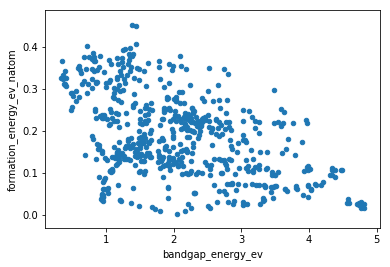

In [86]:
sub.plot.scatter(x='bandgap_energy_ev',y='formation_energy_ev_natom')